In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install prophet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv',parse_dates=['date'])
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv',parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv',parse_dates=['date'])

In [5]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',parse_dates=['date'])

## Exploring the datasets

In [6]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [8]:
# Creating a copy of the training and testing datasets so that we can start making changes without touching the original ones.
df = train.copy()
df_test = test.copy()

In [9]:
print(f'Training dates range: {str(df.date.iloc[0]).split()[0]} to {str(df.date.iloc[-1]).split()[0]}')
print(f'Testing dates range: {str(df_test.date.iloc[0]).split()[0]} to {str(df_test.date.iloc[-1]).split()[0]}')

Training dates range: 2013-01-01 to 2017-08-15
Testing dates range: 2017-08-16 to 2017-08-31


In [10]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


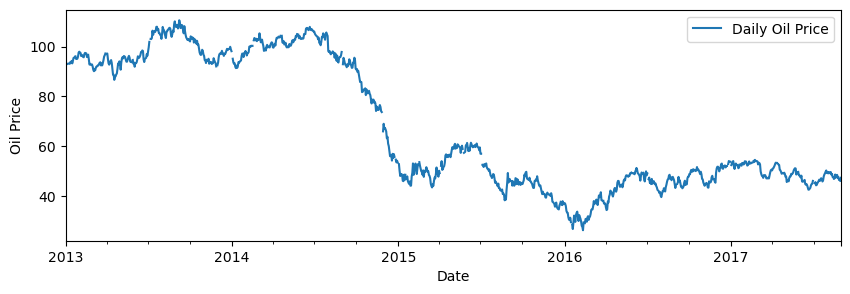

In [11]:
oil.plot(x='date',y='dcoilwtico',figsize=(10,3),label='Daily Oil Price')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

In [12]:
# Filling missing values using backward fill
oil.dcoilwtico = oil.dcoilwtico.bfill()

# Resampling and filling values with forward fill
oil = oil.set_index('date').resample(rule='D').ffill().reset_index()

In [13]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


54 stores across the country grouped by 14 clusters and 4 types. We will keep all this information to use in our training dataset.

In [15]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Let's check what unique labels are present in the locale column for holidays

In [16]:
holidays.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [17]:
# Labelling the locale column as numbers (starting from 1 since 0 = no holiday)
# We are expecting the nature of the holiday to play a role in the sales made hence the order

holidays.locale = holidays.locale.map({'Regional':1,'Local':2,'National':3})
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,2,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,1,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,2,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,2,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,2,Riobamba,Cantonizacion de Riobamba,False


Since we will be eventually merging the data in this particular dataset with the training one, it's important that the merge (on date) does not create duplicated entries. <br>We need to make sure that the dates are not repeated in holidays dataset for a proper merge. We will drop the duplicated entries and keep the highest locale value for that particular date.

In [18]:
# Checking how many duplicated entries are present

holidays[holidays.date.duplicated(keep=False)]

,date,type,locale,locale_name,description,transferred
7,2012-06-25,Holiday,1,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,2,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,2,Machala,Fundacion de Machala,False
10,2012-07-03,Holiday,2,Santo Domingo,Fundacion de Santo Domingo,False
11,2012-07-03,Holiday,2,El Carmen,Cantonizacion de El Carmen,False
...,...,...,...,...,...,...
319,2017-07-03,Holiday,2,Santo Domingo,Fundacion de Santo Domingo,False
341,2017-12-08,Holiday,2,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,2,Quito,Traslado Fundacion de Quito,False
344,2017-12-22,Holiday,2,Salinas,Cantonizacion de Salinas,False


69 rows in the dataset have duplicate date entries. As mentioned before, we need to keep only one and give it's locale value as the highest one available for the same date.<br>Why the highest? --> If it's a national holiday, all people not celebrating regional or local holidays will also have a holiday.

In [19]:
# Use groupby and max to get the max locale value on a holiday
holidays = holidays.groupby('date').max(numeric_only=True)
holidays.reset_index(inplace=True)

# Dropping transferred column
holidays.drop('transferred',axis=1,inplace=True)
holidays.head()

,date,locale
0,2012-03-02,2
1,2012-04-01,1
2,2012-04-12,2
3,2012-04-14,2
4,2012-04-21,2


In [20]:
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


## Merging the datasets

In [21]:
df = pd.merge(df,oil,on='date',how='left')
df = pd.merge(df,stores,on='store_nbr',how='left')
df = pd.merge(df,holidays,on='date',how='left')

In [22]:
df.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico           0
city                 0
state                0
type                 0
cluster              0
locale         2551824
dtype: int64

The missing values in locale are basically due to the fact that there lies no holiday on those dates. We will simply fill these with 0.

In [23]:
df.locale.fillna(0,inplace=True)
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
city           0
state          0
type           0
cluster        0
locale         0
dtype: int64

Great! Now that our training dataset is prepared, let's do the same for the testing dataset.

In [24]:
df_test = pd.merge(df_test,oil,on='date',how='left')
df_test = pd.merge(df_test,stores,on='store_nbr',how='left')
df_test = pd.merge(df_test,holidays,on='date',how='left')
df_test.locale.fillna(0,inplace=True)
df_test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dcoilwtico     0
city           0
state          0
type           0
cluster        0
locale         0
dtype: int64

## Feature Engineering

In [25]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,locale
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,3.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,3.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,3.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,3.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,3.0


Let's group our data with respect to store number and family of products and visualize the sales column.

In [26]:
trials = df.set_index(['store_nbr','family','date']).sort_index()

<Axes: xlabel='id', ylabel='sales'>

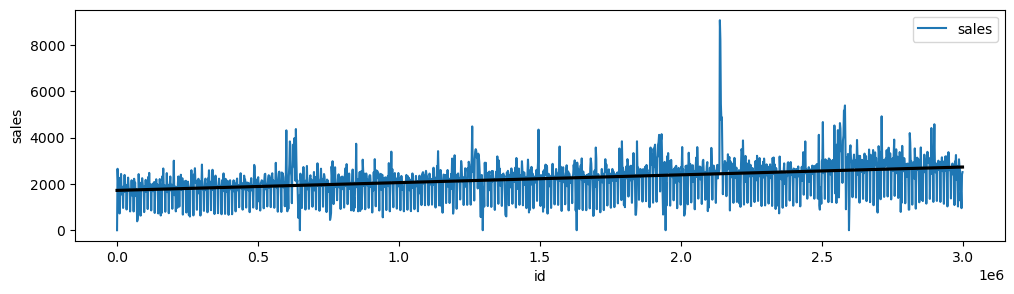

In [27]:
fig, ax = plt.subplots(figsize=(12,3))
trials.loc[1,'GROCERY I'].plot(x='id',y='sales',ax=ax)
sns.regplot(trials.loc[1,'GROCERY I'],x='id',y='sales',marker='',line_kws={'color':'k'},ax=ax)

We can see a increasing trend here with the date. Thus, we also need to extract some information from the date to use in our ML model since the sales is clearly showing some dependence on the date of sale. A trend with some seasonality can be seen for pretty much every store and product family.

In [28]:
# Creating features from date column to account for trend and seasonality

df['day_of_week'] = df.date.dt.day_of_week
df['day_name'] = df.date.dt.day_name()
df['day_name'] = df['day_name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df['day_of_month'] = df.date.dt.day
df['month'] = df.date.dt.month

In [29]:
# Repeating the same for the df_test set

df_test['day_of_week'] = df_test.date.dt.day_of_week
df_test['day_name'] = df_test.date.dt.day_name()
df_test['day_name'] = df_test['day_name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df_test['day_of_month'] = df_test.date.dt.day
df_test['month'] = df_test.date.dt.month

Let's check if both the datasets are properly prepared or not.

In [30]:
# df['sales']

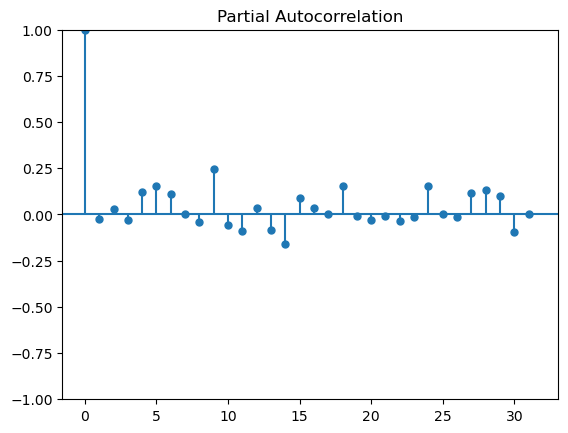

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

_ = plot_pacf(df['sales'], lags= 31)
# _ = plot_acf(df['sales'], lags = 40)

In [32]:
# df_test.info()

In [33]:
train_df = df.iloc[2596374:]
test_df = df_test

In [34]:
train_df

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,locale,day_of_week,day_name,day_of_month,month
2596374,2596374,2017-01-01,1,AUTOMOTIVE,0.000,0,53.75,Quito,Pichincha,D,13,3.0,6,1,1,1
2596375,2596375,2017-01-01,1,BABY CARE,0.000,0,53.75,Quito,Pichincha,D,13,3.0,6,1,1,1
2596376,2596376,2017-01-01,1,BEAUTY,0.000,0,53.75,Quito,Pichincha,D,13,3.0,6,1,1,1
2596377,2596377,2017-01-01,1,BEVERAGES,0.000,0,53.75,Quito,Pichincha,D,13,3.0,6,1,1,1
2596378,2596378,2017-01-01,1,BOOKS,0.000,0,53.75,Quito,Pichincha,D,13,3.0,6,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,2.0,1,0,15,8
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,2.0,1,0,15,8
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,2.0,1,0,15,8
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,2.0,1,0,15,8


In [35]:
cols = ['onpromotion',
       'dcoilwtico',
       'day_of_week', 'day_of_month']

In [36]:
# model = auto_arima(train_df['sales'], seasonal=True, m=7, stepwise=True, trace=True, suppress_warnings=True, error_action="ignore")

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

class NullIO:
    def write(self, text):
        pass

# Get unique stores and families from the train dataset
unique_stores = train_df['store_nbr'].unique()
unique_families = train_df['family'].unique()
y_pred = pd.DataFrame({'date':[], 'store_nbr': [], 'family' : [], 'sales':[]})

# Iterate through stores or families and make predictions for each
for store in tqdm(unique_stores):
    for family in unique_families:
        print(store)
        # Filter the data for the current store and family
        store_family_train = train_df[(train_df['store_nbr'] == store) & (train_df['family'] == family)]
        store_family_test = test_df[(test_df['store_nbr'] == store) & (test_df['family'] == family)]
        future_dates = store_family_test['date']
        exog_features_train = store_family_train[cols]

        order = (1, 1, 1)  # Order of non-seasonal components (p, d, q)
        seasonal_order = (1, 1, 1, 7)  # Seasonal order (P, D, Q, s)

#         # Create a SARIMA model with suppressed output
#         order = (1, 1, 2)  # Order of non-seasonal components (p, d, q)
#         seasonal_order = (0, 0, 2, 7)  # Seasonal order (P, D, Q, s)

        # Suppress warnings during model fitting
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sarima_model = sm.tsa.SARIMAX(store_family_train['sales'], order=order, seasonal_order=seasonal_order, exog=exog_features_train)
            sarima_results = sarima_model.fit()

#         model = auto_arima(store_family_train['sales'], seasonal=True, m=7, stepwise=True, trace=True, suppress_warnings=True, error_action="ignore")

#         # Generate forecasts for the next 16 steps
#         forecasted_values, conf_int = model.predict(n_periods=len(future_dates), return_conf_int=True)

        exog_forecast = store_family_test[cols]
        # Create a dataframe for future predictions (test set)
        predictions = sarima_results.get_prediction(start=len(store_family_train), end=len(store_family_train) + len(future_dates) - 1, exog=exog_forecast)

        # Extract forecasted values and confidence intervals
        forecasted_values = predictions.predicted_mean

        fam = [family]*16
        storeee = [store]*16

        y_pred1 = pd.DataFrame({'date':future_dates, 'store_nbr': storeee, 'family' : fam, 'sales':forecasted_values.array})
        y_pred = pd.concat([y_pred, y_pred1] , axis=0)
        y_pred.reset_index(drop=True, inplace=True)

print(y_pred)

  0%|          | 0/54 [00:00<?, ?it/s] This problem is unconstrained.


1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60098D+00    |proj g|=  1.53305D-01

At iterate    5    f=  2.44141D+00    |proj g|=  1.83541D-01

At iterate   10    f=  2.39489D+00    |proj g|=  3.69404D-02

At iterate   15    f=  2.38481D+00    |proj g|=  1.85883D-02

At iterate   20    f=  2.38328D+00    |proj g|=  1.07821D-02

At iterate   25    f=  2.38311D+00    |proj g|=  5.48538D-03

At iterate   30    f=  2.38309D+00    |proj g|=  4.75625D-04

At iterate   35    f=  2.38309D+00    |proj g|=  7.01071D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final functio

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23597D+00    |proj g|=  1.40702D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.15661D+00    |proj g|=  1.11621D-01

At iterate   10    f=  2.10503D+00    |proj g|=  2.78761D-01

At iterate   15    f=  2.07542D+00    |proj g|=  1.32254D-01

At iterate   20    f=  2.07179D+00    |proj g|=  1.68163D-02

At iterate   25    f=  2.06674D+00    |proj g|=  4.19351D-03

At iterate   30    f=  2.06629D+00    |proj g|=  1.17820D-02

At iterate   35    f=  2.06622D+00    |proj g|=  1.46870D-03

At iterate   40    f=  2.06620D+00    |proj g|=  8.23453D-04

At iterate   45    f=  2.06620D+00    |proj g|=  2.45204D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     65   

 This problem is unconstrained.



At iterate    5    f=  7.20151D+00    |proj g|=  8.60913D-03

At iterate   10    f=  7.19949D+00    |proj g|=  1.10275D-03

At iterate   15    f=  7.19621D+00    |proj g|=  1.98736D-02

At iterate   20    f=  7.19148D+00    |proj g|=  1.48949D-02

At iterate   25    f=  7.18644D+00    |proj g|=  2.43368D-02

At iterate   30    f=  7.18483D+00    |proj g|=  9.75649D-04

At iterate   35    f=  7.18348D+00    |proj g|=  8.49410D-03

At iterate   40    f=  7.17346D+00    |proj g|=  3.94452D-03

At iterate   45    f=  7.17173D+00    |proj g|=  1.05237D-02

At iterate   50    f=  7.16131D+00    |proj g|=  1.48161D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.22774D+00    |proj g|=  1.97679D+00

At iterate   10    f=  1.18207D+00    |proj g|=  6.37065D-01

At iterate   15    f=  1.15207D+00    |proj g|=  1.34694D-01

At iterate   20    f=  1.10533D+00    |proj g|=  8.31328D-02

At iterate   25    f=  1.09502D+00    |proj g|=  1.65242D-02

At iterate   30    f=  1.08588D+00    |proj g|=  9.28276D-02

At iterate   35    f=  1.08429D+00    |proj g|=  5.48106D-02

At iterate   40    f=  1.08414D+00    |proj g|=  7.75334D-03

At iterate   45    f=  1.08412D+00    |proj g|=  9.59760D-04

At iterate   50    f=  1.08412D+00    |proj g|=  2.72123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.46769D+00    |proj g|=  4.64920D-03

At iterate   10    f=  5.42555D+00    |proj g|=  4.43377D-02

At iterate   15    f=  5.39617D+00    |proj g|=  8.55649D-03

At iterate   20    f=  5.39252D+00    |proj g|=  1.62182D-03

At iterate   25    f=  5.39207D+00    |proj g|=  5.94404D-03

At iterate   30    f=  5.39202D+00    |proj g|=  9.46760D-04

At iterate   35    f=  5.39201D+00    |proj g|=  1.20490D-03

At iterate   40    f=  5.39197D+00    |proj g|=  5.54839D-04

At iterate   45    f=  5.39188D+00    |proj g|=  5.23582D-03

At iterate   50    f=  5.39178D+00    |proj g|=  1.54991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.32711D+00    |proj g|=  9.02176D-02

At iterate   10    f=  3.31370D+00    |proj g|=  5.80662D-03

At iterate   15    f=  3.31220D+00    |proj g|=  6.51496D-03

At iterate   20    f=  3.31069D+00    |proj g|=  4.70299D-03

At iterate   25    f=  3.30993D+00    |proj g|=  3.00728D-04

At iterate   30    f=  3.30992D+00    |proj g|=  2.01694D-03

At iterate   35    f=  3.30915D+00    |proj g|=  1.55426D-02

At iterate   40    f=  3.30821D+00    |proj g|=  3.02161D-03

At iterate   45    f=  3.30821D+00    |proj g|=  3.39928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     57   

 This problem is unconstrained.



At iterate    5    f=  6.21041D+00    |proj g|=  1.38831D-02

At iterate   10    f=  6.20437D+00    |proj g|=  7.10703D-03

At iterate   15    f=  6.19507D+00    |proj g|=  2.00899D-02

At iterate   20    f=  6.17936D+00    |proj g|=  3.35574D-02

At iterate   25    f=  6.16239D+00    |proj g|=  6.03375D-02

At iterate   30    f=  6.09231D+00    |proj g|=  8.41883D-02

At iterate   35    f=  6.04711D+00    |proj g|=  1.50893D-02

At iterate   40    f=  6.03531D+00    |proj g|=  1.65921D-02

At iterate   45    f=  6.03171D+00    |proj g|=  4.34174D-03

At iterate   50    f=  6.02953D+00    |proj g|=  8.41383D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.07745D+00    |proj g|=  3.67690D-03

At iterate   10    f=  6.06942D+00    |proj g|=  1.54496D-02

At iterate   15    f=  6.06296D+00    |proj g|=  2.07577D-02

At iterate   20    f=  6.03853D+00    |proj g|=  8.85021D-03

At iterate   25    f=  6.00166D+00    |proj g|=  8.72421D-02

At iterate   30    f=  5.98641D+00    |proj g|=  1.64019D-02

At iterate   35    f=  5.98606D+00    |proj g|=  2.57431D-03

At iterate   40    f=  5.98442D+00    |proj g|=  2.09110D-02

At iterate   45    f=  5.98191D+00    |proj g|=  1.97465D-03

At iterate   50    f=  5.98087D+00    |proj g|=  1.23448D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.68658D+00    |proj g|=  1.18136D-02

At iterate   10    f=  4.61142D+00    |proj g|=  4.95052D-02

At iterate   15    f=  4.55781D+00    |proj g|=  2.42822D-03

At iterate   20    f=  4.55723D+00    |proj g|=  2.59629D-03

At iterate   25    f=  4.55710D+00    |proj g|=  4.87887D-04

At iterate   30    f=  4.55709D+00    |proj g|=  1.33291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     36      1     0     0   7.450D-05   4.557D+00
  F =   4.5570920942495761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f=  4.49752D+00    |proj g|=  1.36450D-02

At iterate   10    f=  4.44664D+00    |proj g|=  9.91276D-02

At iterate   15    f=  4.39719D+00    |proj g|=  2.02130D-03

At iterate   20    f=  4.39659D+00    |proj g|=  6.25557D-04

At iterate   25    f=  4.39630D+00    |proj g|=  4.78750D-03

At iterate   30    f=  4.39608D+00    |proj g|=  4.50581D-04

At iterate   35    f=  4.39601D+00    |proj g|=  2.74283D-03

At iterate   40    f=  4.39599D+00    |proj g|=  5.87012D-04

At iterate   45    f=  4.39598D+00    |proj g|=  6.73384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     55   

 This problem is unconstrained.



At iterate    5    f=  4.68566D+00    |proj g|=  1.27025D-02

At iterate   10    f=  4.59035D+00    |proj g|=  1.25695D-02

At iterate   15    f=  4.58906D+00    |proj g|=  6.07984D-03

At iterate   20    f=  4.58082D+00    |proj g|=  4.06263D-02

At iterate   25    f=  4.57482D+00    |proj g|=  8.08088D-04

At iterate   30    f=  4.57476D+00    |proj g|=  2.61777D-03

At iterate   35    f=  4.57440D+00    |proj g|=  6.37515D-04

At iterate   40    f=  4.57440D+00    |proj g|=  2.88286D-04

At iterate   45    f=  4.57439D+00    |proj g|=  7.94329D-04

At iterate   50    f=  4.57439D+00    |proj g|=  5.71369D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.48024D+00    |proj g|=  2.41650D-02

At iterate   10    f=  7.47684D+00    |proj g|=  1.73449D-03

At iterate   15    f=  7.47097D+00    |proj g|=  6.61799D-03

At iterate   20    f=  7.46694D+00    |proj g|=  1.74007D-02

At iterate   25    f=  7.46636D+00    |proj g|=  9.31985D-03

At iterate   30    f=  7.45855D+00    |proj g|=  3.69323D-02

At iterate   35    f=  7.44381D+00    |proj g|=  1.84300D-02

At iterate   40    f=  7.43961D+00    |proj g|=  3.26090D-03

At iterate   45    f=  7.43709D+00    |proj g|=  1.05631D-02

At iterate   50    f=  7.37306D+00    |proj g|=  1.28880D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.59337D+00    |proj g|=  1.06860D-01

At iterate   10    f=  3.54336D+00    |proj g|=  8.66625D-03

At iterate   15    f=  3.53890D+00    |proj g|=  5.57285D-03

At iterate   20    f=  3.53827D+00    |proj g|=  6.32875D-03

At iterate   25    f=  3.53749D+00    |proj g|=  2.81332D-03

At iterate   30    f=  3.53745D+00    |proj g|=  3.90533D-04

At iterate   35    f=  3.53744D+00    |proj g|=  1.21305D-03

At iterate   40    f=  3.53725D+00    |proj g|=  9.51338D-04

At iterate   45    f=  3.53722D+00    |proj g|=  4.72432D-04

At iterate   50    f=  3.53719D+00    |proj g|=  6.80110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.93082D+00    |proj g|=  7.24062D-02

At iterate   10    f=  1.91561D+00    |proj g|=  5.96951D-02

At iterate   15    f=  1.91081D+00    |proj g|=  3.22486D-03

At iterate   20    f=  1.91062D+00    |proj g|=  2.78343D-03

At iterate   25    f=  1.91062D+00    |proj g|=  6.39736D-04

At iterate   30    f=  1.90943D+00    |proj g|=  8.31961D-02

At iterate   35    f=  1.90872D+00    |proj g|=  9.47802D-03

At iterate   40    f=  1.90868D+00    |proj g|=  1.94661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     59      1     0     0   3.371D-05   1.909D+00
  F =   1.90868275270

 This problem is unconstrained.



At iterate    5    f=  4.05018D+00    |proj g|=  3.38764D-02

At iterate   10    f=  3.94909D+00    |proj g|=  1.40042D-02

At iterate   15    f=  3.94803D+00    |proj g|=  8.19661D-04

At iterate   20    f=  3.94800D+00    |proj g|=  4.18163D-04

At iterate   25    f=  3.94793D+00    |proj g|=  1.29044D-03

At iterate   30    f=  3.94792D+00    |proj g|=  5.12195D-05

At iterate   35    f=  3.94792D+00    |proj g|=  1.75685D-04

At iterate   40    f=  3.94791D+00    |proj g|=  1.21649D-03

At iterate   45    f=  3.94790D+00    |proj g|=  1.13840D-03

At iterate   50    f=  3.94788D+00    |proj g|=  4.26942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.58774D+00    |proj g|=  8.58208D-02

At iterate   10    f=  3.51496D+00    |proj g|=  9.79851D-03

At iterate   15    f=  3.51254D+00    |proj g|=  3.99994D-03

At iterate   20    f=  3.51244D+00    |proj g|=  8.25635D-04

At iterate   25    f=  3.51243D+00    |proj g|=  6.00961D-05

At iterate   30    f=  3.51243D+00    |proj g|=  4.50193D-04
  ys=-1.255E-04  -gs= 1.553E-04 BFGS update SKIPPED

At iterate   35    f=  3.51178D+00    |proj g|=  6.33998D-03

At iterate   40    f=  3.51117D+00    |proj g|=  1.87649D-03

At iterate   45    f=  3.51113D+00    |proj g|=  5.04035D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  1.25763D+00    |proj g|=  4.18701D-01

At iterate   10    f=  1.16142D+00    |proj g|=  3.85682D-02

At iterate   15    f=  1.15386D+00    |proj g|=  5.15226D-02

At iterate   20    f=  1.15289D+00    |proj g|=  1.91278D-02

At iterate   25    f=  1.15266D+00    |proj g|=  1.42249D-02

At iterate   30    f=  1.15258D+00    |proj g|=  1.64285D-03

At iterate   35    f=  1.15257D+00    |proj g|=  2.95568D-03

At iterate   40    f=  1.15257D+00    |proj g|=  2.26280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     57      1     0     0   2.997D-03   1.153D+00
  F =   1.15257403562

 This problem is unconstrained.



At iterate    5    f=  4.91141D+00    |proj g|=  8.93584D-03

At iterate   10    f=  4.85094D+00    |proj g|=  3.41320D-02

At iterate   15    f=  4.82589D+00    |proj g|=  3.48329D-02

At iterate   20    f=  4.82379D+00    |proj g|=  3.07323D-03

At iterate   25    f=  4.81998D+00    |proj g|=  2.05262D-02

At iterate   30    f=  4.81813D+00    |proj g|=  3.66794D-03

At iterate   35    f=  4.81798D+00    |proj g|=  8.91486D-04

At iterate   40    f=  4.81797D+00    |proj g|=  8.36661D-05

At iterate   45    f=  4.81797D+00    |proj g|=  4.74652D-04

At iterate   50    f=  4.81797D+00    |proj g|=  4.87282D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.06714D+00    |proj g|=  1.37301D-01

At iterate   10    f=  3.05855D+00    |proj g|=  1.61645D-02

At iterate   15    f=  3.05531D+00    |proj g|=  3.49408D-03

At iterate   20    f=  3.05419D+00    |proj g|=  9.71850D-04

At iterate   25    f=  3.05403D+00    |proj g|=  9.22680D-04

At iterate   30    f=  3.05401D+00    |proj g|=  3.80071D-04

At iterate   35    f=  3.05400D+00    |proj g|=  2.08803D-04

At iterate   40    f=  3.05400D+00    |proj g|=  1.34764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     51      1     0     0   1.348D-04   3.054D+00
  F =   3.05400467206

 This problem is unconstrained.



At iterate    5    f=  3.75962D+00    |proj g|=  1.20547D-01

At iterate   10    f=  3.70476D+00    |proj g|=  8.21759D-03

At iterate   15    f=  3.70265D+00    |proj g|=  7.79131D-03

At iterate   20    f=  3.70106D+00    |proj g|=  2.15539D-03

At iterate   25    f=  3.70094D+00    |proj g|=  5.07612D-03

At iterate   30    f=  3.69993D+00    |proj g|=  3.51385D-03

At iterate   35    f=  3.69969D+00    |proj g|=  2.98328D-03

At iterate   40    f=  3.69965D+00    |proj g|=  8.25778D-04

At iterate   45    f=  3.69964D+00    |proj g|=  2.31546D-04

At iterate   50    f=  3.69964D+00    |proj g|=  7.70590D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.01991D+00    |proj g|=  8.76023D-02

At iterate   10    f=  3.00617D+00    |proj g|=  2.53075D-03

At iterate   15    f=  3.00561D+00    |proj g|=  7.16873D-03

At iterate   20    f=  3.00553D+00    |proj g|=  4.04945D-03

At iterate   25    f=  3.00542D+00    |proj g|=  4.76301D-04

At iterate   30    f=  3.00542D+00    |proj g|=  1.37111D-04

At iterate   35    f=  3.00539D+00    |proj g|=  2.33570D-03

At iterate   40    f=  3.00537D+00    |proj g|=  9.11581D-04

At iterate   45    f=  3.00537D+00    |proj g|=  1.11717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     53   

 This problem is unconstrained.



At iterate    5    f=  4.84869D+00    |proj g|=  2.55926D-02

At iterate   10    f=  4.74927D+00    |proj g|=  1.52704D-01

At iterate   15    f=  4.70209D+00    |proj g|=  5.11826D-03

At iterate   20    f=  4.69705D+00    |proj g|=  1.67629D-03

At iterate   25    f=  4.69701D+00    |proj g|=  5.70785D-03

At iterate   30    f=  4.69540D+00    |proj g|=  6.35889D-03

At iterate   35    f=  4.69505D+00    |proj g|=  2.59008D-03

At iterate   40    f=  4.69479D+00    |proj g|=  1.15897D-03

At iterate   45    f=  4.69476D+00    |proj g|=  8.76756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     59   

 This problem is unconstrained.



At iterate    5    f=  2.68499D+00    |proj g|=  4.24051D-02

At iterate   10    f=  2.66642D+00    |proj g|=  3.75051D-02

At iterate   15    f=  2.66361D+00    |proj g|=  2.96019D-03

At iterate   20    f=  2.66316D+00    |proj g|=  1.21589D-02

At iterate   25    f=  2.66050D+00    |proj g|=  2.94801D-02

At iterate   30    f=  2.65951D+00    |proj g|=  5.34344D-03

At iterate   35    f=  2.65941D+00    |proj g|=  4.08280D-04

At iterate   40    f=  2.65939D+00    |proj g|=  1.10082D-03

At iterate   45    f=  2.65939D+00    |proj g|=  2.02534D-04

At iterate   50    f=  2.65939D+00    |proj g|=  5.01750D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.84736D+00    |proj g|=  9.72280D-03

At iterate   10    f=  5.82034D+00    |proj g|=  3.98951D-02

At iterate   15    f=  5.68777D+00    |proj g|=  1.76559D-02

At iterate   20    f=  5.68341D+00    |proj g|=  2.54361D-02

At iterate   25    f=  5.67442D+00    |proj g|=  1.34220D-02

At iterate   30    f=  5.67418D+00    |proj g|=  3.96666D-05

At iterate   35    f=  5.67418D+00    |proj g|=  4.06078D-04

At iterate   40    f=  5.67416D+00    |proj g|=  3.48048D-04

At iterate   45    f=  5.67416D+00    |proj g|=  1.65524D-04

At iterate   50    f=  5.67416D+00    |proj g|=  3.57517D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.38274D+00    |proj g|=  2.14823D-02

At iterate   10    f=  5.37551D+00    |proj g|=  4.32328D-03

At iterate   15    f=  5.33786D+00    |proj g|=  9.71820D-02

At iterate   20    f=  5.31163D+00    |proj g|=  6.17130D-03

At iterate   25    f=  5.30536D+00    |proj g|=  3.86649D-03

At iterate   30    f=  5.30234D+00    |proj g|=  2.58309D-02

At iterate   35    f=  5.30119D+00    |proj g|=  8.59515D-04

At iterate   40    f=  5.30095D+00    |proj g|=  2.34929D-03

At iterate   45    f=  5.30079D+00    |proj g|=  5.01313D-04

At iterate   50    f=  5.30079D+00    |proj g|=  4.25303D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.40293D+00    |proj g|=  4.50970D-02

At iterate   10    f=  2.38342D+00    |proj g|=  5.66145D-02

At iterate   15    f=  2.38104D+00    |proj g|=  3.55477D-03

At iterate   20    f=  2.38082D+00    |proj g|=  9.73635D-04

At iterate   25    f=  2.38082D+00    |proj g|=  3.05476D-03

At iterate   30    f=  2.38082D+00    |proj g|=  4.05989D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     37      1     0     0   5.859D-05   2.381D+00
  F =   2.3808190282591855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f=  2.74263D+00    |proj g|=  2.05381D-01

At iterate   10    f=  2.72524D+00    |proj g|=  1.99074D-02

At iterate   15    f=  2.70495D+00    |proj g|=  5.88110D-03

At iterate   20    f=  2.69862D+00    |proj g|=  4.62771D-03

At iterate   25    f=  2.69846D+00    |proj g|=  8.32631D-03

At iterate   30    f=  2.69805D+00    |proj g|=  1.90639D-03

At iterate   35    f=  2.69805D+00    |proj g|=  1.48087D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     40      1     0     0   1.481D-05   2.698D+00
  F =   2.6980494556292012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.40297D+00    |proj g|=  8.58937D-03

At iterate   10    f=  5.37504D+00    |proj g|=  1.48214D-02

At iterate   15    f=  5.28313D+00    |proj g|=  2.89065D-02

At iterate   20    f=  5.27948D+00    |proj g|=  1.18966D-03

At iterate   25    f=  5.27845D+00    |proj g|=  4.87374D-03

At iterate   30    f=  5.27829D+00    |proj g|=  2.79976D-03

At iterate   35    f=  5.27812D+00    |proj g|=  1.90494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     47      1     0     0   3.462D-05   5.278D+00
  F =   5.2781180616026333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.45169D+00    |proj g|=  1.43658D-02

At iterate   10    f=  4.37366D+00    |proj g|=  3.45599D-02

At iterate   15    f=  4.36815D+00    |proj g|=  2.16425D-02

At iterate   20    f=  4.36737D+00    |proj g|=  8.41101D-03

At iterate   25    f=  4.36460D+00    |proj g|=  2.20738D-03

At iterate   30    f=  4.36396D+00    |proj g|=  4.01812D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     39      1     0     0   2.768D-05   4.364D+00
  F =   4.3638249052623168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f=  7.16257D+00    |proj g|=  2.44412D-02

At iterate   10    f=  7.15952D+00    |proj g|=  5.50936D-03

At iterate   15    f=  7.14426D+00    |proj g|=  2.40204D-02

At iterate   20    f=  7.14270D+00    |proj g|=  2.30390D-03

At iterate   25    f=  7.13636D+00    |proj g|=  1.02790D-02

At iterate   30    f=  7.13126D+00    |proj g|=  1.06773D-03

At iterate   35    f=  7.13002D+00    |proj g|=  1.02349D-02

At iterate   40    f=  7.07341D+00    |proj g|=  1.15134D-02

At iterate   45    f=  7.07133D+00    |proj g|=  2.66596D-04

At iterate   50    f=  7.07018D+00    |proj g|=  4.90710D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.18789D+00    |proj g|=  1.27262D+00

At iterate   10    f=  8.35701D-01    |proj g|=  4.86060D-01

At iterate   15    f=  8.04265D-01    |proj g|=  3.62236D-01

At iterate   20    f=  7.84228D-01    |proj g|=  9.14132D-01

At iterate   25    f=  7.57497D-01    |proj g|=  9.54682D-02

At iterate   30    f=  7.55313D-01    |proj g|=  2.52080D-01

At iterate   35    f=  7.46406D-01    |proj g|=  9.77378D-02

At iterate   40    f=  7.45471D-01    |proj g|=  6.70865D-03

At iterate   45    f=  7.45176D-01    |proj g|=  6.33546D-03

At iterate   50    f=  7.45109D-01    |proj g|=  6.13230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.59241D+00    |proj g|=  2.73196D-02

At iterate   10    f=  3.55951D+00    |proj g|=  3.86576D-03

At iterate   15    f=  3.55887D+00    |proj g|=  3.76681D-03

At iterate   20    f=  3.55790D+00    |proj g|=  1.00652D-02

At iterate   25    f=  3.55634D+00    |proj g|=  1.12228D-02

At iterate   30    f=  3.55422D+00    |proj g|=  8.21327D-03

At iterate   35    f=  3.55406D+00    |proj g|=  3.09243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     46      1     0     0   1.019D-06   3.554D+00
  F =   3.5540567491844821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

  2%|▏         | 1/54 [01:04<56:49, 64.33s/it] This problem is unconstrained.


10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44401D+00    |proj g|=  2.41702D-01

At iterate    5    f=  2.31085D+00    |proj g|=  1.75333D-01

At iterate   10    f=  2.21539D+00    |proj g|=  8.57067D-02

At iterate   15    f=  2.20291D+00    |proj g|=  4.66387D-02

At iterate   20    f=  2.19817D+00    |proj g|=  1.45815D-02

At iterate   25    f=  2.19790D+00    |proj g|=  5.55092D-03

At iterate   30    f=  2.19775D+00    |proj g|=  6.88533D-04

At iterate   35    f=  2.19774D+00    |proj g|=  1.74251D-04

At iterate   40    f=  2.19774D+00    |proj g|=  1.01872D-03

At iterate   45    f=  2.19773D+00    |proj g|=  3.09460D-03

At iterate   50    f=  2.19723D+00    |proj g|=  1.94800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during 

 This problem is unconstrained.



At iterate    5    f=  5.83283D-01    |proj g|=  1.35794D-01

At iterate   10    f=  5.08637D-01    |proj g|=  2.72783D-01

At iterate   15    f=  4.86922D-01    |proj g|=  1.52041D-01

At iterate   20    f=  4.78646D-01    |proj g|=  2.98537D-02

At iterate   25    f=  4.77714D-01    |proj g|=  4.06238D-02

At iterate   30    f=  4.77448D-01    |proj g|=  5.77735D-03

At iterate   35    f=  4.77434D-01    |proj g|=  1.55766D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     52      1     0     0   3.614D-05   4.774D-01
  F =  0.47743418246645314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.68281D+00    |proj g|=  1.53232D-01

At iterate   10    f=  1.66387D+00    |proj g|=  4.88579D-02

At iterate   15    f=  1.66280D+00    |proj g|=  3.01378D-03

At iterate   20    f=  1.66267D+00    |proj g|=  1.77677D-02

At iterate   25    f=  1.66236D+00    |proj g|=  6.08273D-03

At iterate   30    f=  1.66233D+00    |proj g|=  6.07613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     44      1     0     0   5.080D-06   1.662D+00
  F =   1.6623267644292574     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
10
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  6.70286D+00    |proj g|=  3.26176D-03

At iterate   10    f=  6.70196D+00    |proj g|=  3.23247D-03

At iterate   15    f=  6.69606D+00    |proj g|=  1.12242D-02

At iterate   20    f=  6.69471D+00    |proj g|=  3.90329D-03

At iterate   25    f=  6.66944D+00    |proj g|=  2.79124D-02

At iterate   30    f=  6.66460D+00    |proj g|=  3.99999D-03

At iterate   35    f=  6.65260D+00    |proj g|=  1.67595D-03

At iterate   40    f=  6.64873D+00    |proj g|=  5.63940D-02

At iterate   45    f=  6.64326D+00    |proj g|=  1.16744D-02

At iterate   50    f=  6.63955D+00    |proj g|=  2.24405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50329D+00    |proj g|=  7.98418D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.43873D+00    |proj g|=  2.29528D-02

At iterate   10    f=  4.35769D+00    |proj g|=  3.11893D-02

At iterate   15    f=  4.33892D+00    |proj g|=  1.84527D-03

At iterate   20    f=  4.33834D+00    |proj g|=  2.17432D-03

At iterate   25    f=  4.33828D+00    |proj g|=  2.11944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     34      1     0     0   4.790D-06   4.338D+00
  F =   4.3382791120350088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  2.65172D+00    |proj g|=  1.60831D-01

At iterate   10    f=  2.62840D+00    |proj g|=  2.91249D-02

At iterate   15    f=  2.61749D+00    |proj g|=  2.85491D-02

At iterate   20    f=  2.60696D+00    |proj g|=  2.97886D-02

At iterate   25    f=  2.60558D+00    |proj g|=  1.17746D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     30      1     0     0   3.876D-06   2.606D+00
  F =   2.6055767577838038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  6.78517D+00    |proj g|=  9.12990D-03

At iterate   15    f=  6.78317D+00    |proj g|=  1.91351D-03

At iterate   20    f=  6.77250D+00    |proj g|=  4.65378D-02

At iterate   25    f=  6.76809D+00    |proj g|=  3.50788D-03

At iterate   30    f=  6.73560D+00    |proj g|=  9.34368D-02

At iterate   35    f=  6.71888D+00    |proj g|=  7.08340D-03

At iterate   40    f=  6.71589D+00    |proj g|=  5.86765D-03

At iterate   45    f=  6.70156D+00    |proj g|=  2.07521D-02

At iterate   50    f=  6.69975D+00    |proj g|=  1.70261D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61   

 This problem is unconstrained.



At iterate    5    f=  5.57352D+00    |proj g|=  1.04818D-02

At iterate   10    f=  5.56101D+00    |proj g|=  5.32477D-03

At iterate   15    f=  5.54134D+00    |proj g|=  6.26132D-03

At iterate   20    f=  5.53190D+00    |proj g|=  9.00715D-03

At iterate   25    f=  5.53163D+00    |proj g|=  4.37062D-05

At iterate   30    f=  5.53163D+00    |proj g|=  3.46323D-04

At iterate   35    f=  5.53163D+00    |proj g|=  1.04564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     39      1     0     0   2.820D-05   5.532D+00
  F =   5.5316278405097270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  5.49377D+00    |proj g|=  7.38219D-03

At iterate   15    f=  5.46081D+00    |proj g|=  2.13775D-02

At iterate   20    f=  5.45133D+00    |proj g|=  5.12640D-03

At iterate   25    f=  5.43062D+00    |proj g|=  2.47698D-02

At iterate   30    f=  5.42826D+00    |proj g|=  7.30746D-04

At iterate   35    f=  5.42812D+00    |proj g|=  1.25977D-04

At iterate   40    f=  5.42811D+00    |proj g|=  3.46283D-04

At iterate   45    f=  5.42809D+00    |proj g|=  7.47898D-04

At iterate   50    f=  5.42791D+00    |proj g|=  4.10479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.



At iterate    5    f=  4.60415D+00    |proj g|=  1.43210D-02

At iterate   10    f=  4.45275D+00    |proj g|=  5.47839D-02

At iterate   15    f=  4.42869D+00    |proj g|=  2.43813D-02

At iterate   20    f=  4.42750D+00    |proj g|=  5.40052D-05

At iterate   25    f=  4.42749D+00    |proj g|=  1.00465D-03

At iterate   30    f=  4.42746D+00    |proj g|=  5.12950D-04

At iterate   35    f=  4.42745D+00    |proj g|=  1.27334D-03

At iterate   40    f=  4.42742D+00    |proj g|=  4.72723D-04

At iterate   45    f=  4.42741D+00    |proj g|=  5.59322D-04

At iterate   50    f=  4.42740D+00    |proj g|=  3.58258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.00924D+00    |proj g|=  2.26932D-02

At iterate   10    f=  3.92600D+00    |proj g|=  1.43220D-02

At iterate   15    f=  3.91338D+00    |proj g|=  4.90643D-03

At iterate   20    f=  3.91273D+00    |proj g|=  7.32414D-03

At iterate   25    f=  3.91242D+00    |proj g|=  1.49075D-03

At iterate   30    f=  3.91225D+00    |proj g|=  1.45141D-03

At iterate   35    f=  3.91218D+00    |proj g|=  4.09952D-04

At iterate   40    f=  3.91211D+00    |proj g|=  2.59753D-03

At iterate   45    f=  3.90866D+00    |proj g|=  6.26099D-03

At iterate   50    f=  3.90829D+00    |proj g|=  1.56016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.31295D+00    |proj g|=  7.90400D-03

At iterate   10    f=  7.31052D+00    |proj g|=  3.43597D-03

At iterate   15    f=  7.30808D+00    |proj g|=  1.07356D-02

At iterate   20    f=  7.29774D+00    |proj g|=  1.30622D-02

At iterate   25    f=  7.29735D+00    |proj g|=  7.21991D-04

At iterate   30    f=  7.28996D+00    |proj g|=  1.42058D-02

At iterate   35    f=  7.28627D+00    |proj g|=  1.55175D-03

At iterate   40    f=  7.28503D+00    |proj g|=  9.92627D-03

At iterate   45    f=  7.24191D+00    |proj g|=  5.82610D-02

At iterate   50    f=  7.22617D+00    |proj g|=  3.63685D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00901D+00    |proj g|=  1.28593D-01

At iterate    5    f=  2.84048D+00    |proj g|=  1.53736D-01

At iterate   10    f=  2.82775D+00    |proj g|=  9.76053D-03

At iterate   15    f=  2.82135D+00    |proj g|=  3.40730D-03

At iterate   20    f=  2.82105D+00    |proj g|=  6.32231D-04

At iterate   25    f=  2.82102D+00    |proj g|=  6.04539D-04

At iterate   30    f=  2.82102D+00    |proj g|=  1.25924D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  1.32618D+00    |proj g|=  1.27636D-01

At iterate   10    f=  1.26292D+00    |proj g|=  1.22971D-01

At iterate   15    f=  1.23561D+00    |proj g|=  3.62872D-02

At iterate   20    f=  1.23405D+00    |proj g|=  4.40023D-03

At iterate   25    f=  1.23399D+00    |proj g|=  3.25427D-02

At iterate   30    f=  1.23345D+00    |proj g|=  4.81761D-02

At iterate   35    f=  1.23311D+00    |proj g|=  2.24355D-02

At iterate   40    f=  1.23289D+00    |proj g|=  1.94681D-02

At iterate   45    f=  1.23283D+00    |proj g|=  7.90852D-03

At iterate   50    f=  1.23282D+00    |proj g|=  3.85525D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.14109D+00    |proj g|=  6.41798D-02

At iterate   10    f=  3.12866D+00    |proj g|=  2.39959D-02

At iterate   15    f=  3.12468D+00    |proj g|=  7.95212D-03

At iterate   20    f=  3.12427D+00    |proj g|=  1.01009D-03

At iterate   25    f=  3.12426D+00    |proj g|=  3.80164D-04

At iterate   30    f=  3.12426D+00    |proj g|=  3.57808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     35      1     0     0   2.827D-05   3.124D+00
  F =   3.1242611800503832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
10
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  2.62284D+00    |proj g|=  1.05178D-01

At iterate   10    f=  2.61632D+00    |proj g|=  1.57999D-02

At iterate   15    f=  2.61219D+00    |proj g|=  3.93963D-03

At iterate   20    f=  2.61122D+00    |proj g|=  9.27555D-03

At iterate   25    f=  2.61018D+00    |proj g|=  8.16736D-03

At iterate   30    f=  2.60991D+00    |proj g|=  9.16863D-04

At iterate   35    f=  2.60989D+00    |proj g|=  1.92164D-03

At iterate   40    f=  2.60985D+00    |proj g|=  3.33769D-04

At iterate   45    f=  2.60985D+00    |proj g|=  3.04868D-04

At iterate   50    f=  2.60984D+00    |proj g|=  3.61297D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.29437D-01    |proj g|=  1.88931D-01

At iterate   10    f=  6.89187D-01    |proj g|=  1.14730D-01

At iterate   15    f=  6.46962D-01    |proj g|=  8.23574D-02

At iterate   20    f=  6.30843D-01    |proj g|=  3.34210D-01

At iterate   25    f=  6.28946D-01    |proj g|=  1.32293D-02

At iterate   30    f=  6.28941D-01    |proj g|=  3.70276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     46      1     0     0   3.626D-04   6.289D-01
  F =  0.62894140726788794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
10
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  4.92471D+00    |proj g|=  8.32940D-03

At iterate   10    f=  4.90433D+00    |proj g|=  2.90491D-02

At iterate   15    f=  4.88588D+00    |proj g|=  1.50472D-02

At iterate   20    f=  4.88557D+00    |proj g|=  2.67123D-04

At iterate   25    f=  4.88555D+00    |proj g|=  3.11007D-04

At iterate   30    f=  4.88554D+00    |proj g|=  4.69958D-04

At iterate   35    f=  4.88554D+00    |proj g|=  2.75792D-04

At iterate   40    f=  4.88553D+00    |proj g|=  3.71269D-04

At iterate   45    f=  4.88552D+00    |proj g|=  5.80316D-04

At iterate   50    f=  4.88548D+00    |proj g|=  6.37426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.73220D+00    |proj g|=  3.11958D-02

At iterate   10    f=  2.72760D+00    |proj g|=  2.29593D-02

At iterate   15    f=  2.72699D+00    |proj g|=  3.27069D-04

At iterate   20    f=  2.72698D+00    |proj g|=  2.18549D-04

At iterate   25    f=  2.72693D+00    |proj g|=  3.92754D-03

At iterate   30    f=  2.72690D+00    |proj g|=  1.18578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     41      1     0     0   3.671D-05   2.727D+00
  F =   2.7268966250576150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
10
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68248D+00    |proj g|=  2.52746D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.45841D+00    |proj g|=  3.48181D-01

At iterate   10    f=  2.39175D+00    |proj g|=  2.78321D-02

At iterate   15    f=  2.37462D+00    |proj g|=  1.78005D-02

At iterate   20    f=  2.37188D+00    |proj g|=  1.04385D-02

At iterate   25    f=  2.37119D+00    |proj g|=  6.47788D-04

At iterate   30    f=  2.37118D+00    |proj g|=  7.22172D-03

At iterate   35    f=  2.37117D+00    |proj g|=  1.09639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     41      1     0     0   1.096D-04   2.371D+00
  F =   2.3711689014101185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.41155D+00    |proj g|=  1.13576D-01

At iterate   10    f=  3.39274D+00    |proj g|=  1.33527D-02

At iterate   15    f=  3.37804D+00    |proj g|=  1.16131D-03

At iterate   20    f=  3.37775D+00    |proj g|=  9.71392D-03

At iterate   25    f=  3.37695D+00    |proj g|=  2.02152D-03

At iterate   30    f=  3.37689D+00    |proj g|=  1.07128D-03

At iterate   35    f=  3.37687D+00    |proj g|=  1.55183D-03

At iterate   40    f=  3.37687D+00    |proj g|=  2.06067D-04

At iterate   45    f=  3.37687D+00    |proj g|=  2.16149D-04

At iterate   50    f=  3.37687D+00    |proj g|=  7.17380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.33586D+00    |proj g|=  4.25041D-01

At iterate   10    f=  1.24714D+00    |proj g|=  7.90880D-02

At iterate   15    f=  1.23331D+00    |proj g|=  6.97005D-02

At iterate   20    f=  1.23039D+00    |proj g|=  3.82239D-02

At iterate   25    f=  1.23001D+00    |proj g|=  1.38901D-02

At iterate   30    f=  1.22995D+00    |proj g|=  2.44378D-03

At iterate   35    f=  1.22995D+00    |proj g|=  2.36216D-03

At iterate   40    f=  1.22995D+00    |proj g|=  9.18571D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     61      1     0     0   4.241D-04   1.230D+00
  F =   1.22994745706


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.90550D+00    |proj g|=  3.89364D-02

At iterate   10    f=  4.84819D+00    |proj g|=  4.47656D-02

At iterate   15    f=  4.83506D+00    |proj g|=  6.51532D-03

At iterate   20    f=  4.81825D+00    |proj g|=  3.35171D-02

At iterate   25    f=  4.81624D+00    |proj g|=  1.29722D-02

At iterate   30    f=  4.81130D+00    |proj g|=  3.22837D-03

At iterate   35    f=  4.81126D+00    |proj g|=  5.69907D-04

At iterate   40    f=  4.81108D+00    |proj g|=  2.37599D-03

At iterate   45    f=  4.81104D+00    |proj g|=  1.79182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     59   

 This problem is unconstrained.



At iterate    5    f=  5.02984D+00    |proj g|=  1.96570D-02

At iterate   10    f=  5.02081D+00    |proj g|=  1.25731D-02

At iterate   15    f=  5.00290D+00    |proj g|=  3.39703D-03

At iterate   20    f=  5.00012D+00    |proj g|=  1.35330D-03

At iterate   25    f=  5.00000D+00    |proj g|=  4.91254D-03

At iterate   30    f=  4.99917D+00    |proj g|=  1.08443D-02

At iterate   35    f=  4.99904D+00    |proj g|=  2.50086D-04

At iterate   40    f=  4.99904D+00    |proj g|=  2.48684D-04

At iterate   45    f=  4.99904D+00    |proj g|=  2.34438D-04

At iterate   50    f=  4.99904D+00    |proj g|=  1.16807D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.59900D+00    |proj g|=  3.56178D-01

At iterate   10    f=  1.51065D+00    |proj g|=  4.27948D-02

At iterate   15    f=  1.50414D+00    |proj g|=  5.06917D-02

At iterate   20    f=  1.50376D+00    |proj g|=  5.33685D-03

At iterate   25    f=  1.50347D+00    |proj g|=  3.23410D-02

At iterate   30    f=  1.50312D+00    |proj g|=  1.81424D-03

At iterate   35    f=  1.50305D+00    |proj g|=  9.40052D-03

At iterate   40    f=  1.50237D+00    |proj g|=  1.65183D-02

At iterate   45    f=  1.50235D+00    |proj g|=  1.23444D-03

At iterate   50    f=  1.50234D+00    |proj g|=  2.10910D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.31972D+00    |proj g|=  1.52164D-01

At iterate   10    f=  2.27031D+00    |proj g|=  4.01718D-02

At iterate   15    f=  2.25519D+00    |proj g|=  3.69751D-02

At iterate   20    f=  2.24940D+00    |proj g|=  1.79779D-02

At iterate   25    f=  2.24933D+00    |proj g|=  2.75493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     32      1     0     0   3.541D-05   2.249D+00
  F =   2.2493331003380250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  4.84084D+00    |proj g|=  4.92693D-02

At iterate   15    f=  4.82183D+00    |proj g|=  1.00429D-02

At iterate   20    f=  4.81223D+00    |proj g|=  4.11750D-03

At iterate   25    f=  4.81124D+00    |proj g|=  1.50591D-02

At iterate   30    f=  4.80965D+00    |proj g|=  4.95893D-03

At iterate   35    f=  4.80715D+00    |proj g|=  2.45353D-03

At iterate   40    f=  4.80687D+00    |proj g|=  4.12221D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     48      1     0     0   3.121D-05   4.807D+00
  F =   4.8068720332369983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.74490D+00    |proj g|=  2.63667D-02

At iterate   10    f=  3.69349D+00    |proj g|=  7.20696D-03

At iterate   15    f=  3.68970D+00    |proj g|=  4.44429D-03

At iterate   20    f=  3.68843D+00    |proj g|=  1.61528D-02

At iterate   25    f=  3.68750D+00    |proj g|=  2.48150D-04

At iterate   30    f=  3.68750D+00    |proj g|=  5.47161D-05

At iterate   35    f=  3.68748D+00    |proj g|=  3.07110D-03

At iterate   40    f=  3.68746D+00    |proj g|=  1.61663D-04

At iterate   45    f=  3.68746D+00    |proj g|=  3.05374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     56   

 This problem is unconstrained.



At iterate    5    f=  5.09583D+00    |proj g|=  4.74307D-03

At iterate   10    f=  5.08427D+00    |proj g|=  1.31355D-02

At iterate   15    f=  5.06625D+00    |proj g|=  1.50367D-02

At iterate   20    f=  5.06592D+00    |proj g|=  3.04880D-03

At iterate   25    f=  5.06586D+00    |proj g|=  1.01306D-03

At iterate   30    f=  5.06584D+00    |proj g|=  1.98125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     35      1     0     0   1.707D-05   5.066D+00
  F =   5.0658433467875126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
10
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  1.27815D+00    |proj g|=  6.86880D-01

At iterate   10    f=  1.01438D+00    |proj g|=  1.84148D+00

At iterate   15    f=  9.79237D-01    |proj g|=  2.19063D+00

At iterate   20    f=  9.77735D-01    |proj g|=  1.33798D-01

At iterate   25    f=  9.71364D-01    |proj g|=  6.77764D-01

At iterate   30    f=  9.50832D-01    |proj g|=  4.76153D+00

At iterate   35    f=  9.48523D-01    |proj g|=  2.90023D+00

At iterate   40    f=  9.48174D-01    |proj g|=  5.36238D-03

At iterate   45    f=  9.48168D-01    |proj g|=  1.51929D-01

At iterate   50    f=  9.47755D-01    |proj g|=  3.21361D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.14414D+00    |proj g|=  2.94330D-02

At iterate   10    f=  2.13206D+00    |proj g|=  6.99194D-03

At iterate   15    f=  2.13174D+00    |proj g|=  1.10085D-02

At iterate   20    f=  2.13168D+00    |proj g|=  5.75265D-04


  4%|▎         | 2/54 [02:03<53:10, 61.35s/it]


At iterate   25    f=  2.13167D+00    |proj g|=  5.47695D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     31      1     0     0   1.819D-05   2.132D+00
  F =   2.1316716386214782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92049D+00    |proj g|=  2.22474D-01

At iterate    5    f=  2.74666D+00    |proj g|=  1.85383D-01

At iterate   10    f=  2.71555D+00    |proj g|=  1.69676D-02

At iterate   15    f=  2.71423D+00    |proj g|=  4.14006D-02

At iterate   20    f=  2.71378D+00    |proj g|=  6.90166D-03

At iterate   25    f=  2.71342D+00    |proj g|=  4.61745D-03

At iterate   30    f=  2.71326D+00    |proj g|=  5.94558D-04

At iterate   35    f=  2.71326D+00    |proj g|=  2.96946D-04

At iterate   40    f=  2.71325D+00    |proj g|=  5.64215D-04

At iterate   45    f=  2.71325D+00    |proj g|=  3.29883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  1.38548D+00    |proj g|=  1.92579D-01

At iterate   10    f=  1.32694D+00    |proj g|=  1.92869D-01

At iterate   15    f=  1.29564D+00    |proj g|=  2.22286D-02

At iterate   20    f=  1.28911D+00    |proj g|=  4.73048D-02

At iterate   25    f=  1.28688D+00    |proj g|=  1.34371D-02

At iterate   30    f=  1.28685D+00    |proj g|=  3.86361D-02

At iterate   35    f=  1.28305D+00    |proj g|=  6.89163D-01

At iterate   40    f=  1.27501D+00    |proj g|=  3.57747D-01

At iterate   45    f=  1.27184D+00    |proj g|=  2.22563D-02

At iterate   50    f=  1.27160D+00    |proj g|=  3.25335D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.54529D+00    |proj g|=  1.97462D-01

At iterate   10    f=  2.53433D+00    |proj g|=  3.13843D-02

At iterate   15    f=  2.53127D+00    |proj g|=  5.26086D-03

At iterate   20    f=  2.53031D+00    |proj g|=  2.90959D-03

At iterate   25    f=  2.52943D+00    |proj g|=  2.24470D-02

At iterate   30    f=  2.52878D+00    |proj g|=  7.18388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     43      1     0     0   2.391D-05   2.529D+00
  F =   2.5287779354751310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  7.82522D+00    |proj g|=  6.89003D-03

At iterate   10    f=  7.82475D+00    |proj g|=  8.58148D-04

At iterate   15    f=  7.81926D+00    |proj g|=  4.09930D-02

At iterate   20    f=  7.81131D+00    |proj g|=  1.24017D-03

At iterate   25    f=  7.81046D+00    |proj g|=  3.18684D-03

At iterate   30    f=  7.81032D+00    |proj g|=  1.74902D-03

At iterate   35    f=  7.80825D+00    |proj g|=  4.00254D-02

At iterate   40    f=  7.79090D+00    |proj g|=  5.03237D-02

At iterate   45    f=  7.78472D+00    |proj g|=  1.01334D-02

At iterate   50    f=  7.78241D+00    |proj g|=  1.21030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23859D+00    |proj g|=  3.86161D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.21408D+00    |proj g|=  3.03308D-02

At iterate   10    f=  6.19595D+00    |proj g|=  2.04624D-03

At iterate   15    f=  6.18807D+00    |proj g|=  2.83008D-03

At iterate   20    f=  6.17750D+00    |proj g|=  3.24637D-02

At iterate   25    f=  6.14904D+00    |proj g|=  1.09118D-03

At iterate   30    f=  6.14697D+00    |proj g|=  5.46791D-03

At iterate   35    f=  6.14666D+00    |proj g|=  2.12784D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     40      1     0     0   2.128D-05   6.147D+00
  F =   6.1466641858068023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.40023D+00    |proj g|=  6.49144D-03

At iterate   15    f=  3.39728D+00    |proj g|=  1.80630D-02

At iterate   20    f=  3.39700D+00    |proj g|=  3.46468D-04

At iterate   25    f=  3.39699D+00    |proj g|=  5.99126D-04

At iterate   30    f=  3.39694D+00    |proj g|=  2.09471D-03

At iterate   35    f=  3.39693D+00    |proj g|=  3.21140D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     39      1     0     0   3.211D-05   3.397D+00
  F =   3.3969305064541406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  7.20567D+00    |proj g|=  3.01482D-03

At iterate   10    f=  7.20430D+00    |proj g|=  2.47910D-02

At iterate   15    f=  7.19357D+00    |proj g|=  1.80459D-02

At iterate   20    f=  7.18825D+00    |proj g|=  9.19544D-04

At iterate   25    f=  7.18757D+00    |proj g|=  8.73409D-03

At iterate   30    f=  7.18594D+00    |proj g|=  2.50517D-04

At iterate   35    f=  7.18592D+00    |proj g|=  1.28455D-03

At iterate   40    f=  7.18515D+00    |proj g|=  1.11693D-02

At iterate   45    f=  7.18414D+00    |proj g|=  1.91175D-04


 This problem is unconstrained.



At iterate    5    f=  6.15311D+00    |proj g|=  1.17379D-02

At iterate   10    f=  6.14250D+00    |proj g|=  7.99619D-03

At iterate   15    f=  6.13770D+00    |proj g|=  8.42803D-03

At iterate   20    f=  6.13680D+00    |proj g|=  7.38563D-03

At iterate   25    f=  6.13507D+00    |proj g|=  1.12782D-02

At iterate   30    f=  6.13063D+00    |proj g|=  6.64423D-03

At iterate   35    f=  6.13055D+00    |proj g|=  8.32816D-04

At iterate   40    f=  6.13054D+00    |proj g|=  5.31730D-04

At iterate   45    f=  6.13053D+00    |proj g|=  2.15754D-04

At iterate   50    f=  6.13051D+00    |proj g|=  3.92449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88257D+00    |proj g|=  4.41888D-03

At iterate   10    f=  5.87876D+00    |proj g|=  4.95652D-02

At iterate   15    f=  5.87182D+00    |proj g|=  1.86990D-02

At iterate   20    f=  5.85600D+00    |proj g|=  3.13018D-03

At iterate   25    f=  5.85341D+00    |proj g|=  1.56099D-02

At iterate   30    f=  5.85175D+00    |proj g|=  1.67143D-02

At iterate   35    f=  5.85061D+00    |proj g|=  6.83578D-03

At iterate   40    f=  5.85047D+00    |proj g|=  2.58699D-04

At iterate   45    f=  5.85041D+00    |proj g|=  3.90011D-03

At iterate   50    f=  5.85032D+00    |proj g|=  2.70457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.84769D+00    |proj g|=  1.44642D-02

At iterate   10    f=  5.84111D+00    |proj g|=  6.34764D-03

At iterate   15    f=  5.78769D+00    |proj g|=  7.23238D-02

At iterate   20    f=  5.76005D+00    |proj g|=  7.10379D-03

At iterate   25    f=  5.75816D+00    |proj g|=  3.74623D-04

At iterate   30    f=  5.75812D+00    |proj g|=  1.00595D-03

At iterate   35    f=  5.75795D+00    |proj g|=  6.02144D-04

At iterate   40    f=  5.75795D+00    |proj g|=  6.53071D-05

At iterate   45    f=  5.75795D+00    |proj g|=  1.73407D-04

At iterate   50    f=  5.75795D+00    |proj g|=  7.62659D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.59962D+00    |proj g|=  1.06273D-02

At iterate   10    f=  4.57552D+00    |proj g|=  4.17605D-02

At iterate   15    f=  4.54985D+00    |proj g|=  1.68219D-02

At iterate   20    f=  4.54890D+00    |proj g|=  1.84917D-03

At iterate   25    f=  4.54788D+00    |proj g|=  4.24949D-03

At iterate   30    f=  4.54775D+00    |proj g|=  7.85924D-04

At iterate   35    f=  4.54762D+00    |proj g|=  3.04344D-03

At iterate   40    f=  4.54760D+00    |proj g|=  4.06497D-05

At iterate   45    f=  4.54760D+00    |proj g|=  2.70010D-04

At iterate   50    f=  4.54759D+00    |proj g|=  1.29182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.14340D+00    |proj g|=  3.28544D-03

At iterate   10    f=  8.14331D+00    |proj g|=  4.16288D-04

At iterate   15    f=  8.14148D+00    |proj g|=  2.35412D-02

At iterate   20    f=  8.13933D+00    |proj g|=  4.66361D-04

At iterate   25    f=  8.13921D+00    |proj g|=  3.19526D-03

At iterate   30    f=  8.13750D+00    |proj g|=  4.14576D-03

At iterate   35    f=  8.13738D+00    |proj g|=  4.25427D-04

At iterate   40    f=  8.13726D+00    |proj g|=  2.89493D-03

At iterate   45    f=  8.13013D+00    |proj g|=  5.80933D-02

At iterate   50    f=  8.12544D+00    |proj g|=  1.01795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.97317D+00    |proj g|=  3.02070D-02

At iterate   10    f=  3.90543D+00    |proj g|=  4.92608D-03

At iterate   15    f=  3.90297D+00    |proj g|=  1.12689D-02

At iterate   20    f=  3.90251D+00    |proj g|=  5.53015D-03

At iterate   25    f=  3.90225D+00    |proj g|=  4.99994D-04

At iterate   30    f=  3.90220D+00    |proj g|=  1.33583D-03

At iterate   35    f=  3.90219D+00    |proj g|=  3.39692D-04

At iterate   40    f=  3.90219D+00    |proj g|=  1.08170D-04

At iterate   45    f=  3.90219D+00    |proj g|=  1.79838D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     51   

 This problem is unconstrained.



At iterate    5    f=  1.57639D+00    |proj g|=  7.17735D-01

At iterate   10    f=  1.48533D+00    |proj g|=  4.94484D-02

At iterate   15    f=  1.45367D+00    |proj g|=  6.40448D-02

At iterate   20    f=  1.45309D+00    |proj g|=  9.17229D-03

At iterate   25    f=  1.45050D+00    |proj g|=  1.04270D-01

At iterate   30    f=  1.44156D+00    |proj g|=  6.80983D-02

At iterate   35    f=  1.44118D+00    |proj g|=  3.18369D-03

At iterate   40    f=  1.44116D+00    |proj g|=  1.26673D-02

At iterate   45    f=  1.44106D+00    |proj g|=  1.10840D-02

At iterate   50    f=  1.44088D+00    |proj g|=  1.78275D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.55637D+00    |proj g|=  1.24340D-02

At iterate   10    f=  4.48678D+00    |proj g|=  1.98315D-02

At iterate   15    f=  4.48624D+00    |proj g|=  1.68095D-03

At iterate   20    f=  4.48588D+00    |proj g|=  9.38933D-03

At iterate   25    f=  4.48353D+00    |proj g|=  3.47636D-03

At iterate   30    f=  4.48232D+00    |proj g|=  1.17165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     44      1     0     0   3.312D-05   4.482D+00
  F =   4.4822874131303685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  3.43126D+00    |proj g|=  3.77947D-02

At iterate   10    f=  3.42408D+00    |proj g|=  7.16064D-03

At iterate   15    f=  3.42382D+00    |proj g|=  1.45966D-04

At iterate   20    f=  3.42381D+00    |proj g|=  1.10560D-04

At iterate   25    f=  3.42381D+00    |proj g|=  1.96018D-04

At iterate   30    f=  3.42381D+00    |proj g|=  9.32452D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     35      1     0     0   1.058D-05   3.424D+00
  F =   3.4238078497633215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  1.22567D+00    |proj g|=  1.42979D-01

At iterate   10    f=  1.14312D+00    |proj g|=  3.03081D-01

At iterate   15    f=  1.08643D+00    |proj g|=  7.19977D-02

At iterate   20    f=  1.08626D+00    |proj g|=  2.80261D-02

At iterate   25    f=  1.08607D+00    |proj g|=  1.51017D-02

At iterate   30    f=  1.08594D+00    |proj g|=  3.85772D-02

At iterate   35    f=  1.08419D+00    |proj g|=  6.50850D-02

At iterate   40    f=  1.08409D+00    |proj g|=  3.49875D-03

At iterate   45    f=  1.08388D+00    |proj g|=  3.85555D-02

At iterate   50    f=  1.08237D+00    |proj g|=  1.53105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.97258D+00    |proj g|=  1.42896D-02

At iterate   10    f=  5.95914D+00    |proj g|=  4.10790D-02

At iterate   15    f=  5.95270D+00    |proj g|=  2.24764D-02

At iterate   20    f=  5.94912D+00    |proj g|=  7.38312D-04

At iterate   25    f=  5.94782D+00    |proj g|=  7.60016D-03

At iterate   30    f=  5.94661D+00    |proj g|=  4.83476D-04

At iterate   35    f=  5.94638D+00    |proj g|=  1.20702D-03

At iterate   40    f=  5.94608D+00    |proj g|=  4.85733D-04

At iterate   45    f=  5.94607D+00    |proj g|=  3.07609D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     48   

 This problem is unconstrained.



At iterate    5    f=  3.56963D+00    |proj g|=  1.06932D-01

At iterate   10    f=  3.51783D+00    |proj g|=  6.07556D-03

At iterate   15    f=  3.51674D+00    |proj g|=  2.48837D-03

At iterate   20    f=  3.51608D+00    |proj g|=  1.91960D-03

At iterate   25    f=  3.51602D+00    |proj g|=  1.22935D-03

At iterate   30    f=  3.51487D+00    |proj g|=  2.66055D-02

At iterate   35    f=  3.51346D+00    |proj g|=  4.27936D-03

At iterate   40    f=  3.51333D+00    |proj g|=  3.83140D-04

At iterate   45    f=  3.51328D+00    |proj g|=  3.78053D-03

At iterate   50    f=  3.51325D+00    |proj g|=  1.73808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.23987D+00    |proj g|=  6.46007D-02

At iterate   10    f=  3.23454D+00    |proj g|=  1.50710D-02

At iterate   15    f=  3.22934D+00    |proj g|=  9.78050D-03

At iterate   20    f=  3.22853D+00    |proj g|=  1.78310D-03

At iterate   25    f=  3.22844D+00    |proj g|=  2.23467D-03

At iterate   30    f=  3.22826D+00    |proj g|=  1.04600D-03

At iterate   35    f=  3.22824D+00    |proj g|=  4.48234D-04

At iterate   40    f=  3.22823D+00    |proj g|=  5.31242D-04

At iterate   45    f=  3.22823D+00    |proj g|=  1.17945D-04

At iterate   50    f=  3.22823D+00    |proj g|=  3.72540D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.94065D+00    |proj g|=  3.72700D-02

At iterate   10    f=  2.93299D+00    |proj g|=  2.60123D-02

At iterate   15    f=  2.92403D+00    |proj g|=  1.83815D-02

At iterate   20    f=  2.92363D+00    |proj g|=  3.29453D-03

At iterate   25    f=  2.92297D+00    |proj g|=  1.69940D-03

At iterate   30    f=  2.92291D+00    |proj g|=  7.65614D-04

At iterate   35    f=  2.92290D+00    |proj g|=  8.74845D-04

At iterate   40    f=  2.92289D+00    |proj g|=  2.92800D-04

At iterate   45    f=  2.92289D+00    |proj g|=  2.64758D-04
  ys=-1.572E-07  -gs= 6.500E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  4.70737D+00    |proj g|=  4.58002D-02

At iterate   10    f=  4.62728D+00    |proj g|=  1.05681D-01

At iterate   15    f=  4.57298D+00    |proj g|=  4.06688D-03

At iterate   20    f=  4.57179D+00    |proj g|=  6.26549D-04

At iterate   25    f=  4.57175D+00    |proj g|=  2.18387D-03

At iterate   30    f=  4.57174D+00    |proj g|=  1.06952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     37      1     0     0   1.487D-04   4.572D+00
  F =   4.5717350718203837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate   10    f=  2.29685D+00    |proj g|=  2.48269D-02

At iterate   15    f=  2.29270D+00    |proj g|=  3.59161D-02

At iterate   20    f=  2.29251D+00    |proj g|=  7.50895D-03

At iterate   25    f=  2.29219D+00    |proj g|=  1.06793D-03

At iterate   30    f=  2.29218D+00    |proj g|=  1.39276D-03

At iterate   35    f=  2.29195D+00    |proj g|=  5.77355D-03

At iterate   40    f=  2.29185D+00    |proj g|=  8.40521D-03

At iterate   45    f=  2.29182D+00    |proj g|=  3.76239D-04

At iterate   50    f=  2.29182D+00    |proj g|=  4.06136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate    5    f=  6.08134D+00    |proj g|=  1.30159D-02

At iterate   10    f=  6.07775D+00    |proj g|=  1.43521D-02

At iterate   15    f=  6.06439D+00    |proj g|=  3.68317D-02

At iterate   20    f=  6.05675D+00    |proj g|=  3.86560D-02

At iterate   25    f=  6.03062D+00    |proj g|=  2.94818D-02

At iterate   30    f=  6.02936D+00    |proj g|=  1.95160D-03

At iterate   35    f=  6.02779D+00    |proj g|=  1.56769D-02

At iterate   40    f=  6.02615D+00    |proj g|=  4.35591D-03

At iterate   45    f=  6.02609D+00    |proj g|=  1.33275D-03

At iterate   50    f=  6.02530D+00    |proj g|=  9.00634D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89075D+00    |proj g|=  4.62118D-03

At iterate   10    f=  5.88784D+00    |proj g|=  8.22111D-04

At iterate   15    f=  5.88676D+00    |proj g|=  3.04926D-03

At iterate   20    f=  5.88648D+00    |proj g|=  5.61241D-03

At iterate   25    f=  5.88370D+00    |proj g|=  3.24718D-03

At iterate   30    f=  5.88358D+00    |proj g|=  1.43135D-03

At iterate   35    f=  5.88318D+00    |proj g|=  4.37541D-04

At iterate   40    f=  5.88317D+00    |proj g|=  8.54138D-04

At iterate   45    f=  5.88312D+00    |proj g|=  3.22497D-03

At iterate   50    f=  5.88304D+00    |proj g|=  1.02463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.10757D+00    |proj g|=  1.25456D-01

At iterate   10    f=  2.06650D+00    |proj g|=  2.30019D-02

At iterate   15    f=  2.05545D+00    |proj g|=  2.01909D-02

At iterate   20    f=  2.05421D+00    |proj g|=  9.36633D-03

At iterate   25    f=  2.05390D+00    |proj g|=  5.17639D-03

At iterate   30    f=  2.05370D+00    |proj g|=  3.67150D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     36      1     0     0   1.277D-05   2.054D+00
  F =   2.0536955255936271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  3.51928D+00    |proj g|=  6.49640D-02

At iterate   10    f=  3.48082D+00    |proj g|=  1.22805D-03

At iterate   15    f=  3.48037D+00    |proj g|=  1.06946D-02

At iterate   20    f=  3.47949D+00    |proj g|=  1.37487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     30      1     0     0   2.127D-05   3.479D+00
  F =   3.4794903110302480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  5.89613D+00    |proj g|=  7.28936D-03

At iterate   10    f=  5.87938D+00    |proj g|=  3.07897D-02

At iterate   15    f=  5.85511D+00    |proj g|=  6.13083D-02

At iterate   20    f=  5.84136D+00    |proj g|=  3.53251D-02

At iterate   25    f=  5.83588D+00    |proj g|=  1.28210D-03

At iterate   30    f=  5.83445D+00    |proj g|=  5.28799D-03

At iterate   35    f=  5.83163D+00    |proj g|=  2.79854D-04

At iterate   40    f=  5.83162D+00    |proj g|=  1.65045D-04

At iterate   45    f=  5.83157D+00    |proj g|=  2.48437D-04

At iterate   50    f=  5.83157D+00    |proj g|=  4.65587D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.69562D+00    |proj g|=  1.48789D-02

At iterate   10    f=  4.64120D+00    |proj g|=  9.16358D-02

At iterate   15    f=  4.62223D+00    |proj g|=  1.20693D-03

At iterate   20    f=  4.61958D+00    |proj g|=  4.47440D-02

At iterate   25    f=  4.61769D+00    |proj g|=  2.79257D-03

At iterate   30    f=  4.61596D+00    |proj g|=  1.88416D-02

At iterate   35    f=  4.61544D+00    |proj g|=  4.65902D-04

At iterate   40    f=  4.61535D+00    |proj g|=  1.98925D-03

At iterate   45    f=  4.61504D+00    |proj g|=  1.69688D-03

At iterate   50    f=  4.61499D+00    |proj g|=  4.93911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.95031D+00    |proj g|=  1.48450D-02

At iterate   10    f=  7.94707D+00    |proj g|=  1.02819D-03

At iterate   15    f=  7.94602D+00    |proj g|=  1.77542D-02

At iterate   20    f=  7.93433D+00    |proj g|=  1.42232D-02

At iterate   25    f=  7.93227D+00    |proj g|=  2.72931D-02

At iterate   30    f=  7.92896D+00    |proj g|=  6.99784D-03

At iterate   35    f=  7.92879D+00    |proj g|=  1.22190D-03

At iterate   40    f=  7.92387D+00    |proj g|=  3.29108D-02

At iterate   45    f=  7.85821D+00    |proj g|=  5.40522D-02

At iterate   50    f=  7.84569D+00    |proj g|=  2.46825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.61469D+00    |proj g|=  9.45041D-03

At iterate   10    f=  2.61373D+00    |proj g|=  3.81553D-03

At iterate   15    f=  2.61373D+00    |proj g|=  2.38005D-04

At iterate   20    f=  2.61373D+00    |proj g|=  5.90127D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     24      1     0     0   3.164D-06   2.614D+00
  F =   2.6137263133283044     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  3.09871D+00    |proj g|=  4.05742D-02

At iterate   10    f=  3.09466D+00    |proj g|=  3.81052D-03

At iterate   15    f=  3.09337D+00    |proj g|=  3.66129D-02

At iterate   20    f=  3.09213D+00    |proj g|=  9.82116D-03

At iterate   25    f=  3.09153D+00    |proj g|=  9.79162D-04

At iterate   30    f=  3.09145D+00    |proj g|=  3.84082D-04


  6%|▌         | 3/54 [03:03<51:37, 60.74s/it]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     40      1     0     0   4.239D-05   3.091D+00
  F =   3.0914532645185546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
12


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75889D+00    |proj g|=  2.27125D-01

At iterate    5    f=  2.62306D+00    |proj g|=  3.05843D-01

At iterate   10    f=  2.57405D+00    |proj g|=  3.45935D-02

At iterate   15    f=  2.56262D+00    |proj g|=  1.55654D-02

At iterate   20    f=  2.56214D+00    |proj g|=  2.78583D-03

At iterate   25    f=  2.56186D+00    |proj g|=  6.23094D-03

At iterate   30    f=  2.56182D+00    |proj g|=  2.47651D-03

At iterate   35    f=  2.56173D+00    |proj g|=  6.35047D-04

At iterate   40    f=  2.56162D+00    |proj g|=  1.09773D-02

At iterate   45    f=  2.56121D+00    |proj g|=  4.11957D-03

At iterate   50    f=  2.56112D+00    |proj g|=  1.22771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.57590D-01    |proj g|=  8.51268D-01

At iterate   10    f=  9.07973D-01    |proj g|=  5.80992D-01

At iterate   15    f=  8.23772D-01    |proj g|=  1.59260D-01

At iterate   20    f=  8.01117D-01    |proj g|=  1.84362D+00

At iterate   25    f=  7.85666D-01    |proj g|=  2.00863D-01

At iterate   30    f=  7.84462D-01    |proj g|=  6.71404D-03

At iterate   35    f=  7.84329D-01    |proj g|=  3.29488D-03

At iterate   40    f=  7.84306D-01    |proj g|=  6.88750D-03

At iterate   45    f=  7.84304D-01    |proj g|=  1.34969D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     69   

 This problem is unconstrained.



At iterate    5    f=  1.84305D+00    |proj g|=  6.09101D-01

At iterate   10    f=  1.79642D+00    |proj g|=  2.93658D-01

At iterate   15    f=  1.74505D+00    |proj g|=  1.20415D-01

At iterate   20    f=  1.73985D+00    |proj g|=  1.26989D-02

At iterate   25    f=  1.73676D+00    |proj g|=  2.86972D-02

At iterate   30    f=  1.73583D+00    |proj g|=  1.61205D-02

At iterate   35    f=  1.73492D+00    |proj g|=  2.21550D-03

At iterate   40    f=  1.73488D+00    |proj g|=  2.29891D-03

At iterate   45    f=  1.73486D+00    |proj g|=  1.55636D-03

At iterate   50    f=  1.73486D+00    |proj g|=  6.23288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.93272D+00    |proj g|=  9.32208D-03

At iterate   10    f=  6.92961D+00    |proj g|=  7.93776D-03

At iterate   15    f=  6.92173D+00    |proj g|=  1.61847D-02

At iterate   20    f=  6.92042D+00    |proj g|=  1.32199D-03

At iterate   25    f=  6.91333D+00    |proj g|=  2.73459D-02

At iterate   30    f=  6.89473D+00    |proj g|=  3.93046D-03

At iterate   35    f=  6.88201D+00    |proj g|=  2.95273D-02

At iterate   40    f=  6.87967D+00    |proj g|=  1.82323D-03

At iterate   45    f=  6.87920D+00    |proj g|=  4.18319D-03

At iterate   50    f=  6.87876D+00    |proj g|=  6.57752D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86310D+00    |proj g|=  7.35204D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  5.81360D+00    |proj g|=  4.75008D-03

At iterate   10    f=  5.80572D+00    |proj g|=  7.76447D-03

At iterate   15    f=  5.70817D+00    |proj g|=  6.08851D-02

At iterate   20    f=  5.66706D+00    |proj g|=  4.66588D-02

At iterate   25    f=  5.63364D+00    |proj g|=  2.36248D-03

At iterate   30    f=  5.63243D+00    |proj g|=  2.73569D-03

At iterate   35    f=  5.63242D+00    |proj g|=  1.41906D-04

At iterate   40    f=  5.63240D+00    |proj g|=  1.87926D-03

At iterate   45    f=  5.63235D+00    |proj g|=  3.44638D-03

At iterate   50    f=  5.63232D+00    |proj g|=  1.05723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.06152D+00    |proj g|=  3.40964D-02

At iterate   10    f=  3.93799D+00    |proj g|=  6.81671D-03

At iterate   15    f=  3.93775D+00    |proj g|=  3.63201D-03

At iterate   20    f=  3.93761D+00    |proj g|=  1.08591D-02

At iterate   25    f=  3.93128D+00    |proj g|=  4.30133D-02

At iterate   30    f=  3.92947D+00    |proj g|=  1.46346D-03

At iterate   35    f=  3.92942D+00    |proj g|=  2.47970D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     41      1     0     0   2.480D-05   3.929D+00
  F =   3.9294174536551516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.40060D+00    |proj g|=  5.70931D-03

At iterate   10    f=  7.39799D+00    |proj g|=  1.01802D-02

At iterate   15    f=  7.39676D+00    |proj g|=  2.29921D-03

At iterate   20    f=  7.39418D+00    |proj g|=  1.61549D-02

At iterate   25    f=  7.37026D+00    |proj g|=  1.37274D-03

At iterate   30    f=  7.36871D+00    |proj g|=  2.30227D-03

At iterate   35    f=  7.27212D+00    |proj g|=  2.07482D-02

At iterate   40    f=  7.27114D+00    |proj g|=  2.00897D-03

At iterate   45    f=  7.26733D+00    |proj g|=  1.05631D-02

At iterate   50    f=  7.26697D+00    |proj g|=  9.84484D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.63938D+00    |proj g|=  5.58265D-02

At iterate   10    f=  5.61235D+00    |proj g|=  3.54910D-03

At iterate   15    f=  5.60645D+00    |proj g|=  6.29933D-03

At iterate   20    f=  5.58231D+00    |proj g|=  6.36115D-03

At iterate   25    f=  5.57774D+00    |proj g|=  1.76754D-04

At iterate   30    f=  5.57773D+00    |proj g|=  9.72979D-04

At iterate   35    f=  5.57771D+00    |proj g|=  1.82212D-04

At iterate   40    f=  5.57771D+00    |proj g|=  1.85598D-04

At iterate   45    f=  5.57771D+00    |proj g|=  6.82556D-05

At iterate   50    f=  5.57770D+00    |proj g|=  5.54067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.03084D+00    |proj g|=  1.00531D-02

At iterate   10    f=  5.00021D+00    |proj g|=  2.96508D-02

At iterate   15    f=  4.97041D+00    |proj g|=  4.93565D-03

At iterate   20    f=  4.97001D+00    |proj g|=  1.94969D-03

At iterate   25    f=  4.96988D+00    |proj g|=  2.31950D-04

At iterate   30    f=  4.96988D+00    |proj g|=  6.58200D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     39      1     0     0   1.511D-05   4.970D+00
  F =   4.9698798847310268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
12
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  5.08993D+00    |proj g|=  1.53027D-02

At iterate   10    f=  5.07486D+00    |proj g|=  4.48692D-02

At iterate   15    f=  5.01883D+00    |proj g|=  5.15799D-02

At iterate   20    f=  4.99101D+00    |proj g|=  3.87887D-03

At iterate   25    f=  4.98577D+00    |proj g|=  2.82707D-03

At iterate   30    f=  4.98573D+00    |proj g|=  3.21356D-03

At iterate   35    f=  4.98545D+00    |proj g|=  2.43767D-03

At iterate   40    f=  4.98544D+00    |proj g|=  1.33531D-03

At iterate   45    f=  4.98542D+00    |proj g|=  5.32760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     50   

 This problem is unconstrained.



At iterate   10    f=  4.01687D+00    |proj g|=  1.79233D-02

At iterate   15    f=  4.01099D+00    |proj g|=  6.33680D-03

At iterate   20    f=  4.01088D+00    |proj g|=  8.88318D-04

At iterate   25    f=  4.01087D+00    |proj g|=  1.71923D-04

At iterate   30    f=  4.01081D+00    |proj g|=  8.43022D-04

At iterate   35    f=  4.01012D+00    |proj g|=  3.35414D-03

At iterate   40    f=  4.00975D+00    |proj g|=  3.91015D-04

At iterate   45    f=  4.00975D+00    |proj g|=  1.08387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     56      1     0     0   1.028D-05   4.010D+00
  F =   4.00974890020

 This problem is unconstrained.



At iterate   10    f=  7.21072D+00    |proj g|=  9.65547D-03

At iterate   15    f=  7.20517D+00    |proj g|=  2.62358D-03

At iterate   20    f=  7.19948D+00    |proj g|=  1.05093D-02

At iterate   25    f=  7.19722D+00    |proj g|=  2.63174D-03

At iterate   30    f=  7.19404D+00    |proj g|=  4.48473D-03

At iterate   35    f=  7.19285D+00    |proj g|=  2.54076D-03

At iterate   40    f=  7.19015D+00    |proj g|=  1.37773D-02

At iterate   45    f=  7.18478D+00    |proj g|=  1.59193D-02

At iterate   50    f=  7.15262D+00    |proj g|=  8.56964D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60   

 This problem is unconstrained.



At iterate    5    f=  3.44456D+00    |proj g|=  7.31708D-02

At iterate   10    f=  3.43140D+00    |proj g|=  6.39933D-03

At iterate   15    f=  3.42868D+00    |proj g|=  1.65404D-02

At iterate   20    f=  3.42621D+00    |proj g|=  3.14892D-04

At iterate   25    f=  3.42621D+00    |proj g|=  8.81276D-04

At iterate   30    f=  3.42615D+00    |proj g|=  6.21386D-03

At iterate   35    f=  3.42610D+00    |proj g|=  7.21696D-04

At iterate   40    f=  3.42609D+00    |proj g|=  3.65478D-04

At iterate   45    f=  3.42609D+00    |proj g|=  6.47580D-05

At iterate   50    f=  3.42609D+00    |proj g|=  4.09103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.71295D+00    |proj g|=  1.14952D-01

At iterate   10    f=  1.63467D+00    |proj g|=  2.27617D-01

At iterate   15    f=  1.61258D+00    |proj g|=  1.84330D-01

At iterate   20    f=  1.60116D+00    |proj g|=  3.89858D-02

At iterate   25    f=  1.59626D+00    |proj g|=  6.88614D-02

At iterate   30    f=  1.59321D+00    |proj g|=  2.07534D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     39      1     0     0   2.902D-05   1.593D+00
  F =   1.5932074539020593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
12
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  3.60040D+00    |proj g|=  3.80380D-02

At iterate   10    f=  3.48878D+00    |proj g|=  2.25226D-02

At iterate   15    f=  3.48414D+00    |proj g|=  4.23252D-03

At iterate   20    f=  3.48153D+00    |proj g|=  1.16655D-02

At iterate   25    f=  3.48027D+00    |proj g|=  9.54226D-04

At iterate   30    f=  3.48015D+00    |proj g|=  2.32545D-04

At iterate   35    f=  3.48013D+00    |proj g|=  7.40746D-04

At iterate   40    f=  3.48012D+00    |proj g|=  3.01967D-04

At iterate   45    f=  3.48012D+00    |proj g|=  3.80940D-05

At iterate   50    f=  3.48012D+00    |proj g|=  1.37111D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.14277D+00    |proj g|=  3.03739D-02

At iterate   10    f=  3.13195D+00    |proj g|=  2.07652D-03

At iterate   15    f=  3.13163D+00    |proj g|=  5.26536D-03

At iterate   20    f=  3.13122D+00    |proj g|=  8.47333D-03

At iterate   25    f=  3.13101D+00    |proj g|=  3.78154D-03

At iterate   30    f=  3.13092D+00    |proj g|=  6.52997D-04

At iterate   35    f=  3.13089D+00    |proj g|=  2.12736D-04

At iterate   40    f=  3.13089D+00    |proj g|=  1.75460D-04

At iterate   45    f=  3.13089D+00    |proj g|=  3.50489D-05

At iterate   50    f=  3.13089D+00    |proj g|=  6.04488D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09009D+00    |proj g|=  5.14546D-01

At iterate    5    f=  1.01867D+00    |proj g|=  1.76890D-01

At iterate   10    f=  9.51539D-01    |proj g|=  2.87705D-01

At iterate   15    f=  9.31462D-01    |proj g|=  5.07889D-02

At iterate   20    f=  9.26769D-01    |proj g|=  3.61874D-02

At iterate   25    f=  9.25747D-01    |proj g|=  4.51304D-02

At iterate   30    f=  9.25522D-01    |proj g|=  3.44131D-03

At iterate   35    f=  9.25469D-01    |proj g|=  2.27374D-03

At iterate   40    f=  9.25463D-01    |proj g|=  2.61136D-03

At iterate   45    f=  9.25462D-01    |proj g|=  3.97749D-03

At iterate   50    f=  9.25461D-01    |proj g|=  1.98752D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.83123D+00    |proj g|=  1.04874D-02

At iterate   10    f=  4.82390D+00    |proj g|=  5.91244D-03

At iterate   15    f=  4.81952D+00    |proj g|=  2.80241D-03

At iterate   20    f=  4.81701D+00    |proj g|=  3.87285D-03

At iterate   25    f=  4.81674D+00    |proj g|=  2.51502D-03

At iterate   30    f=  4.81494D+00    |proj g|=  9.39475D-03

At iterate   35    f=  4.81465D+00    |proj g|=  1.21085D-04

At iterate   40    f=  4.81464D+00    |proj g|=  1.44982D-03

At iterate   45    f=  4.81461D+00    |proj g|=  1.47811D-04

At iterate   50    f=  4.81459D+00    |proj g|=  2.16056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.59441D+00    |proj g|=  8.28046D-02

At iterate   10    f=  2.59010D+00    |proj g|=  2.20584D-02

At iterate   15    f=  2.58929D+00    |proj g|=  8.55620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     24      1     0     0   2.025D-05   2.589D+00
  F =   2.5892898064147523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.89394D+00    |proj g|=  2.83172D+06


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87957D+00    |proj g|=  2.68460D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.71622D+00    |proj g|=  2.12169D-01

At iterate   10    f=  2.66340D+00    |proj g|=  2.26441D-02

At iterate   15    f=  2.65272D+00    |proj g|=  2.28318D-02

At iterate   20    f=  2.65171D+00    |proj g|=  2.38882D-02

At iterate   25    f=  2.64862D+00    |proj g|=  1.11343D-02

At iterate   30    f=  2.64829D+00    |proj g|=  1.69288D-03

At iterate   35    f=  2.64822D+00    |proj g|=  9.78022D-04

At iterate   40    f=  2.64821D+00    |proj g|=  3.89347D-04

At iterate   45    f=  2.64821D+00    |proj g|=  4.70025D-04

At iterate   50    f=  2.64821D+00    |proj g|=  1.66007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.37124D+00    |proj g|=  1.73200D-02

At iterate   10    f=  4.29565D+00    |proj g|=  6.84145D-03

At iterate   15    f=  4.29526D+00    |proj g|=  8.64498D-04

At iterate   20    f=  4.29517D+00    |proj g|=  4.73950D-04

At iterate   25    f=  4.29513D+00    |proj g|=  2.18048D-03

At iterate   30    f=  4.29502D+00    |proj g|=  4.11830D-04

At iterate   35    f=  4.29499D+00    |proj g|=  1.31657D-03

At iterate   40    f=  4.29486D+00    |proj g|=  1.42320D-04

At iterate   45    f=  4.29485D+00    |proj g|=  2.53962D-04

At iterate   50    f=  4.29485D+00    |proj g|=  3.15983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.88260D+00    |proj g|=  1.32118D-01

At iterate   10    f=  1.81822D+00    |proj g|=  2.31010D-01

At iterate   15    f=  1.78734D+00    |proj g|=  3.39730D-02

At iterate   20    f=  1.78028D+00    |proj g|=  7.90077D-03

At iterate   25    f=  1.77933D+00    |proj g|=  1.26215D-02

At iterate   30    f=  1.77921D+00    |proj g|=  9.35876D-04

At iterate   35    f=  1.77920D+00    |proj g|=  3.10090D-03

At iterate   40    f=  1.77919D+00    |proj g|=  2.58355D-03

At iterate   45    f=  1.77919D+00    |proj g|=  3.97052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     57   

 This problem is unconstrained.



At iterate    5    f=  5.25852D+00    |proj g|=  1.33843D-02

At iterate   10    f=  5.24953D+00    |proj g|=  7.40090D-03

At iterate   15    f=  5.21541D+00    |proj g|=  1.38690D-02

At iterate   20    f=  5.20967D+00    |proj g|=  1.63123D-02

At iterate   25    f=  5.20875D+00    |proj g|=  1.59328D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     29      1     0     0   1.593D-05   5.209D+00
  F =   5.2087530121130108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  4.92931D+00    |proj g|=  2.79748D-02

At iterate   10    f=  4.92016D+00    |proj g|=  1.15387D-02

At iterate   15    f=  4.90828D+00    |proj g|=  6.82688D-03

At iterate   20    f=  4.90703D+00    |proj g|=  8.59376D-04

At iterate   25    f=  4.90663D+00    |proj g|=  4.64105D-03

At iterate   30    f=  4.90637D+00    |proj g|=  3.25323D-03

At iterate   35    f=  4.90618D+00    |proj g|=  1.68538D-03

At iterate   40    f=  4.90615D+00    |proj g|=  1.17987D-04

At iterate   45    f=  4.90614D+00    |proj g|=  8.37048D-04

At iterate   50    f=  4.90613D+00    |proj g|=  6.24001D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.75579D+00    |proj g|=  1.43444D-01

At iterate   10    f=  1.72744D+00    |proj g|=  5.78014D-01

At iterate   15    f=  1.68966D+00    |proj g|=  3.91629D-02

At iterate   20    f=  1.68778D+00    |proj g|=  4.18202D-03

At iterate   25    f=  1.68752D+00    |proj g|=  2.20616D-02

At iterate   30    f=  1.68711D+00    |proj g|=  1.69387D-03

At iterate   35    f=  1.68710D+00    |proj g|=  2.82509D-03

At iterate   40    f=  1.68698D+00    |proj g|=  1.09389D-02

At iterate   45    f=  1.68644D+00    |proj g|=  1.11448D-02

At iterate   50    f=  1.68619D+00    |proj g|=  9.03353D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.60617D+00    |proj g|=  1.84993D-01

At iterate   10    f=  2.55237D+00    |proj g|=  2.72770D-02

At iterate   15    f=  2.54943D+00    |proj g|=  8.31720D-04

At iterate   20    f=  2.54939D+00    |proj g|=  3.91328D-03

At iterate   25    f=  2.54878D+00    |proj g|=  4.26816D-03

At iterate   30    f=  2.54874D+00    |proj g|=  2.22596D-04

At iterate   35    f=  2.54873D+00    |proj g|=  3.24093D-04

At iterate   40    f=  2.54866D+00    |proj g|=  1.37186D-02

At iterate   45    f=  2.54855D+00    |proj g|=  8.92244D-04

At iterate   50    f=  2.54855D+00    |proj g|=  5.39867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.91116D+00    |proj g|=  9.48411D-03

At iterate   10    f=  4.88317D+00    |proj g|=  5.37190D-02

At iterate   15    f=  4.82802D+00    |proj g|=  5.11791D-03

At iterate   20    f=  4.82186D+00    |proj g|=  2.84413D-02

At iterate   25    f=  4.81018D+00    |proj g|=  2.64035D-03

At iterate   30    f=  4.81017D+00    |proj g|=  1.39618D-04

At iterate   35    f=  4.81017D+00    |proj g|=  1.88904D-03

At iterate   40    f=  4.81016D+00    |proj g|=  9.28401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     48      1     0     0   4.145D-05   4.810D+00
  F =   4.81015547317

 This problem is unconstrained.



At iterate    5    f=  3.97630D+00    |proj g|=  5.66928D-02

At iterate   10    f=  3.92246D+00    |proj g|=  1.28608D-02

At iterate   15    f=  3.90306D+00    |proj g|=  5.09666D-03

At iterate   20    f=  3.90231D+00    |proj g|=  1.55056D-03

At iterate   25    f=  3.90210D+00    |proj g|=  2.59815D-04

At iterate   30    f=  3.90207D+00    |proj g|=  7.55099D-04

At iterate   35    f=  3.90207D+00    |proj g|=  6.77689D-05

At iterate   40    f=  3.90207D+00    |proj g|=  7.53939D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     45      1     0     0   7.539D-06   3.902D+00
  F =   3.90207204894

 This problem is unconstrained.



At iterate    5    f=  5.34377D+00    |proj g|=  9.18519D-03

At iterate   10    f=  5.33326D+00    |proj g|=  1.16596D-02

At iterate   15    f=  5.24435D+00    |proj g|=  4.82743D-02

At iterate   20    f=  5.23617D+00    |proj g|=  3.66308D-03

At iterate   25    f=  5.23613D+00    |proj g|=  1.15516D-03

At iterate   30    f=  5.23612D+00    |proj g|=  3.76083D-04

At iterate   35    f=  5.23612D+00    |proj g|=  2.28408D-04

At iterate   40    f=  5.23612D+00    |proj g|=  7.25727D-05

At iterate   45    f=  5.23612D+00    |proj g|=  3.62991D-05

At iterate   50    f=  5.23612D+00    |proj g|=  3.26366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.47710D+00    |proj g|=  1.11418D-01

At iterate   10    f=  1.30824D+00    |proj g|=  3.52037D-01

At iterate   15    f=  1.30006D+00    |proj g|=  1.36922D-01

At iterate   20    f=  1.27244D+00    |proj g|=  2.67703D-02

At iterate   25    f=  1.27084D+00    |proj g|=  4.82723D-02

At iterate   30    f=  1.26992D+00    |proj g|=  2.04456D-02

At iterate   35    f=  1.26831D+00    |proj g|=  6.44292D-02

At iterate   40    f=  1.26697D+00    |proj g|=  7.36151D-03

At iterate   45    f=  1.26687D+00    |proj g|=  1.14306D-02

At iterate   50    f=  1.26685D+00    |proj g|=  3.92819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.63214D+00    |proj g|=  2.43675D-01

At iterate   10    f=  2.60269D+00    |proj g|=  3.41707D-02

At iterate   15    f=  2.57493D+00    |proj g|=  3.97310D-03

At iterate   20    f=  2.57473D+00    |proj g|=  6.16757D-03

At iterate   25    f=  2.57359D+00    |proj g|=  1.05983D-03

At iterate   30    f=  2.57359D+00    |proj g|=  2.23698D-04

At iterate   35    f=  2.57357D+00    |proj g|=  1.34940D-03

At iterate   40    f=  2.57353D+00    |proj g|=  1.44104D-03

At iterate   45    f=  2.57353D+00    |proj g|=  7.16112D-04


  7%|▋         | 4/54 [04:06<51:14, 61.49s/it]


At iterate   50    f=  2.57352D+00    |proj g|=  3.65327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   3.653D-04   2.574D+00
  F =   2.5735161296154052     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
13


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72966D+00    |proj g|=  9.49017D-02

At iterate    5    f=  2.60487D+00    |proj g|=  2.39783D-01

At iterate   10    f=  2.59380D+00    |proj g|=  3.84398D-02

At iterate   15    f=  2.57730D+00    |proj g|=  1.47658D-02

At iterate   20    f=  2.57631D+00    |proj g|=  2.36686D-03

At iterate   25    f=  2.57592D+00    |proj g|=  3.29307D-02

At iterate   30    f=  2.57542D+00    |proj g|=  7.49823D-03

At iterate   35    f=  2.57536D+00    |proj g|=  1.24057D-03

At iterate   40    f=  2.57535D+00    |proj g|=  7.55920D-04

At iterate   45    f=  2.57535D+00    |proj g|=  1.32332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.89394D+00    |proj g|=  2.83172D+06



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01483D+00    |proj g|=  1.52211D-01

At iterate    5    f=  1.89746D+00    |proj g|=  1.08099D-01

At iterate   10    f=  1.86671D+00    |proj g|=  1.42939D-02

At iterate   15    f=  1.86601D+00    |proj g|=  2.04626D-03

At i

 This problem is unconstrained.



At iterate    5    f=  6.86232D+00    |proj g|=  4.40580D-02

At iterate   10    f=  6.85163D+00    |proj g|=  7.99368D-03

At iterate   15    f=  6.84586D+00    |proj g|=  1.33123D-02

At iterate   20    f=  6.84372D+00    |proj g|=  8.99397D-04

At iterate   25    f=  6.84048D+00    |proj g|=  3.30424D-02

At iterate   30    f=  6.83613D+00    |proj g|=  9.83226D-03

At iterate   35    f=  6.83469D+00    |proj g|=  8.58025D-03

At iterate   40    f=  6.82247D+00    |proj g|=  8.06323D-03

At iterate   45    f=  6.81243D+00    |proj g|=  4.46712D-03

At iterate   50    f=  6.81158D+00    |proj g|=  1.17363D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.89932D+00    |proj g|=  8.23757D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.82923D+00    |proj g|=  3.51128D-02

At iterate   10    f=  4.79608D+00    |proj g|=  3.99296D-02

At iterate   15    f=  4.71346D+00    |proj g|=  2.37284D-02

At iterate   20    f=  4.70012D+00    |proj g|=  5.01209D-03

At iterate   25    f=  4.69948D+00    |proj g|=  2.88768D-03

At iterate   30    f=  4.69940D+00    |proj g|=  1.15669D-03

At iterate   35    f=  4.69937D+00    |proj g|=  4.21143D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     43      1     0     0   1.287D-04   4.699D+00
  F =   4.6993711739850479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.44020D+00    |proj g|=  1.09360D-01

At iterate   10    f=  3.38058D+00    |proj g|=  2.20156D-02

At iterate   15    f=  3.37159D+00    |proj g|=  6.36722D-03

At iterate   20    f=  3.36907D+00    |proj g|=  8.89107D-04

At iterate   25    f=  3.36902D+00    |proj g|=  2.09045D-03

At iterate   30    f=  3.36845D+00    |proj g|=  1.39062D-02

At iterate   35    f=  3.36813D+00    |proj g|=  1.32976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     41      1     0     0   9.709D-06   3.368D+00
  F =   3.3681307525415138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  6.89970D+00    |proj g|=  1.05242D-02

At iterate   10    f=  6.89700D+00    |proj g|=  1.17794D-03

At iterate   15    f=  6.89150D+00    |proj g|=  4.02054D-02

At iterate   20    f=  6.84240D+00    |proj g|=  3.36639D-02

At iterate   25    f=  6.84050D+00    |proj g|=  1.32658D-02

At iterate   30    f=  6.83241D+00    |proj g|=  2.39841D-02

At iterate   35    f=  6.82732D+00    |proj g|=  6.13985D-03

At iterate   40    f=  6.81889D+00    |proj g|=  2.88759D-02

At iterate   45    f=  6.81414D+00    |proj g|=  9.21289D-03

At iterate   50    f=  6.81205D+00    |proj g|=  5.96577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.42650D+00    |proj g|=  1.25193D-02

At iterate   10    f=  5.40532D+00    |proj g|=  1.35616D-02

At iterate   15    f=  5.39968D+00    |proj g|=  1.47602D-02

At iterate   20    f=  5.38889D+00    |proj g|=  2.62150D-02

At iterate   25    f=  5.38310D+00    |proj g|=  4.73678D-03

At iterate   30    f=  5.37646D+00    |proj g|=  9.55837D-03

At iterate   35    f=  5.37463D+00    |proj g|=  5.49132D-04

At iterate   40    f=  5.37462D+00    |proj g|=  2.20376D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     49      1     0     0   2.665D-05   5.375D+00
  F =   5.37462410309

 This problem is unconstrained.



At iterate    5    f=  5.01598D+00    |proj g|=  3.59596D-02

At iterate   10    f=  5.00342D+00    |proj g|=  1.76499D-02

At iterate   15    f=  4.94568D+00    |proj g|=  2.71734D-02

At iterate   20    f=  4.93820D+00    |proj g|=  2.27385D-03

At iterate   25    f=  4.93760D+00    |proj g|=  4.55955D-03

At iterate   30    f=  4.93753D+00    |proj g|=  1.58040D-03

At iterate   35    f=  4.93735D+00    |proj g|=  7.97193D-04

At iterate   40    f=  4.93731D+00    |proj g|=  3.29804D-04

At iterate   45    f=  4.93731D+00    |proj g|=  9.66248D-05

At iterate   50    f=  4.93731D+00    |proj g|=  1.44600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.87409D+00    |proj g|=  1.52641D-02

At iterate   10    f=  4.76302D+00    |proj g|=  7.26460D-03

At iterate   15    f=  4.75582D+00    |proj g|=  1.05036D-02

At iterate   20    f=  4.75566D+00    |proj g|=  2.33532D-04

At iterate   25    f=  4.75565D+00    |proj g|=  5.36820D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     34      1     0     0   1.182D-05   4.756D+00
  F =   4.7556485172936318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  3.85022D+00    |proj g|=  4.81103D-02

At iterate   10    f=  3.75516D+00    |proj g|=  1.32135D-02

At iterate   15    f=  3.75309D+00    |proj g|=  8.53859D-03

At iterate   20    f=  3.74992D+00    |proj g|=  8.46597D-03

At iterate   25    f=  3.74932D+00    |proj g|=  2.21537D-03

At iterate   30    f=  3.74909D+00    |proj g|=  6.08481D-03

At iterate   35    f=  3.74902D+00    |proj g|=  3.54122D-04

At iterate   40    f=  3.74901D+00    |proj g|=  4.52597D-04

At iterate   45    f=  3.74901D+00    |proj g|=  8.80887D-05

At iterate   50    f=  3.74901D+00    |proj g|=  9.42002D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29563D+00    |proj g|=  7.00133D-02

At iterate    5    f=  7.25983D+00    |proj g|=  6.50183D-03

At iterate   10    f=  7.25966D+00    |proj g|=  2.59307D-03

At iterate   15    f=  7.25559D+00    |proj g|=  1.83022D-02

At iterate   20    f=  7.25171D+00    |proj g|=  9.82151D-04

At iterate   25    f=  7.24563D+00    |proj g|=  2.40279D-02

At iterate   30    f=  7.23459D+00    |proj g|=  1.98445D-03

At iterate   35    f=  7.23080D+00    |proj g|=  1.43473D-02

At iterate   40    f=  7.21789D+00    |proj g|=  4.23017D-03

At iterate   45    f=  7.20612D+00    |proj g|=  5.47950D-02

At iterate   50    f=  7.19621D+00    |proj g|=  1.29878D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.46936D+00    |proj g|=  4.52091D-02

At iterate   10    f=  3.45058D+00    |proj g|=  2.80996D-03

At iterate   15    f=  3.44990D+00    |proj g|=  4.60294D-03

At iterate   20    f=  3.44962D+00    |proj g|=  1.43877D-03

At iterate   25    f=  3.44927D+00    |proj g|=  4.52098D-03

At iterate   30    f=  3.44916D+00    |proj g|=  9.89142D-04

At iterate   35    f=  3.44913D+00    |proj g|=  1.45550D-03

At iterate   40    f=  3.44881D+00    |proj g|=  1.09115D-02

At iterate   45    f=  3.44853D+00    |proj g|=  1.81129D-03

At iterate   50    f=  3.44850D+00    |proj g|=  6.68792D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.71597D-01    |proj g|=  2.46413D-01

At iterate   10    f=  6.23891D-01    |proj g|=  8.63277D-01

At iterate   15    f=  5.69867D-01    |proj g|=  2.80692D+00

At iterate   20    f=  5.55953D-01    |proj g|=  1.72849D-01

At iterate   25    f=  5.46571D-01    |proj g|=  5.90434D-02

At iterate   30    f=  5.46064D-01    |proj g|=  1.94552D-03

At iterate   35    f=  5.45891D-01    |proj g|=  4.56870D-02

At iterate   40    f=  5.45210D-01    |proj g|=  1.05275D-02

At iterate   45    f=  5.45199D-01    |proj g|=  1.29487D-02

At iterate   50    f=  5.45198D-01    |proj g|=  1.00620D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.82611D+00    |proj g|=  4.40373D-02

At iterate   10    f=  3.73669D+00    |proj g|=  5.05604D-03

At iterate   15    f=  3.73500D+00    |proj g|=  6.25825D-03

At iterate   20    f=  3.73448D+00    |proj g|=  8.14420D-04

At iterate   25    f=  3.73443D+00    |proj g|=  1.11776D-03

At iterate   30    f=  3.73441D+00    |proj g|=  2.19697D-03

At iterate   35    f=  3.73440D+00    |proj g|=  1.81002D-04

At iterate   40    f=  3.73440D+00    |proj g|=  2.93584D-04

At iterate   45    f=  3.73440D+00    |proj g|=  7.34587D-04

At iterate   50    f=  3.73431D+00    |proj g|=  8.84966D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.96832D+00    |proj g|=  1.68233D-01

At iterate   10    f=  2.95163D+00    |proj g|=  9.61342D-03

At iterate   15    f=  2.94510D+00    |proj g|=  9.61369D-03

At iterate   20    f=  2.94462D+00    |proj g|=  8.86827D-03

At iterate   25    f=  2.94434D+00    |proj g|=  3.20779D-04

At iterate   30    f=  2.94433D+00    |proj g|=  1.26764D-03

At iterate   35    f=  2.94412D+00    |proj g|=  7.15660D-03

At iterate   40    f=  2.94393D+00    |proj g|=  2.19472D-03

At iterate   45    f=  2.94389D+00    |proj g|=  1.88086D-03

At iterate   50    f=  2.94388D+00    |proj g|=  2.69081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.81288D-01    |proj g|=  3.09635D+00

At iterate   10    f=  4.55937D-01    |proj g|=  2.97013D-01

At iterate   15    f=  4.19840D-01    |proj g|=  9.80244D-01

At iterate   20    f=  3.80774D-01    |proj g|=  1.85280D-01

At iterate   25    f=  3.48129D-01    |proj g|=  1.85414D+00

At iterate   30    f=  3.38246D-01    |proj g|=  5.30608D-01

At iterate   35    f=  3.37732D-01    |proj g|=  2.74143D-02

At iterate   40    f=  3.37683D-01    |proj g|=  1.07886D-03

At iterate   45    f=  3.37683D-01    |proj g|=  2.18693D-03

At iterate   50    f=  3.37659D-01    |proj g|=  7.71139D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.83147D+00    |proj g|=  1.11509D-02

At iterate   10    f=  4.79126D+00    |proj g|=  8.76434D-02

At iterate   15    f=  4.77491D+00    |proj g|=  3.78236D-03

At iterate   20    f=  4.77425D+00    |proj g|=  1.46607D-03

At iterate   25    f=  4.77415D+00    |proj g|=  4.28720D-05

At iterate   30    f=  4.77414D+00    |proj g|=  9.74625D-04

At iterate   35    f=  4.77412D+00    |proj g|=  2.34297D-04

At iterate   40    f=  4.77411D+00    |proj g|=  9.63313D-05

At iterate   45    f=  4.77411D+00    |proj g|=  4.21798D-05

At iterate   50    f=  4.77407D+00    |proj g|=  2.52337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.41664D+00    |proj g|=  1.27840D-01

At iterate   10    f=  2.38580D+00    |proj g|=  1.25989D-01

At iterate   15    f=  2.37058D+00    |proj g|=  1.94882D-02

At iterate   20    f=  2.37053D+00    |proj g|=  9.00688D-04

At iterate   25    f=  2.37019D+00    |proj g|=  6.79189D-03

At iterate   30    f=  2.37005D+00    |proj g|=  1.85372D-03

At iterate   35    f=  2.37000D+00    |proj g|=  1.50776D-03

At iterate   40    f=  2.36999D+00    |proj g|=  9.32206D-05

At iterate   45    f=  2.36999D+00    |proj g|=  5.19387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     66   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60883D+00    |proj g|=  1.08063D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.43561D+00    |proj g|=  5.16788D-01

At iterate   10    f=  2.37068D+00    |proj g|=  1.20452D-01

At iterate   15    f=  2.35385D+00    |proj g|=  1.20690D-02

At iterate   20    f=  2.35371D+00    |proj g|=  1.41467D-02

At iterate   25    f=  2.35335D+00    |proj g|=  2.92574D-03

At iterate   30    f=  2.35335D+00    |proj g|=  4.32270D-04

At iterate   35    f=  2.35330D+00    |proj g|=  4.03673D-03

At iterate   40    f=  2.35327D+00    |proj g|=  3.98666D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     49      1     0     0   3.095D-05   2.353D+00
  F =   2.35326582099

 This problem is unconstrained.



At iterate   10    f=  4.89573D+00    |proj g|=  1.13959D-01

At iterate   15    f=  4.80028D+00    |proj g|=  1.70195D-02

At iterate   20    f=  4.79984D+00    |proj g|=  3.73155D-03

At iterate   25    f=  4.79886D+00    |proj g|=  4.81362D-03

At iterate   30    f=  4.79843D+00    |proj g|=  2.10308D-03

At iterate   35    f=  4.79795D+00    |proj g|=  3.18856D-03

At iterate   40    f=  4.79792D+00    |proj g|=  2.70730D-04

At iterate   45    f=  4.79789D+00    |proj g|=  7.52130D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     52      1     0     0   3.806D-06   4.798D+00
  F =   4.79789498605

 This problem is unconstrained.



At iterate    5    f=  1.80212D+00    |proj g|=  9.69383D-02

At iterate   10    f=  1.73464D+00    |proj g|=  2.73317D-01

At iterate   15    f=  1.71536D+00    |proj g|=  1.56181D-01

At iterate   20    f=  1.70590D+00    |proj g|=  3.96109D-02

At iterate   25    f=  1.70476D+00    |proj g|=  5.60389D-03

At iterate   30    f=  1.70464D+00    |proj g|=  1.17988D-02

At iterate   35    f=  1.70462D+00    |proj g|=  5.23585D-03

At iterate   40    f=  1.70462D+00    |proj g|=  1.59260D-04

At iterate   45    f=  1.70462D+00    |proj g|=  4.85930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     62   

 This problem is unconstrained.



At iterate    5    f=  4.85275D+00    |proj g|=  9.68971D-03

At iterate   10    f=  4.76687D+00    |proj g|=  7.21253D-02

At iterate   15    f=  4.75403D+00    |proj g|=  1.03409D-03

At iterate   20    f=  4.75370D+00    |proj g|=  2.61813D-03

At iterate   25    f=  4.75354D+00    |proj g|=  1.13648D-03

At iterate   30    f=  4.75353D+00    |proj g|=  5.05224D-05

At iterate   35    f=  4.75353D+00    |proj g|=  2.12404D-04

At iterate   40    f=  4.75352D+00    |proj g|=  2.01798D-03

At iterate   45    f=  4.75350D+00    |proj g|=  4.31703D-04

At iterate   50    f=  4.75349D+00    |proj g|=  9.49982D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.31542D+00    |proj g|=  1.14654D-02

At iterate   10    f=  5.27783D+00    |proj g|=  1.20053D-02

At iterate   15    f=  5.26570D+00    |proj g|=  4.13178D-02

At iterate   20    f=  5.25530D+00    |proj g|=  1.95003D-02

At iterate   25    f=  5.25341D+00    |proj g|=  1.72623D-03

At iterate   30    f=  5.25337D+00    |proj g|=  7.80686D-04

At iterate   35    f=  5.25332D+00    |proj g|=  5.17406D-04

At iterate   40    f=  5.25331D+00    |proj g|=  3.39711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     47      1     0     0   1.600D-05   5.253D+00
  F =   5.25330615851

 This problem is unconstrained.



At iterate    5    f=  1.26629D+00    |proj g|=  3.68228D-01

At iterate   10    f=  1.21346D+00    |proj g|=  9.68065D-02

At iterate   15    f=  1.18097D+00    |proj g|=  2.43686D-01

At iterate   20    f=  1.17451D+00    |proj g|=  1.51897D-02

At iterate   25    f=  1.17441D+00    |proj g|=  3.36261D-03

At iterate   30    f=  1.17432D+00    |proj g|=  2.72900D-03

At iterate   35    f=  1.17432D+00    |proj g|=  1.86305D-03

At iterate   40    f=  1.17432D+00    |proj g|=  4.67692D-04

At iterate   45    f=  1.17432D+00    |proj g|=  6.59220D-03

At iterate   50    f=  1.17432D+00    |proj g|=  1.43954D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.69481D+00    |proj g|=  1.52229D-01

At iterate   10    f=  2.63036D+00    |proj g|=  1.78312D-02

At iterate   15    f=  2.61739D+00    |proj g|=  4.89784D-03

At iterate   20    f=  2.61715D+00    |proj g|=  3.86311D-04

At iterate   25    f=  2.61710D+00    |proj g|=  4.97845D-03

At iterate   30    f=  2.61695D+00    |proj g|=  6.76809D-03

At iterate   35    f=  2.61690D+00    |proj g|=  7.61126D-03

At iterate   40    f=  2.61688D+00    |proj g|=  6.97203D-04

At iterate   45    f=  2.61688D+00    |proj g|=  2.33051D-04

At iterate   50    f=  2.61688D+00    |proj g|=  1.27199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.52556D+00    |proj g|=  1.20351D-02

At iterate   10    f=  4.45333D+00    |proj g|=  3.73061D-02

At iterate   15    f=  4.43612D+00    |proj g|=  1.60792D-02

At iterate   20    f=  4.43571D+00    |proj g|=  3.21380D-03

At iterate   25    f=  4.43556D+00    |proj g|=  1.25869D-04

At iterate   30    f=  4.43548D+00    |proj g|=  3.00507D-03

At iterate   35    f=  4.43533D+00    |proj g|=  1.80935D-03

At iterate   40    f=  4.43531D+00    |proj g|=  1.94254D-03

At iterate   45    f=  4.43528D+00    |proj g|=  2.27696D-03

At iterate   50    f=  4.43328D+00    |proj g|=  9.66467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.93788D+00    |proj g|=  3.50148D-02

At iterate   10    f=  3.83800D+00    |proj g|=  1.25815D-02

At iterate   15    f=  3.82925D+00    |proj g|=  3.23529D-03

At iterate   20    f=  3.82801D+00    |proj g|=  5.10779D-04

At iterate   25    f=  3.82764D+00    |proj g|=  8.05678D-03

At iterate   30    f=  3.82699D+00    |proj g|=  1.39547D-03

At iterate   35    f=  3.82698D+00    |proj g|=  3.43854D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     40      1     0     0   3.435D-05   3.827D+00
  F =   3.8269810221690026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.98819D+00    |proj g|=  3.50656D-02

At iterate   10    f=  4.97243D+00    |proj g|=  4.06734D-02

At iterate   15    f=  4.93992D+00    |proj g|=  3.21397D-02

At iterate   20    f=  4.91472D+00    |proj g|=  9.94874D-03

At iterate   25    f=  4.90901D+00    |proj g|=  1.02229D-02

At iterate   30    f=  4.90546D+00    |proj g|=  1.20766D-02

At iterate   35    f=  4.90131D+00    |proj g|=  1.85009D-03

At iterate   40    f=  4.90112D+00    |proj g|=  5.06560D-04

At iterate   45    f=  4.90111D+00    |proj g|=  1.14842D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51   

 This problem is unconstrained.



At iterate    5    f=  1.64488D+00    |proj g|=  1.74588D-01

At iterate   10    f=  1.30820D+00    |proj g|=  2.96996D-01

At iterate   15    f=  1.29698D+00    |proj g|=  8.74580D-02

At iterate   20    f=  1.27047D+00    |proj g|=  3.27786D-01

At iterate   25    f=  1.26922D+00    |proj g|=  1.40910D-01

At iterate   30    f=  1.26481D+00    |proj g|=  2.71751D-02

At iterate   35    f=  1.26475D+00    |proj g|=  7.28066D-03

At iterate   40    f=  1.26471D+00    |proj g|=  2.05761D-02

At iterate   45    f=  1.26037D+00    |proj g|=  2.89679D-01

At iterate   50    f=  1.25399D+00    |proj g|=  4.31964D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.21996D+00    |proj g|=  9.32604D-02

At iterate   10    f=  2.17223D+00    |proj g|=  2.37286D-01

At iterate   15    f=  2.15865D+00    |proj g|=  6.47422D-02

At iterate   20    f=  2.15817D+00    |proj g|=  6.02270D-03

At iterate   25    f=  2.15784D+00    |proj g|=  4.26375D-04

At iterate   30    f=  2.15784D+00    |proj g|=  9.62775D-04

At iterate   35    f=  2.15782D+00    |proj g|=  9.51556D-03

At iterate   40    f=  2.15768D+00    |proj g|=  5.38032D-03

At iterate   45    f=  2.15765D+00    |proj g|=  1.63350D-03

At iterate   50    f=  2.15764D+00    |proj g|=  2.43931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

  9%|▉         | 5/54 [05:08<50:24, 61.73s/it] This problem is unconstrained.


14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63336D+00    |proj g|=  7.38147D-02

At iterate    5    f=  2.47624D+00    |proj g|=  2.75220D-02

At iterate   10    f=  2.45689D+00    |proj g|=  5.04031D-02

At iterate   15    f=  2.44684D+00    |proj g|=  6.77550D-03

At iterate   20    f=  2.44642D+00    |proj g|=  2.11679D-02

At iterate   25    f=  2.44613D+00    |proj g|=  7.50501D-03

At iterate   30    f=  2.44580D+00    |proj g|=  1.41800D-02

At iterate   35    f=  2.44519D+00    |proj g|=  2.27002D-03

At iterate   40    f=  2.44512D+00    |proj g|=  1.34088D-03

At iterate   45    f=  2.44511D+00    |proj g|=  8.89540D-04

At iterate   50    f=  2.44511D+00    |proj g|=  3.50637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97294D+00    |proj g|=  4.19942D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.86233D+00    |proj g|=  2.86931D-01

At iterate   10    f=  1.74737D+00    |proj g|=  1.78398D-01

At iterate   15    f=  1.73670D+00    |proj g|=  7.89238D-02

At iterate   20    f=  1.73457D+00    |proj g|=  2.48730D-03

At iterate   25    f=  1.73411D+00    |proj g|=  6.88922D-03

At iterate   30    f=  1.73309D+00    |proj g|=  5.64079D-03

At iterate   35    f=  1.73290D+00    |proj g|=  3.76560D-03

At iterate   40    f=  1.73288D+00    |proj g|=  5.45837D-03

At iterate   45    f=  1.73287D+00    |proj g|=  3.04770D-03

At iterate   50    f=  1.73287D+00    |proj g|=  5.17671D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83733D+00    |proj g|=  6.97194D-02

At iterate    5    f=  6.80569D+00    |proj g|=  4.75912D-03

At iterate   10    f=  6.80517D+00    |proj g|=  1.64707D-03

At iterate   15    f=  6.80173D+00    |proj g|=  9.71422D-03

At iterate   20    f=  6.79983D+00    |proj g|=  3.09678D-03

At iterate   25    f=  6.79500D+00    |proj g|=  1.58916D-02

At iterate   30    f=  6.77172D+00    |proj g|=  9.14599D-03

At iterate   35    f=  6.76784D+00    |proj g|=  6.74960D-03

At iterate   40    f=  6.75869D+00    |proj g|=  2.42984D-02

At iterate   45    f=  6.75682D+00    |proj g|=  4.90109D-04

At iterate   50    f=  6.75681D+00    |proj g|=  1.86880D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94472D+00    |proj g|=  7.21506D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.87528D+00    |proj g|=  1.02611D-02

At iterate   10    f=  4.81345D+00    |proj g|=  7.46745D-02

At iterate   15    f=  4.75678D+00    |proj g|=  4.72498D-03

At iterate   20    f=  4.75402D+00    |proj g|=  1.00631D-03

At iterate   25    f=  4.75398D+00    |proj g|=  3.84422D-05

At iterate   30    f=  4.75397D+00    |proj g|=  1.52913D-03

At iterate   35    f=  4.75389D+00    |proj g|=  2.49689D-04

At iterate   40    f=  4.75388D+00    |proj g|=  2.71437D-04

At iterate   45    f=  4.75387D+00    |proj g|=  1.22286D-03

At iterate   50    f=  4.75359D+00    |proj g|=  6.49357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.35176D+00    |proj g|=  1.19305D-01

At iterate   10    f=  3.30552D+00    |proj g|=  4.05859D-03

At iterate   15    f=  3.30508D+00    |proj g|=  5.63135D-03

At iterate   20    f=  3.30214D+00    |proj g|=  7.11441D-03

At iterate   25    f=  3.30189D+00    |proj g|=  8.81272D-05

At iterate   30    f=  3.30188D+00    |proj g|=  8.81831D-04

At iterate   35    f=  3.30068D+00    |proj g|=  1.89470D-02

At iterate   40    f=  3.30000D+00    |proj g|=  1.10804D-03

At iterate   45    f=  3.30000D+00    |proj g|=  5.94341D-05

At iterate   50    f=  3.30000D+00    |proj g|=  4.79301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.79634D+00    |proj g|=  4.04400D-03

At iterate   10    f=  7.79571D+00    |proj g|=  8.74675D-04

At iterate   15    f=  7.79555D+00    |proj g|=  1.07829D-02

At iterate   20    f=  7.79059D+00    |proj g|=  4.34217D-02

At iterate   25    f=  7.78562D+00    |proj g|=  8.47474D-03

At iterate   30    f=  7.78525D+00    |proj g|=  1.70030D-03

At iterate   35    f=  7.78188D+00    |proj g|=  1.33507D-02

At iterate   40    f=  7.75647D+00    |proj g|=  1.51876D-02

At iterate   45    f=  7.75463D+00    |proj g|=  1.33849D-02

At iterate   50    f=  7.73490D+00    |proj g|=  4.78723D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.53044D+00    |proj g|=  1.49867D-02

At iterate   10    f=  5.52665D+00    |proj g|=  2.78058D-03

At iterate   15    f=  5.51260D+00    |proj g|=  3.64477D-03

At iterate   20    f=  5.50914D+00    |proj g|=  1.34056D-02

At iterate   25    f=  5.50732D+00    |proj g|=  1.89200D-03

At iterate   30    f=  5.50728D+00    |proj g|=  1.94161D-04

At iterate   35    f=  5.50723D+00    |proj g|=  1.70398D-04

At iterate   40    f=  5.50723D+00    |proj g|=  3.87224D-05

At iterate   45    f=  5.50723D+00    |proj g|=  2.41675D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     52   

 This problem is unconstrained.



At iterate   10    f=  5.41514D+00    |proj g|=  8.75168D-03

At iterate   15    f=  5.32999D+00    |proj g|=  6.23980D-02

At iterate   20    f=  5.30841D+00    |proj g|=  1.37031D-02

At iterate   25    f=  5.27174D+00    |proj g|=  8.27972D-03

At iterate   30    f=  5.26268D+00    |proj g|=  4.02525D-02

At iterate   35    f=  5.24469D+00    |proj g|=  1.71238D-03

At iterate   40    f=  5.24425D+00    |proj g|=  2.34294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     53      1     0     0   1.309D-05   5.244D+00
  F =   5.2442331122991730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.30395D+00    |proj g|=  3.18805D-02

At iterate   10    f=  4.22287D+00    |proj g|=  4.02129D-02

At iterate   15    f=  4.21258D+00    |proj g|=  2.38358D-02

At iterate   20    f=  4.21140D+00    |proj g|=  5.69195D-03

At iterate   25    f=  4.21060D+00    |proj g|=  9.26549D-04

At iterate   30    f=  4.21056D+00    |proj g|=  3.16276D-03

At iterate   35    f=  4.21024D+00    |proj g|=  2.44025D-03

At iterate   40    f=  4.21020D+00    |proj g|=  3.72034D-04

At iterate   45    f=  4.21018D+00    |proj g|=  1.11978D-04

At iterate   50    f=  4.21018D+00    |proj g|=  3.24495D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.09750D+00    |proj g|=  2.47738D-02

At iterate   10    f=  3.99940D+00    |proj g|=  2.20876D-02

At iterate   15    f=  3.99801D+00    |proj g|=  3.01318D-03

At iterate   20    f=  3.99794D+00    |proj g|=  2.67529D-03

At iterate   25    f=  3.99733D+00    |proj g|=  1.66274D-02

At iterate   30    f=  3.99627D+00    |proj g|=  1.76689D-03

At iterate   35    f=  3.99616D+00    |proj g|=  2.74027D-04

At iterate   40    f=  3.99616D+00    |proj g|=  3.39542D-04

At iterate   45    f=  3.99612D+00    |proj g|=  3.07451D-03

At iterate   50    f=  3.99607D+00    |proj g|=  6.16916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.59673D+00    |proj g|=  7.76472D-03

At iterate   10    f=  7.59481D+00    |proj g|=  1.84070D-03

At iterate   15    f=  7.59029D+00    |proj g|=  1.00263D-02

At iterate   20    f=  7.58698D+00    |proj g|=  5.46533D-03

At iterate   25    f=  7.58299D+00    |proj g|=  1.65023D-03

At iterate   30    f=  7.58195D+00    |proj g|=  1.40053D-02

At iterate   35    f=  7.52972D+00    |proj g|=  3.12958D-02

At iterate   40    f=  7.52659D+00    |proj g|=  2.71913D-03

At iterate   45    f=  7.51885D+00    |proj g|=  5.86588D-02

At iterate   50    f=  7.47913D+00    |proj g|=  2.23203D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.27540D+00    |proj g|=  1.04145D-01

At iterate   10    f=  3.20495D+00    |proj g|=  1.53352D-02

At iterate   15    f=  3.18391D+00    |proj g|=  2.17547D-02

At iterate   20    f=  3.17427D+00    |proj g|=  1.34201D-02

At iterate   25    f=  3.16927D+00    |proj g|=  3.28976D-04

At iterate   30    f=  3.16927D+00    |proj g|=  5.46115D-04

At iterate   35    f=  3.16921D+00    |proj g|=  2.08366D-03

At iterate   40    f=  3.16912D+00    |proj g|=  8.53719D-04

At iterate   45    f=  3.16912D+00    |proj g|=  1.21392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     57   

 This problem is unconstrained.



At iterate    5    f=  1.42565D+00    |proj g|=  1.14358D-01

At iterate   10    f=  1.31758D+00    |proj g|=  1.20154D-01

At iterate   15    f=  1.27981D+00    |proj g|=  6.93510D-02

At iterate   20    f=  1.27613D+00    |proj g|=  6.75230D-02

At iterate   25    f=  1.27540D+00    |proj g|=  1.13745D-02

At iterate   30    f=  1.27534D+00    |proj g|=  2.29033D-03

At iterate   35    f=  1.27533D+00    |proj g|=  1.46272D-03

At iterate   40    f=  1.27533D+00    |proj g|=  6.91937D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     53      1     0     0   5.809D-04   1.275D+00
  F =   1.27532552321

 This problem is unconstrained.



At iterate    5    f=  5.00886D+00    |proj g|=  1.26672D-02

At iterate   10    f=  4.87852D+00    |proj g|=  8.66377D-02

At iterate   15    f=  4.86028D+00    |proj g|=  1.48979D-02

At iterate   20    f=  4.85486D+00    |proj g|=  2.69711D-03

At iterate   25    f=  4.85421D+00    |proj g|=  5.49250D-04

At iterate   30    f=  4.85419D+00    |proj g|=  2.04739D-03

At iterate   35    f=  4.85413D+00    |proj g|=  1.74540D-03

At iterate   40    f=  4.85407D+00    |proj g|=  4.18026D-04

At iterate   45    f=  4.85407D+00    |proj g|=  1.27309D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     56   

 This problem is unconstrained.



At iterate    5    f=  3.46173D+00    |proj g|=  1.16252D-01

At iterate   10    f=  3.42028D+00    |proj g|=  6.98680D-03

At iterate   15    f=  3.41794D+00    |proj g|=  4.38683D-03

At iterate   20    f=  3.41753D+00    |proj g|=  8.29905D-03

At iterate   25    f=  3.41636D+00    |proj g|=  5.26504D-03

At iterate   30    f=  3.41628D+00    |proj g|=  9.32293D-04

At iterate   35    f=  3.41626D+00    |proj g|=  1.00628D-03

At iterate   40    f=  3.41625D+00    |proj g|=  4.48025D-04

At iterate   45    f=  3.41625D+00    |proj g|=  9.37771D-05

At iterate   50    f=  3.41625D+00    |proj g|=  1.35038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.82209D-01    |proj g|=  3.43887D-01

At iterate   10    f=  7.51213D-01    |proj g|=  7.19832D-01

At iterate   15    f=  7.22119D-01    |proj g|=  7.62539D-01

At iterate   20    f=  6.95992D-01    |proj g|=  2.85295D-01

At iterate   25    f=  6.79640D-01    |proj g|=  7.16375D-01

At iterate   30    f=  6.67602D-01    |proj g|=  1.44191D-01

At iterate   35    f=  6.63114D-01    |proj g|=  4.31195D-02

At iterate   40    f=  6.62258D-01    |proj g|=  1.38716D-02

At iterate   45    f=  6.62184D-01    |proj g|=  3.20088D-02

At iterate   50    f=  6.62167D-01    |proj g|=  4.92094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.04881D+00    |proj g|=  2.47297D-02

At iterate   10    f=  5.01897D+00    |proj g|=  8.70786D-02

At iterate   15    f=  5.00785D+00    |proj g|=  7.06137D-03

At iterate   20    f=  5.00705D+00    |proj g|=  1.12022D-02

At iterate   25    f=  5.00681D+00    |proj g|=  8.55988D-04

At iterate   30    f=  5.00658D+00    |proj g|=  4.37398D-03

At iterate   35    f=  5.00652D+00    |proj g|=  2.08265D-04

At iterate   40    f=  5.00651D+00    |proj g|=  3.06972D-03

At iterate   45    f=  5.00643D+00    |proj g|=  2.68587D-04

At iterate   50    f=  5.00638D+00    |proj g|=  4.97392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.24405D+00    |proj g|=  3.32113D-02

At iterate   10    f=  2.22319D+00    |proj g|=  1.17706D-02

At iterate   15    f=  2.22184D+00    |proj g|=  7.70179D-03

At iterate   20    f=  2.21939D+00    |proj g|=  6.80491D-03

At iterate   25    f=  2.21877D+00    |proj g|=  4.43587D-03

At iterate   30    f=  2.21877D+00    |proj g|=  1.62655D-04

At iterate   35    f=  2.21877D+00    |proj g|=  3.29443D-04

At iterate   40    f=  2.21875D+00    |proj g|=  2.85299D-03

At iterate   45    f=  2.21873D+00    |proj g|=  3.42578D-04

At iterate   50    f=  2.21872D+00    |proj g|=  8.59437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50570D+00    |proj g|=  1.57806D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.36199D+00    |proj g|=  1.35478D-01

At iterate   10    f=  2.32807D+00    |proj g|=  9.18920D-02

At iterate   15    f=  2.31467D+00    |proj g|=  1.79095D-02

At iterate   20    f=  2.31226D+00    |proj g|=  1.57944D-02

At iterate   25    f=  2.31203D+00    |proj g|=  1.11822D-03

At iterate   30    f=  2.31198D+00    |proj g|=  7.30705D-03

At iterate   35    f=  2.31182D+00    |proj g|=  7.41888D-04

At iterate   40    f=  2.31181D+00    |proj g|=  3.54216D-04

At iterate   45    f=  2.31181D+00    |proj g|=  1.41354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     57   

 This problem is unconstrained.



At iterate    5    f=  4.10197D+00    |proj g|=  4.33165D-02

At iterate   10    f=  3.98139D+00    |proj g|=  3.74096D-02

At iterate   15    f=  3.97878D+00    |proj g|=  7.82983D-03

At iterate   20    f=  3.97826D+00    |proj g|=  6.43196D-03

At iterate   25    f=  3.97730D+00    |proj g|=  1.44339D-03

At iterate   30    f=  3.97716D+00    |proj g|=  4.14674D-04

At iterate   35    f=  3.97713D+00    |proj g|=  6.22080D-04

At iterate   40    f=  3.97710D+00    |proj g|=  1.47205D-03

At iterate   45    f=  3.97708D+00    |proj g|=  1.96259D-04

At iterate   50    f=  3.97708D+00    |proj g|=  5.79761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.84682D+00    |proj g|=  7.13215D-02

At iterate   10    f=  1.80185D+00    |proj g|=  1.78633D-02

At iterate   15    f=  1.79592D+00    |proj g|=  4.05089D-02

At iterate   20    f=  1.79474D+00    |proj g|=  1.31581D-02

At iterate   25    f=  1.79455D+00    |proj g|=  8.34394D-03

At iterate   30    f=  1.79452D+00    |proj g|=  8.42669D-04

At iterate   35    f=  1.79452D+00    |proj g|=  1.84061D-04

At iterate   40    f=  1.79452D+00    |proj g|=  2.87572D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     58      1     0     0   2.876D-03   1.795D+00
  F =   1.79451863811

 This problem is unconstrained.



At iterate    5    f=  5.54401D+00    |proj g|=  1.13702D-02

At iterate   10    f=  5.53937D+00    |proj g|=  1.79589D-02

At iterate   15    f=  5.51193D+00    |proj g|=  5.79015D-02

At iterate   20    f=  5.46231D+00    |proj g|=  3.69286D-03

At iterate   25    f=  5.46174D+00    |proj g|=  2.25221D-04

At iterate   30    f=  5.46173D+00    |proj g|=  1.36614D-03

At iterate   35    f=  5.46171D+00    |proj g|=  1.77533D-04

At iterate   40    f=  5.46164D+00    |proj g|=  8.24830D-05

At iterate   45    f=  5.46164D+00    |proj g|=  9.78705D-05

At iterate   50    f=  5.46158D+00    |proj g|=  2.45766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.69054D+00    |proj g|=  3.99508D-03

At iterate   10    f=  5.65234D+00    |proj g|=  1.82047D-02

At iterate   15    f=  5.61206D+00    |proj g|=  1.34584D-02

At iterate   20    f=  5.60014D+00    |proj g|=  3.51281D-02

At iterate   25    f=  5.59688D+00    |proj g|=  6.97121D-03

At iterate   30    f=  5.59517D+00    |proj g|=  3.55800D-03

At iterate   35    f=  5.59509D+00    |proj g|=  3.56300D-04

At iterate   40    f=  5.59499D+00    |proj g|=  1.37780D-03

At iterate   45    f=  5.59498D+00    |proj g|=  2.56162D-04

At iterate   50    f=  5.59497D+00    |proj g|=  5.16846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.63157D+00    |proj g|=  1.09284D-01

At iterate   10    f=  1.55288D+00    |proj g|=  4.77258D-02

At iterate   15    f=  1.53843D+00    |proj g|=  1.10379D-01

At iterate   20    f=  1.53546D+00    |proj g|=  1.41149D-02

At iterate   25    f=  1.53527D+00    |proj g|=  1.43995D-02

At iterate   30    f=  1.53500D+00    |proj g|=  1.27666D-03

At iterate   35    f=  1.53500D+00    |proj g|=  2.00890D-04

At iterate   40    f=  1.53499D+00    |proj g|=  4.54784D-03
  ys=-6.740E-05  -gs= 2.694E-04 BFGS update SKIPPED

At iterate   45    f=  1.53411D+00    |proj g|=  3.01420D-02

At iterate   50    f=  1.53299D+00    |proj g|=  9.48622D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  2.59488D+00    |proj g|=  1.89338D-01

At iterate   10    f=  2.55775D+00    |proj g|=  2.81019D-02

At iterate   15    f=  2.54949D+00    |proj g|=  1.28535D-01

At iterate   20    f=  2.54335D+00    |proj g|=  5.80187D-03

At iterate   25    f=  2.54251D+00    |proj g|=  2.81502D-03

At iterate   30    f=  2.54239D+00    |proj g|=  1.53655D-03

At iterate   35    f=  2.54238D+00    |proj g|=  7.26109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     43      1     0     0   8.805D-04   2.542D+00
  F =   2.5423793941278734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  4.66316D+00    |proj g|=  3.42353D-02

At iterate   15    f=  4.65902D+00    |proj g|=  1.24320D-02

At iterate   20    f=  4.65708D+00    |proj g|=  1.30207D-03

At iterate   25    f=  4.65690D+00    |proj g|=  2.08487D-03

At iterate   30    f=  4.65688D+00    |proj g|=  1.40678D-03

At iterate   35    f=  4.64967D+00    |proj g|=  4.62008D-02
  ys=-5.716E-04  -gs= 4.231E-04 BFGS update SKIPPED

At iterate   40    f=  4.64482D+00    |proj g|=  6.72868D-03

At iterate   45    f=  4.64440D+00    |proj g|=  7.08740D-05

At iterate   50    f=  4.64440D+00    |proj g|=  1.94373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  4.49137D+00    |proj g|=  1.75784D-02

At iterate   10    f=  4.38828D+00    |proj g|=  1.27433D-01

At iterate   15    f=  4.36834D+00    |proj g|=  2.17563D-02

At iterate   20    f=  4.35987D+00    |proj g|=  2.79110D-03

At iterate   25    f=  4.35881D+00    |proj g|=  1.09524D-02

At iterate   30    f=  4.35852D+00    |proj g|=  2.18400D-04

At iterate   35    f=  4.35838D+00    |proj g|=  4.29074D-03

At iterate   40    f=  4.35773D+00    |proj g|=  1.19681D-03

At iterate   45    f=  4.35771D+00    |proj g|=  3.49307D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     58   

 This problem is unconstrained.



At iterate    5    f=  5.41974D+00    |proj g|=  8.09269D-03

At iterate   10    f=  5.39623D+00    |proj g|=  2.39007D-02

At iterate   15    f=  5.35271D+00    |proj g|=  2.04439D-02

At iterate   20    f=  5.32212D+00    |proj g|=  2.27990D-02

At iterate   25    f=  5.31917D+00    |proj g|=  1.34426D-02

At iterate   30    f=  5.31844D+00    |proj g|=  1.20284D-03

At iterate   35    f=  5.31788D+00    |proj g|=  8.72956D-04

At iterate   40    f=  5.31788D+00    |proj g|=  1.06788D-04

At iterate   45    f=  5.31788D+00    |proj g|=  4.85667D-05

At iterate   50    f=  5.31787D+00    |proj g|=  1.34752D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.10916D+00    |proj g|=  1.32148D-01

At iterate   10    f=  1.09529D+00    |proj g|=  1.19198D+00

At iterate   15    f=  1.05114D+00    |proj g|=  3.65984D-01

At iterate   20    f=  1.01135D+00    |proj g|=  8.32287D-02

At iterate   25    f=  9.81392D-01    |proj g|=  4.76869D-01

At iterate   30    f=  9.77744D-01    |proj g|=  1.70027D-01

At iterate   35    f=  9.76518D-01    |proj g|=  1.59032D-02

At iterate   40    f=  9.76512D-01    |proj g|=  1.59341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     57      1     0     0   3.820D-04   9.765D-01
  F =  0.976512047203

 This problem is unconstrained.



At iterate    5    f=  2.67601D+00    |proj g|=  4.21279D-02

At iterate   10    f=  2.65797D+00    |proj g|=  8.96455D-02

At iterate   15    f=  2.64913D+00    |proj g|=  6.24689D-03

At iterate   20    f=  2.64855D+00    |proj g|=  3.64991D-03

At iterate   25    f=  2.64803D+00    |proj g|=  2.38230D-02

At iterate   30    f=  2.64759D+00    |proj g|=  7.69867D-03

At iterate   35    f=  2.64748D+00    |proj g|=  6.74190D-04

At iterate   40    f=  2.64747D+00    |proj g|=  1.76343D-03

At iterate   45    f=  2.64746D+00    |proj g|=  6.67203D-04


 11%|█         | 6/54 [06:13<50:25, 63.03s/it]


At iterate   50    f=  2.64746D+00    |proj g|=  2.98052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   2.981D-04   2.647D+00
  F =   2.6474616426755881     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
15
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42566D+00    |proj g|=  1.38967D-01


 This problem is unconstrained.



At iterate    5    f=  2.25016D+00    |proj g|=  2.27305D-01

At iterate   10    f=  2.23516D+00    |proj g|=  1.37933D-02

At iterate   15    f=  2.23393D+00    |proj g|=  4.56335D-03

At iterate   20    f=  2.23359D+00    |proj g|=  3.02205D-03

At iterate   25    f=  2.23351D+00    |proj g|=  6.82359D-03

At iterate   30    f=  2.23347D+00    |proj g|=  4.51229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     41      1     0     0   1.446D-04   2.233D+00
  F =   2.2334663062728577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
15
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  2.14566D+00    |proj g|=  2.01936D-01

At iterate   10    f=  2.10235D+00    |proj g|=  3.83388D-02

At iterate   15    f=  2.09069D+00    |proj g|=  1.73667D-02

At iterate   20    f=  2.08831D+00    |proj g|=  3.37711D-03

At iterate   25    f=  2.08800D+00    |proj g|=  6.20358D-03

At iterate   30    f=  2.08793D+00    |proj g|=  1.51190D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     40      1     0     0   5.688D-05   2.088D+00
  F =   2.0879305938934287     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
15
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  2.10540D+00    |proj g|=  1.16422D-01

At iterate   10    f=  2.07789D+00    |proj g|=  2.01937D-02

At iterate   15    f=  2.07245D+00    |proj g|=  4.04323D-03

At iterate   20    f=  2.07240D+00    |proj g|=  1.23147D-04

At iterate   25    f=  2.07240D+00    |proj g|=  1.01395D-03

At iterate   30    f=  2.07236D+00    |proj g|=  4.76132D-03

At iterate   35    f=  2.07235D+00    |proj g|=  1.06584D-03

At iterate   40    f=  2.07233D+00    |proj g|=  4.91654D-04

At iterate   45    f=  2.07233D+00    |proj g|=  9.00714D-04

At iterate   50    f=  2.07233D+00    |proj g|=  3.01511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.75867D+00    |proj g|=  2.10221D-03

At iterate   10    f=  6.75744D+00    |proj g|=  3.21593D-03

At iterate   15    f=  6.75260D+00    |proj g|=  3.01801D-03

At iterate   20    f=  6.75184D+00    |proj g|=  2.03913D-03

At iterate   25    f=  6.74460D+00    |proj g|=  4.18419D-02

At iterate   30    f=  6.73923D+00    |proj g|=  4.06140D-03

At iterate   35    f=  6.73170D+00    |proj g|=  1.82400D-02

At iterate   40    f=  6.72342D+00    |proj g|=  6.05127D-03

At iterate   45    f=  6.72315D+00    |proj g|=  8.54104D-03

At iterate   50    f=  6.72168D+00    |proj g|=  5.58879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
15
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98439D+00    |proj g|=  7.59835D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.93351D+00    |proj g|=  9.08438D-03

At iterate   10    f=  4.84471D+00    |proj g|=  1.98540D-02

At iterate   15    f=  4.83474D+00    |proj g|=  7.44193D-03

At iterate   20    f=  4.83253D+00    |proj g|=  3.85872D-02

At iterate   25    f=  4.82807D+00    |proj g|=  2.11927D-03

At iterate   30    f=  4.82691D+00    |proj g|=  8.36784D-04

At iterate   35    f=  4.82690D+00    |proj g|=  1.00392D-04

At iterate   40    f=  4.82690D+00    |proj g|=  6.47621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     53      1     0     0   5.863D-06   4.827D+00
  F =   4.82690188620

 This problem is unconstrained.



At iterate    5    f=  2.89857D+00    |proj g|=  4.94915D-02

At iterate   10    f=  2.88393D+00    |proj g|=  2.85479D-02

At iterate   15    f=  2.87555D+00    |proj g|=  5.94948D-03

At iterate   20    f=  2.87447D+00    |proj g|=  8.99309D-04

At iterate   25    f=  2.87447D+00    |proj g|=  6.23315D-05

At iterate   30    f=  2.87446D+00    |proj g|=  2.27764D-03

At iterate   35    f=  2.87445D+00    |proj g|=  7.70566D-04

At iterate   40    f=  2.87445D+00    |proj g|=  8.28091D-04

At iterate   45    f=  2.87445D+00    |proj g|=  1.15910D-04

At iterate   50    f=  2.87445D+00    |proj g|=  1.07325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.62383D+00    |proj g|=  4.50874D-03

At iterate   10    f=  6.61680D+00    |proj g|=  7.35201D-03

At iterate   15    f=  6.61302D+00    |proj g|=  2.01983D-02

At iterate   20    f=  6.60828D+00    |proj g|=  1.75693D-02

At iterate   25    f=  6.60660D+00    |proj g|=  4.07220D-03

At iterate   30    f=  6.56974D+00    |proj g|=  8.12324D-02

At iterate   35    f=  6.56153D+00    |proj g|=  4.34070D-03

At iterate   40    f=  6.55411D+00    |proj g|=  1.69959D-02

At iterate   45    f=  6.55119D+00    |proj g|=  6.80679D-04

At iterate   50    f=  6.55114D+00    |proj g|=  8.20445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.37795D+00    |proj g|=  1.95905D-02

At iterate   10    f=  5.36847D+00    |proj g|=  1.06402D-02

At iterate   15    f=  5.35609D+00    |proj g|=  1.42138D-02

At iterate   20    f=  5.33583D+00    |proj g|=  1.23959D-02

At iterate   25    f=  5.33461D+00    |proj g|=  2.13570D-03

At iterate   30    f=  5.33455D+00    |proj g|=  1.90109D-03

At iterate   35    f=  5.33446D+00    |proj g|=  4.54188D-04

At iterate   40    f=  5.33446D+00    |proj g|=  1.73369D-05

At iterate   45    f=  5.33446D+00    |proj g|=  5.83336D-04

At iterate   50    f=  5.33445D+00    |proj g|=  2.19333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.35770D+00    |proj g|=  9.84074D-03

At iterate   10    f=  5.34518D+00    |proj g|=  5.92799D-03

At iterate   15    f=  5.30598D+00    |proj g|=  8.54339D-02

At iterate   20    f=  5.27472D+00    |proj g|=  6.03392D-03

At iterate   25    f=  5.25953D+00    |proj g|=  1.71428D-03

At iterate   30    f=  5.25852D+00    |proj g|=  2.67421D-03

At iterate   35    f=  5.25821D+00    |proj g|=  1.96401D-03

At iterate   40    f=  5.25788D+00    |proj g|=  9.74136D-04

At iterate   45    f=  5.25788D+00    |proj g|=  1.20307D-04

At iterate   50    f=  5.25788D+00    |proj g|=  1.05981D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.94496D+00    |proj g|=  1.07535D-02

At iterate   10    f=  4.86310D+00    |proj g|=  1.28490D-01

At iterate   15    f=  4.84458D+00    |proj g|=  1.24693D-02

At iterate   20    f=  4.83305D+00    |proj g|=  8.66967D-03

At iterate   25    f=  4.83252D+00    |proj g|=  2.94496D-04

At iterate   30    f=  4.83248D+00    |proj g|=  8.80440D-04

At iterate   35    f=  4.83248D+00    |proj g|=  6.10432D-05

At iterate   40    f=  4.83245D+00    |proj g|=  1.48893D-03

At iterate   45    f=  4.83239D+00    |proj g|=  1.31950D-04

At iterate   50    f=  4.83239D+00    |proj g|=  6.69572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.13441D+00    |proj g|=  3.45445D-02

At iterate   10    f=  4.02612D+00    |proj g|=  1.08587D-02

At iterate   15    f=  4.02427D+00    |proj g|=  1.29217D-02

At iterate   20    f=  4.02378D+00    |proj g|=  5.69566D-03

At iterate   25    f=  4.02352D+00    |proj g|=  3.42766D-03

At iterate   30    f=  4.02292D+00    |proj g|=  6.24922D-04

At iterate   35    f=  4.02281D+00    |proj g|=  5.51695D-04

At iterate   40    f=  4.02278D+00    |proj g|=  1.79717D-04

At iterate   45    f=  4.02277D+00    |proj g|=  6.07551D-04

At iterate   50    f=  4.02277D+00    |proj g|=  3.87474D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.22045D+00    |proj g|=  6.98239D-03

At iterate   10    f=  7.22024D+00    |proj g|=  1.47939D-03

At iterate   15    f=  7.21804D+00    |proj g|=  9.42551D-03

At iterate   20    f=  7.21707D+00    |proj g|=  1.63416D-03

At iterate   25    f=  7.21095D+00    |proj g|=  2.22333D-02

At iterate   30    f=  7.19998D+00    |proj g|=  7.88671D-03

At iterate   35    f=  7.19227D+00    |proj g|=  2.03174D-03

At iterate   40    f=  7.19176D+00    |proj g|=  1.01298D-02

At iterate   45    f=  7.19048D+00    |proj g|=  2.43781D-02

At iterate   50    f=  7.17878D+00    |proj g|=  3.06941D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.08538D+00    |proj g|=  8.98177D-02

At iterate   10    f=  3.07534D+00    |proj g|=  1.70504D-02

At iterate   15    f=  3.07176D+00    |proj g|=  2.10054D-03

At iterate   20    f=  3.07166D+00    |proj g|=  8.05184D-04

At iterate   25    f=  3.07153D+00    |proj g|=  2.89024D-03

At iterate   30    f=  3.07150D+00    |proj g|=  7.00887D-04

At iterate   35    f=  3.07147D+00    |proj g|=  5.47983D-03

At iterate   40    f=  3.07139D+00    |proj g|=  1.28761D-03

At iterate   45    f=  3.07138D+00    |proj g|=  3.56064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     53   

 This problem is unconstrained.



At iterate    5    f=  1.73438D+00    |proj g|=  3.14944D-01

At iterate   10    f=  1.69021D+00    |proj g|=  2.04453D-02

At iterate   15    f=  1.68613D+00    |proj g|=  1.29870D-02

At iterate   20    f=  1.68602D+00    |proj g|=  1.21443D-03

At iterate   25    f=  1.68599D+00    |proj g|=  4.51905D-03

At iterate   30    f=  1.68583D+00    |proj g|=  3.03202D-03

At iterate   35    f=  1.68582D+00    |proj g|=  4.21319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     43      1     0     0   4.457D-05   1.686D+00
  F =   1.6858166239593673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.72875D+00    |proj g|=  2.45309D-02

At iterate   15    f=  3.72720D+00    |proj g|=  6.22583D-03

At iterate   20    f=  3.72703D+00    |proj g|=  3.48252D-03

At iterate   25    f=  3.72695D+00    |proj g|=  6.76347D-04

At iterate   30    f=  3.72695D+00    |proj g|=  1.15665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     36      1     0     0   1.157D-05   3.727D+00
  F =   3.7269460369771488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
15
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  3.37606D+00    |proj g|=  1.18723D-01

At iterate   10    f=  3.32917D+00    |proj g|=  1.20740D-02

At iterate   15    f=  3.32791D+00    |proj g|=  5.68399D-03

At iterate   20    f=  3.32770D+00    |proj g|=  1.86536D-04

At iterate   25    f=  3.32768D+00    |proj g|=  2.74389D-03

At iterate   30    f=  3.32679D+00    |proj g|=  2.31129D-02

At iterate   35    f=  3.32621D+00    |proj g|=  1.67940D-03

At iterate   40    f=  3.32607D+00    |proj g|=  2.67190D-04

At iterate   45    f=  3.32606D+00    |proj g|=  4.36054D-04

At iterate   50    f=  3.32605D+00    |proj g|=  1.04722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.19294D-01    |proj g|=  2.66757D+00

At iterate   10    f=  5.59564D-01    |proj g|=  2.40560D-01

At iterate   15    f=  5.08217D-01    |proj g|=  1.34971D+00

At iterate   20    f=  4.87793D-01    |proj g|=  3.69628D-01

At iterate   25    f=  4.61718D-01    |proj g|=  9.82636D-02

At iterate   30    f=  4.54030D-01    |proj g|=  4.16123D-02

At iterate   35    f=  4.53201D-01    |proj g|=  2.19287D-02

At iterate   40    f=  4.53099D-01    |proj g|=  1.58482D-02

At iterate   45    f=  4.53070D-01    |proj g|=  6.87726D-03

At iterate   50    f=  4.53066D-01    |proj g|=  8.08674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.03733D+00    |proj g|=  2.65983D-02

At iterate   10    f=  5.02330D+00    |proj g|=  2.51629D-02

At iterate   15    f=  4.99791D+00    |proj g|=  9.61210D-03

At iterate   20    f=  4.96765D+00    |proj g|=  5.30582D-03

At iterate   25    f=  4.96696D+00    |proj g|=  3.19357D-03

At iterate   30    f=  4.96686D+00    |proj g|=  1.59008D-03

At iterate   35    f=  4.96676D+00    |proj g|=  1.29877D-03

At iterate   40    f=  4.96668D+00    |proj g|=  1.19963D-03

At iterate   45    f=  4.96627D+00    |proj g|=  3.76627D-03

At iterate   50    f=  4.96594D+00    |proj g|=  8.66862D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  3.00726D+00    |proj g|=  8.19942D-03

At iterate   15    f=  3.00619D+00    |proj g|=  9.29353D-04

At iterate   20    f=  3.00599D+00    |proj g|=  1.39004D-02

At iterate   25    f=  3.00352D+00    |proj g|=  4.95717D-03

At iterate   30    f=  3.00347D+00    |proj g|=  1.36606D-04

At iterate   35    f=  3.00347D+00    |proj g|=  1.09717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     42      1     0     0   1.823D-05   3.003D+00
  F =   3.0034654655494339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
15
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
15
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84756D+00    |proj g|=  2.07568D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.67466D+00    |proj g|=  9.81913D-02

At iterate   10    f=  2.65402D+00    |proj g|=  6.01435D-03

At iterate   15    f=  2.65280D+00    |proj g|=  1.79208D-03

At iterate   20    f=  2.65274D+00    |proj g|=  4.72707D-03

At iterate   25    f=  2.65212D+00    |proj g|=  6.08127D-03

At iterate   30    f=  2.65210D+00    |proj g|=  1.14908D-04

At iterate   35    f=  2.65210D+00    |proj g|=  8.78295D-04

At iterate   40    f=  2.65207D+00    |proj g|=  2.29833D-03

At iterate   45    f=  2.65206D+00    |proj g|=  2.09143D-04

At iterate   50    f=  2.65206D+00    |proj g|=  4.30495D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.80742D+00    |proj g|=  3.25136D-02

At iterate   10    f=  3.70702D+00    |proj g|=  1.23916D-02

At iterate   15    f=  3.70421D+00    |proj g|=  8.43324D-03

At iterate   20    f=  3.70379D+00    |proj g|=  6.73250D-04

At iterate   25    f=  3.70358D+00    |proj g|=  6.10105D-03

At iterate   30    f=  3.70331D+00    |proj g|=  2.41701D-03

At iterate   35    f=  3.70326D+00    |proj g|=  4.57019D-04

At iterate   40    f=  3.70325D+00    |proj g|=  1.86922D-04

At iterate   45    f=  3.70325D+00    |proj g|=  1.53262D-04

At iterate   50    f=  3.70325D+00    |proj g|=  1.60544D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.92400D+00    |proj g|=  5.89121D-02

At iterate   10    f=  1.87809D+00    |proj g|=  4.69777D-02

At iterate   15    f=  1.86865D+00    |proj g|=  3.49331D-02

At iterate   20    f=  1.85629D+00    |proj g|=  2.82199D-02

At iterate   25    f=  1.85582D+00    |proj g|=  3.18017D-02

At iterate   30    f=  1.85556D+00    |proj g|=  3.28003D-03

At iterate   35    f=  1.85553D+00    |proj g|=  6.66607D-04

At iterate   40    f=  1.85553D+00    |proj g|=  1.03920D-03

At iterate   45    f=  1.85553D+00    |proj g|=  1.77837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     58   

 This problem is unconstrained.



At iterate    5    f=  4.57865D+00    |proj g|=  1.14566D-02

At iterate   10    f=  4.53487D+00    |proj g|=  5.79400D-02

At iterate   15    f=  4.53019D+00    |proj g|=  3.88626D-03

At iterate   20    f=  4.53005D+00    |proj g|=  4.94827D-03

At iterate   25    f=  4.52591D+00    |proj g|=  1.30028D-02

At iterate   30    f=  4.52536D+00    |proj g|=  9.04828D-04

At iterate   35    f=  4.52424D+00    |proj g|=  3.35798D-02

At iterate   40    f=  4.52115D+00    |proj g|=  4.68016D-03

At iterate   45    f=  4.52110D+00    |proj g|=  1.36960D-03

At iterate   50    f=  4.52110D+00    |proj g|=  2.50435D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.01413D+00    |proj g|=  1.58587D-02

At iterate   10    f=  4.98613D+00    |proj g|=  1.81688D-02

At iterate   15    f=  4.96402D+00    |proj g|=  1.61716D-02

At iterate   20    f=  4.96072D+00    |proj g|=  1.37018D-03

At iterate   25    f=  4.95890D+00    |proj g|=  3.40096D-03

At iterate   30    f=  4.95865D+00    |proj g|=  1.40545D-03

At iterate   35    f=  4.95864D+00    |proj g|=  2.20853D-04

At iterate   40    f=  4.95858D+00    |proj g|=  8.82202D-04

At iterate   45    f=  4.95851D+00    |proj g|=  2.77476D-04

At iterate   50    f=  4.95850D+00    |proj g|=  1.19782D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.84118D+00    |proj g|=  1.52402D-01

At iterate   10    f=  1.74991D+00    |proj g|=  8.40736D-02

At iterate   15    f=  1.73381D+00    |proj g|=  9.65455D-03

At iterate   20    f=  1.73268D+00    |proj g|=  1.06040D-02

At iterate   25    f=  1.73240D+00    |proj g|=  1.34104D-02

At iterate   30    f=  1.73230D+00    |proj g|=  1.10823D-03

At iterate   35    f=  1.73190D+00    |proj g|=  6.66524D-02

At iterate   40    f=  1.73033D+00    |proj g|=  4.47330D-03

At iterate   45    f=  1.73018D+00    |proj g|=  7.76496D-03

At iterate   50    f=  1.73018D+00    |proj g|=  1.34487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.48928D+00    |proj g|=  8.90087D-02

At iterate   10    f=  2.45755D+00    |proj g|=  5.80204D-02

At iterate   15    f=  2.45134D+00    |proj g|=  6.07958D-03

At iterate   20    f=  2.45054D+00    |proj g|=  7.96526D-03

At iterate   25    f=  2.45036D+00    |proj g|=  5.07619D-03

At iterate   30    f=  2.45034D+00    |proj g|=  7.49488D-04

At iterate   35    f=  2.45034D+00    |proj g|=  2.12003D-04

At iterate   40    f=  2.45034D+00    |proj g|=  5.63370D-05

At iterate   45    f=  2.45034D+00    |proj g|=  6.56720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     60   

 This problem is unconstrained.



At iterate    5    f=  4.73921D+00    |proj g|=  2.78238D-02

At iterate   10    f=  4.70026D+00    |proj g|=  3.73537D-02

At iterate   15    f=  4.63519D+00    |proj g|=  7.42577D-03

At iterate   20    f=  4.63467D+00    |proj g|=  8.64120D-03

At iterate   25    f=  4.63456D+00    |proj g|=  3.44589D-04

At iterate   30    f=  4.63448D+00    |proj g|=  3.36376D-03

At iterate   35    f=  4.63440D+00    |proj g|=  2.32027D-04

At iterate   40    f=  4.63435D+00    |proj g|=  2.96973D-03

At iterate   45    f=  4.63421D+00    |proj g|=  3.76324D-03

At iterate   50    f=  4.63414D+00    |proj g|=  2.52281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.91715D+00    |proj g|=  3.35886D-02

At iterate   10    f=  3.80352D+00    |proj g|=  1.62774D-02

At iterate   15    f=  3.79589D+00    |proj g|=  1.39648D-02

At iterate   20    f=  3.79384D+00    |proj g|=  1.99432D-03

At iterate   25    f=  3.79382D+00    |proj g|=  1.36124D-03

At iterate   30    f=  3.79379D+00    |proj g|=  1.61782D-03

At iterate   35    f=  3.79350D+00    |proj g|=  2.22783D-03

At iterate   40    f=  3.79343D+00    |proj g|=  1.06488D-03

At iterate   45    f=  3.79341D+00    |proj g|=  2.46096D-04

At iterate   50    f=  3.79341D+00    |proj g|=  6.23970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.87347D+00    |proj g|=  1.24783D-02

At iterate   10    f=  5.86690D+00    |proj g|=  6.91737D-03

At iterate   15    f=  5.86146D+00    |proj g|=  7.63478D-03

At iterate   20    f=  5.78851D+00    |proj g|=  3.12033D-02

At iterate   25    f=  5.78679D+00    |proj g|=  6.32233D-03

At iterate   30    f=  5.78625D+00    |proj g|=  1.04174D-03

At iterate   35    f=  5.78414D+00    |proj g|=  1.32512D-02

At iterate   40    f=  5.78271D+00    |proj g|=  3.64374D-04

At iterate   45    f=  5.78271D+00    |proj g|=  1.62441D-04

At iterate   50    f=  5.78270D+00    |proj g|=  2.55473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.54607D+00    |proj g|=  3.40262D-01

At iterate   10    f=  1.51162D+00    |proj g|=  6.17151D-01

At iterate   15    f=  1.49530D+00    |proj g|=  8.09655D-02

At iterate   20    f=  1.47296D+00    |proj g|=  1.05925D-01

At iterate   25    f=  1.47212D+00    |proj g|=  6.23039D-02

At iterate   30    f=  1.46263D+00    |proj g|=  1.00094D-01

At iterate   35    f=  1.46134D+00    |proj g|=  3.47322D-02

At iterate   40    f=  1.46068D+00    |proj g|=  2.97605D-03

At iterate   45    f=  1.46052D+00    |proj g|=  9.10078D-04

At iterate   50    f=  1.46052D+00    |proj g|=  2.12014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.69666D+00    |proj g|=  7.56706D-02

At iterate   10    f=  2.67974D+00    |proj g|=  5.63329D-02

At iterate   15    f=  2.66233D+00    |proj g|=  3.88014D-03

At iterate   20    f=  2.66231D+00    |proj g|=  5.69302D-04

At iterate   25    f=  2.66221D+00    |proj g|=  4.74771D-03

At iterate   30    f=  2.66220D+00    |proj g|=  9.78284D-05

At iterate   35    f=  2.66220D+00    |proj g|=  1.21687D-03

At iterate   40    f=  2.66215D+00    |proj g|=  3.61463D-03

At iterate   45    f=  2.66212D+00    |proj g|=  1.64658D-03


 13%|█▎        | 7/54 [07:18<49:50, 63.62s/it]


At iterate   50    f=  2.66210D+00    |proj g|=  2.54502D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   2.545D-04   2.662D+00
  F =   2.6621047758943388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62995D+00    |proj g|=  8.58374D-02


 This problem is unconstrained.



At iterate    5    f=  2.47130D+00    |proj g|=  1.32100D-01

At iterate   10    f=  2.43862D+00    |proj g|=  1.83940D-01

At iterate   15    f=  2.43239D+00    |proj g|=  2.49407D-03

At iterate   20    f=  2.43230D+00    |proj g|=  8.56362D-03

At iterate   25    f=  2.43220D+00    |proj g|=  1.30495D-03

At iterate   30    f=  2.43216D+00    |proj g|=  6.73096D-03

At iterate   35    f=  2.43150D+00    |proj g|=  1.01491D-02

At iterate   40    f=  2.43136D+00    |proj g|=  2.23970D-03

At iterate   45    f=  2.43127D+00    |proj g|=  1.52361D-03

At iterate   50    f=  2.43125D+00    |proj g|=  3.56732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.52905D-01    |proj g|=  1.14473D-01

At iterate   10    f=  4.65801D-01    |proj g|=  3.46732D-01

At iterate   15    f=  4.02293D-01    |proj g|=  6.04479D-01

At iterate   20    f=  3.95226D-01    |proj g|=  7.40534D-03

At iterate   25    f=  3.92347D-01    |proj g|=  4.67969D-01

At iterate   30    f=  3.90968D-01    |proj g|=  6.74112D-02

At iterate   35    f=  3.90864D-01    |proj g|=  5.20985D-02

At iterate   40    f=  3.90816D-01    |proj g|=  1.82032D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     59      1     0     0   5.187D-03   3.908D-01
  F =  0.390809950426

 This problem is unconstrained.



At iterate    5    f=  1.43969D+00    |proj g|=  6.41994D-02

At iterate   10    f=  1.42202D+00    |proj g|=  9.01208D-02

At iterate   15    f=  1.41879D+00    |proj g|=  3.97060D-03

At iterate   20    f=  1.41860D+00    |proj g|=  1.19106D-02

At iterate   25    f=  1.41857D+00    |proj g|=  5.56356D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     37      1     0     0   1.811D-05   1.419D+00
  F =   1.4185680243396008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  7.45771D+00    |proj g|=  5.07525D-03

At iterate   10    f=  7.45509D+00    |proj g|=  6.13430D-03

At iterate   15    f=  7.45376D+00    |proj g|=  1.13307D-03

At iterate   20    f=  7.45089D+00    |proj g|=  8.96417D-03

At iterate   25    f=  7.44941D+00    |proj g|=  2.66896D-03

At iterate   30    f=  7.44275D+00    |proj g|=  3.94934D-02

At iterate   35    f=  7.43656D+00    |proj g|=  2.63998D-03

At iterate   40    f=  7.39823D+00    |proj g|=  6.39205D-02

At iterate   45    f=  7.34434D+00    |proj g|=  8.17055D-03

At iterate   50    f=  7.34420D+00    |proj g|=  1.34134D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70119D+00    |proj g|=  7.53681D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.61423D+00    |proj g|=  2.40215D-02

At iterate   10    f=  4.59303D+00    |proj g|=  5.91449D-02

At iterate   15    f=  4.56672D+00    |proj g|=  6.39298D-03

At iterate   20    f=  4.56064D+00    |proj g|=  1.94127D-03

At iterate   25    f=  4.56039D+00    |proj g|=  2.67263D-04

At iterate   30    f=  4.56034D+00    |proj g|=  5.82405D-04

At iterate   35    f=  4.56026D+00    |proj g|=  4.25984D-03

At iterate   40    f=  4.56021D+00    |proj g|=  1.57823D-03

At iterate   45    f=  4.56019D+00    |proj g|=  1.22916D-03

At iterate   50    f=  4.56018D+00    |proj g|=  3.16399D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.79341D+00    |proj g|=  3.21062D-01

At iterate   10    f=  2.77375D+00    |proj g|=  2.21652D-02

At iterate   15    f=  2.76387D+00    |proj g|=  2.64599D-02

At iterate   20    f=  2.76280D+00    |proj g|=  9.02688D-03

At iterate   25    f=  2.76261D+00    |proj g|=  8.77151D-03

At iterate   30    f=  2.76215D+00    |proj g|=  2.94808D-03

At iterate   35    f=  2.76208D+00    |proj g|=  3.45081D-03

At iterate   40    f=  2.76206D+00    |proj g|=  3.76090D-04

At iterate   45    f=  2.76206D+00    |proj g|=  1.11361D-04

At iterate   50    f=  2.76206D+00    |proj g|=  2.47627D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.31212D+00    |proj g|=  3.69561D-03

At iterate   10    f=  8.31166D+00    |proj g|=  6.56965D-04

At iterate   15    f=  8.31060D+00    |proj g|=  9.66145D-03

At iterate   20    f=  8.30857D+00    |proj g|=  3.88450D-03

At iterate   25    f=  8.30644D+00    |proj g|=  2.55721D-02

At iterate   30    f=  8.30522D+00    |proj g|=  2.08321D-03

At iterate   35    f=  8.29536D+00    |proj g|=  1.69612D-02

At iterate   40    f=  8.28193D+00    |proj g|=  9.73686D-04

At iterate   45    f=  8.28165D+00    |proj g|=  1.72517D-03

At iterate   50    f=  8.26333D+00    |proj g|=  5.04421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.17527D+00    |proj g|=  9.38898D-03

At iterate   10    f=  5.16315D+00    |proj g|=  5.88054D-03

At iterate   15    f=  5.14555D+00    |proj g|=  2.06522D-03

At iterate   20    f=  5.14475D+00    |proj g|=  5.16432D-03

At iterate   25    f=  5.14417D+00    |proj g|=  2.71754D-04

At iterate   30    f=  5.14417D+00    |proj g|=  1.08131D-04

At iterate   35    f=  5.14413D+00    |proj g|=  1.27289D-03

At iterate   40    f=  5.14406D+00    |proj g|=  1.02267D-03

At iterate   45    f=  5.14405D+00    |proj g|=  1.33401D-04

At iterate   50    f=  5.14404D+00    |proj g|=  4.08308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.85700D+00    |proj g|=  2.49334D-02

At iterate   15    f=  4.84822D+00    |proj g|=  3.41768D-03

At iterate   20    f=  4.84573D+00    |proj g|=  3.42364D-02

At iterate   25    f=  4.84041D+00    |proj g|=  6.63621D-03

At iterate   30    f=  4.84024D+00    |proj g|=  1.63408D-03

At iterate   35    f=  4.84001D+00    |proj g|=  4.97610D-04

At iterate   40    f=  4.83980D+00    |proj g|=  1.24106D-03

At iterate   45    f=  4.83939D+00    |proj g|=  1.31281D-03

At iterate   50    f=  4.83922D+00    |proj g|=  1.77214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate    5    f=  5.61583D+00    |proj g|=  9.68420D-03

At iterate   10    f=  5.59854D+00    |proj g|=  9.88657D-03

At iterate   15    f=  5.48489D+00    |proj g|=  2.85254D-02

At iterate   20    f=  5.47921D+00    |proj g|=  1.25700D-02

At iterate   25    f=  5.46195D+00    |proj g|=  7.38308D-04

At iterate   30    f=  5.46194D+00    |proj g|=  4.87089D-04

At iterate   35    f=  5.46194D+00    |proj g|=  8.36341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     42      1     0     0   1.538D-05   5.462D+00
  F =   5.4619342392641830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.89917D+00    |proj g|=  8.65804D-03

At iterate   15    f=  3.89569D+00    |proj g|=  9.00949D-03

At iterate   20    f=  3.89545D+00    |proj g|=  7.21275D-03

At iterate   25    f=  3.89522D+00    |proj g|=  7.87589D-03

At iterate   30    f=  3.89413D+00    |proj g|=  1.57896D-03

At iterate   35    f=  3.89398D+00    |proj g|=  1.29232D-03

At iterate   40    f=  3.89392D+00    |proj g|=  6.64755D-04

At iterate   45    f=  3.89392D+00    |proj g|=  2.20313D-04

At iterate   50    f=  3.89392D+00    |proj g|=  7.83496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate    5    f=  7.83438D+00    |proj g|=  2.45239D-02

At iterate   10    f=  7.82754D+00    |proj g|=  1.59927D-03

At iterate   15    f=  7.82731D+00    |proj g|=  2.71053D-03

At iterate   20    f=  7.82710D+00    |proj g|=  1.72536D-03

At iterate   25    f=  7.81915D+00    |proj g|=  5.16670D-02

At iterate   30    f=  7.79840D+00    |proj g|=  1.98233D-02

At iterate   35    f=  7.78881D+00    |proj g|=  3.60207D-03

At iterate   40    f=  7.78811D+00    |proj g|=  1.59959D-03

At iterate   45    f=  7.76615D+00    |proj g|=  1.34803D-01

At iterate   50    f=  7.72559D+00    |proj g|=  9.81631D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.88985D+00    |proj g|=  3.55225D-02

At iterate   10    f=  2.87379D+00    |proj g|=  9.60684D-03

At iterate   15    f=  2.86569D+00    |proj g|=  1.28066D-02

At iterate   20    f=  2.86347D+00    |proj g|=  4.10727D-02

At iterate   25    f=  2.86214D+00    |proj g|=  2.58512D-03

At iterate   30    f=  2.86202D+00    |proj g|=  3.50701D-03

At iterate   35    f=  2.86199D+00    |proj g|=  4.59684D-04

At iterate   40    f=  2.86199D+00    |proj g|=  8.33576D-05

At iterate   45    f=  2.86199D+00    |proj g|=  1.46353D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     74      2     0     0   1.251D-05   2.862D+00
  F =   2.8619868424998840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27222D+00    |proj g|=  4.59841D-01


 This problem is unconstrained.



At iterate    5    f=  1.19892D+00    |proj g|=  2.16408D-01

At iterate   10    f=  1.10201D+00    |proj g|=  4.61767D-01

At iterate   15    f=  1.06747D+00    |proj g|=  8.20624D-01

At iterate   20    f=  1.04189D+00    |proj g|=  3.48103D-01

At iterate   25    f=  1.03077D+00    |proj g|=  4.04992D-02

At iterate   30    f=  1.02920D+00    |proj g|=  1.04202D-02

At iterate   35    f=  1.02919D+00    |proj g|=  7.71081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     47      1     0     0   1.309D-04   1.029D+00
  F =   1.0291927325175529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.52791D+00    |proj g|=  1.03085D-02

At iterate   15    f=  3.52593D+00    |proj g|=  2.15493D-04

At iterate   20    f=  3.52592D+00    |proj g|=  6.04061D-04

At iterate   25    f=  3.52589D+00    |proj g|=  3.45596D-04

At iterate   30    f=  3.52588D+00    |proj g|=  1.76106D-03

At iterate   35    f=  3.52581D+00    |proj g|=  2.27984D-03

At iterate   40    f=  3.52576D+00    |proj g|=  3.91619D-04

At iterate   45    f=  3.52576D+00    |proj g|=  1.85906D-04

At iterate   50    f=  3.52575D+00    |proj g|=  1.23943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54   

 This problem is unconstrained.



At iterate    5    f=  4.09344D+00    |proj g|=  6.16197D-02

At iterate   10    f=  4.00198D+00    |proj g|=  1.01290D-02

At iterate   15    f=  3.99920D+00    |proj g|=  1.73787D-03

At iterate   20    f=  3.99863D+00    |proj g|=  6.71945D-04

At iterate   25    f=  3.99847D+00    |proj g|=  3.95245D-03

At iterate   30    f=  3.99787D+00    |proj g|=  1.88418D-03

At iterate   35    f=  3.99780D+00    |proj g|=  5.25379D-04

At iterate   40    f=  3.99779D+00    |proj g|=  6.21283D-04

At iterate   45    f=  3.99778D+00    |proj g|=  6.03527D-04

At iterate   50    f=  3.99778D+00    |proj g|=  2.04960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.39847D-01    |proj g|=  2.97427D-01

At iterate   10    f=  5.58208D-01    |proj g|=  1.20712D+00

At iterate   15    f=  5.48851D-01    |proj g|=  1.23692D-01

At iterate   20    f=  5.32064D-01    |proj g|=  6.57726D-02

At iterate   25    f=  5.26170D-01    |proj g|=  3.80059D-01

At iterate   30    f=  5.24484D-01    |proj g|=  1.34934D-01

At iterate   35    f=  5.24213D-01    |proj g|=  1.23971D-01

At iterate   40    f=  5.24174D-01    |proj g|=  1.50455D-03

At iterate   45    f=  5.24167D-01    |proj g|=  1.08653D-02

At iterate   50    f=  5.24167D-01    |proj g|=  5.02826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.53775D+00    |proj g|=  1.20671D-02

At iterate   10    f=  5.46304D+00    |proj g|=  4.72824D-02

At iterate   15    f=  5.44500D+00    |proj g|=  4.60753D-02

At iterate   20    f=  5.43400D+00    |proj g|=  2.00694D-02

At iterate   25    f=  5.42630D+00    |proj g|=  4.11737D-02

At iterate   30    f=  5.42194D+00    |proj g|=  1.45363D-03

At iterate   35    f=  5.42184D+00    |proj g|=  9.81005D-05

At iterate   40    f=  5.42181D+00    |proj g|=  2.24881D-03

At iterate   45    f=  5.42172D+00    |proj g|=  5.03587D-04

At iterate   50    f=  5.42167D+00    |proj g|=  3.11396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.89394D+00    |proj g|=  2.83172D+06



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51287D+00    |proj g|=  2.83459D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.39966D+00    |proj g|=  9.31680D-02

At iterate   10    f=  2.35493D+00    |proj g|=  1.92277D-02

At iterate   15    f=  2.34806D+00    |proj g|=  2.23652D-02

At iterate   20    f=  2.33994D+00    |proj g|=  1.14051D-02

At iterate   25    f=  2.33977D+00    |proj g|=  5.36924D-04

At iterate   30    f=  2.33974D+00    |proj g|=  1.20006D-02

At iterate   35    f=  2.33973D+00    |proj g|=  2.15139D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     44      1     0     0   6.288D-06   2.340D+00
  F =   2.3397262551812243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.51098D+00    |proj g|=  2.06691D-02

At iterate   10    f=  5.45383D+00    |proj g|=  1.56658D-01

At iterate   15    f=  5.38726D+00    |proj g|=  5.67216D-03

At iterate   20    f=  5.37311D+00    |proj g|=  1.71347D-02

At iterate   25    f=  5.35419D+00    |proj g|=  7.22460D-03

At iterate   30    f=  5.35359D+00    |proj g|=  1.59051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     40      1     0     0   3.598D-06   5.354D+00
  F =   5.3535658943174402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
16
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  1.68028D+00    |proj g|=  1.71113D-01

At iterate   10    f=  1.61216D+00    |proj g|=  3.54794D-02

At iterate   15    f=  1.59990D+00    |proj g|=  1.05358D-01

At iterate   20    f=  1.59877D+00    |proj g|=  4.41404D-03

At iterate   25    f=  1.59877D+00    |proj g|=  6.58426D-04

At iterate   30    f=  1.59874D+00    |proj g|=  1.25012D-02

At iterate   35    f=  1.59869D+00    |proj g|=  4.03890D-03

At iterate   40    f=  1.59868D+00    |proj g|=  1.51657D-03

At iterate   45    f=  1.59867D+00    |proj g|=  1.18876D-03

At iterate   50    f=  1.59867D+00    |proj g|=  6.73368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.98405D+00    |proj g|=  2.10521D-02

At iterate   10    f=  3.93465D+00    |proj g|=  3.15666D-03

At iterate   15    f=  3.93417D+00    |proj g|=  8.51981D-03

At iterate   20    f=  3.93380D+00    |proj g|=  5.80667D-03

At iterate   25    f=  3.93364D+00    |proj g|=  1.13693D-04

At iterate   30    f=  3.93364D+00    |proj g|=  8.33058D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     35      1     0     0   8.331D-06   3.934D+00
  F =   3.9336370686086148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
16
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  4.78790D+00    |proj g|=  8.90708D-02

At iterate   10    f=  4.77216D+00    |proj g|=  7.74364D-03

At iterate   15    f=  4.74825D+00    |proj g|=  9.74012D-03

At iterate   20    f=  4.74812D+00    |proj g|=  1.13765D-04

At iterate   25    f=  4.74811D+00    |proj g|=  8.25479D-04

At iterate   30    f=  4.74811D+00    |proj g|=  1.61289D-04

At iterate   35    f=  4.74809D+00    |proj g|=  1.20507D-03

At iterate   40    f=  4.74802D+00    |proj g|=  4.94980D-04

At iterate   45    f=  4.74799D+00    |proj g|=  1.68091D-04

At iterate   50    f=  4.74791D+00    |proj g|=  1.95825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.67168D+00    |proj g|=  6.20737D-01

At iterate   10    f=  1.62769D+00    |proj g|=  4.54724D-02

At iterate   15    f=  1.61957D+00    |proj g|=  1.16794D-02

At iterate   20    f=  1.61402D+00    |proj g|=  1.84733D-02

At iterate   25    f=  1.61320D+00    |proj g|=  2.22565D-03

At iterate   30    f=  1.61288D+00    |proj g|=  1.50269D-01

At iterate   35    f=  1.61217D+00    |proj g|=  7.72200D-03

At iterate   40    f=  1.61201D+00    |proj g|=  1.24560D-03

At iterate   45    f=  1.61200D+00    |proj g|=  3.38707D-03

At iterate   50    f=  1.61199D+00    |proj g|=  9.68462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.34048D+00    |proj g|=  9.68954D-02

At iterate   10    f=  2.27281D+00    |proj g|=  2.35782D-02

At iterate   15    f=  2.25291D+00    |proj g|=  3.00260D-02

At iterate   20    f=  2.24786D+00    |proj g|=  1.01554D-01

At iterate   25    f=  2.24724D+00    |proj g|=  1.04308D-03

At iterate   30    f=  2.24724D+00    |proj g|=  1.12639D-03

At iterate   35    f=  2.24722D+00    |proj g|=  1.02374D-02

At iterate   40    f=  2.24716D+00    |proj g|=  9.07947D-04

At iterate   45    f=  2.24714D+00    |proj g|=  7.43562D-03

At iterate   50    f=  2.24713D+00    |proj g|=  2.46893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.32432D+00    |proj g|=  5.21230D-02

At iterate   10    f=  4.26046D+00    |proj g|=  6.76761D-03

At iterate   15    f=  4.26028D+00    |proj g|=  6.98576D-04

At iterate   20    f=  4.26026D+00    |proj g|=  1.10988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     29      1     0     0   2.778D-05   4.260D+00
  F =   4.2602609795003445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  3.83405D+00    |proj g|=  3.02267D-02

At iterate   10    f=  3.78052D+00    |proj g|=  5.95239D-03

At iterate   15    f=  3.77925D+00    |proj g|=  2.09853D-03

At iterate   20    f=  3.77656D+00    |proj g|=  2.76520D-03

At iterate   25    f=  3.77638D+00    |proj g|=  2.55636D-03

At iterate   30    f=  3.77622D+00    |proj g|=  5.65704D-04

At iterate   35    f=  3.77604D+00    |proj g|=  4.87273D-03

At iterate   40    f=  3.77322D+00    |proj g|=  1.09271D-02

At iterate   45    f=  3.77285D+00    |proj g|=  2.72243D-03

At iterate   50    f=  3.77273D+00    |proj g|=  1.35263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89102D+00    |proj g|=  5.73357D-03

At iterate   10    f=  5.88616D+00    |proj g|=  1.15443D-02

At iterate   15    f=  5.85478D+00    |proj g|=  5.06527D-02

At iterate   20    f=  5.83590D+00    |proj g|=  1.50615D-02

At iterate   25    f=  5.82851D+00    |proj g|=  9.70264D-04

At iterate   30    f=  5.82761D+00    |proj g|=  1.67446D-02

At iterate   35    f=  5.82489D+00    |proj g|=  1.11789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     41      1     0     0   2.415D-05   5.825D+00
  F =   5.8248918728373740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.48297D+00    |proj g|=  5.56234D-02

At iterate   10    f=  3.43119D+00    |proj g|=  3.72745D-03

At iterate   15    f=  3.42980D+00    |proj g|=  2.38899D-03

At iterate   20    f=  3.42971D+00    |proj g|=  1.95865D-03

At iterate   25    f=  3.42948D+00    |proj g|=  1.12740D-03

At iterate   30    f=  3.42935D+00    |proj g|=  2.57028D-03

At iterate   35    f=  3.42919D+00    |proj g|=  7.93024D-04

At iterate   40    f=  3.42916D+00    |proj g|=  2.07341D-04

At iterate   45    f=  3.42915D+00    |proj g|=  2.28942D-04

At iterate   50    f=  3.42915D+00    |proj g|=  1.29000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.93831D+00    |proj g|=  6.88211D-01

At iterate   10    f=  1.85798D+00    |proj g|=  1.63675D-01

At iterate   15    f=  1.81778D+00    |proj g|=  8.49763D-02

At iterate   20    f=  1.81659D+00    |proj g|=  7.44664D-03

At iterate   25    f=  1.81540D+00    |proj g|=  5.89979D-03

At iterate   30    f=  1.81478D+00    |proj g|=  4.28590D-02

At iterate   35    f=  1.81328D+00    |proj g|=  1.25745D-02

At iterate   40    f=  1.81313D+00    |proj g|=  4.28791D-03

At iterate   45    f=  1.81311D+00    |proj g|=  1.86679D-03


 15%|█▍        | 8/54 [08:19<48:09, 62.82s/it]


At iterate   50    f=  1.81311D+00    |proj g|=  4.12521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   4.125D-04   1.813D+00
  F =   1.8131050040980583     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28304D+00    |proj g|=  6.74119D-02


 This problem is unconstrained.



At iterate    5    f=  3.13352D+00    |proj g|=  9.16123D-02

At iterate   10    f=  3.10431D+00    |proj g|=  1.50090D-02

At iterate   15    f=  3.08981D+00    |proj g|=  3.25299D-02

At iterate   20    f=  3.08902D+00    |proj g|=  1.85760D-03

At iterate   25    f=  3.08842D+00    |proj g|=  1.46682D-02

At iterate   30    f=  3.08790D+00    |proj g|=  2.78898D-03

At iterate   35    f=  3.08781D+00    |proj g|=  9.15261D-04

At iterate   40    f=  3.08780D+00    |proj g|=  8.32590D-04

At iterate   45    f=  3.08779D+00    |proj g|=  4.18796D-04

At iterate   50    f=  3.08779D+00    |proj g|=  3.25793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.26526D+00    |proj g|=  1.91537D-01

At iterate   10    f=  1.19545D+00    |proj g|=  1.58529D-01

At iterate   15    f=  1.18011D+00    |proj g|=  3.02809D-01

At iterate   20    f=  1.17789D+00    |proj g|=  1.73859D-03

At iterate   25    f=  1.17788D+00    |proj g|=  5.08254D-03

At iterate   30    f=  1.17786D+00    |proj g|=  2.80452D-03

At iterate   35    f=  1.17778D+00    |proj g|=  6.53576D-03

At iterate   40    f=  1.17777D+00    |proj g|=  4.99858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     50      1     0     0   4.079D-04   1.178D+00
  F =   1.17776788931

 This problem is unconstrained.



At iterate    5    f=  2.30044D+00    |proj g|=  2.06323D-01

At iterate   10    f=  2.23424D+00    |proj g|=  1.17564D-01

At iterate   15    f=  2.22238D+00    |proj g|=  4.92818D-02

At iterate   20    f=  2.22022D+00    |proj g|=  9.05526D-03

At iterate   25    f=  2.22014D+00    |proj g|=  1.14820D-02

At iterate   30    f=  2.22003D+00    |proj g|=  4.88925D-03

At iterate   35    f=  2.21895D+00    |proj g|=  1.74009D-02

At iterate   40    f=  2.21866D+00    |proj g|=  1.86465D-03

At iterate   45    f=  2.21863D+00    |proj g|=  5.05017D-03

At iterate   50    f=  2.21862D+00    |proj g|=  7.92842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.58899D+00    |proj g|=  9.20125D-03

At iterate   10    f=  7.58747D+00    |proj g|=  1.33551D-03

At iterate   15    f=  7.58257D+00    |proj g|=  1.52490D-02

At iterate   20    f=  7.57779D+00    |proj g|=  2.12498D-02

At iterate   25    f=  7.57713D+00    |proj g|=  5.16347D-04

At iterate   30    f=  7.57544D+00    |proj g|=  2.00530D-02

At iterate   35    f=  7.56933D+00    |proj g|=  3.89288D-03

At iterate   40    f=  7.56908D+00    |proj g|=  6.63129D-04

At iterate   45    f=  7.55663D+00    |proj g|=  1.19112D-02

At iterate   50    f=  7.53646D+00    |proj g|=  4.07049D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60794D+00    |proj g|=  6.22559D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  5.57178D+00    |proj g|=  9.97596D-03

At iterate   10    f=  5.55894D+00    |proj g|=  8.96459D-03

At iterate   15    f=  5.53078D+00    |proj g|=  7.12118D-03

At iterate   20    f=  5.48444D+00    |proj g|=  3.42594D-02

At iterate   25    f=  5.47557D+00    |proj g|=  9.84039D-03

At iterate   30    f=  5.47151D+00    |proj g|=  2.84572D-03

At iterate   35    f=  5.47107D+00    |proj g|=  4.83429D-04

At iterate   40    f=  5.47081D+00    |proj g|=  1.75884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     48      1     0     0   1.415D-05   5.471D+00
  F =   5.47081058184

 This problem is unconstrained.



At iterate    5    f=  3.25425D+00    |proj g|=  1.17678D-01

At iterate   10    f=  3.22337D+00    |proj g|=  9.69624D-03

At iterate   15    f=  3.21814D+00    |proj g|=  7.06974D-03

At iterate   20    f=  3.21669D+00    |proj g|=  1.27174D-02

At iterate   25    f=  3.21642D+00    |proj g|=  1.28062D-02

At iterate   30    f=  3.21521D+00    |proj g|=  1.54733D-02

At iterate   35    f=  3.21501D+00    |proj g|=  1.88002D-03

At iterate   40    f=  3.21500D+00    |proj g|=  3.25709D-04

At iterate   45    f=  3.21498D+00    |proj g|=  1.47493D-03

At iterate   50    f=  3.21493D+00    |proj g|=  3.13532D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.77037D+00    |proj g|=  9.62083D-03

At iterate   10    f=  6.76814D+00    |proj g|=  1.49040D-03

At iterate   15    f=  6.76465D+00    |proj g|=  5.31108D-03

At iterate   20    f=  6.76278D+00    |proj g|=  2.17289D-02

At iterate   25    f=  6.76135D+00    |proj g|=  2.91293D-03

At iterate   30    f=  6.75593D+00    |proj g|=  1.08471D-02

At iterate   35    f=  6.75561D+00    |proj g|=  1.97145D-03

At iterate   40    f=  6.75274D+00    |proj g|=  2.22202D-02

At iterate   45    f=  6.74736D+00    |proj g|=  1.93545D-04

At iterate   50    f=  6.74658D+00    |proj g|=  3.85874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.28999D+00    |proj g|=  7.49287D-03

At iterate   10    f=  6.27887D+00    |proj g|=  2.35893D-02

At iterate   15    f=  6.27422D+00    |proj g|=  2.15050D-03

At iterate   20    f=  6.27394D+00    |proj g|=  3.28571D-03

At iterate   25    f=  6.27321D+00    |proj g|=  1.39815D-03

At iterate   30    f=  6.27067D+00    |proj g|=  8.27799D-03

At iterate   35    f=  6.26776D+00    |proj g|=  2.45797D-04

At iterate   40    f=  6.26775D+00    |proj g|=  5.08785D-04

At iterate   45    f=  6.26774D+00    |proj g|=  1.86115D-03

At iterate   50    f=  6.26651D+00    |proj g|=  2.29398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88479D+00    |proj g|=  1.46741D-02

At iterate   10    f=  5.88326D+00    |proj g|=  7.01221D-03

At iterate   15    f=  5.87746D+00    |proj g|=  4.11049D-03

At iterate   20    f=  5.85998D+00    |proj g|=  3.35984D-02

At iterate   25    f=  5.83768D+00    |proj g|=  1.14920D-02

At iterate   30    f=  5.83701D+00    |proj g|=  3.62563D-03

At iterate   35    f=  5.83616D+00    |proj g|=  7.78010D-03

At iterate   40    f=  5.83504D+00    |proj g|=  1.78546D-03

At iterate   45    f=  5.83492D+00    |proj g|=  3.20871D-03

At iterate   50    f=  5.83440D+00    |proj g|=  1.61027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79259D+00    |proj g|=  1.77274D-02

At iterate   10    f=  5.78238D+00    |proj g|=  6.08734D-03

At iterate   15    f=  5.75909D+00    |proj g|=  1.77383D-02

At iterate   20    f=  5.67787D+00    |proj g|=  1.50766D-02

At iterate   25    f=  5.67372D+00    |proj g|=  8.51647D-03

At iterate   30    f=  5.67264D+00    |proj g|=  1.31779D-02

At iterate   35    f=  5.66896D+00    |proj g|=  1.64850D-02

At iterate   40    f=  5.66831D+00    |proj g|=  8.94753D-03

At iterate   45    f=  5.66778D+00    |proj g|=  7.61143D-04

At iterate   50    f=  5.66776D+00    |proj g|=  1.12201D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.72587D+00    |proj g|=  8.97002D-03

At iterate   10    f=  4.68723D+00    |proj g|=  4.72585D-02

At iterate   15    f=  4.68457D+00    |proj g|=  1.39932D-03

At iterate   20    f=  4.68395D+00    |proj g|=  1.77508D-03

At iterate   25    f=  4.68363D+00    |proj g|=  1.55496D-02

At iterate   30    f=  4.68238D+00    |proj g|=  3.58412D-03

At iterate   35    f=  4.68227D+00    |proj g|=  2.51187D-03

At iterate   40    f=  4.68221D+00    |proj g|=  6.20814D-04

At iterate   45    f=  4.68217D+00    |proj g|=  1.05673D-03

At iterate   50    f=  4.68163D+00    |proj g|=  9.95259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.16476D+00    |proj g|=  1.00441D-02

At iterate   10    f=  8.16201D+00    |proj g|=  1.47129D-03

At iterate   15    f=  8.16032D+00    |proj g|=  1.16580D-02

At iterate   20    f=  8.15753D+00    |proj g|=  3.37011D-03

At iterate   25    f=  8.15209D+00    |proj g|=  6.77129D-03

At iterate   30    f=  8.15196D+00    |proj g|=  3.66526D-04

At iterate   35    f=  8.15012D+00    |proj g|=  1.04578D-02

At iterate   40    f=  8.14082D+00    |proj g|=  3.60089D-03

At iterate   45    f=  8.14048D+00    |proj g|=  6.37213D-04

At iterate   50    f=  8.13915D+00    |proj g|=  1.10266D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.28515D+00    |proj g|=  2.08240D-02

At iterate   10    f=  3.27861D+00    |proj g|=  3.74428D-03

At iterate   15    f=  3.27717D+00    |proj g|=  7.96191D-03

At iterate   20    f=  3.27705D+00    |proj g|=  5.55905D-04

At iterate   25    f=  3.27705D+00    |proj g|=  1.33620D-03

At iterate   30    f=  3.27695D+00    |proj g|=  2.04024D-03

At iterate   35    f=  3.27692D+00    |proj g|=  3.50811D-04

At iterate   40    f=  3.27691D+00    |proj g|=  1.57498D-04

At iterate   45    f=  3.27691D+00    |proj g|=  1.58769D-04

At iterate   50    f=  3.27691D+00    |proj g|=  1.93779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90020D+00    |proj g|=  1.77360D-01

At iterate   10    f=  1.81464D+00    |proj g|=  2.99203D-01

At iterate   15    f=  1.77617D+00    |proj g|=  8.82532D-02

At iterate   20    f=  1.76981D+00    |proj g|=  6.73884D-03

At iterate   25    f=  1.76961D+00    |proj g|=  1.18991D-03

At iterate   30    f=  1.76939D+00    |proj g|=  9.78087D-03

At iterate   35    f=  1.76920D+00    |proj g|=  7.69075D-04

At iterate   40    f=  1.76920D+00    |proj g|=  5.89006D-04

At iterate   45    f=  1.76920D+00    |proj g|=  5.58772D-03

At iterate   50    f=  1.76914D+00    |proj g|=  1.70457D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.76944D+00    |proj g|=  4.95046D-02

At iterate   10    f=  3.72227D+00    |proj g|=  5.62330D-03

At iterate   15    f=  3.72047D+00    |proj g|=  3.47850D-03

At iterate   20    f=  3.72030D+00    |proj g|=  6.09242D-04

At iterate   25    f=  3.72029D+00    |proj g|=  4.64511D-05

At iterate   30    f=  3.72028D+00    |proj g|=  2.51263D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     36      1     0     0   3.241D-05   3.720D+00
  F =   3.7202849834556457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
17
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  4.00391D+00    |proj g|=  1.33024D-01

At iterate   10    f=  3.93786D+00    |proj g|=  3.09863D-02

At iterate   15    f=  3.92941D+00    |proj g|=  6.19937D-03

At iterate   20    f=  3.92834D+00    |proj g|=  2.59193D-04

At iterate   25    f=  3.92834D+00    |proj g|=  4.35741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     32      1     0     0   3.601D-05   3.928D+00
  F =   3.9283389311907015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  1.28861D+00    |proj g|=  1.71990D-01

At iterate   10    f=  1.18853D+00    |proj g|=  5.18113D-02

At iterate   15    f=  1.17557D+00    |proj g|=  9.23885D-03

At iterate   20    f=  1.17526D+00    |proj g|=  6.80078D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     30      1     0     0   2.543D-05   1.175D+00
  F =   1.1752617869587070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate   10    f=  5.48129D+00    |proj g|=  8.13301D-03

At iterate   15    f=  5.47316D+00    |proj g|=  5.30273D-03

At iterate   20    f=  5.47049D+00    |proj g|=  1.05497D-03

At iterate   25    f=  5.46951D+00    |proj g|=  3.17538D-03

At iterate   30    f=  5.46936D+00    |proj g|=  6.31171D-03

At iterate   35    f=  5.46906D+00    |proj g|=  4.66063D-03

At iterate   40    f=  5.46902D+00    |proj g|=  2.51113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     51      1     0     0   2.429D-05   5.469D+00
  F =   5.4690148272103229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.54512D+00    |proj g|=  1.58867D-02

At iterate   10    f=  2.54062D+00    |proj g|=  6.38976D-03

At iterate   15    f=  2.53953D+00    |proj g|=  1.24483D-03

At iterate   20    f=  2.53950D+00    |proj g|=  3.74345D-04

At iterate   25    f=  2.53947D+00    |proj g|=  6.07201D-04

At iterate   30    f=  2.53947D+00    |proj g|=  4.75218D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     36      1     0     0   4.752D-05   2.539D+00
  F =   2.5394657491735839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
17
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04512D+00    |proj g|=  9.51491D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.88000D+00    |proj g|=  5.65914D-02

At iterate   10    f=  2.86614D+00    |proj g|=  7.33469D-03

At iterate   15    f=  2.86328D+00    |proj g|=  1.35203D-02

At iterate   20    f=  2.86321D+00    |proj g|=  1.53158D-03

At iterate   25    f=  2.86318D+00    |proj g|=  1.81053D-04

At iterate   30    f=  2.86317D+00    |proj g|=  1.39383D-03

At iterate   35    f=  2.86317D+00    |proj g|=  3.95854D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     42      1     0     0   4.484D-05   2.863D+00
  F =   2.8631721099187164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.24009D+00    |proj g|=  4.49047D-02

At iterate   10    f=  4.16298D+00    |proj g|=  4.15274D-03

At iterate   15    f=  4.15424D+00    |proj g|=  2.78246D-02

At iterate   20    f=  4.14807D+00    |proj g|=  3.00379D-03

At iterate   25    f=  4.14696D+00    |proj g|=  2.35115D-03

At iterate   30    f=  4.14676D+00    |proj g|=  4.39038D-03

At iterate   35    f=  4.14622D+00    |proj g|=  7.47584D-04

At iterate   40    f=  4.14616D+00    |proj g|=  1.05886D-03

At iterate   45    f=  4.14615D+00    |proj g|=  2.86941D-04

At iterate   50    f=  4.14615D+00    |proj g|=  2.10403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.23334D+00    |proj g|=  1.21585D-01

At iterate   10    f=  2.19658D+00    |proj g|=  9.09246D-02

At iterate   15    f=  2.18622D+00    |proj g|=  9.14632D-03

At iterate   20    f=  2.18537D+00    |proj g|=  1.79487D-03

At iterate   25    f=  2.18529D+00    |proj g|=  1.65388D-03

At iterate   30    f=  2.18528D+00    |proj g|=  2.89214D-04

At iterate   35    f=  2.18528D+00    |proj g|=  3.92952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     64      1     0     0   6.385D-04   2.185D+00
  F =   2.1852807723348056     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  5.25320D+00    |proj g|=  5.76503D-03

At iterate   10    f=  5.21911D+00    |proj g|=  5.81459D-02

At iterate   15    f=  5.18547D+00    |proj g|=  2.76412D-03

At iterate   20    f=  5.18146D+00    |proj g|=  8.03112D-03

At iterate   25    f=  5.18057D+00    |proj g|=  2.01369D-03

At iterate   30    f=  5.18037D+00    |proj g|=  5.42186D-03

At iterate   35    f=  5.18011D+00    |proj g|=  1.64867D-04

At iterate   40    f=  5.18010D+00    |proj g|=  1.31974D-04

At iterate   45    f=  5.18010D+00    |proj g|=  1.28607D-03

At iterate   50    f=  5.18000D+00    |proj g|=  8.91930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.59332D+00    |proj g|=  9.75408D-03

At iterate   10    f=  5.59002D+00    |proj g|=  3.59312D-03

At iterate   15    f=  5.57893D+00    |proj g|=  6.75182D-02

At iterate   20    f=  5.57332D+00    |proj g|=  1.03900D-02

At iterate   25    f=  5.57014D+00    |proj g|=  7.82155D-03

At iterate   30    f=  5.57001D+00    |proj g|=  9.29098D-04

At iterate   35    f=  5.56976D+00    |proj g|=  3.80559D-03

At iterate   40    f=  5.56947D+00    |proj g|=  2.54679D-04

At iterate   45    f=  5.56946D+00    |proj g|=  2.52088D-04

At iterate   50    f=  5.56944D+00    |proj g|=  4.49440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.19735D+00    |proj g|=  7.70391D-02

At iterate   10    f=  2.13503D+00    |proj g|=  2.11898D-02

At iterate   15    f=  2.12598D+00    |proj g|=  1.26279D-02

At iterate   20    f=  2.12491D+00    |proj g|=  5.14790D-03

At iterate   25    f=  2.12467D+00    |proj g|=  1.87743D-03

At iterate   30    f=  2.12454D+00    |proj g|=  3.12996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     37      1     0     0   2.316D-05   2.125D+00
  F =   2.1245413747038362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
17
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  2.97234D+00    |proj g|=  1.50148D-01

At iterate   10    f=  2.95710D+00    |proj g|=  1.43501D-02

At iterate   15    f=  2.95059D+00    |proj g|=  3.40017D-03

At iterate   20    f=  2.94874D+00    |proj g|=  1.91585D-02

At iterate   25    f=  2.94613D+00    |proj g|=  3.77609D-02

At iterate   30    f=  2.94552D+00    |proj g|=  3.89229D-04

At iterate   35    f=  2.94552D+00    |proj g|=  4.96350D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     38      1     0     0   4.963D-06   2.946D+00
  F =   2.9455209739731325     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.56090D+00    |proj g|=  1.08182D-02

At iterate   10    f=  5.53279D+00    |proj g|=  3.37291D-02

At iterate   15    f=  5.52312D+00    |proj g|=  1.98905D-03

At iterate   20    f=  5.52150D+00    |proj g|=  2.65782D-03

At iterate   25    f=  5.52146D+00    |proj g|=  3.37959D-03

At iterate   30    f=  5.52109D+00    |proj g|=  3.48965D-03

At iterate   35    f=  5.52107D+00    |proj g|=  1.69641D-04

At iterate   40    f=  5.52107D+00    |proj g|=  4.54342D-04

At iterate   45    f=  5.52100D+00    |proj g|=  6.18971D-03

At iterate   50    f=  5.52086D+00    |proj g|=  1.90431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.33630D+00    |proj g|=  2.43496D-02

At iterate   10    f=  4.29096D+00    |proj g|=  1.17742D-02

At iterate   15    f=  4.28103D+00    |proj g|=  2.96409D-02

At iterate   20    f=  4.27654D+00    |proj g|=  4.80299D-03

At iterate   25    f=  4.27625D+00    |proj g|=  4.27004D-03

At iterate   30    f=  4.27594D+00    |proj g|=  3.11739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     42      1     0     0   8.564D-06   4.276D+00
  F =   4.2759342339376989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
17
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  6.74178D+00    |proj g|=  1.85898D-02

At iterate   10    f=  6.73743D+00    |proj g|=  1.94974D-03

At iterate   15    f=  6.73632D+00    |proj g|=  6.35685D-03

At iterate   20    f=  6.73428D+00    |proj g|=  2.04065D-03

At iterate   25    f=  6.72704D+00    |proj g|=  3.38107D-02

At iterate   30    f=  6.71190D+00    |proj g|=  1.32860D-02

At iterate   35    f=  6.71094D+00    |proj g|=  5.92134D-03

At iterate   40    f=  6.70786D+00    |proj g|=  3.06380D-03

At iterate   45    f=  6.70710D+00    |proj g|=  1.28863D-02

At iterate   50    f=  6.70593D+00    |proj g|=  4.18395D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.41518D+00    |proj g|=  6.84164D-02

At iterate   10    f=  2.33774D+00    |proj g|=  5.22898D-02

At iterate   15    f=  2.33086D+00    |proj g|=  1.66671D-02

At iterate   20    f=  2.32863D+00    |proj g|=  6.97527D-03

At iterate   25    f=  2.32821D+00    |proj g|=  1.08047D-02

At iterate   30    f=  2.32767D+00    |proj g|=  9.65155D-04

At iterate   35    f=  2.32766D+00    |proj g|=  4.41152D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     47      1     0     0   1.693D-05   2.328D+00
  F =   2.3276633811685432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.19486D+00    |proj g|=  3.51717D-02

At iterate   10    f=  3.18483D+00    |proj g|=  2.72872D-02

At iterate   15    f=  3.17140D+00    |proj g|=  1.32277D-02

At iterate   20    f=  3.16515D+00    |proj g|=  3.06427D-02

At iterate   25    f=  3.15950D+00    |proj g|=  8.23893D-04

At iterate   30    f=  3.15950D+00    |proj g|=  4.22746D-04


 17%|█▋        | 9/54 [09:20<46:30, 62.01s/it]


At iterate   35    f=  3.15950D+00    |proj g|=  6.13942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     43      1     0     0   6.139D-05   3.159D+00
  F =   3.1594979862806576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
18
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55030D+00    |proj g|=  8.68348D-02


 This problem is unconstrained.



At iterate    5    f=  2.39551D+00    |proj g|=  5.46379D-02

At iterate   10    f=  2.37443D+00    |proj g|=  4.20943D-02

At iterate   15    f=  2.36422D+00    |proj g|=  6.94058D-03

At iterate   20    f=  2.36344D+00    |proj g|=  1.89862D-02

At iterate   25    f=  2.36262D+00    |proj g|=  2.58594D-03

At iterate   30    f=  2.36256D+00    |proj g|=  2.36128D-03

At iterate   35    f=  2.36253D+00    |proj g|=  7.48649D-04

At iterate   40    f=  2.36252D+00    |proj g|=  1.30699D-04

At iterate   45    f=  2.36252D+00    |proj g|=  3.06058D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     59   

 This problem is unconstrained.



At iterate    5    f=  1.28073D+00    |proj g|=  4.67441D-01

At iterate   10    f=  1.20853D+00    |proj g|=  1.49278D-01

At iterate   15    f=  1.16195D+00    |proj g|=  3.62810D-02

At iterate   20    f=  1.15461D+00    |proj g|=  2.82694D-02

At iterate   25    f=  1.15348D+00    |proj g|=  4.65010D-03

At iterate   30    f=  1.15336D+00    |proj g|=  1.64909D-02

At iterate   35    f=  1.15335D+00    |proj g|=  1.57936D-03

At iterate   40    f=  1.15335D+00    |proj g|=  1.27892D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     62      1     0     0   5.636D-04   1.153D+00
  F =   1.15334795286

 This problem is unconstrained.



At iterate    5    f=  2.44009D+00    |proj g|=  1.65672D-01

At iterate   10    f=  2.41552D+00    |proj g|=  4.30318D-02

At iterate   15    f=  2.41270D+00    |proj g|=  3.69946D-02

At iterate   20    f=  2.41127D+00    |proj g|=  2.15571D-02

At iterate   25    f=  2.40932D+00    |proj g|=  8.10579D-03

At iterate   30    f=  2.40914D+00    |proj g|=  2.21592D-03

At iterate   35    f=  2.40912D+00    |proj g|=  5.18504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     41      1     0     0   5.185D-04   2.409D+00
  F =   2.4091163582487956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.62590D+00    |proj g|=  1.10775D-02

At iterate   10    f=  7.62481D+00    |proj g|=  4.02994D-03

At iterate   15    f=  7.61624D+00    |proj g|=  1.25411D-02

At iterate   20    f=  7.61548D+00    |proj g|=  3.66328D-03

At iterate   25    f=  7.61077D+00    |proj g|=  1.11746D-02

At iterate   30    f=  7.60932D+00    |proj g|=  6.59926D-04

At iterate   35    f=  7.60702D+00    |proj g|=  3.41760D-02

At iterate   40    f=  7.59682D+00    |proj g|=  1.16214D-02

At iterate   45    f=  7.59613D+00    |proj g|=  3.57413D-03

At iterate   50    f=  7.58744D+00    |proj g|=  3.50398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
18
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89336D+00    |proj g|=  4.84200D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  5.82439D+00    |proj g|=  1.00543D-02

At iterate   10    f=  5.80980D+00    |proj g|=  3.98451D-03

At iterate   15    f=  5.79436D+00    |proj g|=  8.25668D-03

At iterate   20    f=  5.76949D+00    |proj g|=  2.93385D-02

At iterate   25    f=  5.72760D+00    |proj g|=  1.18244D-02

At iterate   30    f=  5.69822D+00    |proj g|=  2.30092D-03

At iterate   35    f=  5.69818D+00    |proj g|=  3.30108D-04

At iterate   40    f=  5.69813D+00    |proj g|=  2.90063D-03

At iterate   45    f=  5.69806D+00    |proj g|=  1.01666D-04

At iterate   50    f=  5.69806D+00    |proj g|=  1.46110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.84635D+00    |proj g|=  1.28714D-01

At iterate   10    f=  2.83835D+00    |proj g|=  9.59671D-03

At iterate   15    f=  2.83336D+00    |proj g|=  5.51027D-03

At iterate   20    f=  2.83295D+00    |proj g|=  1.36079D-03

At iterate   25    f=  2.83293D+00    |proj g|=  9.63127D-04

At iterate   30    f=  2.83293D+00    |proj g|=  4.60942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     36      1     0     0   4.609D-05   2.833D+00
  F =   2.8329319949587726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
18
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  6.32122D+00    |proj g|=  1.64182D-02

At iterate   10    f=  6.31307D+00    |proj g|=  3.52940D-03

At iterate   15    f=  6.30236D+00    |proj g|=  4.55252D-02

At iterate   20    f=  6.29823D+00    |proj g|=  5.53953D-03

At iterate   25    f=  6.29292D+00    |proj g|=  2.95663D-03

At iterate   30    f=  6.27440D+00    |proj g|=  5.51195D-02

At iterate   35    f=  6.26826D+00    |proj g|=  1.17270D-03

At iterate   40    f=  6.26623D+00    |proj g|=  2.35979D-02

At iterate   45    f=  6.26501D+00    |proj g|=  7.15954D-04

At iterate   50    f=  6.26500D+00    |proj g|=  2.19292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.24929D+00    |proj g|=  6.60670D-03

At iterate   10    f=  6.23908D+00    |proj g|=  2.62483D-03

At iterate   15    f=  6.23348D+00    |proj g|=  1.98519D-02

At iterate   20    f=  6.22961D+00    |proj g|=  3.02970D-03

At iterate   25    f=  6.22228D+00    |proj g|=  1.87109D-02

At iterate   30    f=  6.20858D+00    |proj g|=  2.11859D-02

At iterate   35    f=  6.19793D+00    |proj g|=  7.84776D-03

At iterate   40    f=  6.19697D+00    |proj g|=  5.24463D-03

At iterate   45    f=  6.19678D+00    |proj g|=  1.06906D-03

At iterate   50    f=  6.19675D+00    |proj g|=  2.13344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.29260D+00    |proj g|=  7.99121D-03

At iterate   10    f=  5.28167D+00    |proj g|=  8.67115D-03

At iterate   15    f=  5.26550D+00    |proj g|=  7.28013D-03

At iterate   20    f=  5.25032D+00    |proj g|=  1.90215D-03

At iterate   25    f=  5.25024D+00    |proj g|=  8.08060D-04

At iterate   30    f=  5.25017D+00    |proj g|=  3.73201D-04

At iterate   35    f=  5.25017D+00    |proj g|=  1.96427D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     40      1     0     0   1.964D-05   5.250D+00
  F =   5.2501683227016249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.37556D+00    |proj g|=  8.55698D-03

At iterate   10    f=  5.32649D+00    |proj g|=  4.17348D-02

At iterate   15    f=  5.29921D+00    |proj g|=  2.29747D-03

At iterate   20    f=  5.29639D+00    |proj g|=  1.14265D-02

At iterate   25    f=  5.29245D+00    |proj g|=  1.74329D-03

At iterate   30    f=  5.29228D+00    |proj g|=  3.65457D-04

At iterate   35    f=  5.29227D+00    |proj g|=  6.36264D-04

At iterate   40    f=  5.29124D+00    |proj g|=  1.51760D-02

At iterate   45    f=  5.29012D+00    |proj g|=  1.56228D-03

At iterate   50    f=  5.28989D+00    |proj g|=  4.76143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.36561D+00    |proj g|=  2.37731D-02

At iterate   10    f=  4.31444D+00    |proj g|=  2.35715D-02

At iterate   15    f=  4.30859D+00    |proj g|=  1.59204D-03

At iterate   20    f=  4.30852D+00    |proj g|=  9.87150D-05

At iterate   25    f=  4.30852D+00    |proj g|=  1.41424D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     32      1     0     0   9.107D-06   4.309D+00
  F =   4.3085211058875297     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
18
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  7.64156D+00    |proj g|=  4.57615D-03

At iterate   15    f=  7.63864D+00    |proj g|=  1.04177D-02

At iterate   20    f=  7.63504D+00    |proj g|=  1.38889D-03

At iterate   25    f=  7.63400D+00    |proj g|=  1.21152D-02

At iterate   30    f=  7.62876D+00    |proj g|=  4.87321D-03

At iterate   35    f=  7.62857D+00    |proj g|=  3.95317D-03

At iterate   40    f=  7.60929D+00    |proj g|=  7.10765D-02

At iterate   45    f=  7.57749D+00    |proj g|=  6.12224D-02

At iterate   50    f=  7.57086D+00    |proj g|=  1.71380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61   

 This problem is unconstrained.



At iterate    5    f=  3.00671D+00    |proj g|=  2.93638D-01

At iterate   10    f=  2.98770D+00    |proj g|=  1.63496D-02

At iterate   15    f=  2.98075D+00    |proj g|=  5.41469D-03

At iterate   20    f=  2.98030D+00    |proj g|=  6.85265D-03

At iterate   25    f=  2.97962D+00    |proj g|=  8.13640D-04

At iterate   30    f=  2.97958D+00    |proj g|=  5.59894D-03

At iterate   35    f=  2.97934D+00    |proj g|=  7.39989D-03

At iterate   40    f=  2.97912D+00    |proj g|=  5.33303D-03

At iterate   45    f=  2.97905D+00    |proj g|=  1.46188D-03

At iterate   50    f=  2.97904D+00    |proj g|=  3.50543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.82539D+00    |proj g|=  5.55593D-01

At iterate   10    f=  1.77250D+00    |proj g|=  6.23738D-01

At iterate   15    f=  1.71552D+00    |proj g|=  5.34839D-02

At iterate   20    f=  1.70946D+00    |proj g|=  1.22812D-02

At iterate   25    f=  1.70871D+00    |proj g|=  2.64031D-03

At iterate   30    f=  1.70862D+00    |proj g|=  3.70611D-03

At iterate   35    f=  1.70860D+00    |proj g|=  2.72658D-03

At iterate   40    f=  1.70860D+00    |proj g|=  1.59202D-04

At iterate   45    f=  1.70860D+00    |proj g|=  3.91338D-04

At iterate   50    f=  1.70860D+00    |proj g|=  6.67799D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.96944D+00    |proj g|=  1.02898D-02

At iterate   10    f=  4.94265D+00    |proj g|=  3.70528D-02

At iterate   15    f=  4.89717D+00    |proj g|=  4.05916D-03

At iterate   20    f=  4.89414D+00    |proj g|=  1.27289D-02

At iterate   25    f=  4.88845D+00    |proj g|=  6.58584D-03

At iterate   30    f=  4.88765D+00    |proj g|=  1.06885D-02

At iterate   35    f=  4.88731D+00    |proj g|=  5.96449D-04

At iterate   40    f=  4.88729D+00    |proj g|=  2.04597D-03

At iterate   45    f=  4.88709D+00    |proj g|=  4.94460D-03

At iterate   50    f=  4.88699D+00    |proj g|=  1.92819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.19035D+00    |proj g|=  5.56839D-02

At iterate   10    f=  3.18357D+00    |proj g|=  1.21010D-02

At iterate   15    f=  3.18254D+00    |proj g|=  2.62530D-03

At iterate   20    f=  3.18244D+00    |proj g|=  7.92796D-04

At iterate   25    f=  3.18222D+00    |proj g|=  1.02387D-02

At iterate   30    f=  3.18192D+00    |proj g|=  1.84720D-03

At iterate   35    f=  3.18189D+00    |proj g|=  8.75857D-04

At iterate   40    f=  3.18188D+00    |proj g|=  3.46867D-04

At iterate   45    f=  3.18187D+00    |proj g|=  1.32135D-04

At iterate   50    f=  3.18187D+00    |proj g|=  1.71105D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.05079D+00    |proj g|=  1.47221D-01

At iterate   10    f=  9.77696D-01    |proj g|=  1.18058D-01

At iterate   15    f=  9.54947D-01    |proj g|=  1.95771D-01

At iterate   20    f=  9.49708D-01    |proj g|=  1.78488D-02

At iterate   25    f=  9.49457D-01    |proj g|=  2.73910D-03

At iterate   30    f=  9.49443D-01    |proj g|=  6.66547D-03

At iterate   35    f=  9.49167D-01    |proj g|=  6.97227D-02

At iterate   40    f=  9.48797D-01    |proj g|=  2.68924D-02

At iterate   45    f=  9.48667D-01    |proj g|=  4.80319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     57   

 This problem is unconstrained.



At iterate    5    f=  5.17866D+00    |proj g|=  1.73289D-02

At iterate   10    f=  5.16548D+00    |proj g|=  2.22762D-02

At iterate   15    f=  5.16013D+00    |proj g|=  3.56864D-02

At iterate   20    f=  5.15139D+00    |proj g|=  4.99111D-03

At iterate   25    f=  5.15041D+00    |proj g|=  6.63653D-03

At iterate   30    f=  5.14691D+00    |proj g|=  4.87850D-03

At iterate   35    f=  5.14589D+00    |proj g|=  3.01838D-03

At iterate   40    f=  5.14579D+00    |proj g|=  6.78095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     51      1     0     0   6.525D-05   5.146D+00
  F =   5.14578111245

 This problem is unconstrained.



At iterate    5    f=  3.18393D+00    |proj g|=  6.78367D-02

At iterate   10    f=  3.15843D+00    |proj g|=  1.95069D-02

At iterate   15    f=  3.15679D+00    |proj g|=  9.21094D-03

At iterate   20    f=  3.15667D+00    |proj g|=  2.89350D-03

At iterate   25    f=  3.15660D+00    |proj g|=  2.56495D-04

At iterate   30    f=  3.15659D+00    |proj g|=  1.47084D-03

At iterate   35    f=  3.15648D+00    |proj g|=  3.47041D-03

At iterate   40    f=  3.15636D+00    |proj g|=  1.55554D-03

At iterate   45    f=  3.15630D+00    |proj g|=  3.06123D-04

At iterate   50    f=  3.15630D+00    |proj g|=  1.33747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.36443D+00    |proj g|=  4.55505D-02

At iterate   10    f=  3.35999D+00    |proj g|=  1.20916D-02

At iterate   15    f=  3.35718D+00    |proj g|=  1.34111D-02

At iterate   20    f=  3.35662D+00    |proj g|=  2.08342D-03

At iterate   25    f=  3.35654D+00    |proj g|=  3.75087D-03

At iterate   30    f=  3.35649D+00    |proj g|=  3.90690D-04

At iterate   35    f=  3.35648D+00    |proj g|=  5.16616D-04

At iterate   40    f=  3.35633D+00    |proj g|=  3.42573D-03

At iterate   45    f=  3.35590D+00    |proj g|=  1.36984D-03

At iterate   50    f=  3.35581D+00    |proj g|=  6.72877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.71220D+00    |proj g|=  1.16616D-01

At iterate   10    f=  2.69119D+00    |proj g|=  1.63922D-02

At iterate   15    f=  2.68094D+00    |proj g|=  2.02308D-03

At iterate   20    f=  2.68088D+00    |proj g|=  5.13397D-03

At iterate   25    f=  2.68074D+00    |proj g|=  1.41693D-04

At iterate   30    f=  2.68073D+00    |proj g|=  4.05241D-03

At iterate   35    f=  2.68069D+00    |proj g|=  3.41695D-04

At iterate   40    f=  2.68069D+00    |proj g|=  4.98374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     50      1     0     0   4.392D-05   2.681D+00
  F =   2.68069387167

 This problem is unconstrained.



At iterate    5    f=  4.95844D+00    |proj g|=  1.94107D-02

At iterate   10    f=  4.85315D+00    |proj g|=  6.99489D-02

At iterate   15    f=  4.82726D+00    |proj g|=  7.03784D-03

At iterate   20    f=  4.81668D+00    |proj g|=  4.51878D-03

At iterate   25    f=  4.81659D+00    |proj g|=  1.74268D-03

At iterate   30    f=  4.81628D+00    |proj g|=  4.60571D-03

At iterate   35    f=  4.81621D+00    |proj g|=  6.11293D-04

At iterate   40    f=  4.81620D+00    |proj g|=  7.10151D-04

At iterate   45    f=  4.81607D+00    |proj g|=  2.79791D-03

At iterate   50    f=  4.81600D+00    |proj g|=  3.25258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.19143D+00    |proj g|=  1.63382D-01

At iterate   10    f=  2.12483D+00    |proj g|=  5.13990D-02

At iterate   15    f=  2.11761D+00    |proj g|=  7.47320D-03

At iterate   20    f=  2.11733D+00    |proj g|=  4.67724D-03

At iterate   25    f=  2.11686D+00    |proj g|=  8.04095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     36      1     0     0   1.743D-06   2.117D+00
  F =   2.1168585630379488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
18
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  4.62651D+00    |proj g|=  1.58635D-02

At iterate   10    f=  4.61590D+00    |proj g|=  1.83496D-02

At iterate   15    f=  4.61142D+00    |proj g|=  3.06178D-03

At iterate   20    f=  4.60667D+00    |proj g|=  5.34078D-04

At iterate   25    f=  4.60654D+00    |proj g|=  4.39414D-04

At iterate   30    f=  4.60654D+00    |proj g|=  8.59538D-05

At iterate   35    f=  4.60654D+00    |proj g|=  1.87950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     42      1     0     0   6.576D-06   4.607D+00
  F =   4.6065357481427283     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  5.41021D+00    |proj g|=  7.92470D-03

At iterate   15    f=  5.36879D+00    |proj g|=  2.62861D-02

At iterate   20    f=  5.36134D+00    |proj g|=  2.09005D-03

At iterate   25    f=  5.36023D+00    |proj g|=  2.10596D-03

At iterate   30    f=  5.36011D+00    |proj g|=  3.30433D-03

At iterate   35    f=  5.36004D+00    |proj g|=  2.40594D-04

At iterate   40    f=  5.36002D+00    |proj g|=  3.40279D-04

At iterate   45    f=  5.36000D+00    |proj g|=  6.20287D-04

At iterate   50    f=  5.35999D+00    |proj g|=  1.51975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate    5    f=  2.52654D+00    |proj g|=  3.94496D-01

At iterate   10    f=  2.45955D+00    |proj g|=  6.86642D-02

At iterate   15    f=  2.44401D+00    |proj g|=  9.21606D-03

At iterate   20    f=  2.44357D+00    |proj g|=  8.74034D-03

At iterate   25    f=  2.44251D+00    |proj g|=  3.98511D-03

At iterate   30    f=  2.44250D+00    |proj g|=  1.82138D-03

At iterate   35    f=  2.44229D+00    |proj g|=  6.86108D-03

At iterate   40    f=  2.44223D+00    |proj g|=  5.74933D-03

At iterate   45    f=  2.44214D+00    |proj g|=  1.91986D-03

At iterate   50    f=  2.44212D+00    |proj g|=  6.66246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.73443D+00    |proj g|=  5.51875D-02

At iterate   10    f=  2.72733D+00    |proj g|=  7.17213D-03

At iterate   15    f=  2.72437D+00    |proj g|=  5.38984D-03

At iterate   20    f=  2.72297D+00    |proj g|=  2.31009D-02

At iterate   25    f=  2.72084D+00    |proj g|=  3.83942D-03

At iterate   30    f=  2.72083D+00    |proj g|=  1.40695D-04

At iterate   35    f=  2.72080D+00    |proj g|=  3.39096D-03

At iterate   40    f=  2.72074D+00    |proj g|=  3.07640D-03

At iterate   45    f=  2.72067D+00    |proj g|=  5.68343D-04

At iterate   50    f=  2.72066D+00    |proj g|=  7.84350D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.21488D+00    |proj g|=  9.91941D-03

At iterate   10    f=  5.20300D+00    |proj g|=  1.21766D-02

At iterate   15    f=  5.18631D+00    |proj g|=  3.32910D-03

At iterate   20    f=  5.18398D+00    |proj g|=  4.12128D-03

At iterate   25    f=  5.18305D+00    |proj g|=  3.16450D-03

At iterate   30    f=  5.18263D+00    |proj g|=  3.87037D-04

At iterate   35    f=  5.18224D+00    |proj g|=  4.90040D-03

At iterate   40    f=  5.18210D+00    |proj g|=  2.16252D-04

At iterate   45    f=  5.18209D+00    |proj g|=  9.38270D-04

At iterate   50    f=  5.18208D+00    |proj g|=  1.15513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.51364D+00    |proj g|=  1.69815D-02

At iterate   10    f=  4.47009D+00    |proj g|=  3.41835D-02

At iterate   15    f=  4.43169D+00    |proj g|=  6.57756D-03

At iterate   20    f=  4.43142D+00    |proj g|=  4.05959D-03

At iterate   25    f=  4.43136D+00    |proj g|=  1.64690D-03

At iterate   30    f=  4.43135D+00    |proj g|=  3.31861D-04

At iterate   35    f=  4.43135D+00    |proj g|=  3.23853D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     45      1     0     0   1.928D-05   4.431D+00
  F =   4.4313466512354918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.98569D+00    |proj g|=  2.94760D-03

At iterate   10    f=  6.98471D+00    |proj g|=  6.47693D-03

At iterate   15    f=  6.97957D+00    |proj g|=  5.38816D-03

At iterate   20    f=  6.97932D+00    |proj g|=  5.41062D-04

At iterate   25    f=  6.97853D+00    |proj g|=  2.18298D-02

At iterate   30    f=  6.97366D+00    |proj g|=  3.26315D-03

At iterate   35    f=  6.97323D+00    |proj g|=  2.17604D-03

At iterate   40    f=  6.97276D+00    |proj g|=  9.40528D-04

At iterate   45    f=  6.96895D+00    |proj g|=  1.55500D-02

At iterate   50    f=  6.96305D+00    |proj g|=  2.52035D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.44780D+00    |proj g|=  1.40334D-01

At iterate   10    f=  3.38545D+00    |proj g|=  1.53221D-02

At iterate   15    f=  3.38285D+00    |proj g|=  8.83691D-03

At iterate   20    f=  3.38261D+00    |proj g|=  6.26553D-04

At iterate   25    f=  3.38261D+00    |proj g|=  1.36073D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     30      1     0     0   2.808D-05   3.383D+00
  F =   3.3826135672341757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
18
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  3.21507D+00    |proj g|=  1.38325D-02

At iterate   15    f=  3.21338D+00    |proj g|=  8.91138D-03

At iterate   20    f=  3.21326D+00    |proj g|=  1.51994D-03

At iterate   25    f=  3.21314D+00    |proj g|=  2.68175D-03

At iterate   30    f=  3.21312D+00    |proj g|=  1.05728D-03

At iterate   35    f=  3.21305D+00    |proj g|=  8.49692D-03

At iterate   40    f=  3.21290D+00    |proj g|=  4.68830D-03

At iterate   45    f=  3.21287D+00    |proj g|=  3.18830D-04


 19%|█▊        | 10/54 [10:21<45:25, 61.93s/it]


At iterate   50    f=  3.21285D+00    |proj g|=  8.72578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   8.726D-04   3.213D+00
  F =   3.2128518872761180     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97537D+00    |proj g|=  1.05528D-01


 This problem is unconstrained.



At iterate    5    f=  2.84886D+00    |proj g|=  1.52160D-01

At iterate   10    f=  2.81559D+00    |proj g|=  1.46736D-02

At iterate   15    f=  2.80299D+00    |proj g|=  1.60399D-02

At iterate   20    f=  2.80196D+00    |proj g|=  1.00922D-02

At iterate   25    f=  2.80021D+00    |proj g|=  1.13443D-02

At iterate   30    f=  2.79990D+00    |proj g|=  1.44596D-03

At iterate   35    f=  2.79981D+00    |proj g|=  9.40675D-05

At iterate   40    f=  2.79980D+00    |proj g|=  2.86870D-04

At iterate   45    f=  2.79980D+00    |proj g|=  3.11129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     61   

 This problem is unconstrained.



At iterate    5    f=  1.25023D+00    |proj g|=  7.74162D-01

At iterate   10    f=  1.16508D+00    |proj g|=  1.40009D-01

At iterate   15    f=  1.14297D+00    |proj g|=  9.94589D-02

At iterate   20    f=  1.13870D+00    |proj g|=  1.45045D-02

At iterate   25    f=  1.13868D+00    |proj g|=  6.91254D-03

At iterate   30    f=  1.13857D+00    |proj g|=  1.22176D-02

At iterate   35    f=  1.13788D+00    |proj g|=  3.71449D-02

At iterate   40    f=  1.13774D+00    |proj g|=  1.98806D-03

At iterate   45    f=  1.13772D+00    |proj g|=  1.16064D-02

At iterate   50    f=  1.13771D+00    |proj g|=  3.71523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.87442D+00    |proj g|=  5.85437D-02

At iterate   10    f=  1.84742D+00    |proj g|=  1.04097D-02

At iterate   15    f=  1.84678D+00    |proj g|=  3.55366D-02

At iterate   20    f=  1.84657D+00    |proj g|=  1.28141D-02

At iterate   25    f=  1.84637D+00    |proj g|=  7.61168D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     32      1     0     0   2.637D-04   1.846D+00
  F =   1.8463663647156854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  7.51239D+00    |proj g|=  2.60468D-03

At iterate   15    f=  7.50671D+00    |proj g|=  4.10975D-03

At iterate   20    f=  7.50299D+00    |proj g|=  2.27602D-02

At iterate   25    f=  7.50117D+00    |proj g|=  1.20946D-02

At iterate   30    f=  7.50072D+00    |proj g|=  5.02661D-03

At iterate   35    f=  7.47816D+00    |proj g|=  6.73607D-02

At iterate   40    f=  7.43067D+00    |proj g|=  3.13280D-03

At iterate   45    f=  7.43045D+00    |proj g|=  9.18798D-04

At iterate   50    f=  7.42759D+00    |proj g|=  2.21760D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00317D+00    |proj g|=  7.59200D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.95840D+00    |proj g|=  8.71746D-03

At iterate   10    f=  4.89285D+00    |proj g|=  1.14884D-01

At iterate   15    f=  4.87073D+00    |proj g|=  8.13245D-03

At iterate   20    f=  4.86893D+00    |proj g|=  1.56964D-02

At iterate   25    f=  4.86841D+00    |proj g|=  3.43129D-04

At iterate   30    f=  4.86831D+00    |proj g|=  1.00005D-02

At iterate   35    f=  4.86792D+00    |proj g|=  2.26499D-03

At iterate   40    f=  4.86787D+00    |proj g|=  3.72447D-04

At iterate   45    f=  4.86785D+00    |proj g|=  1.26604D-04

At iterate   50    f=  4.86784D+00    |proj g|=  1.16266D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.25541D+00    |proj g|=  6.93854D-02

At iterate   10    f=  3.22487D+00    |proj g|=  1.22768D-03

At iterate   15    f=  3.22482D+00    |proj g|=  3.06875D-03

At iterate   20    f=  3.22480D+00    |proj g|=  2.53039D-04

At iterate   25    f=  3.22471D+00    |proj g|=  4.26037D-03

At iterate   30    f=  3.22463D+00    |proj g|=  4.36898D-04

At iterate   35    f=  3.22463D+00    |proj g|=  3.73081D-05

At iterate   40    f=  3.22463D+00    |proj g|=  9.13742D-05

At iterate   45    f=  3.22462D+00    |proj g|=  1.55686D-03

At iterate   50    f=  3.22460D+00    |proj g|=  1.69679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.57704D+00    |proj g|=  1.31640D-02

At iterate   10    f=  6.57124D+00    |proj g|=  1.63265D-02

At iterate   15    f=  6.56075D+00    |proj g|=  4.87660D-03

At iterate   20    f=  6.55421D+00    |proj g|=  3.69206D-03

At iterate   25    f=  6.55283D+00    |proj g|=  7.09186D-03

At iterate   30    f=  6.53317D+00    |proj g|=  7.54781D-02

At iterate   35    f=  6.51653D+00    |proj g|=  4.03813D-03

At iterate   40    f=  6.51404D+00    |proj g|=  1.42583D-03

At iterate   45    f=  6.51333D+00    |proj g|=  1.77915D-04

At iterate   50    f=  6.51330D+00    |proj g|=  3.95497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.64737D+00    |proj g|=  4.37631D-02

At iterate   10    f=  5.64013D+00    |proj g|=  5.87847D-03

At iterate   15    f=  5.63417D+00    |proj g|=  3.38091D-03

At iterate   20    f=  5.61814D+00    |proj g|=  9.38323D-03

At iterate   25    f=  5.61737D+00    |proj g|=  2.15378D-03

At iterate   30    f=  5.61717D+00    |proj g|=  7.99500D-03

At iterate   35    f=  5.61408D+00    |proj g|=  2.76872D-02

At iterate   40    f=  5.61267D+00    |proj g|=  7.72678D-03

At iterate   45    f=  5.61177D+00    |proj g|=  7.75688D-04

At iterate   50    f=  5.61124D+00    |proj g|=  3.86892D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.53197D+00    |proj g|=  9.92518D-02

At iterate   10    f=  5.50902D+00    |proj g|=  4.61594D-03

At iterate   15    f=  5.47992D+00    |proj g|=  7.00234D-02

At iterate   20    f=  5.46856D+00    |proj g|=  1.86875D-02

At iterate   25    f=  5.44645D+00    |proj g|=  2.03414D-02

At iterate   30    f=  5.44606D+00    |proj g|=  3.26534D-03

At iterate   35    f=  5.44572D+00    |proj g|=  2.53891D-04

At iterate   40    f=  5.44572D+00    |proj g|=  1.15455D-04

At iterate   45    f=  5.44571D+00    |proj g|=  4.09596D-04

At iterate   50    f=  5.44571D+00    |proj g|=  1.05628D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.95798D+00    |proj g|=  1.83281D-02

At iterate   10    f=  4.83679D+00    |proj g|=  1.28242D-01

At iterate   15    f=  4.80900D+00    |proj g|=  1.76441D-02

At iterate   20    f=  4.79621D+00    |proj g|=  4.61714D-04

At iterate   25    f=  4.79617D+00    |proj g|=  2.26485D-03

At iterate   30    f=  4.79588D+00    |proj g|=  1.07484D-03

At iterate   35    f=  4.79583D+00    |proj g|=  1.34200D-03

At iterate   40    f=  4.79069D+00    |proj g|=  1.00904D-02

At iterate   45    f=  4.78980D+00    |proj g|=  1.25029D-03

At iterate   50    f=  4.78935D+00    |proj g|=  8.15968D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.21348D+00    |proj g|=  3.06115D-02

At iterate   10    f=  4.14606D+00    |proj g|=  5.58461D-03

At iterate   15    f=  4.14450D+00    |proj g|=  4.27653D-04

At iterate   20    f=  4.14450D+00    |proj g|=  6.07468D-04

At iterate   25    f=  4.14450D+00    |proj g|=  4.25589D-04

At iterate   30    f=  4.14449D+00    |proj g|=  2.21411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     37      1     0     0   1.379D-05   4.144D+00
  F =   4.1444916370481781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
19
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  7.46594D+00    |proj g|=  3.30334D-03

At iterate   10    f=  7.46571D+00    |proj g|=  2.92008D-03

At iterate   15    f=  7.46529D+00    |proj g|=  1.09684D-02

At iterate   20    f=  7.45677D+00    |proj g|=  2.15956D-02

At iterate   25    f=  7.45592D+00    |proj g|=  1.59246D-03

At iterate   30    f=  7.44453D+00    |proj g|=  2.48660D-02

At iterate   35    f=  7.43942D+00    |proj g|=  4.06411D-03

At iterate   40    f=  7.43392D+00    |proj g|=  9.48046D-03

At iterate   45    f=  7.41457D+00    |proj g|=  4.93929D-03

At iterate   50    f=  7.41117D+00    |proj g|=  3.99047D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.02862D+00    |proj g|=  6.72301D-02

At iterate   10    f=  3.92316D+00    |proj g|=  2.17083D-02

At iterate   15    f=  3.92076D+00    |proj g|=  1.21941D-03

At iterate   20    f=  3.92058D+00    |proj g|=  3.27991D-03

At iterate   25    f=  3.92055D+00    |proj g|=  1.28096D-03

At iterate   30    f=  3.92054D+00    |proj g|=  2.55333D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     36      1     0     0   1.342D-05   3.921D+00
  F =   3.9205377337777239     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
19
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  1.96475D+00    |proj g|=  2.58275D-01

At iterate   10    f=  1.90990D+00    |proj g|=  7.11709D-02

At iterate   15    f=  1.84875D+00    |proj g|=  2.91278D-02

At iterate   20    f=  1.84211D+00    |proj g|=  2.06327D-02

At iterate   25    f=  1.84083D+00    |proj g|=  1.04786D-02

At iterate   30    f=  1.84006D+00    |proj g|=  4.51633D-03

At iterate   35    f=  1.84002D+00    |proj g|=  3.28357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     43      1     0     0   1.392D-05   1.840D+00
  F =   1.8400222356347820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.02685D+00    |proj g|=  5.59072D-02

At iterate   10    f=  3.99081D+00    |proj g|=  8.63638D-03

At iterate   15    f=  3.98613D+00    |proj g|=  8.58973D-04

At iterate   20    f=  3.98577D+00    |proj g|=  2.53508D-03

At iterate   25    f=  3.98469D+00    |proj g|=  3.44533D-03

At iterate   30    f=  3.98461D+00    |proj g|=  5.16187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     38      1     0     0   7.409D-06   3.985D+00
  F =   3.9846042194759561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
19
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  3.76029D+00    |proj g|=  6.42505D-02

At iterate   10    f=  3.70963D+00    |proj g|=  1.29869D-02

At iterate   15    f=  3.70648D+00    |proj g|=  1.12714D-02

At iterate   20    f=  3.70350D+00    |proj g|=  2.60316D-03

At iterate   25    f=  3.70296D+00    |proj g|=  1.34158D-02

At iterate   30    f=  3.70239D+00    |proj g|=  5.82769D-03

At iterate   35    f=  3.70212D+00    |proj g|=  2.19149D-04

At iterate   40    f=  3.70211D+00    |proj g|=  2.51747D-04

At iterate   45    f=  3.70211D+00    |proj g|=  5.92185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     57   

 This problem is unconstrained.



At iterate    5    f=  8.90369D-01    |proj g|=  1.54536D-01

At iterate   10    f=  8.53379D-01    |proj g|=  1.09552D-01

At iterate   15    f=  8.46210D-01    |proj g|=  1.16151D+00

At iterate   20    f=  8.09460D-01    |proj g|=  8.43190D-02

At iterate   25    f=  7.98521D-01    |proj g|=  1.07972D-01

At iterate   30    f=  7.92483D-01    |proj g|=  1.43780D-01

At iterate   35    f=  7.91804D-01    |proj g|=  6.19242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     49      1     0     0   3.151D-04   7.918D-01
  F =  0.79180383394304277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.09806D+00    |proj g|=  1.31567D-02

At iterate   10    f=  5.08061D+00    |proj g|=  2.37795D-02

At iterate   15    f=  5.07307D+00    |proj g|=  6.84904D-03

At iterate   20    f=  5.07192D+00    |proj g|=  4.97010D-03

At iterate   25    f=  5.07098D+00    |proj g|=  2.37723D-03

At iterate   30    f=  5.07095D+00    |proj g|=  9.44801D-04

At iterate   35    f=  5.07088D+00    |proj g|=  9.78793D-04

At iterate   40    f=  5.07087D+00    |proj g|=  4.35505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     48      1     0     0   1.253D-05   5.071D+00
  F =   5.07087437689

 This problem is unconstrained.



At iterate    5    f=  2.92382D+00    |proj g|=  2.92300D-02

At iterate   10    f=  2.91591D+00    |proj g|=  1.14910D-02

At iterate   15    f=  2.91284D+00    |proj g|=  3.57369D-03

At iterate   20    f=  2.91277D+00    |proj g|=  1.81052D-04

At iterate   25    f=  2.91276D+00    |proj g|=  1.70445D-03

At iterate   30    f=  2.91263D+00    |proj g|=  1.97621D-03

At iterate   35    f=  2.91261D+00    |proj g|=  1.41754D-03

At iterate   40    f=  2.91260D+00    |proj g|=  9.48395D-04

At iterate   45    f=  2.91259D+00    |proj g|=  2.60437D-04

At iterate   50    f=  2.91259D+00    |proj g|=  1.14022D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84535D+00    |proj g|=  7.68011D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.66032D+00    |proj g|=  1.04911D-01

At iterate   10    f=  2.65198D+00    |proj g|=  1.86357D-02

At iterate   15    f=  2.64390D+00    |proj g|=  3.68806D-03

At iterate   20    f=  2.64176D+00    |proj g|=  2.07559D-02

At iterate   25    f=  2.64058D+00    |proj g|=  4.77741D-04

At iterate   30    f=  2.64054D+00    |proj g|=  3.05361D-03

At iterate   35    f=  2.64019D+00    |proj g|=  4.02070D-03

At iterate   40    f=  2.64007D+00    |proj g|=  1.02360D-03

At iterate   45    f=  2.64006D+00    |proj g|=  4.40410D-04

At iterate   50    f=  2.64005D+00    |proj g|=  3.26483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.78691D+00    |proj g|=  2.17289D-02

At iterate   10    f=  4.69028D+00    |proj g|=  3.64304D-02

At iterate   15    f=  4.68413D+00    |proj g|=  1.24890D-03

At iterate   20    f=  4.68309D+00    |proj g|=  1.39130D-02

At iterate   25    f=  4.68220D+00    |proj g|=  5.44659D-04

At iterate   30    f=  4.68212D+00    |proj g|=  3.65018D-03

At iterate   35    f=  4.68201D+00    |proj g|=  1.00828D-03

At iterate   40    f=  4.68187D+00    |proj g|=  6.37344D-03

At iterate   45    f=  4.68098D+00    |proj g|=  8.38862D-03

At iterate   50    f=  4.68088D+00    |proj g|=  4.67045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.11643D+00    |proj g|=  5.83475D-02

At iterate   10    f=  2.06112D+00    |proj g|=  2.24288D-02

At iterate   15    f=  2.05319D+00    |proj g|=  4.78309D-02

At iterate   20    f=  2.05191D+00    |proj g|=  1.34023D-02

At iterate   25    f=  2.05176D+00    |proj g|=  9.57002D-04

At iterate   30    f=  2.05175D+00    |proj g|=  8.93959D-04

At iterate   35    f=  2.05174D+00    |proj g|=  6.33332D-04

At iterate   40    f=  2.05174D+00    |proj g|=  2.65467D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     50      1     0     0   2.655D-05   2.052D+00
  F =   2.05174410245

 This problem is unconstrained.



At iterate    5    f=  4.75571D+00    |proj g|=  1.18104D-02

At iterate   10    f=  4.71745D+00    |proj g|=  4.94172D-02

At iterate   15    f=  4.67776D+00    |proj g|=  3.88224D-03

At iterate   20    f=  4.66687D+00    |proj g|=  2.07079D-02

At iterate   25    f=  4.66547D+00    |proj g|=  1.68986D-03

At iterate   30    f=  4.66487D+00    |proj g|=  2.94680D-03

At iterate   35    f=  4.66459D+00    |proj g|=  6.44669D-04

At iterate   40    f=  4.66456D+00    |proj g|=  8.21900D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     49      1     0     0   4.051D-05   4.665D+00
  F =   4.66455839435

 This problem is unconstrained.



At iterate    5    f=  5.37139D+00    |proj g|=  1.60299D-02

At iterate   10    f=  5.36464D+00    |proj g|=  7.27052D-03

At iterate   15    f=  5.29998D+00    |proj g|=  2.52717D-02

At iterate   20    f=  5.29332D+00    |proj g|=  4.60286D-03

At iterate   25    f=  5.29075D+00    |proj g|=  4.12781D-03

At iterate   30    f=  5.28995D+00    |proj g|=  1.27983D-03

At iterate   35    f=  5.28929D+00    |proj g|=  6.05318D-03

At iterate   40    f=  5.28898D+00    |proj g|=  1.04102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     51      1     0     0   1.312D-05   5.289D+00
  F =   5.28898232109

 This problem is unconstrained.



At iterate    5    f=  1.78309D+00    |proj g|=  8.09573D-01

At iterate   10    f=  1.70053D+00    |proj g|=  1.44187D-01

At iterate   15    f=  1.65499D+00    |proj g|=  1.15068D-02

At iterate   20    f=  1.65368D+00    |proj g|=  9.91436D-04

At iterate   25    f=  1.65368D+00    |proj g|=  1.80883D-03

At iterate   30    f=  1.65367D+00    |proj g|=  5.43472D-03

At iterate   35    f=  1.65366D+00    |proj g|=  2.89611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     43      1     0     0   2.955D-04   1.654D+00
  F =   1.6536646348879709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  2.60707D+00    |proj g|=  3.52268D-02

At iterate   15    f=  2.59274D+00    |proj g|=  1.11347D-01

At iterate   20    f=  2.58592D+00    |proj g|=  3.09668D-02

At iterate   25    f=  2.58458D+00    |proj g|=  7.77189D-03

At iterate   30    f=  2.58443D+00    |proj g|=  8.33074D-04

At iterate   35    f=  2.58441D+00    |proj g|=  2.60391D-04

At iterate   40    f=  2.58441D+00    |proj g|=  5.38416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     53      1     0     0   3.248D-05   2.584D+00
  F =   2.5844127884496486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.92016D+00    |proj g|=  8.93580D-03

At iterate   10    f=  4.86315D+00    |proj g|=  5.55640D-02

At iterate   15    f=  4.82802D+00    |proj g|=  6.25258D-03

At iterate   20    f=  4.82463D+00    |proj g|=  2.67860D-02

At iterate   25    f=  4.82344D+00    |proj g|=  3.69474D-03

At iterate   30    f=  4.82325D+00    |proj g|=  3.68702D-04

At iterate   35    f=  4.82325D+00    |proj g|=  5.37560D-04

At iterate   40    f=  4.82322D+00    |proj g|=  1.14576D-03

At iterate   45    f=  4.82321D+00    |proj g|=  1.25336D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51   

 This problem is unconstrained.



At iterate    5    f=  3.74491D+00    |proj g|=  2.94183D-02

At iterate   10    f=  3.70099D+00    |proj g|=  1.67483D-02

At iterate   15    f=  3.68838D+00    |proj g|=  2.37011D-03

At iterate   20    f=  3.68829D+00    |proj g|=  8.93398D-04

At iterate   25    f=  3.68828D+00    |proj g|=  1.68833D-04

At iterate   30    f=  3.68826D+00    |proj g|=  8.14514D-04

At iterate   35    f=  3.68822D+00    |proj g|=  4.08640D-04

At iterate   40    f=  3.68822D+00    |proj g|=  2.42193D-04

At iterate   45    f=  3.68822D+00    |proj g|=  3.57027D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     52   

 This problem is unconstrained.



At iterate   10    f=  5.71045D+00    |proj g|=  4.35725D-03

At iterate   15    f=  5.69797D+00    |proj g|=  3.66069D-03

At iterate   20    f=  5.67815D+00    |proj g|=  5.44558D-02

At iterate   25    f=  5.67251D+00    |proj g|=  9.32139D-05

At iterate   30    f=  5.67242D+00    |proj g|=  2.40640D-04

At iterate   35    f=  5.67239D+00    |proj g|=  1.65437D-04

At iterate   40    f=  5.67228D+00    |proj g|=  3.43265D-04

At iterate   45    f=  5.67181D+00    |proj g|=  3.55600D-03

At iterate   50    f=  5.65343D+00    |proj g|=  3.09419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate    5    f=  1.19669D+00    |proj g|=  2.52378D-01

At iterate   10    f=  9.82091D-01    |proj g|=  3.91113D-01

At iterate   15    f=  9.43641D-01    |proj g|=  1.56869D-01

At iterate   20    f=  9.19177D-01    |proj g|=  3.23964D-01

At iterate   25    f=  8.99009D-01    |proj g|=  8.71517D-02

At iterate   30    f=  8.98578D-01    |proj g|=  1.28325D-02

At iterate   35    f=  8.97799D-01    |proj g|=  3.26638D-01

At iterate   40    f=  8.95617D-01    |proj g|=  7.31306D-02

At iterate   45    f=  8.95558D-01    |proj g|=  1.21486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     69   

 This problem is unconstrained.



At iterate    5    f=  2.62671D+00    |proj g|=  1.29585D-01

At iterate   10    f=  2.60638D+00    |proj g|=  3.62322D-02

At iterate   15    f=  2.57832D+00    |proj g|=  4.22242D-03

At iterate   20    f=  2.57831D+00    |proj g|=  2.41344D-04

At iterate   25    f=  2.57823D+00    |proj g|=  8.26895D-03

At iterate   30    f=  2.57817D+00    |proj g|=  1.37740D-03

At iterate   35    f=  2.57817D+00    |proj g|=  1.15696D-04

At iterate   40    f=  2.57817D+00    |proj g|=  1.21511D-03

At iterate   45    f=  2.57814D+00    |proj g|=  4.22796D-03

At iterate   50    f=  2.57808D+00    |proj g|=  1.38080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 20%|██        | 11/54 [11:23<44:15, 61.76s/it] This problem is unconstrained.


2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86947D+00    |proj g|=  2.07534D-01

At iterate    5    f=  2.69735D+00    |proj g|=  1.25841D-01

At iterate   10    f=  2.65077D+00    |proj g|=  2.57850D-02

At iterate   15    f=  2.64073D+00    |proj g|=  6.64345D-03

At iterate   20    f=  2.63901D+00    |proj g|=  3.77094D-03

At iterate   25    f=  2.63873D+00    |proj g|=  2.02510D-03

At iterate   30    f=  2.63868D+00    |proj g|=  1.60062D-03

At iterate   35    f=  2.63867D+00    |proj g|=  6.26342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final functio

 This problem is unconstrained.



At iterate    5    f=  1.15460D+00    |proj g|=  5.73168D-01

At iterate   10    f=  1.05574D+00    |proj g|=  1.11068D-01

At iterate   15    f=  1.04351D+00    |proj g|=  1.13387D-01

At iterate   20    f=  1.04270D+00    |proj g|=  3.71382D-03

At iterate   25    f=  1.04270D+00    |proj g|=  8.45124D-04

At iterate   30    f=  1.04270D+00    |proj g|=  1.48489D-03

At iterate   35    f=  1.04270D+00    |proj g|=  4.36377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     45      1     0     0   4.364D-04   1.043D+00
  F =   1.0426982866595784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.37705D+00    |proj g|=  1.16240D-01

At iterate   10    f=  3.34275D+00    |proj g|=  1.55335D-02

At iterate   15    f=  3.33744D+00    |proj g|=  2.00825D-02

At iterate   20    f=  3.33676D+00    |proj g|=  3.82882D-03

At iterate   25    f=  3.33600D+00    |proj g|=  2.50060D-03

At iterate   30    f=  3.33584D+00    |proj g|=  6.60510D-04

At iterate   35    f=  3.33578D+00    |proj g|=  3.18979D-04

At iterate   40    f=  3.33577D+00    |proj g|=  1.53309D-04

At iterate   45    f=  3.33577D+00    |proj g|=  3.12788D-04

At iterate   50    f=  3.33577D+00    |proj g|=  1.64389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.50418D+00    |proj g|=  5.64670D-03

At iterate   10    f=  7.50222D+00    |proj g|=  4.55166D-04

At iterate   15    f=  7.50056D+00    |proj g|=  9.31031D-03

At iterate   20    f=  7.49476D+00    |proj g|=  2.23862D-03

At iterate   25    f=  7.48723D+00    |proj g|=  2.61353D-02

At iterate   30    f=  7.47827D+00    |proj g|=  1.49960D-02

At iterate   35    f=  7.47482D+00    |proj g|=  1.49747D-02

At iterate   40    f=  7.47105D+00    |proj g|=  1.84606D-03

At iterate   45    f=  7.45861D+00    |proj g|=  2.11471D-02

At iterate   50    f=  7.44847D+00    |proj g|=  1.02822D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.74592D-01    |proj g|=  2.49591D-01

At iterate   10    f=  8.89319D-01    |proj g|=  2.93519D-01

At iterate   15    f=  8.36224D-01    |proj g|=  1.53309D-01

At iterate   20    f=  8.30720D-01    |proj g|=  4.06402D-01

At iterate   25    f=  8.21034D-01    |proj g|=  9.29184D-02

At iterate   30    f=  8.20228D-01    |proj g|=  2.04210D-03

At iterate   35    f=  8.20223D-01    |proj g|=  1.42474D-02

At iterate   40    f=  8.19615D-01    |proj g|=  4.11921D-01

At iterate   45    f=  8.18410D-01    |proj g|=  1.08423D-02

At iterate   50    f=  8.18337D-01    |proj g|=  6.78602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.87883D+00    |proj g|=  1.04283D-02

At iterate   10    f=  5.86275D+00    |proj g|=  1.48803D-03

At iterate   15    f=  5.86089D+00    |proj g|=  2.37625D-02

At iterate   20    f=  5.85906D+00    |proj g|=  3.33385D-03

At iterate   25    f=  5.85629D+00    |proj g|=  1.33117D-03

At iterate   30    f=  5.85425D+00    |proj g|=  6.64076D-04

At iterate   35    f=  5.85407D+00    |proj g|=  5.70220D-03

At iterate   40    f=  5.85375D+00    |proj g|=  4.31589D-04

At iterate   45    f=  5.85374D+00    |proj g|=  7.50753D-05

At iterate   50    f=  5.85371D+00    |proj g|=  3.95289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.14643D+00    |proj g|=  1.20795D-01

At iterate   10    f=  3.12248D+00    |proj g|=  1.95942D-02

At iterate   15    f=  3.11591D+00    |proj g|=  1.15563D-02

At iterate   20    f=  3.11534D+00    |proj g|=  8.44919D-03

At iterate   25    f=  3.11389D+00    |proj g|=  3.87596D-04

At iterate   30    f=  3.11377D+00    |proj g|=  3.54799D-04

At iterate   35    f=  3.11375D+00    |proj g|=  1.16182D-04

At iterate   40    f=  3.11375D+00    |proj g|=  4.45195D-04

At iterate   45    f=  3.11374D+00    |proj g|=  4.91709D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     53   

 This problem is unconstrained.



At iterate    5    f=  6.29872D+00    |proj g|=  1.23985D-02

At iterate   10    f=  6.29401D+00    |proj g|=  2.88133D-03

At iterate   15    f=  6.29247D+00    |proj g|=  1.44083D-02

At iterate   20    f=  6.29030D+00    |proj g|=  4.36843D-03

At iterate   25    f=  6.29014D+00    |proj g|=  2.97764D-03

At iterate   30    f=  6.28935D+00    |proj g|=  8.16689D-04

At iterate   35    f=  6.28910D+00    |proj g|=  7.02535D-03

At iterate   40    f=  6.28761D+00    |proj g|=  3.54466D-04

At iterate   45    f=  6.28743D+00    |proj g|=  5.44385D-03

At iterate   50    f=  6.28723D+00    |proj g|=  9.01851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.32344D+00    |proj g|=  1.79206D-02

At iterate   10    f=  6.29022D+00    |proj g|=  2.63739D-02

At iterate   15    f=  6.28748D+00    |proj g|=  4.96712D-03

At iterate   20    f=  6.28561D+00    |proj g|=  3.65394D-03

At iterate   25    f=  6.28478D+00    |proj g|=  1.51572D-02

At iterate   30    f=  6.27815D+00    |proj g|=  2.64905D-02

At iterate   35    f=  6.27636D+00    |proj g|=  2.72397D-03

At iterate   40    f=  6.27529D+00    |proj g|=  4.74776D-03

At iterate   45    f=  6.27451D+00    |proj g|=  2.48460D-03

At iterate   50    f=  6.27408D+00    |proj g|=  3.42821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.19301D+00    |proj g|=  1.09267D-02

At iterate   10    f=  5.17171D+00    |proj g|=  2.88631D-02

At iterate   15    f=  5.13750D+00    |proj g|=  8.62981D-03

At iterate   20    f=  5.13569D+00    |proj g|=  1.01499D-02

At iterate   25    f=  5.13318D+00    |proj g|=  4.85792D-03

At iterate   30    f=  5.13312D+00    |proj g|=  9.19132D-05

At iterate   35    f=  5.13309D+00    |proj g|=  5.07041D-04

At iterate   40    f=  5.13305D+00    |proj g|=  3.94442D-04

At iterate   45    f=  5.13303D+00    |proj g|=  3.98658D-04

At iterate   50    f=  5.13287D+00    |proj g|=  2.50079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.86607D+00    |proj g|=  9.75734D-03

At iterate   10    f=  4.84017D+00    |proj g|=  6.60520D-03

At iterate   15    f=  4.81822D+00    |proj g|=  1.33587D-02

At iterate   20    f=  4.81754D+00    |proj g|=  1.04723D-03

At iterate   25    f=  4.81734D+00    |proj g|=  2.68520D-03

At iterate   30    f=  4.81730D+00    |proj g|=  2.52567D-03

At iterate   35    f=  4.81684D+00    |proj g|=  1.16860D-02

At iterate   40    f=  4.81612D+00    |proj g|=  2.23069D-03

At iterate   45    f=  4.81513D+00    |proj g|=  1.13632D-03

At iterate   50    f=  4.81512D+00    |proj g|=  4.95831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.63632D+00    |proj g|=  1.43774D-02

At iterate   10    f=  4.59631D+00    |proj g|=  2.97033D-02

At iterate   15    f=  4.57218D+00    |proj g|=  2.71669D-03

At iterate   20    f=  4.56635D+00    |proj g|=  8.26875D-03

At iterate   25    f=  4.56520D+00    |proj g|=  4.58270D-03

At iterate   30    f=  4.56476D+00    |proj g|=  6.93979D-04

At iterate   35    f=  4.56475D+00    |proj g|=  2.00798D-05

At iterate   40    f=  4.56475D+00    |proj g|=  1.19118D-04

At iterate   45    f=  4.56475D+00    |proj g|=  8.21659D-04

At iterate   50    f=  4.56446D+00    |proj g|=  5.33188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.58728D+00    |proj g|=  1.29887D-02

At iterate   10    f=  7.58533D+00    |proj g|=  2.01122D-03

At iterate   15    f=  7.58178D+00    |proj g|=  2.78202D-02

At iterate   20    f=  7.58093D+00    |proj g|=  3.48270D-03

At iterate   25    f=  7.57798D+00    |proj g|=  1.00826D-02

At iterate   30    f=  7.57637D+00    |proj g|=  3.92724D-03

At iterate   35    f=  7.57440D+00    |proj g|=  4.67439D-04

At iterate   40    f=  7.57391D+00    |proj g|=  1.41695D-02

At iterate   45    f=  7.55118D+00    |proj g|=  3.66757D-02

At iterate   50    f=  7.54705D+00    |proj g|=  2.26958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.86761D+00    |proj g|=  3.85949D-02

At iterate   10    f=  3.84026D+00    |proj g|=  4.55086D-03

At iterate   15    f=  3.83444D+00    |proj g|=  3.10370D-02

At iterate   20    f=  3.83109D+00    |proj g|=  1.75245D-03

At iterate   25    f=  3.83072D+00    |proj g|=  6.40430D-04

At iterate   30    f=  3.83014D+00    |proj g|=  4.72141D-03

At iterate   35    f=  3.82995D+00    |proj g|=  1.59224D-03

At iterate   40    f=  3.82993D+00    |proj g|=  2.80975D-04

At iterate   45    f=  3.82993D+00    |proj g|=  7.46341D-05

At iterate   50    f=  3.82992D+00    |proj g|=  7.91197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.94510D+00    |proj g|=  1.55974D-01

At iterate   10    f=  1.87886D+00    |proj g|=  6.42618D-02

At iterate   15    f=  1.84970D+00    |proj g|=  9.79275D-03

At iterate   20    f=  1.84686D+00    |proj g|=  3.05339D-02

At iterate   25    f=  1.84619D+00    |proj g|=  8.56796D-03

At iterate   30    f=  1.84612D+00    |proj g|=  2.64882D-03

At iterate   35    f=  1.84610D+00    |proj g|=  5.10636D-04

At iterate   40    f=  1.84610D+00    |proj g|=  6.06223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     54      1     0     0   4.569D-04   1.846D+00
  F =   1.84610315867

 This problem is unconstrained.



At iterate   10    f=  4.44876D+00    |proj g|=  2.96342D-02

At iterate   15    f=  4.44642D+00    |proj g|=  2.05508D-02

At iterate   20    f=  4.44485D+00    |proj g|=  3.37188D-04

At iterate   25    f=  4.44483D+00    |proj g|=  3.16418D-04

At iterate   30    f=  4.44482D+00    |proj g|=  2.22307D-03

At iterate   35    f=  4.44474D+00    |proj g|=  5.34766D-04

At iterate   40    f=  4.44465D+00    |proj g|=  1.77173D-03

At iterate   45    f=  4.44455D+00    |proj g|=  1.08154D-03

At iterate   50    f=  4.44451D+00    |proj g|=  1.94638D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate    5    f=  4.79735D+00    |proj g|=  1.31760D-02

At iterate   10    f=  4.69041D+00    |proj g|=  1.07891D-01

At iterate   15    f=  4.66910D+00    |proj g|=  1.14826D-02

At iterate   20    f=  4.66467D+00    |proj g|=  2.18874D-03

At iterate   25    f=  4.66376D+00    |proj g|=  1.54865D-02

At iterate   30    f=  4.66257D+00    |proj g|=  1.06879D-03

At iterate   35    f=  4.66111D+00    |proj g|=  3.22253D-02

At iterate   40    f=  4.65786D+00    |proj g|=  4.56642D-03

At iterate   45    f=  4.65778D+00    |proj g|=  1.86668D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     56   

 This problem is unconstrained.



At iterate    5    f=  1.23984D+00    |proj g|=  7.48615D-01

At iterate   10    f=  1.14454D+00    |proj g|=  1.54057D-01

At iterate   15    f=  1.12820D+00    |proj g|=  2.47810D-01

At iterate   20    f=  1.12208D+00    |proj g|=  3.37094D-02

At iterate   25    f=  1.12191D+00    |proj g|=  9.01893D-04

At iterate   30    f=  1.12188D+00    |proj g|=  2.49638D-02

At iterate   35    f=  1.12135D+00    |proj g|=  4.07798D-02

At iterate   40    f=  1.12116D+00    |proj g|=  3.53229D-02

At iterate   45    f=  1.12105D+00    |proj g|=  9.33654D-03

At iterate   50    f=  1.12103D+00    |proj g|=  2.01301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.31276D+00    |proj g|=  1.32001D-02

At iterate   10    f=  5.30434D+00    |proj g|=  6.54742D-03

At iterate   15    f=  5.29043D+00    |proj g|=  1.68383D-02

At iterate   20    f=  5.28951D+00    |proj g|=  2.43220D-03

At iterate   25    f=  5.28839D+00    |proj g|=  1.64990D-03

At iterate   30    f=  5.28833D+00    |proj g|=  2.84116D-03

At iterate   35    f=  5.28822D+00    |proj g|=  7.32454D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     42      1     0     0   7.003D-05   5.288D+00
  F =   5.2882170782455944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.62838D+00    |proj g|=  2.00267D-02

At iterate   15    f=  3.62554D+00    |proj g|=  2.90193D-03

At iterate   20    f=  3.62484D+00    |proj g|=  1.61519D-03

At iterate   25    f=  3.62483D+00    |proj g|=  3.00178D-05

At iterate   30    f=  3.62483D+00    |proj g|=  6.33355D-05

At iterate   35    f=  3.62483D+00    |proj g|=  6.93667D-04

At iterate   40    f=  3.62470D+00    |proj g|=  8.17589D-03

At iterate   45    f=  3.62457D+00    |proj g|=  1.10700D-03

At iterate   50    f=  3.62455D+00    |proj g|=  2.07172D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     75   

 This problem is unconstrained.



At iterate    5    f=  4.14091D+00    |proj g|=  2.23079D-02

At iterate   10    f=  4.02266D+00    |proj g|=  2.36250D-02

At iterate   15    f=  4.02109D+00    |proj g|=  3.95660D-03

At iterate   20    f=  4.02104D+00    |proj g|=  2.66282D-03

At iterate   25    f=  4.02084D+00    |proj g|=  6.97999D-04

At iterate   30    f=  4.02080D+00    |proj g|=  1.05124D-02

At iterate   35    f=  4.02043D+00    |proj g|=  5.91177D-03

At iterate   40    f=  4.02029D+00    |proj g|=  3.66880D-04

At iterate   45    f=  4.02027D+00    |proj g|=  1.49962D-03

At iterate   50    f=  4.02026D+00    |proj g|=  1.79618D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.88811D+00    |proj g|=  7.68269D-02

At iterate   10    f=  2.88292D+00    |proj g|=  1.11207D-02

At iterate   15    f=  2.87936D+00    |proj g|=  5.89680D-03

At iterate   20    f=  2.87902D+00    |proj g|=  9.46606D-04

At iterate   25    f=  2.87887D+00    |proj g|=  5.98924D-03

At iterate   30    f=  2.87849D+00    |proj g|=  1.05834D-03

At iterate   35    f=  2.87843D+00    |proj g|=  7.91777D-04

At iterate   40    f=  2.87842D+00    |proj g|=  5.39415D-04

At iterate   45    f=  2.87842D+00    |proj g|=  1.40715D-04

At iterate   50    f=  2.87842D+00    |proj g|=  5.78497D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.71601D+00    |proj g|=  1.95922D-02

At iterate   10    f=  4.61627D+00    |proj g|=  1.80124D-02

At iterate   15    f=  4.61234D+00    |proj g|=  8.04955D-03

At iterate   20    f=  4.61099D+00    |proj g|=  4.26837D-04

At iterate   25    f=  4.61096D+00    |proj g|=  1.30615D-03

At iterate   30    f=  4.61083D+00    |proj g|=  8.85198D-04

At iterate   35    f=  4.60668D+00    |proj g|=  7.23223D-03

At iterate   40    f=  4.60435D+00    |proj g|=  3.23026D-03

At iterate   45    f=  4.60429D+00    |proj g|=  2.15641D-04

At iterate   50    f=  4.60426D+00    |proj g|=  2.05081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.78376D+00    |proj g|=  2.72140D-02

At iterate   10    f=  2.78140D+00    |proj g|=  1.63886D-02

At iterate   15    f=  2.77577D+00    |proj g|=  8.02162D-03

At iterate   20    f=  2.77424D+00    |proj g|=  5.04738D-03

At iterate   25    f=  2.77409D+00    |proj g|=  1.56399D-03

At iterate   30    f=  2.77407D+00    |proj g|=  1.44404D-04

At iterate   35    f=  2.77406D+00    |proj g|=  4.06445D-04

At iterate   40    f=  2.77406D+00    |proj g|=  4.46305D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     53      1     0     0   4.463D-05   2.774D+00
  F =   2.77406424633

 This problem is unconstrained.



At iterate    5    f=  6.18036D+00    |proj g|=  4.51086D-03

At iterate   10    f=  6.16960D+00    |proj g|=  4.28360D-02

At iterate   15    f=  6.15913D+00    |proj g|=  7.02352D-03

At iterate   20    f=  6.09666D+00    |proj g|=  1.60691D-01

At iterate   25    f=  6.06266D+00    |proj g|=  1.01570D-02

At iterate   30    f=  6.05326D+00    |proj g|=  4.52529D-03

At iterate   35    f=  6.04947D+00    |proj g|=  9.16423D-03

At iterate   40    f=  6.04165D+00    |proj g|=  3.27266D-02

At iterate   45    f=  6.03826D+00    |proj g|=  9.37726D-03

At iterate   50    f=  6.03810D+00    |proj g|=  7.32207D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.48863D+00    |proj g|=  1.89752D-02

At iterate   10    f=  5.47800D+00    |proj g|=  1.02411D-02

At iterate   15    f=  5.47349D+00    |proj g|=  1.02003D-02

At iterate   20    f=  5.46588D+00    |proj g|=  5.82464D-03

At iterate   25    f=  5.46047D+00    |proj g|=  8.99688D-03

At iterate   30    f=  5.45746D+00    |proj g|=  4.92285D-03

At iterate   35    f=  5.45728D+00    |proj g|=  3.52165D-04

At iterate   40    f=  5.45725D+00    |proj g|=  2.90032D-03

At iterate   45    f=  5.45708D+00    |proj g|=  7.28636D-04

At iterate   50    f=  5.45707D+00    |proj g|=  3.15675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.78483D+00    |proj g|=  8.64777D-02

At iterate   10    f=  2.76913D+00    |proj g|=  2.68740D-02

At iterate   15    f=  2.76263D+00    |proj g|=  1.37171D-03

At iterate   20    f=  2.76253D+00    |proj g|=  1.75756D-03

At iterate   25    f=  2.76241D+00    |proj g|=  5.03957D-04

At iterate   30    f=  2.76217D+00    |proj g|=  8.13489D-03

At iterate   35    f=  2.76201D+00    |proj g|=  5.92051D-04

At iterate   40    f=  2.76200D+00    |proj g|=  7.58750D-04

At iterate   45    f=  2.76199D+00    |proj g|=  4.19357D-04

At iterate   50    f=  2.76199D+00    |proj g|=  9.72689D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.91305D+00    |proj g|=  1.68882D-01

At iterate   10    f=  2.89448D+00    |proj g|=  1.22719D-02

At iterate   15    f=  2.89207D+00    |proj g|=  1.05957D-02

At iterate   20    f=  2.89056D+00    |proj g|=  2.28819D-02

At iterate   25    f=  2.88982D+00    |proj g|=  2.85529D-04

At iterate   30    f=  2.88980D+00    |proj g|=  3.63986D-03

At iterate   35    f=  2.88962D+00    |proj g|=  7.04323D-04

At iterate   40    f=  2.88957D+00    |proj g|=  7.67894D-04

At iterate   45    f=  2.88956D+00    |proj g|=  6.93832D-04

At iterate   50    f=  2.88956D+00    |proj g|=  6.96951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.69610D+00    |proj g|=  4.81335D-02

At iterate   10    f=  5.68595D+00    |proj g|=  2.01607D-03

At iterate   15    f=  5.67555D+00    |proj g|=  3.91994D-02

At iterate   20    f=  5.67077D+00    |proj g|=  2.77753D-03

At iterate   25    f=  5.66882D+00    |proj g|=  1.97964D-03

At iterate   30    f=  5.66868D+00    |proj g|=  7.21576D-04

At iterate   35    f=  5.66849D+00    |proj g|=  4.65712D-03

At iterate   40    f=  5.66831D+00    |proj g|=  1.42283D-04

At iterate   45    f=  5.66831D+00    |proj g|=  1.00342D-04

At iterate   50    f=  5.66828D+00    |proj g|=  5.90884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.75024D+00    |proj g|=  8.28990D-03

At iterate   10    f=  4.73393D+00    |proj g|=  7.45011D-02

At iterate   15    f=  4.71892D+00    |proj g|=  8.13285D-03

At iterate   20    f=  4.71576D+00    |proj g|=  3.55666D-03

At iterate   25    f=  4.71568D+00    |proj g|=  1.64981D-03

At iterate   30    f=  4.71533D+00    |proj g|=  1.72982D-03

At iterate   35    f=  4.71523D+00    |proj g|=  1.18845D-03

At iterate   40    f=  4.71523D+00    |proj g|=  2.22819D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     47      1     0     0   1.816D-05   4.715D+00
  F =   4.71522957428

 This problem is unconstrained.



At iterate    5    f=  7.25933D+00    |proj g|=  1.01871D-02

At iterate   10    f=  7.24811D+00    |proj g|=  4.48687D-03

At iterate   15    f=  7.21672D+00    |proj g|=  1.52929D-03

At iterate   20    f=  7.21089D+00    |proj g|=  3.80622D-02

At iterate   25    f=  7.19974D+00    |proj g|=  2.13165D-03

At iterate   30    f=  7.19940D+00    |proj g|=  1.03126D-02

At iterate   35    f=  7.19467D+00    |proj g|=  4.55234D-02

At iterate   40    f=  7.19216D+00    |proj g|=  1.06770D-03

At iterate   45    f=  7.18959D+00    |proj g|=  3.64757D-03

At iterate   50    f=  7.18589D+00    |proj g|=  8.18894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.34600D+00    |proj g|=  4.57089D-01

At iterate   10    f=  1.29851D+00    |proj g|=  2.36461D-02

At iterate   15    f=  1.29768D+00    |proj g|=  1.30589D-03

At iterate   20    f=  1.29767D+00    |proj g|=  1.45810D-02

At iterate   25    f=  1.29764D+00    |proj g|=  3.49946D-03

At iterate   30    f=  1.29763D+00    |proj g|=  1.02596D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     41      1     0     0   5.138D-04   1.298D+00
  F =   1.2976278880808172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f=  3.59053D+00    |proj g|=  8.27009D-02

At iterate   10    f=  3.55476D+00    |proj g|=  3.96828D-03

At iterate   15    f=  3.55168D+00    |proj g|=  1.78615D-02

At iterate   20    f=  3.54730D+00    |proj g|=  2.21384D-03

At iterate   25    f=  3.54560D+00    |proj g|=  5.59497D-03

At iterate   30    f=  3.54501D+00    |proj g|=  6.86673D-04

At iterate   35    f=  3.54488D+00    |proj g|=  2.88311D-03

At iterate   40    f=  3.54482D+00    |proj g|=  4.78855D-04

At iterate   45    f=  3.54481D+00    |proj g|=  3.29165D-04


 22%|██▏       | 12/54 [12:31<44:31, 63.61s/it]


At iterate   50    f=  3.54481D+00    |proj g|=  1.86036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   1.860D-04   3.545D+00
  F =   3.5448095792171626     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
20
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92077D+00    |proj g|=  9.92379D-02


 This problem is unconstrained.



At iterate    5    f=  2.77538D+00    |proj g|=  1.08678D-01

At iterate   10    f=  2.75909D+00    |proj g|=  2.64391D-02

At iterate   15    f=  2.75182D+00    |proj g|=  1.01175D-03

At iterate   20    f=  2.75178D+00    |proj g|=  3.12752D-03

At iterate   25    f=  2.75167D+00    |proj g|=  8.01622D-04

At iterate   30    f=  2.75158D+00    |proj g|=  4.51464D-03

At iterate   35    f=  2.75142D+00    |proj g|=  7.90342D-03

At iterate   40    f=  2.75137D+00    |proj g|=  6.65161D-04

At iterate   45    f=  2.75136D+00    |proj g|=  2.31476D-04

At iterate   50    f=  2.75135D+00    |proj g|=  5.61545D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.53197D+00    |proj g|=  2.46486D-01

At iterate   10    f=  1.45202D+00    |proj g|=  8.02401D-02

At iterate   15    f=  1.44616D+00    |proj g|=  1.76209D-02

At iterate   20    f=  1.44589D+00    |proj g|=  9.86128D-04

At iterate   25    f=  1.44586D+00    |proj g|=  1.98787D-02

At iterate   30    f=  1.44546D+00    |proj g|=  3.81866D-02

At iterate   35    f=  1.44534D+00    |proj g|=  3.27249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     49      1     0     0   4.105D-05   1.445D+00
  F =   1.4453383074520365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.59338D+00    |proj g|=  1.13682D-01

At iterate   10    f=  2.56913D+00    |proj g|=  5.72478D-02

At iterate   15    f=  2.56253D+00    |proj g|=  1.31195D-02

At iterate   20    f=  2.56118D+00    |proj g|=  2.79382D-03

At iterate   25    f=  2.56096D+00    |proj g|=  2.74248D-03

At iterate   30    f=  2.56094D+00    |proj g|=  5.24423D-03

At iterate   35    f=  2.56092D+00    |proj g|=  8.43424D-04

At iterate   40    f=  2.56092D+00    |proj g|=  2.54809D-04

At iterate   45    f=  2.56092D+00    |proj g|=  1.63700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     66   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.06752D+00    |proj g|=  5.46996D-03

At iterate   10    f=  8.06703D+00    |proj g|=  1.91269D-03

At iterate   15    f=  8.05910D+00    |proj g|=  1.23079D-02

At iterate   20    f=  8.05847D+00    |proj g|=  2.57534D-03

At iterate   25    f=  8.05407D+00    |proj g|=  1.71854D-02

At iterate   30    f=  8.05129D+00    |proj g|=  5.49221D-04

At iterate   35    f=  8.04822D+00    |proj g|=  1.82169D-02

At iterate   40    f=  7.98190D+00    |proj g|=  4.26266D-02

At iterate   45    f=  7.96836D+00    |proj g|=  1.82496D-03

At iterate   50    f=  7.96833D+00    |proj g|=  2.23536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
20
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11394D+00    |proj g|=  5.63190D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.08368D+00    |proj g|=  4.51710D-03

At iterate   10    f=  6.06979D+00    |proj g|=  1.79860D-02

At iterate   15    f=  6.05632D+00    |proj g|=  4.06356D-03

At iterate   20    f=  6.04415D+00    |proj g|=  2.23732D-02

At iterate   25    f=  5.98784D+00    |proj g|=  4.05032D-02

At iterate   30    f=  5.98286D+00    |proj g|=  1.32541D-02

At iterate   35    f=  5.97903D+00    |proj g|=  5.48899D-03

At iterate   40    f=  5.97879D+00    |proj g|=  3.27617D-04

At iterate   45    f=  5.97874D+00    |proj g|=  1.81033D-04

At iterate   50    f=  5.97871D+00    |proj g|=  2.36031D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.85412D+00    |proj g|=  5.55612D-02

At iterate   10    f=  2.84294D+00    |proj g|=  2.98595D-02

At iterate   15    f=  2.83465D+00    |proj g|=  5.04723D-02

At iterate   20    f=  2.83231D+00    |proj g|=  2.85179D-03

At iterate   25    f=  2.83227D+00    |proj g|=  2.08550D-03

At iterate   30    f=  2.83181D+00    |proj g|=  1.25075D-02

At iterate   35    f=  2.83162D+00    |proj g|=  2.26116D-04

At iterate   40    f=  2.83161D+00    |proj g|=  1.91108D-03

At iterate   45    f=  2.83147D+00    |proj g|=  2.44882D-03

At iterate   50    f=  2.83146D+00    |proj g|=  1.47972D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.49419D+00    |proj g|=  2.49141D-03

At iterate   15    f=  7.49326D+00    |proj g|=  1.03831D-02

At iterate   20    f=  7.48140D+00    |proj g|=  1.94710D-02

At iterate   25    f=  7.48008D+00    |proj g|=  2.68050D-03

At iterate   30    f=  7.47726D+00    |proj g|=  1.63410D-03

At iterate   35    f=  7.47506D+00    |proj g|=  1.89852D-02

At iterate   40    f=  7.44952D+00    |proj g|=  1.30060D-02

At iterate   45    f=  7.44912D+00    |proj g|=  2.95290D-03

At iterate   50    f=  7.44800D+00    |proj g|=  7.22976D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate    5    f=  6.75983D+00    |proj g|=  6.10345D-03

At iterate   10    f=  6.75716D+00    |proj g|=  5.64287D-03

At iterate   15    f=  6.75503D+00    |proj g|=  2.33043D-03

At iterate   20    f=  6.75227D+00    |proj g|=  1.48966D-03

At iterate   25    f=  6.75069D+00    |proj g|=  2.25238D-02

At iterate   30    f=  6.73258D+00    |proj g|=  5.56905D-03

At iterate   35    f=  6.72971D+00    |proj g|=  1.83701D-02

At iterate   40    f=  6.72737D+00    |proj g|=  9.08647D-05

At iterate   45    f=  6.72729D+00    |proj g|=  2.94132D-03

At iterate   50    f=  6.72659D+00    |proj g|=  3.60548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.41981D+00    |proj g|=  9.53822D-03

At iterate   10    f=  6.41069D+00    |proj g|=  3.70315D-03

At iterate   15    f=  6.40949D+00    |proj g|=  2.97482D-03

At iterate   20    f=  6.40730D+00    |proj g|=  2.60021D-03

At iterate   25    f=  6.40466D+00    |proj g|=  2.61797D-02

At iterate   30    f=  6.40120D+00    |proj g|=  1.03941D-03

At iterate   35    f=  6.39877D+00    |proj g|=  1.20451D-02

At iterate   40    f=  6.39117D+00    |proj g|=  4.61859D-04

At iterate   45    f=  6.39090D+00    |proj g|=  2.09097D-03

At iterate   50    f=  6.39089D+00    |proj g|=  3.43529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.46061D+00    |proj g|=  1.51435D-02

At iterate   10    f=  5.42141D+00    |proj g|=  3.32429D-02

At iterate   15    f=  5.36386D+00    |proj g|=  5.13725D-03

At iterate   20    f=  5.35286D+00    |proj g|=  1.25896D-02

At iterate   25    f=  5.35178D+00    |proj g|=  2.02632D-03

At iterate   30    f=  5.35119D+00    |proj g|=  3.59021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     41      1     0     0   1.740D-05   5.351D+00
  F =   5.3511906299702039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
20
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  4.64994D+00    |proj g|=  1.53097D-02

At iterate   10    f=  4.62449D+00    |proj g|=  2.37679D-02

At iterate   15    f=  4.62281D+00    |proj g|=  6.51820D-03

At iterate   20    f=  4.62228D+00    |proj g|=  7.68834D-04

At iterate   25    f=  4.62215D+00    |proj g|=  3.83361D-03

At iterate   30    f=  4.62211D+00    |proj g|=  2.12990D-03

At iterate   35    f=  4.62204D+00    |proj g|=  1.82412D-03

At iterate   40    f=  4.62192D+00    |proj g|=  3.09146D-03

At iterate   45    f=  4.62181D+00    |proj g|=  2.58380D-04

At iterate   50    f=  4.62179D+00    |proj g|=  3.10514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.39447D+00    |proj g|=  3.41992D-03

At iterate   10    f=  8.39421D+00    |proj g|=  4.82289D-04

At iterate   15    f=  8.39189D+00    |proj g|=  9.65241D-03

At iterate   20    f=  8.38755D+00    |proj g|=  4.32623D-03

At iterate   25    f=  8.38741D+00    |proj g|=  1.40378D-03

At iterate   30    f=  8.38641D+00    |proj g|=  1.99659D-02

At iterate   35    f=  8.37679D+00    |proj g|=  1.44379D-02

At iterate   40    f=  8.37590D+00    |proj g|=  1.61861D-03

At iterate   45    f=  8.37568D+00    |proj g|=  3.65525D-03

At iterate   50    f=  8.37477D+00    |proj g|=  2.62058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.34404D+00    |proj g|=  7.31513D-02

At iterate   10    f=  3.30752D+00    |proj g|=  2.15482D-02

At iterate   15    f=  3.30177D+00    |proj g|=  1.59690D-02

At iterate   20    f=  3.30140D+00    |proj g|=  2.49449D-03

At iterate   25    f=  3.30082D+00    |proj g|=  1.86878D-02

At iterate   30    f=  3.30030D+00    |proj g|=  8.96372D-04

At iterate   35    f=  3.30026D+00    |proj g|=  1.04919D-03

At iterate   40    f=  3.30024D+00    |proj g|=  3.66865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     52      1     0     0   1.426D-05   3.300D+00
  F =   3.30024284712

 This problem is unconstrained.



At iterate    5    f=  1.66547D+00    |proj g|=  6.62372D-02

At iterate   10    f=  1.57314D+00    |proj g|=  5.10078D-01

At iterate   15    f=  1.53861D+00    |proj g|=  2.08275D-01

At iterate   20    f=  1.53321D+00    |proj g|=  3.94257D-02

At iterate   25    f=  1.52989D+00    |proj g|=  4.23815D-02

At iterate   30    f=  1.52967D+00    |proj g|=  5.35084D-03

At iterate   35    f=  1.52962D+00    |proj g|=  2.46420D-03

At iterate   40    f=  1.52962D+00    |proj g|=  2.05150D-03

At iterate   45    f=  1.52962D+00    |proj g|=  8.63600D-04

At iterate   50    f=  1.52962D+00    |proj g|=  1.80875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.85329D+00    |proj g|=  1.60235D-02

At iterate   10    f=  4.74462D+00    |proj g|=  1.83441D-02

At iterate   15    f=  4.73729D+00    |proj g|=  4.77363D-03

At iterate   20    f=  4.73696D+00    |proj g|=  1.02006D-03

At iterate   25    f=  4.73693D+00    |proj g|=  6.95940D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     33      1     0     0   3.703D-05   4.737D+00
  F =   4.7369293666215810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
20
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  3.40095D+00    |proj g|=  2.61080D-02

At iterate   10    f=  3.39843D+00    |proj g|=  2.04197D-03

At iterate   15    f=  3.39808D+00    |proj g|=  1.98754D-03

At iterate   20    f=  3.39707D+00    |proj g|=  3.66214D-03

At iterate   25    f=  3.39704D+00    |proj g|=  3.16537D-04

At iterate   30    f=  3.39704D+00    |proj g|=  4.46410D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     35      1     0     0   6.966D-05   3.397D+00
  F =   3.3970376536480273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
20
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  6.51100D-01    |proj g|=  1.94676D-01

At iterate   10    f=  6.20531D-01    |proj g|=  1.81702D+00

At iterate   15    f=  6.01966D-01    |proj g|=  1.09402D+00

At iterate   20    f=  5.61135D-01    |proj g|=  3.28172D-01

At iterate   25    f=  5.57102D-01    |proj g|=  2.69803D-01

At iterate   30    f=  5.54023D-01    |proj g|=  5.03271D-02

At iterate   35    f=  5.53930D-01    |proj g|=  1.40632D-03

At iterate   40    f=  5.53930D-01    |proj g|=  1.69444D-03

At iterate   45    f=  5.53925D-01    |proj g|=  2.52407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     71   

 This problem is unconstrained.



At iterate    5    f=  5.93244D+00    |proj g|=  1.04588D-02

At iterate   10    f=  5.92261D+00    |proj g|=  2.21407D-03

At iterate   15    f=  5.91706D+00    |proj g|=  4.53013D-03

At iterate   20    f=  5.89949D+00    |proj g|=  9.06651D-03

At iterate   25    f=  5.89449D+00    |proj g|=  3.11910D-03

At iterate   30    f=  5.89307D+00    |proj g|=  2.11626D-03

At iterate   35    f=  5.89259D+00    |proj g|=  8.28807D-04

At iterate   40    f=  5.89258D+00    |proj g|=  6.41807D-05

At iterate   45    f=  5.89256D+00    |proj g|=  4.35128D-04

At iterate   50    f=  5.89253D+00    |proj g|=  1.56369D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.35035D+00    |proj g|=  7.27140D-02

At iterate   10    f=  3.32730D+00    |proj g|=  3.22310D-03

At iterate   15    f=  3.32629D+00    |proj g|=  1.61042D-03

At iterate   20    f=  3.32599D+00    |proj g|=  8.84572D-03

At iterate   25    f=  3.32376D+00    |proj g|=  1.53350D-02

At iterate   30    f=  3.32347D+00    |proj g|=  5.56416D-03

At iterate   35    f=  3.32329D+00    |proj g|=  3.17673D-03

At iterate   40    f=  3.32309D+00    |proj g|=  2.01340D-03

At iterate   45    f=  3.32261D+00    |proj g|=  4.20350D-03

At iterate   50    f=  3.32088D+00    |proj g|=  1.20250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.17182D+00    |proj g|=  7.39884D-02

At iterate   10    f=  3.15861D+00    |proj g|=  1.96481D-02

At iterate   15    f=  3.15453D+00    |proj g|=  1.92915D-02

At iterate   20    f=  3.15190D+00    |proj g|=  4.30829D-03

At iterate   25    f=  3.15148D+00    |proj g|=  1.23287D-03

At iterate   30    f=  3.15139D+00    |proj g|=  3.15429D-04

At iterate   35    f=  3.15138D+00    |proj g|=  1.34609D-04

At iterate   40    f=  3.15138D+00    |proj g|=  1.70514D-04

At iterate   45    f=  3.15138D+00    |proj g|=  2.28884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     57   

 This problem is unconstrained.



At iterate    5    f=  2.55229D+00    |proj g|=  5.10038D-02

At iterate   10    f=  2.54701D+00    |proj g|=  8.43312D-03

At iterate   15    f=  2.54384D+00    |proj g|=  2.95268D-03

At iterate   20    f=  2.54359D+00    |proj g|=  4.96419D-03

At iterate   25    f=  2.54357D+00    |proj g|=  8.80080D-04

At iterate   30    f=  2.54350D+00    |proj g|=  1.86986D-03

At iterate   35    f=  2.54343D+00    |proj g|=  6.93982D-04

At iterate   40    f=  2.54342D+00    |proj g|=  3.47052D-04

At iterate   45    f=  2.54341D+00    |proj g|=  2.07294D-04

At iterate   50    f=  2.54341D+00    |proj g|=  8.69740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.28532D+00    |proj g|=  2.40310D-02

At iterate   10    f=  4.19062D+00    |proj g|=  1.11279D-02

At iterate   15    f=  4.18960D+00    |proj g|=  8.34590D-04

At iterate   20    f=  4.18941D+00    |proj g|=  5.09642D-03

At iterate   25    f=  4.18925D+00    |proj g|=  1.19293D-02

At iterate   30    f=  4.16990D+00    |proj g|=  2.78391D-02

At iterate   35    f=  4.16237D+00    |proj g|=  2.13647D-02

At iterate   40    f=  4.16070D+00    |proj g|=  5.64002D-03

At iterate   45    f=  4.16063D+00    |proj g|=  2.44651D-04

At iterate   50    f=  4.16051D+00    |proj g|=  1.53017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.99215D+00    |proj g|=  9.78219D-02

At iterate   10    f=  1.94591D+00    |proj g|=  5.71418D-02

At iterate   15    f=  1.93619D+00    |proj g|=  1.91188D-02

At iterate   20    f=  1.93464D+00    |proj g|=  7.60894D-03

At iterate   25    f=  1.93437D+00    |proj g|=  2.62726D-03

At iterate   30    f=  1.93434D+00    |proj g|=  6.28786D-04

At iterate   35    f=  1.93434D+00    |proj g|=  2.14028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     55      1     0     0   4.587D-05   1.934D+00
  F =   1.9343388379719770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.64548D+00    |proj g|=  8.36186D-03

At iterate   10    f=  5.62861D+00    |proj g|=  4.87975D-03

At iterate   15    f=  5.57801D+00    |proj g|=  4.43099D-03

At iterate   20    f=  5.57506D+00    |proj g|=  1.59699D-02

At iterate   25    f=  5.56573D+00    |proj g|=  6.33344D-04

At iterate   30    f=  5.56561D+00    |proj g|=  2.72007D-03

At iterate   35    f=  5.56434D+00    |proj g|=  2.53222D-03

At iterate   40    f=  5.56421D+00    |proj g|=  9.44573D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     50      1     0     0   3.175D-05   5.564D+00
  F =   5.56420758047

 This problem is unconstrained.



At iterate    5    f=  6.07094D+00    |proj g|=  6.42806D-03

At iterate   10    f=  6.06668D+00    |proj g|=  2.71396D-03

At iterate   15    f=  6.06359D+00    |proj g|=  2.82424D-02

At iterate   20    f=  6.05185D+00    |proj g|=  4.10238D-02

At iterate   25    f=  6.04908D+00    |proj g|=  2.20088D-03

At iterate   30    f=  6.04797D+00    |proj g|=  9.65259D-03

At iterate   35    f=  6.04633D+00    |proj g|=  4.97224D-04

At iterate   40    f=  6.04629D+00    |proj g|=  7.50115D-05

At iterate   45    f=  6.04625D+00    |proj g|=  4.67017D-03

At iterate   50    f=  6.04623D+00    |proj g|=  1.37050D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.42545D+00    |proj g|=  1.65025D-01

At iterate   10    f=  2.36858D+00    |proj g|=  1.21935D-01

At iterate   15    f=  2.35206D+00    |proj g|=  5.91356D-02

At iterate   20    f=  2.34771D+00    |proj g|=  6.96069D-03

At iterate   25    f=  2.34756D+00    |proj g|=  8.79030D-04

At iterate   30    f=  2.34745D+00    |proj g|=  1.14559D-02

At iterate   35    f=  2.34739D+00    |proj g|=  9.40097D-04

At iterate   40    f=  2.34736D+00    |proj g|=  4.82118D-03

At iterate   45    f=  2.34725D+00    |proj g|=  2.69065D-03

At iterate   50    f=  2.34721D+00    |proj g|=  5.70781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.72709D+00    |proj g|=  1.39729D-01

At iterate   10    f=  2.71299D+00    |proj g|=  2.39391D-02

At iterate   15    f=  2.70938D+00    |proj g|=  2.53104D-02

At iterate   20    f=  2.70658D+00    |proj g|=  8.76404D-03

At iterate   25    f=  2.70632D+00    |proj g|=  6.84774D-04

At iterate   30    f=  2.70628D+00    |proj g|=  4.20033D-03

At iterate   35    f=  2.70554D+00    |proj g|=  1.81720D-03

At iterate   40    f=  2.70552D+00    |proj g|=  1.57058D-04

At iterate   45    f=  2.70552D+00    |proj g|=  4.36794D-05

At iterate   50    f=  2.70552D+00    |proj g|=  1.37557D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.82889D+00    |proj g|=  5.07385D-03

At iterate   10    f=  5.82086D+00    |proj g|=  8.19433D-03

At iterate   15    f=  5.80777D+00    |proj g|=  2.22321D-02

At iterate   20    f=  5.80102D+00    |proj g|=  5.89442D-03

At iterate   25    f=  5.79529D+00    |proj g|=  1.27773D-02

At iterate   30    f=  5.79176D+00    |proj g|=  4.79865D-04

At iterate   35    f=  5.79130D+00    |proj g|=  3.62316D-03

At iterate   40    f=  5.79016D+00    |proj g|=  1.18513D-03

At iterate   45    f=  5.79016D+00    |proj g|=  5.74479D-04

At iterate   50    f=  5.79016D+00    |proj g|=  1.11643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.65254D+00    |proj g|=  1.08775D-02

At iterate   10    f=  4.59594D+00    |proj g|=  1.22178D-01

At iterate   15    f=  4.57730D+00    |proj g|=  1.77114D-02

At iterate   20    f=  4.56536D+00    |proj g|=  7.12992D-03

At iterate   25    f=  4.56515D+00    |proj g|=  2.06128D-03

At iterate   30    f=  4.56509D+00    |proj g|=  6.18324D-05

At iterate   35    f=  4.56474D+00    |proj g|=  5.79707D-03

At iterate   40    f=  4.56449D+00    |proj g|=  1.86321D-03

At iterate   45    f=  4.56448D+00    |proj g|=  3.25810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     62   

 This problem is unconstrained.



At iterate    5    f=  6.70337D+00    |proj g|=  8.32937D-03

At iterate   10    f=  6.68939D+00    |proj g|=  9.15395D-03

At iterate   15    f=  6.68746D+00    |proj g|=  1.41755D-02

At iterate   20    f=  6.68579D+00    |proj g|=  7.65413D-03

At iterate   25    f=  6.68360D+00    |proj g|=  7.65058D-03

At iterate   30    f=  6.68195D+00    |proj g|=  2.48420D-02

At iterate   35    f=  6.67832D+00    |proj g|=  2.18112D-03

At iterate   40    f=  6.67158D+00    |proj g|=  1.50139D-02

At iterate   45    f=  6.66740D+00    |proj g|=  5.25924D-04

At iterate   50    f=  6.66715D+00    |proj g|=  5.88803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.60813D+00    |proj g|=  2.79390D-02

At iterate   10    f=  3.60110D+00    |proj g|=  2.02080D-02

At iterate   15    f=  3.59958D+00    |proj g|=  1.79871D-03

At iterate   20    f=  3.59928D+00    |proj g|=  1.92024D-03

At iterate   25    f=  3.59926D+00    |proj g|=  1.47306D-03

At iterate   30    f=  3.59925D+00    |proj g|=  6.76067D-05

At iterate   35    f=  3.59925D+00    |proj g|=  5.00350D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     43      1     0     0   3.760D-05   3.599D+00
  F =   3.5992525523803485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.21092D+00    |proj g|=  2.95225D-02

At iterate   10    f=  3.20025D+00    |proj g|=  1.57000D-02

At iterate   15    f=  3.18815D+00    |proj g|=  3.27027D-03

At iterate   20    f=  3.18799D+00    |proj g|=  2.10405D-03

At iterate   25    f=  3.18739D+00    |proj g|=  1.28156D-02

At iterate   30    f=  3.18679D+00    |proj g|=  3.64233D-03

At iterate   35    f=  3.18664D+00    |proj g|=  2.33148D-03

At iterate   40    f=  3.18660D+00    |proj g|=  1.99226D-04

At iterate   45    f=  3.18660D+00    |proj g|=  2.76686D-04


 24%|██▍       | 13/54 [13:36<43:48, 64.11s/it]


At iterate   50    f=  3.18659D+00    |proj g|=  3.91541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   3.915D-04   3.187D+00
  F =   3.1865898490529636     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
21
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06671D+00    |proj g|=  5.55313D-02


 This problem is unconstrained.



At iterate    5    f=  2.92278D+00    |proj g|=  1.05517D-01

At iterate   10    f=  2.89962D+00    |proj g|=  4.02103D-02

At iterate   15    f=  2.88613D+00    |proj g|=  2.56100D-03

At iterate   20    f=  2.88438D+00    |proj g|=  2.02319D-02

At iterate   25    f=  2.88378D+00    |proj g|=  1.48921D-03

At iterate   30    f=  2.88374D+00    |proj g|=  1.41391D-03

At iterate   35    f=  2.88374D+00    |proj g|=  2.86971D-04

At iterate   40    f=  2.88372D+00    |proj g|=  3.57309D-03

At iterate   45    f=  2.88338D+00    |proj g|=  3.93333D-03

At iterate   50    f=  2.88324D+00    |proj g|=  1.15253D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.57917D+00    |proj g|=  1.07297D+00

At iterate   10    f=  1.48044D+00    |proj g|=  1.23259D-01

At iterate   15    f=  1.44471D+00    |proj g|=  1.55247D-02

At iterate   20    f=  1.44418D+00    |proj g|=  2.77867D-03

At iterate   25    f=  1.44397D+00    |proj g|=  3.14083D-02

At iterate   30    f=  1.44271D+00    |proj g|=  1.64823D-02

At iterate   35    f=  1.44250D+00    |proj g|=  1.63226D-02

At iterate   40    f=  1.44241D+00    |proj g|=  4.48056D-03

At iterate   45    f=  1.44239D+00    |proj g|=  9.91909D-04

At iterate   50    f=  1.44239D+00    |proj g|=  3.83134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.40704D+00    |proj g|=  8.23079D-02

At iterate   10    f=  2.38978D+00    |proj g|=  6.56736D-02

At iterate   15    f=  2.38517D+00    |proj g|=  9.04608D-03

At iterate   20    f=  2.38475D+00    |proj g|=  3.60175D-03

At iterate   25    f=  2.38411D+00    |proj g|=  1.90868D-02

At iterate   30    f=  2.38403D+00    |proj g|=  3.47217D-04

At iterate   35    f=  2.38403D+00    |proj g|=  2.24726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     44      1     0     0   4.310D-06   2.384D+00
  F =   2.3840281645494157     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  7.58243D+00    |proj g|=  1.02165D-03

At iterate   15    f=  7.58156D+00    |proj g|=  1.18792D-02

At iterate   20    f=  7.57738D+00    |proj g|=  2.17761D-02

At iterate   25    f=  7.57671D+00    |proj g|=  4.20927D-04

At iterate   30    f=  7.57608D+00    |proj g|=  5.70375D-03

At iterate   35    f=  7.55688D+00    |proj g|=  3.89278D-02

At iterate   40    f=  7.55370D+00    |proj g|=  3.13827D-03

At iterate   45    f=  7.55289D+00    |proj g|=  2.18191D-03

At iterate   50    f=  7.54872D+00    |proj g|=  4.82053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
21
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74213D+00    |proj g|=  7.70768D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  5.68693D+00    |proj g|=  1.06777D-02

At iterate   10    f=  5.67320D+00    |proj g|=  7.54693D-03

At iterate   15    f=  5.66751D+00    |proj g|=  2.55760D-03

At iterate   20    f=  5.66265D+00    |proj g|=  3.81249D-02

At iterate   25    f=  5.64682D+00    |proj g|=  1.34786D-02

At iterate   30    f=  5.64054D+00    |proj g|=  6.76093D-03

At iterate   35    f=  5.63968D+00    |proj g|=  4.16808D-03

At iterate   40    f=  5.63910D+00    |proj g|=  6.33063D-03

At iterate   45    f=  5.63817D+00    |proj g|=  2.99854D-03

At iterate   50    f=  5.63815D+00    |proj g|=  3.12223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.94309D+00    |proj g|=  1.34737D-01

At iterate   10    f=  2.92212D+00    |proj g|=  3.59690D-02

At iterate   15    f=  2.91181D+00    |proj g|=  2.08281D-02

At iterate   20    f=  2.91066D+00    |proj g|=  1.16429D-03

At iterate   25    f=  2.91007D+00    |proj g|=  1.57024D-02

At iterate   30    f=  2.90991D+00    |proj g|=  1.66818D-03

At iterate   35    f=  2.90980D+00    |proj g|=  1.67113D-03

At iterate   40    f=  2.90979D+00    |proj g|=  3.52368D-04

At iterate   45    f=  2.90979D+00    |proj g|=  1.14011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     50   

 This problem is unconstrained.



At iterate    5    f=  7.86354D+00    |proj g|=  1.71181D-02

At iterate   10    f=  7.86162D+00    |proj g|=  1.07715D-03

At iterate   15    f=  7.86106D+00    |proj g|=  1.13753D-03

At iterate   20    f=  7.86091D+00    |proj g|=  6.14373D-04

At iterate   25    f=  7.85038D+00    |proj g|=  1.13207D-02

At iterate   30    f=  7.84982D+00    |proj g|=  4.73378D-04

At iterate   35    f=  7.80851D+00    |proj g|=  7.96676D-02

At iterate   40    f=  7.78899D+00    |proj g|=  1.20384D-02

At iterate   45    f=  7.78831D+00    |proj g|=  8.28069D-03

At iterate   50    f=  7.77793D+00    |proj g|=  5.90459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.19688D+00    |proj g|=  2.42649D-02

At iterate   10    f=  6.17855D+00    |proj g|=  1.30870D-03

At iterate   15    f=  6.17132D+00    |proj g|=  2.75429D-02

At iterate   20    f=  6.16899D+00    |proj g|=  1.91573D-03

At iterate   25    f=  6.16313D+00    |proj g|=  1.95401D-02

At iterate   30    f=  6.16225D+00    |proj g|=  3.85593D-04

At iterate   35    f=  6.16224D+00    |proj g|=  6.32609D-04

At iterate   40    f=  6.16213D+00    |proj g|=  7.35102D-04

At iterate   45    f=  6.16213D+00    |proj g|=  9.48218D-05

At iterate   50    f=  6.16212D+00    |proj g|=  8.67997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.55608D+00    |proj g|=  8.16702D-03

At iterate   10    f=  5.55263D+00    |proj g|=  4.91726D-03

At iterate   15    f=  5.54761D+00    |proj g|=  2.87285D-02

At iterate   20    f=  5.54442D+00    |proj g|=  5.22066D-03

At iterate   25    f=  5.53644D+00    |proj g|=  3.46029D-02

At iterate   30    f=  5.53171D+00    |proj g|=  1.31197D-02

At iterate   35    f=  5.52960D+00    |proj g|=  4.85776D-03

At iterate   40    f=  5.52821D+00    |proj g|=  1.80449D-03

At iterate   45    f=  5.52730D+00    |proj g|=  1.48943D-02

At iterate   50    f=  5.52659D+00    |proj g|=  1.10252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.04543D+00    |proj g|=  1.04367D-02

At iterate   10    f=  6.02604D+00    |proj g|=  1.99802D-02

At iterate   15    f=  6.01959D+00    |proj g|=  4.76390D-03

At iterate   20    f=  5.98528D+00    |proj g|=  4.20546D-02

At iterate   25    f=  5.91428D+00    |proj g|=  6.86954D-03

At iterate   30    f=  5.90882D+00    |proj g|=  4.21255D-02

At iterate   35    f=  5.89329D+00    |proj g|=  3.16259D-03

At iterate   40    f=  5.89314D+00    |proj g|=  3.83961D-04

At iterate   45    f=  5.89311D+00    |proj g|=  2.08860D-03

At iterate   50    f=  5.89307D+00    |proj g|=  3.19261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.47500D+00    |proj g|=  1.52248D-02

At iterate   10    f=  5.44553D+00    |proj g|=  1.49175D-02

At iterate   15    f=  5.35610D+00    |proj g|=  4.25336D-02

At iterate   20    f=  5.34039D+00    |proj g|=  9.93976D-03

At iterate   25    f=  5.33874D+00    |proj g|=  2.65503D-03

At iterate   30    f=  5.33818D+00    |proj g|=  9.00237D-04

At iterate   35    f=  5.33753D+00    |proj g|=  7.16781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     47      1     0     0   6.044D-06   5.337D+00
  F =   5.3374492100793143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.06878D+00    |proj g|=  8.54397D-03

At iterate   10    f=  8.06627D+00    |proj g|=  6.17069D-04

At iterate   15    f=  8.06482D+00    |proj g|=  1.65136D-02

At iterate   20    f=  8.06169D+00    |proj g|=  5.49623D-04

At iterate   25    f=  8.06154D+00    |proj g|=  4.96921D-03

At iterate   30    f=  8.05630D+00    |proj g|=  1.22349D-02

At iterate   35    f=  8.05157D+00    |proj g|=  2.81920D-03

At iterate   40    f=  8.05119D+00    |proj g|=  1.01929D-03

At iterate   45    f=  8.05107D+00    |proj g|=  7.11912D-03

At iterate   50    f=  8.04084D+00    |proj g|=  8.44015D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.52804D+00    |proj g|=  3.56357D-02

At iterate   10    f=  3.46572D+00    |proj g|=  1.77813D-02

At iterate   15    f=  3.46038D+00    |proj g|=  4.35837D-03

At iterate   20    f=  3.45650D+00    |proj g|=  1.83632D-04

At iterate   25    f=  3.45650D+00    |proj g|=  7.35807D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     32      1     0     0   7.358D-06   3.456D+00
  F =   3.4564982742978270     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
21
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  1.56746D+00    |proj g|=  4.67041D-01

At iterate   15    f=  1.53890D+00    |proj g|=  5.29635D-02

At iterate   20    f=  1.53533D+00    |proj g|=  2.50140D-02

At iterate   25    f=  1.53459D+00    |proj g|=  3.35847D-02

At iterate   30    f=  1.53188D+00    |proj g|=  1.60340D-02

At iterate   35    f=  1.53111D+00    |proj g|=  1.37203D-02

At iterate   40    f=  1.53100D+00    |proj g|=  4.46442D-03

At iterate   45    f=  1.53100D+00    |proj g|=  2.72010D-04

At iterate   50    f=  1.53100D+00    |proj g|=  5.76809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59   

 This problem is unconstrained.



At iterate    5    f=  4.77798D+00    |proj g|=  1.21217D-02

At iterate   10    f=  4.64535D+00    |proj g|=  1.58087D-02

At iterate   15    f=  4.64345D+00    |proj g|=  2.65077D-04

At iterate   20    f=  4.64343D+00    |proj g|=  1.41455D-04

At iterate   25    f=  4.64342D+00    |proj g|=  8.38761D-04

At iterate   30    f=  4.64342D+00    |proj g|=  8.21229D-04

At iterate   35    f=  4.64338D+00    |proj g|=  8.17427D-04

At iterate   40    f=  4.64336D+00    |proj g|=  7.09542D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     49      1     0     0   9.182D-06   4.643D+00
  F =   4.64336407895

 This problem is unconstrained.



At iterate   10    f=  4.91044D+00    |proj g|=  6.76407D-02

At iterate   15    f=  4.89810D+00    |proj g|=  3.05265D-02

At iterate   20    f=  4.89134D+00    |proj g|=  3.62618D-03

At iterate   25    f=  4.89039D+00    |proj g|=  1.22498D-03

At iterate   30    f=  4.89037D+00    |proj g|=  4.94639D-03

At iterate   35    f=  4.89026D+00    |proj g|=  9.20521D-04

At iterate   40    f=  4.89025D+00    |proj g|=  6.46567D-04

At iterate   45    f=  4.89018D+00    |proj g|=  9.07354D-04

At iterate   50    f=  4.89016D+00    |proj g|=  9.01274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.



At iterate    5    f=  9.97920D-01    |proj g|=  1.61752D-01

At iterate   10    f=  8.99792D-01    |proj g|=  1.67790D-01

At iterate   15    f=  8.79022D-01    |proj g|=  4.07238D-02

At iterate   20    f=  8.75035D-01    |proj g|=  1.49561D-02

At iterate   25    f=  8.74798D-01    |proj g|=  2.10281D-02

At iterate   30    f=  8.74786D-01    |proj g|=  5.80529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     44      1     0     0   2.133D-04   8.748D-01
  F =  0.87478577814290537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
21
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  5.68099D+00    |proj g|=  5.15234D-02

At iterate   10    f=  5.66372D+00    |proj g|=  5.03765D-03

At iterate   15    f=  5.65958D+00    |proj g|=  2.11163D-02

At iterate   20    f=  5.65605D+00    |proj g|=  2.03927D-02

At iterate   25    f=  5.65208D+00    |proj g|=  1.09701D-02

At iterate   30    f=  5.64690D+00    |proj g|=  1.06768D-02

At iterate   35    f=  5.64603D+00    |proj g|=  1.71326D-04

At iterate   40    f=  5.64601D+00    |proj g|=  1.61342D-03

At iterate   45    f=  5.64599D+00    |proj g|=  7.95588D-04

At iterate   50    f=  5.64597D+00    |proj g|=  1.60012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.85192D+00    |proj g|=  5.46474D-02

At iterate   10    f=  2.83922D+00    |proj g|=  2.29940D-02

At iterate   15    f=  2.83469D+00    |proj g|=  1.35515D-03

At iterate   20    f=  2.83467D+00    |proj g|=  3.39531D-03

At iterate   25    f=  2.83430D+00    |proj g|=  6.57432D-03

At iterate   30    f=  2.83418D+00    |proj g|=  1.28704D-03

At iterate   35    f=  2.83415D+00    |proj g|=  1.17635D-03

At iterate   40    f=  2.83414D+00    |proj g|=  4.17522D-04

At iterate   45    f=  2.83414D+00    |proj g|=  1.44302D-04

At iterate   50    f=  2.83414D+00    |proj g|=  2.55600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.39489D+00    |proj g|=  5.81176D-02

At iterate   10    f=  3.36406D+00    |proj g|=  5.94759D-03

At iterate   15    f=  3.36153D+00    |proj g|=  8.07087D-03

At iterate   20    f=  3.36001D+00    |proj g|=  6.87454D-04

At iterate   25    f=  3.35947D+00    |proj g|=  7.14147D-03

At iterate   30    f=  3.35763D+00    |proj g|=  1.07942D-02

At iterate   35    f=  3.35739D+00    |proj g|=  9.15755D-04

At iterate   40    f=  3.35738D+00    |proj g|=  4.32701D-05

At iterate   45    f=  3.35738D+00    |proj g|=  5.62700D-04

At iterate   50    f=  3.35735D+00    |proj g|=  1.32690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.08991D+00    |proj g|=  8.24372D-02

At iterate   10    f=  3.08394D+00    |proj g|=  3.56583D-03

At iterate   15    f=  3.08248D+00    |proj g|=  2.53657D-03

At iterate   20    f=  3.07774D+00    |proj g|=  2.29162D-02

At iterate   25    f=  3.07711D+00    |proj g|=  5.80749D-04

At iterate   30    f=  3.07711D+00    |proj g|=  1.95693D-04

At iterate   35    f=  3.07711D+00    |proj g|=  3.92598D-04

At iterate   40    f=  3.07710D+00    |proj g|=  1.10772D-03

At iterate   45    f=  3.07709D+00    |proj g|=  1.49056D-04

At iterate   50    f=  3.07709D+00    |proj g|=  1.06477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.35759D+00    |proj g|=  8.41663D-03

At iterate   10    f=  5.32217D+00    |proj g|=  1.35755D-02

At iterate   15    f=  5.18352D+00    |proj g|=  8.00567D-02

At iterate   20    f=  5.15987D+00    |proj g|=  6.72758D-03

At iterate   25    f=  5.15403D+00    |proj g|=  1.77184D-02

At iterate   30    f=  5.14917D+00    |proj g|=  3.89862D-03

At iterate   35    f=  5.14907D+00    |proj g|=  2.86255D-03

At iterate   40    f=  5.14848D+00    |proj g|=  3.27133D-03

At iterate   45    f=  5.14847D+00    |proj g|=  2.53477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     52   

 This problem is unconstrained.



At iterate   10    f=  2.08539D+00    |proj g|=  1.32138D-01

At iterate   15    f=  2.06440D+00    |proj g|=  1.83583D-02

At iterate   20    f=  2.06032D+00    |proj g|=  1.19379D-02

At iterate   25    f=  2.05986D+00    |proj g|=  1.43520D-02

At iterate   30    f=  2.05981D+00    |proj g|=  4.84606D-03

At iterate   35    f=  2.05981D+00    |proj g|=  1.79128D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     46      1     0     0   1.690D-03   2.060D+00
  F =   2.0598053179118168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
21
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  4.56630D+00    |proj g|=  1.09943D-02

At iterate   10    f=  4.54856D+00    |proj g|=  3.45785D-02

At iterate   15    f=  4.54432D+00    |proj g|=  1.78230D-02

At iterate   20    f=  4.54001D+00    |proj g|=  2.40304D-03

At iterate   25    f=  4.53976D+00    |proj g|=  9.40060D-03

At iterate   30    f=  4.53940D+00    |proj g|=  5.35636D-04

At iterate   35    f=  4.53936D+00    |proj g|=  7.18326D-04

At iterate   40    f=  4.53934D+00    |proj g|=  2.30856D-04

At iterate   45    f=  4.53931D+00    |proj g|=  1.23453D-03

At iterate   50    f=  4.53931D+00    |proj g|=  5.60798D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81361D+00    |proj g|=  8.08930D-03

At iterate   10    f=  5.80630D+00    |proj g|=  2.58541D-03

At iterate   15    f=  5.79832D+00    |proj g|=  1.87788D-02

At iterate   20    f=  5.78202D+00    |proj g|=  2.82065D-03

At iterate   25    f=  5.77887D+00    |proj g|=  5.38558D-03

At iterate   30    f=  5.77389D+00    |proj g|=  1.75900D-03

At iterate   35    f=  5.77383D+00    |proj g|=  1.58299D-03

At iterate   40    f=  5.77383D+00    |proj g|=  3.09397D-05

At iterate   45    f=  5.77383D+00    |proj g|=  7.52262D-05

At iterate   50    f=  5.77382D+00    |proj g|=  2.72569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.17308D+00    |proj g|=  1.93617D-01

At iterate   10    f=  2.12238D+00    |proj g|=  3.13029D-02

At iterate   15    f=  2.11597D+00    |proj g|=  6.00291D-02

At iterate   20    f=  2.11497D+00    |proj g|=  8.85753D-03

At iterate   25    f=  2.11490D+00    |proj g|=  2.29028D-03

At iterate   30    f=  2.11490D+00    |proj g|=  2.73753D-04

At iterate   35    f=  2.11489D+00    |proj g|=  5.84950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     43      1     0     0   2.408D-04   2.115D+00
  F =   2.1148882135563882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  2.88294D+00    |proj g|=  8.95085D-03

At iterate   15    f=  2.88120D+00    |proj g|=  1.14950D-03

At iterate   20    f=  2.88082D+00    |proj g|=  7.21100D-03

At iterate   25    f=  2.87973D+00    |proj g|=  1.39195D-03

At iterate   30    f=  2.87972D+00    |proj g|=  2.61732D-04

At iterate   35    f=  2.87967D+00    |proj g|=  1.28958D-03

At iterate   40    f=  2.87967D+00    |proj g|=  3.39675D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     45      1     0     0   3.853D-05   2.880D+00
  F =   2.8796691855190737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  4.90701D+00    |proj g|=  3.31259D-02

At iterate   15    f=  4.90035D+00    |proj g|=  1.27600D-02

At iterate   20    f=  4.89502D+00    |proj g|=  1.90528D-02

At iterate   25    f=  4.89284D+00    |proj g|=  1.93985D-03

At iterate   30    f=  4.88951D+00    |proj g|=  5.97245D-03

At iterate   35    f=  4.88896D+00    |proj g|=  3.31184D-04

At iterate   40    f=  4.88896D+00    |proj g|=  3.78202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     53      1     0     0   1.940D-05   4.889D+00
  F =   4.8889563934826707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.95331D+00    |proj g|=  1.61858D-02

At iterate   10    f=  4.90900D+00    |proj g|=  8.36569D-02

At iterate   15    f=  4.88183D+00    |proj g|=  3.51855D-04

At iterate   20    f=  4.88160D+00    |proj g|=  6.03617D-03

At iterate   25    f=  4.88081D+00    |proj g|=  1.22092D-02

At iterate   30    f=  4.87888D+00    |proj g|=  1.43379D-02

At iterate   35    f=  4.87811D+00    |proj g|=  6.62460D-04

At iterate   40    f=  4.87796D+00    |proj g|=  7.22884D-03

At iterate   45    f=  4.87783D+00    |proj g|=  2.15291D-04

At iterate   50    f=  4.87770D+00    |proj g|=  2.01836D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.68239D+00    |proj g|=  9.28165D-03

At iterate   10    f=  6.67405D+00    |proj g|=  2.20871D-02

At iterate   15    f=  6.65952D+00    |proj g|=  3.03032D-02

At iterate   20    f=  6.65779D+00    |proj g|=  1.32546D-03

At iterate   25    f=  6.65639D+00    |proj g|=  7.05514D-03

At iterate   30    f=  6.65184D+00    |proj g|=  2.37252D-03

At iterate   35    f=  6.64865D+00    |proj g|=  1.61094D-02

At iterate   40    f=  6.64801D+00    |proj g|=  6.50796D-03

At iterate   45    f=  6.64466D+00    |proj g|=  4.48694D-04

At iterate   50    f=  6.64462D+00    |proj g|=  3.19578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.76515D+00    |proj g|=  1.16059D-01

At iterate   10    f=  3.73379D+00    |proj g|=  1.45603D-02

At iterate   15    f=  3.72783D+00    |proj g|=  4.25926D-03

At iterate   20    f=  3.72767D+00    |proj g|=  5.03609D-03

At iterate   25    f=  3.72752D+00    |proj g|=  2.72391D-04

At iterate   30    f=  3.72750D+00    |proj g|=  3.07890D-03

At iterate   35    f=  3.72742D+00    |proj g|=  1.30553D-03

At iterate   40    f=  3.72729D+00    |proj g|=  5.70874D-04

At iterate   45    f=  3.72724D+00    |proj g|=  1.20130D-03

At iterate   50    f=  3.72719D+00    |proj g|=  7.23665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.76025D+00    |proj g|=  1.34769D-01

At iterate   10    f=  2.74011D+00    |proj g|=  7.53619D-02

At iterate   15    f=  2.72082D+00    |proj g|=  4.67736D-02

At iterate   20    f=  2.71879D+00    |proj g|=  9.01664D-04

At iterate   25    f=  2.71876D+00    |proj g|=  4.60119D-03

At iterate   30    f=  2.71856D+00    |proj g|=  1.97780D-03

At iterate   35    f=  2.71842D+00    |proj g|=  5.21889D-03

At iterate   40    f=  2.71811D+00    |proj g|=  1.07773D-02

At iterate   45    f=  2.71802D+00    |proj g|=  1.38238D-03

At iterate   50    f=  2.71801D+00    |proj g|=  1.66910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 26%|██▌       | 14/54 [14:40<42:41, 64.05s/it] This problem is unconstrained.


22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77214D+00    |proj g|=  3.55565D-01

At iterate    5    f=  2.66114D+00    |proj g|=  2.71860D-01

At iterate   10    f=  2.61218D+00    |proj g|=  4.57744D-02

At iterate   15    f=  2.58051D+00    |proj g|=  5.73781D-02

At iterate   20    f=  2.56361D+00    |proj g|=  1.03844D-02

At iterate   25    f=  2.56081D+00    |proj g|=  6.26350D-02

At iterate   30    f=  2.55709D+00    |proj g|=  5.16426D-02

At iterate   35    f=  2.55657D+00    |proj g|=  7.92609D-03

At iterate   40    f=  2.55648D+00    |proj g|=  3.38851D-04

At iterate   45    f=  2.55648D+00    |proj g|=  3.96794D-04

At iterate   50    f=  2.55647D+00    |proj g|=  1.28705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during 

 This problem is unconstrained.



At iterate    5    f=  8.91168D-01    |proj g|=  1.09939D-01

At iterate   10    f=  8.49187D-01    |proj g|=  2.39262D-01

At iterate   15    f=  8.18343D-01    |proj g|=  8.32194D-02

At iterate   20    f=  8.10378D-01    |proj g|=  2.99453D-01

At iterate   25    f=  8.05809D-01    |proj g|=  1.34097D-02

At iterate   30    f=  8.04515D-01    |proj g|=  3.25371D-02

At iterate   35    f=  8.04349D-01    |proj g|=  1.08278D-02

At iterate   40    f=  8.04347D-01    |proj g|=  3.32380D-03

At iterate   45    f=  8.04297D-01    |proj g|=  9.35771D-03

At iterate   50    f=  8.04292D-01    |proj g|=  1.74639D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.93837D+00    |proj g|=  1.22998D-01

At iterate   10    f=  1.89816D+00    |proj g|=  5.71594D-02

At iterate   15    f=  1.89089D+00    |proj g|=  2.40585D-02

At iterate   20    f=  1.89060D+00    |proj g|=  8.86902D-04

At iterate   25    f=  1.89060D+00    |proj g|=  1.16581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     32      1     0     0   2.702D-04   1.891D+00
  F =   1.8906022913615661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  6.95097D+00    |proj g|=  1.56114D-02

At iterate   10    f=  6.94884D+00    |proj g|=  1.51954D-03

At iterate   15    f=  6.94632D+00    |proj g|=  9.52696D-03

At iterate   20    f=  6.94303D+00    |proj g|=  4.32606D-03

At iterate   25    f=  6.94271D+00    |proj g|=  4.27319D-03

At iterate   30    f=  6.93244D+00    |proj g|=  1.75189D-02

At iterate   35    f=  6.92884D+00    |proj g|=  9.89405D-03

At iterate   40    f=  6.92616D+00    |proj g|=  5.25795D-03

At iterate   45    f=  6.92162D+00    |proj g|=  2.15212D-02

At iterate   50    f=  6.91230D+00    |proj g|=  2.59131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.91292D+00    |proj g|=  7.33428D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.84103D+00    |proj g|=  1.91067D-02

At iterate   10    f=  4.80861D+00    |proj g|=  4.56967D-02

At iterate   15    f=  4.78025D+00    |proj g|=  2.64713D-03

At iterate   20    f=  4.77997D+00    |proj g|=  7.07936D-04

At iterate   25    f=  4.77961D+00    |proj g|=  1.02459D-03

At iterate   30    f=  4.77958D+00    |proj g|=  8.64907D-04

At iterate   35    f=  4.77918D+00    |proj g|=  7.51251D-03

At iterate   40    f=  4.77906D+00    |proj g|=  6.35013D-04

At iterate   45    f=  4.77906D+00    |proj g|=  2.16018D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     53   

 This problem is unconstrained.



At iterate    5    f=  3.47827D+00    |proj g|=  2.55764D-02

At iterate   10    f=  3.44987D+00    |proj g|=  5.51931D-03

At iterate   15    f=  3.44571D+00    |proj g|=  1.00831D-02

At iterate   20    f=  3.44476D+00    |proj g|=  1.32695D-03

At iterate   25    f=  3.44432D+00    |proj g|=  9.00855D-03

At iterate   30    f=  3.44387D+00    |proj g|=  2.76910D-03

At iterate   35    f=  3.44377D+00    |proj g|=  1.11776D-03

At iterate   40    f=  3.44376D+00    |proj g|=  1.74287D-04

At iterate   45    f=  3.44375D+00    |proj g|=  2.15066D-04

At iterate   50    f=  3.44375D+00    |proj g|=  1.91915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.43849D+00    |proj g|=  7.64060D-03

At iterate   10    f=  6.43743D+00    |proj g|=  1.86105D-03

At iterate   15    f=  6.43182D+00    |proj g|=  1.93364D-03

At iterate   20    f=  6.42681D+00    |proj g|=  5.52041D-03

At iterate   25    f=  6.42600D+00    |proj g|=  1.34896D-03

At iterate   30    f=  6.42018D+00    |proj g|=  2.86567D-02

At iterate   35    f=  6.41141D+00    |proj g|=  4.03099D-03

At iterate   40    f=  6.40702D+00    |proj g|=  9.27423D-03

At iterate   45    f=  6.40335D+00    |proj g|=  1.48224D-02

At iterate   50    f=  6.40297D+00    |proj g|=  1.18091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.49419D+00    |proj g|=  1.43913D-02

At iterate   10    f=  5.47607D+00    |proj g|=  3.94702D-03

At iterate   15    f=  5.46868D+00    |proj g|=  1.14351D-02

At iterate   20    f=  5.45664D+00    |proj g|=  6.36359D-02

At iterate   25    f=  5.44750D+00    |proj g|=  4.43253D-03

At iterate   30    f=  5.44622D+00    |proj g|=  6.20021D-03

At iterate   35    f=  5.44285D+00    |proj g|=  5.41508D-03

At iterate   40    f=  5.44279D+00    |proj g|=  6.49730D-04

At iterate   45    f=  5.44279D+00    |proj g|=  1.35228D-03

At iterate   50    f=  5.44271D+00    |proj g|=  9.48701D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.88260D+00    |proj g|=  1.01110D-02

At iterate   10    f=  4.86611D+00    |proj g|=  8.88194D-03

At iterate   15    f=  4.84286D+00    |proj g|=  1.73400D-02

At iterate   20    f=  4.83780D+00    |proj g|=  1.98239D-03

At iterate   25    f=  4.83739D+00    |proj g|=  7.38250D-03

At iterate   30    f=  4.83726D+00    |proj g|=  1.75654D-03

At iterate   35    f=  4.83726D+00    |proj g|=  1.32095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     43      1     0     0   1.321D-05   4.837D+00
  F =   4.8372607419221296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.75728D+00    |proj g|=  3.88407D-02

At iterate   10    f=  4.72226D+00    |proj g|=  1.32601D-01

At iterate   15    f=  4.63925D+00    |proj g|=  6.60915D-03

At iterate   20    f=  4.63541D+00    |proj g|=  1.81206D-03

At iterate   25    f=  4.63500D+00    |proj g|=  3.24790D-03

At iterate   30    f=  4.63490D+00    |proj g|=  2.98362D-03

At iterate   35    f=  4.63477D+00    |proj g|=  7.75593D-04

At iterate   40    f=  4.63427D+00    |proj g|=  1.34102D-03

At iterate   45    f=  4.63396D+00    |proj g|=  2.08562D-03

At iterate   50    f=  4.63306D+00    |proj g|=  7.12103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.48323D+00    |proj g|=  2.65385D-02

At iterate   10    f=  4.42779D+00    |proj g|=  6.06812D-02

At iterate   15    f=  4.41904D+00    |proj g|=  1.17714D-02

At iterate   20    f=  4.41829D+00    |proj g|=  8.47295D-04

At iterate   25    f=  4.41812D+00    |proj g|=  5.87387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     32      1     0     0   9.873D-06   4.418D+00
  F =   4.4181187762258265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  7.25526D+00    |proj g|=  3.81360D-03

At iterate   15    f=  7.25207D+00    |proj g|=  1.23377D-02

At iterate   20    f=  7.25155D+00    |proj g|=  6.10675D-04

At iterate   25    f=  7.25097D+00    |proj g|=  1.28581D-02

At iterate   30    f=  7.23560D+00    |proj g|=  4.17181D-02

At iterate   35    f=  7.22935D+00    |proj g|=  1.95152D-03

At iterate   40    f=  7.22696D+00    |proj g|=  2.21578D-02

At iterate   45    f=  7.21117D+00    |proj g|=  8.82313D-03

At iterate   50    f=  7.21008D+00    |proj g|=  1.45979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate    5    f=  3.30047D+00    |proj g|=  8.64979D-02

At iterate   10    f=  3.26404D+00    |proj g|=  1.54177D-02

At iterate   15    f=  3.26096D+00    |proj g|=  1.93206D-02

At iterate   20    f=  3.25460D+00    |proj g|=  5.07343D-03

At iterate   25    f=  3.25436D+00    |proj g|=  4.40640D-03

At iterate   30    f=  3.25300D+00    |proj g|=  1.82135D-03

At iterate   35    f=  3.25286D+00    |proj g|=  5.85670D-04

At iterate   40    f=  3.25283D+00    |proj g|=  9.92639D-04

At iterate   45    f=  3.25283D+00    |proj g|=  1.41909D-04

At iterate   50    f=  3.25283D+00    |proj g|=  1.52980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.53862D+00    |proj g|=  1.22454D-01

At iterate   10    f=  1.45260D+00    |proj g|=  7.99082D-02

At iterate   15    f=  1.44288D+00    |proj g|=  4.94987D-02

At iterate   20    f=  1.43878D+00    |proj g|=  1.84244D-02

At iterate   25    f=  1.43793D+00    |proj g|=  7.59378D-03

At iterate   30    f=  1.43771D+00    |proj g|=  1.25505D-03

At iterate   35    f=  1.43768D+00    |proj g|=  1.29062D-03

At iterate   40    f=  1.43768D+00    |proj g|=  3.39093D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  1.43768D+00    |proj g|=  9.98805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     78      2     0     0   1.170D-05   1.438D+00
  F =   1.4376758387822539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51261D+00    |proj g|=  5.39757D-02

At iterate    5    f=  4.44549D+00    |proj g|=  1.73699D-02


 This problem is unconstrained.



At iterate   10    f=  4.35620D+00    |proj g|=  1.63381D-01

At iterate   15    f=  4.28728D+00    |proj g|=  1.63806D-02

At iterate   20    f=  4.27962D+00    |proj g|=  3.95711D-03

At iterate   25    f=  4.27855D+00    |proj g|=  1.90406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     33      1     0     0   3.837D-06   4.279D+00
  F =   4.2785514151702575     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  3.54271D+00    |proj g|=  4.87078D-02

At iterate   10    f=  3.51503D+00    |proj g|=  5.95013D-03

At iterate   15    f=  3.51288D+00    |proj g|=  4.00642D-03

At iterate   20    f=  3.51214D+00    |proj g|=  1.10296D-03

At iterate   25    f=  3.51213D+00    |proj g|=  1.58657D-03

At iterate   30    f=  3.51213D+00    |proj g|=  7.26440D-05

At iterate   35    f=  3.51212D+00    |proj g|=  1.06603D-03

At iterate   40    f=  3.51210D+00    |proj g|=  3.48691D-03

At iterate   45    f=  3.51203D+00    |proj g|=  1.74442D-03

At iterate   50    f=  3.51201D+00    |proj g|=  1.78310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.28205D+00    |proj g|=  3.85005D-01

At iterate   10    f=  1.21908D+00    |proj g|=  2.20406D-01

At iterate   15    f=  1.18723D+00    |proj g|=  4.27873D-01

At iterate   20    f=  1.17440D+00    |proj g|=  1.65080D-02

At iterate   25    f=  1.17413D+00    |proj g|=  1.04176D-03

At iterate   30    f=  1.17413D+00    |proj g|=  2.92305D-03

At iterate   35    f=  1.17411D+00    |proj g|=  6.49078D-03

At iterate   40    f=  1.17400D+00    |proj g|=  3.87130D-03

At iterate   45    f=  1.17394D+00    |proj g|=  5.48616D-03

At iterate   50    f=  1.17393D+00    |proj g|=  9.69250D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.20340D+00    |proj g|=  9.03439D-03

At iterate   10    f=  5.16595D+00    |proj g|=  3.29812D-02

At iterate   15    f=  5.14032D+00    |proj g|=  2.54943D-03

At iterate   20    f=  5.13660D+00    |proj g|=  1.02043D-03

At iterate   25    f=  5.13619D+00    |proj g|=  8.18334D-03

At iterate   30    f=  5.13577D+00    |proj g|=  3.68121D-04

At iterate   35    f=  5.13577D+00    |proj g|=  9.45460D-05

At iterate   40    f=  5.13572D+00    |proj g|=  9.19624D-04

At iterate   45    f=  5.13570D+00    |proj g|=  5.14426D-04

At iterate   50    f=  5.13567D+00    |proj g|=  5.03475D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.41522D+00    |proj g|=  2.56691D-01

At iterate   10    f=  2.36909D+00    |proj g|=  5.46392D-02

At iterate   15    f=  2.35217D+00    |proj g|=  1.06798D-02

At iterate   20    f=  2.34881D+00    |proj g|=  3.05754D-03

At iterate   25    f=  2.34840D+00    |proj g|=  4.92969D-03

At iterate   30    f=  2.34832D+00    |proj g|=  7.05857D-04

At iterate   35    f=  2.34831D+00    |proj g|=  4.66021D-04

At iterate   40    f=  2.34831D+00    |proj g|=  5.99190D-04

At iterate   45    f=  2.34831D+00    |proj g|=  7.27544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     53   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99287D+00    |proj g|=  9.20584D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.84891D+00    |proj g|=  5.74307D-02

At iterate   10    f=  2.83079D+00    |proj g|=  9.10891D-03

At iterate   15    f=  2.82658D+00    |proj g|=  2.06077D-03

At iterate   20    f=  2.82604D+00    |proj g|=  3.86008D-03

At iterate   25    f=  2.82590D+00    |proj g|=  1.16216D-03

At iterate   30    f=  2.82581D+00    |proj g|=  3.07586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     42      1     0     0   2.145D-05   2.826D+00
  F =   2.8258141453624623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
22
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  5.15637D+00    |proj g|=  2.39992D-02

At iterate   10    f=  5.08317D+00    |proj g|=  7.00885D-02

At iterate   15    f=  5.07574D+00    |proj g|=  1.63060D-03

At iterate   20    f=  5.07505D+00    |proj g|=  5.59746D-03

At iterate   25    f=  5.07495D+00    |proj g|=  5.81134D-04

At iterate   30    f=  5.07492D+00    |proj g|=  2.03821D-03

At iterate   35    f=  5.07491D+00    |proj g|=  1.60649D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     39      1     0     0   1.606D-05   5.075D+00
  F =   5.0749105703696040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.19627D+00    |proj g|=  1.18163D-01

At iterate   10    f=  2.17785D+00    |proj g|=  6.35548D-02

At iterate   15    f=  2.17371D+00    |proj g|=  3.58352D-02

At iterate   20    f=  2.17158D+00    |proj g|=  2.01571D-02

At iterate   25    f=  2.17113D+00    |proj g|=  1.79196D-03

At iterate   30    f=  2.17110D+00    |proj g|=  3.65637D-04

At iterate   35    f=  2.17109D+00    |proj g|=  1.28873D-03

At iterate   40    f=  2.17109D+00    |proj g|=  4.29756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     59      1     0     0   6.337D-05   2.171D+00
  F =   2.17109420850

 This problem is unconstrained.



At iterate    5    f=  4.78682D+00    |proj g|=  1.52840D-02

At iterate   10    f=  4.75770D+00    |proj g|=  5.71399D-02

At iterate   15    f=  4.70361D+00    |proj g|=  7.23860D-03

At iterate   20    f=  4.69798D+00    |proj g|=  4.16015D-04

At iterate   25    f=  4.69795D+00    |proj g|=  2.79343D-03

At iterate   30    f=  4.69792D+00    |proj g|=  2.93880D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     32      1     0     0   2.939D-05   4.698D+00
  F =   4.6979213375616791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
22
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  5.12984D+00    |proj g|=  2.00648D-02

At iterate   10    f=  5.11118D+00    |proj g|=  1.61328D-02

At iterate   15    f=  5.09810D+00    |proj g|=  2.15898D-02

At iterate   20    f=  5.08654D+00    |proj g|=  4.52647D-03

At iterate   25    f=  5.08137D+00    |proj g|=  4.30505D-03

At iterate   30    f=  5.08000D+00    |proj g|=  2.26200D-03

At iterate   35    f=  5.07854D+00    |proj g|=  1.29045D-02

At iterate   40    f=  5.07706D+00    |proj g|=  1.03526D-03

At iterate   45    f=  5.07700D+00    |proj g|=  1.07168D-03

At iterate   50    f=  5.07697D+00    |proj g|=  5.08422D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.53267D+00    |proj g|=  2.21611D-01

At iterate   10    f=  1.47622D+00    |proj g|=  4.35286D-02

At iterate   15    f=  1.47000D+00    |proj g|=  7.16322D-02

At iterate   20    f=  1.46931D+00    |proj g|=  5.08455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     23     30      1     0     0   5.753D-05   1.469D+00
  F =   1.4693082894201330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  2.67782D+00    |proj g|=  1.28052D-01

At iterate   10    f=  2.66030D+00    |proj g|=  1.48248D-02

At iterate   15    f=  2.65052D+00    |proj g|=  1.16391D-02

At iterate   20    f=  2.64896D+00    |proj g|=  4.90253D-03

At iterate   25    f=  2.64873D+00    |proj g|=  5.61165D-04

At iterate   30    f=  2.64873D+00    |proj g|=  7.09212D-04

At iterate   35    f=  2.64872D+00    |proj g|=  2.63591D-03

At iterate   40    f=  2.64870D+00    |proj g|=  4.45415D-04

At iterate   45    f=  2.64870D+00    |proj g|=  5.48708D-04

At iterate   50    f=  2.64870D+00    |proj g|=  2.58984D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.19650D+00    |proj g|=  7.06432D-03

At iterate   10    f=  5.16515D+00    |proj g|=  7.63255D-02

At iterate   15    f=  5.09849D+00    |proj g|=  1.57586D-02

At iterate   20    f=  5.09788D+00    |proj g|=  2.44101D-03

At iterate   25    f=  5.09545D+00    |proj g|=  1.99496D-02

At iterate   30    f=  5.09334D+00    |proj g|=  1.74696D-03

At iterate   35    f=  5.09253D+00    |proj g|=  1.60801D-03

At iterate   40    f=  5.09249D+00    |proj g|=  1.93469D-03

At iterate   45    f=  5.09246D+00    |proj g|=  5.22725D-04

At iterate   50    f=  5.09245D+00    |proj g|=  1.14779D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.26660D+00    |proj g|=  6.46077D-02

At iterate   10    f=  4.18095D+00    |proj g|=  2.92040D-02

At iterate   15    f=  4.17875D+00    |proj g|=  3.60496D-03

At iterate   20    f=  4.17798D+00    |proj g|=  9.11979D-04

At iterate   25    f=  4.17794D+00    |proj g|=  1.72272D-04

At iterate   30    f=  4.17794D+00    |proj g|=  6.29097D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     35      1     0     0   6.291D-06   4.178D+00
  F =   4.1779350194464993     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
22
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  5.98274D+00    |proj g|=  1.38257D-02

At iterate   10    f=  5.96574D+00    |proj g|=  1.70020D-02

At iterate   15    f=  5.95043D+00    |proj g|=  2.04145D-02

At iterate   20    f=  5.94846D+00    |proj g|=  7.99863D-03

At iterate   25    f=  5.93649D+00    |proj g|=  1.29592D-02

At iterate   30    f=  5.93101D+00    |proj g|=  2.37777D-03

At iterate   35    f=  5.93064D+00    |proj g|=  8.43232D-04

At iterate   40    f=  5.93058D+00    |proj g|=  5.19136D-03

At iterate   45    f=  5.93022D+00    |proj g|=  3.43909D-03

At iterate   50    f=  5.93001D+00    |proj g|=  2.04109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.60413D-01    |proj g|=  5.03373D-01

At iterate   10    f=  8.26411D-01    |proj g|=  6.40279D-02

At iterate   15    f=  8.15489D-01    |proj g|=  5.81602D-01

At iterate   20    f=  8.08150D-01    |proj g|=  1.39149D+00

At iterate   25    f=  7.95888D-01    |proj g|=  6.94137D-02

At iterate   30    f=  7.80774D-01    |proj g|=  1.89885D-01

At iterate   35    f=  7.77934D-01    |proj g|=  2.29293D-02

At iterate   40    f=  7.77922D-01    |proj g|=  1.32497D-02

At iterate   45    f=  7.77633D-01    |proj g|=  3.95598D-02

At iterate   50    f=  7.77263D-01    |proj g|=  9.97316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.35678D+00    |proj g|=  2.38711D-01

At iterate   10    f=  2.30709D+00    |proj g|=  8.90152D-02

At iterate   15    f=  2.28927D+00    |proj g|=  8.76090D-02

At iterate   20    f=  2.28689D+00    |proj g|=  1.21069D-03

At iterate   25    f=  2.28676D+00    |proj g|=  2.26824D-03

At iterate   30    f=  2.28650D+00    |proj g|=  2.31042D-03

At iterate   35    f=  2.28648D+00    |proj g|=  9.24686D-04

At iterate   40    f=  2.28647D+00    |proj g|=  3.11192D-03


 28%|██▊       | 15/54 [15:41<41:00, 63.09s/it]


At iterate   45    f=  2.28647D+00    |proj g|=  7.35121D-04
  ys=-3.226E-08  -gs= 2.126E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     64      1     1     0   7.835D-04   2.286D+00
  F =   2.2864737168253395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
23


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21425D+00    |proj g|=  5.11856D-01

At iterate    5    f=  2.10131D+00    |proj g|=  4.74872D-01

At iterate   10    f=  2.04181D+00    |proj g|=  4.92705D-02

At iterate   15    f=  2.02449D+00    |proj g|=  6.77551D-02

At iterate   20    f=  2.02337D+00    |proj g|=  2.84098D-03

At iterate   25    f=  2.02241D+00    |proj g|=  3.13265D-02

At iterate   30    f=  2.01747D+00    |proj g|=  4.86353D-02

At iterate   35    f=  2.01621D+00    |proj g|=  7.57036D-03

At iterate   40    f=  2.01603D+00    |proj g|=  7.32812D-03

At iterate   45    f=  2.01603D+00    |proj g|=  3.02842D-03

At iterate   50    f=  2.01593D+00    |proj g|=  9.47051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38263D+00    |proj g|=  7.96024D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.98252D+00    |proj g|=  2.67034D-01

At iterate   10    f=  1.86671D+00    |proj g|=  2.47309D-01

At iterate   15    f=  1.84420D+00    |proj g|=  9.64022D-02

At iterate   20    f=  1.84106D+00    |proj g|=  3.88753D-02

At iterate   25    f=  1.84012D+00    |proj g|=  1.59609D-03

At iterate   30    f=  1.84007D+00    |proj g|=  9.80882D-03

At iterate   35    f=  1.84006D+00    |proj g|=  2.12828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     47      1     0     0   5.018D-04   1.840D+00
  F =   1.8400587215100734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.82324D+00    |proj g|=  1.33678D-02

At iterate   10    f=  6.81823D+00    |proj g|=  6.25308D-03

At iterate   15    f=  6.81135D+00    |proj g|=  1.80508D-02

At iterate   20    f=  6.80808D+00    |proj g|=  2.55891D-03

At iterate   25    f=  6.80630D+00    |proj g|=  1.92282D-02

At iterate   30    f=  6.80407D+00    |proj g|=  1.15794D-03

At iterate   35    f=  6.80310D+00    |proj g|=  1.44501D-02

At iterate   40    f=  6.79744D+00    |proj g|=  1.25593D-02

At iterate   45    f=  6.77771D+00    |proj g|=  2.65857D-03

At iterate   50    f=  6.77758D+00    |proj g|=  1.24132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.60814D-01    |proj g|=  1.31053D+00

At iterate   10    f=  7.30192D-01    |proj g|=  1.19443D+00

At iterate   15    f=  7.17926D-01    |proj g|=  5.31440D-01

At iterate   20    f=  6.77184D-01    |proj g|=  1.76221D-01

At iterate   25    f=  6.76488D-01    |proj g|=  1.37316D-03

At iterate   30    f=  6.76474D-01    |proj g|=  3.89847D-02

At iterate   35    f=  6.76445D-01    |proj g|=  1.22214D-02

At iterate   40    f=  6.76430D-01    |proj g|=  5.83367D-03

At iterate   45    f=  6.76429D-01    |proj g|=  1.08375D-03

At iterate   50    f=  6.76429D-01    |proj g|=  5.88396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.16222D+00    |proj g|=  1.61050D-02

At iterate   10    f=  5.14052D+00    |proj g|=  2.07711D-02

At iterate   15    f=  5.08691D+00    |proj g|=  1.39603D-02

At iterate   20    f=  5.07430D+00    |proj g|=  4.90831D-02

At iterate   25    f=  5.06767D+00    |proj g|=  2.66036D-02

At iterate   30    f=  5.06470D+00    |proj g|=  5.20457D-03

At iterate   35    f=  5.06427D+00    |proj g|=  1.26478D-04

At iterate   40    f=  5.06427D+00    |proj g|=  1.44133D-04

At iterate   45    f=  5.06422D+00    |proj g|=  1.20686D-03

At iterate   50    f=  5.06420D+00    |proj g|=  2.98230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.83167D+00    |proj g|=  3.06908D-02

At iterate   10    f=  3.71621D+00    |proj g|=  6.23175D-03

At iterate   15    f=  3.71581D+00    |proj g|=  5.34374D-03

At iterate   20    f=  3.71498D+00    |proj g|=  1.36686D-02

At iterate   25    f=  3.71367D+00    |proj g|=  4.97981D-04

At iterate   30    f=  3.71365D+00    |proj g|=  9.87731D-04

At iterate   35    f=  3.71273D+00    |proj g|=  2.43985D-02

At iterate   40    f=  3.71027D+00    |proj g|=  7.08728D-03

At iterate   45    f=  3.70989D+00    |proj g|=  4.59096D-04

At iterate   50    f=  3.70989D+00    |proj g|=  6.98425D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.83643D+00    |proj g|=  1.13797D-02

At iterate   10    f=  5.82471D+00    |proj g|=  2.05888D-02

At iterate   15    f=  5.81794D+00    |proj g|=  3.55933D-02

At iterate   20    f=  5.81261D+00    |proj g|=  4.04962D-03

At iterate   25    f=  5.81169D+00    |proj g|=  3.50379D-03

At iterate   30    f=  5.79493D+00    |proj g|=  9.62287D-03

At iterate   35    f=  5.78233D+00    |proj g|=  3.36795D-02

At iterate   40    f=  5.77978D+00    |proj g|=  1.03813D-03

At iterate   45    f=  5.77956D+00    |proj g|=  3.45258D-03

At iterate   50    f=  5.77935D+00    |proj g|=  2.34817D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.84722D+00    |proj g|=  9.43118D-03

At iterate   10    f=  5.81845D+00    |proj g|=  9.50110D-03

At iterate   15    f=  5.80044D+00    |proj g|=  3.37447D-03

At iterate   20    f=  5.78340D+00    |proj g|=  9.15154D-03

At iterate   25    f=  5.73674D+00    |proj g|=  3.72622D-03

At iterate   30    f=  5.73629D+00    |proj g|=  6.19043D-04

At iterate   35    f=  5.73419D+00    |proj g|=  2.89014D-02

At iterate   40    f=  5.72860D+00    |proj g|=  4.46207D-03

At iterate   45    f=  5.72844D+00    |proj g|=  1.98093D-03

At iterate   50    f=  5.72829D+00    |proj g|=  6.05414D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.72576D+00    |proj g|=  1.71341D-02

At iterate   10    f=  4.67226D+00    |proj g|=  3.26359D-02

At iterate   15    f=  4.63694D+00    |proj g|=  2.47059D-02

At iterate   20    f=  4.63422D+00    |proj g|=  8.04449D-03

At iterate   25    f=  4.63306D+00    |proj g|=  1.01974D-02

At iterate   30    f=  4.62842D+00    |proj g|=  1.73817D-02

At iterate   35    f=  4.62791D+00    |proj g|=  2.31387D-03

At iterate   40    f=  4.62788D+00    |proj g|=  3.47087D-04

At iterate   45    f=  4.62562D+00    |proj g|=  1.80306D-02
  ys=-2.277E-04  -gs= 2.682E-04 BFGS update SKIPPED

At iterate   50    f=  4.62329D+00    |proj g|=  1.41489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  3.76526D+00    |proj g|=  7.29863D-02

At iterate   10    f=  3.70887D+00    |proj g|=  6.46471D-03

At iterate   15    f=  3.70637D+00    |proj g|=  5.58539D-04

At iterate   20    f=  3.70622D+00    |proj g|=  4.15729D-03

At iterate   25    f=  3.70604D+00    |proj g|=  2.97223D-04

At iterate   30    f=  3.70604D+00    |proj g|=  1.16449D-04

At iterate   35    f=  3.70603D+00    |proj g|=  9.86272D-04

At iterate   40    f=  3.70597D+00    |proj g|=  1.64747D-03

At iterate   45    f=  3.70592D+00    |proj g|=  2.30658D-04

At iterate   50    f=  3.70591D+00    |proj g|=  1.54958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.75751D+00    |proj g|=  2.97331D-02

At iterate   10    f=  4.70536D+00    |proj g|=  4.47892D-02

At iterate   15    f=  4.65023D+00    |proj g|=  4.44832D-03

At iterate   20    f=  4.64876D+00    |proj g|=  1.89477D-02

At iterate   25    f=  4.64793D+00    |proj g|=  1.99629D-03

At iterate   30    f=  4.64766D+00    |proj g|=  1.83344D-03

At iterate   35    f=  4.64764D+00    |proj g|=  1.16225D-04

At iterate   40    f=  4.64763D+00    |proj g|=  1.16956D-03

At iterate   45    f=  4.64758D+00    |proj g|=  1.19321D-03

At iterate   50    f=  4.64751D+00    |proj g|=  5.86167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.93976D+00    |proj g|=  1.90758D-03

At iterate   10    f=  6.93714D+00    |proj g|=  5.79205D-03

At iterate   15    f=  6.93317D+00    |proj g|=  1.97378D-02

At iterate   20    f=  6.93191D+00    |proj g|=  1.81314D-03

At iterate   25    f=  6.93009D+00    |proj g|=  1.49187D-02

At iterate   30    f=  6.92771D+00    |proj g|=  8.39186D-04

At iterate   35    f=  6.92741D+00    |proj g|=  2.60789D-03

At iterate   40    f=  6.91932D+00    |proj g|=  4.44825D-02

At iterate   45    f=  6.89955D+00    |proj g|=  7.60545D-03

At iterate   50    f=  6.89352D+00    |proj g|=  6.14253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.85068D+00    |proj g|=  2.79603D-02

At iterate   10    f=  3.78665D+00    |proj g|=  6.41190D-03

At iterate   15    f=  3.78025D+00    |proj g|=  2.70120D-02

At iterate   20    f=  3.77497D+00    |proj g|=  2.06962D-02

At iterate   25    f=  3.77428D+00    |proj g|=  1.61782D-03

At iterate   30    f=  3.77285D+00    |proj g|=  8.92960D-03

At iterate   35    f=  3.77254D+00    |proj g|=  9.20582D-05

At iterate   40    f=  3.77254D+00    |proj g|=  3.17610D-04

At iterate   45    f=  3.77252D+00    |proj g|=  2.06684D-03

At iterate   50    f=  3.77250D+00    |proj g|=  7.32828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.18227D+00    |proj g|=  1.63246D-01

At iterate   10    f=  1.15476D+00    |proj g|=  5.54214D-01

At iterate   15    f=  1.12822D+00    |proj g|=  1.51362D+00

At iterate   20    f=  1.11394D+00    |proj g|=  3.66095D-01

At iterate   25    f=  1.10018D+00    |proj g|=  3.36806D-01

At iterate   30    f=  1.09028D+00    |proj g|=  2.15777D-01

At iterate   35    f=  1.08950D+00    |proj g|=  1.37733D-02

At iterate   40    f=  1.08949D+00    |proj g|=  6.19968D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     56      1     0     0   5.456D-04   1.089D+00
  F =   1.08948642856

 This problem is unconstrained.



At iterate    5    f=  3.47288D+00    |proj g|=  8.12645D-02

At iterate   10    f=  3.45443D+00    |proj g|=  2.88108D-02

At iterate   15    f=  3.43505D+00    |proj g|=  4.13178D-03

At iterate   20    f=  3.43449D+00    |proj g|=  8.28160D-03

At iterate   25    f=  3.43429D+00    |proj g|=  2.59181D-03

At iterate   30    f=  3.43403D+00    |proj g|=  8.29928D-04

At iterate   35    f=  3.43403D+00    |proj g|=  9.11700D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     45      1     0     0   1.238D-05   3.434D+00
  F =   3.4340314304646542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.92209D+00    |proj g|=  2.90675D-02

At iterate   10    f=  3.86472D+00    |proj g|=  8.63089D-03

At iterate   15    f=  3.86272D+00    |proj g|=  1.26487D-03

At iterate   20    f=  3.86245D+00    |proj g|=  1.49264D-03

At iterate   25    f=  3.86232D+00    |proj g|=  6.16668D-03

At iterate   30    f=  3.86156D+00    |proj g|=  7.40320D-03

At iterate   35    f=  3.86149D+00    |proj g|=  7.94667D-04

At iterate   40    f=  3.86148D+00    |proj g|=  5.18904D-05

At iterate   45    f=  3.86148D+00    |proj g|=  1.85354D-03

At iterate   50    f=  3.86093D+00    |proj g|=  5.62212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.33026D-01    |proj g|=  1.47388D-01

At iterate   10    f=  8.55650D-01    |proj g|=  6.01511D-01

At iterate   15    f=  8.23325D-01    |proj g|=  1.70557D-01

At iterate   20    f=  8.06670D-01    |proj g|=  6.87413D-02

At iterate   25    f=  8.05065D-01    |proj g|=  4.47033D-03

At iterate   30    f=  8.04901D-01    |proj g|=  4.65693D-03

At iterate   35    f=  8.04873D-01    |proj g|=  5.44667D-03

At iterate   40    f=  8.04872D-01    |proj g|=  3.94802D-04

At iterate   45    f=  8.04871D-01    |proj g|=  2.53238D-03

At iterate   50    f=  8.04871D-01    |proj g|=  2.50180D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.61459D+00    |proj g|=  1.31496D-02

At iterate   10    f=  4.59082D+00    |proj g|=  8.92637D-03

At iterate   15    f=  4.58054D+00    |proj g|=  2.36869D-02

At iterate   20    f=  4.57650D+00    |proj g|=  1.41706D-02

At iterate   25    f=  4.57598D+00    |proj g|=  1.77550D-04

At iterate   30    f=  4.57598D+00    |proj g|=  7.93887D-05

At iterate   35    f=  4.57598D+00    |proj g|=  2.39900D-04

At iterate   40    f=  4.57595D+00    |proj g|=  4.07435D-04

At iterate   45    f=  4.57591D+00    |proj g|=  1.05689D-04

At iterate   50    f=  4.57588D+00    |proj g|=  8.81824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.26105D+00    |proj g|=  1.38315D-01

At iterate   10    f=  3.18503D+00    |proj g|=  5.67585D-02

At iterate   15    f=  3.18175D+00    |proj g|=  1.84465D-02

At iterate   20    f=  3.17895D+00    |proj g|=  3.03301D-03

At iterate   25    f=  3.17889D+00    |proj g|=  5.19896D-04

At iterate   30    f=  3.17870D+00    |proj g|=  1.02354D-02

At iterate   35    f=  3.17819D+00    |proj g|=  2.33492D-03

At iterate   40    f=  3.17818D+00    |proj g|=  1.61068D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     47      1     0     0   1.611D-05   3.178D+00
  F =   3.17817558121

 This problem is unconstrained.



At iterate    5    f=  3.56314D+00    |proj g|=  5.35382D-02

At iterate   10    f=  3.48629D+00    |proj g|=  3.11824D-02

At iterate   15    f=  3.48244D+00    |proj g|=  1.15688D-02

At iterate   20    f=  3.48186D+00    |proj g|=  1.26421D-02

At iterate   25    f=  3.48024D+00    |proj g|=  1.22616D-03

At iterate   30    f=  3.48023D+00    |proj g|=  5.62944D-04

At iterate   35    f=  3.48005D+00    |proj g|=  9.95615D-03

At iterate   40    f=  3.47982D+00    |proj g|=  7.91497D-04

At iterate   45    f=  3.47981D+00    |proj g|=  1.01560D-03

At iterate   50    f=  3.47979D+00    |proj g|=  1.35288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.57466D+00    |proj g|=  1.51862D-01

At iterate   10    f=  2.54518D+00    |proj g|=  2.55695D-02

At iterate   15    f=  2.51499D+00    |proj g|=  1.73668D-02

At iterate   20    f=  2.51490D+00    |proj g|=  1.40633D-03

At iterate   25    f=  2.51464D+00    |proj g|=  1.59442D-02

At iterate   30    f=  2.51438D+00    |proj g|=  3.88454D-03

At iterate   35    f=  2.51434D+00    |proj g|=  6.21578D-04

At iterate   40    f=  2.51434D+00    |proj g|=  2.37754D-04

At iterate   45    f=  2.51433D+00    |proj g|=  3.65306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     59   

 This problem is unconstrained.



At iterate    5    f=  4.91914D+00    |proj g|=  1.85845D-02

At iterate   10    f=  4.80808D+00    |proj g|=  7.62339D-02

At iterate   15    f=  4.79370D+00    |proj g|=  1.61981D-03

At iterate   20    f=  4.79290D+00    |proj g|=  2.94480D-04

At iterate   25    f=  4.79286D+00    |proj g|=  6.13250D-04

At iterate   30    f=  4.79284D+00    |proj g|=  1.31610D-03

At iterate   35    f=  4.79189D+00    |proj g|=  8.49247D-03

At iterate   40    f=  4.79166D+00    |proj g|=  1.33316D-04

At iterate   45    f=  4.79165D+00    |proj g|=  1.56280D-04

At iterate   50    f=  4.79165D+00    |proj g|=  2.38171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.38034D+00    |proj g|=  2.06160D-01

At iterate   10    f=  2.36146D+00    |proj g|=  6.39723D-02

At iterate   15    f=  2.34584D+00    |proj g|=  5.92141D-02

At iterate   20    f=  2.34388D+00    |proj g|=  1.84813D-03

At iterate   25    f=  2.34368D+00    |proj g|=  2.11869D-03

At iterate   30    f=  2.34365D+00    |proj g|=  1.19267D-04

At iterate   35    f=  2.34364D+00    |proj g|=  4.71748D-04

At iterate   40    f=  2.34364D+00    |proj g|=  6.90082D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     55      1     0     0   7.618D-05   2.344D+00
  F =   2.34364353321

 This problem is unconstrained.



At iterate   10    f=  6.86604D+00    |proj g|=  1.24427D-02

At iterate   15    f=  6.85418D+00    |proj g|=  7.91475D-03

At iterate   20    f=  6.85313D+00    |proj g|=  7.21435D-03

At iterate   25    f=  6.78540D+00    |proj g|=  1.41642D-01

At iterate   30    f=  6.74057D+00    |proj g|=  8.48865D-03

At iterate   35    f=  6.70262D+00    |proj g|=  1.07974D-01

At iterate   40    f=  6.65777D+00    |proj g|=  6.46150D-02

At iterate   45    f=  6.59147D+00    |proj g|=  3.15858D-02

At iterate   50    f=  6.57524D+00    |proj g|=  2.24634D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.



At iterate    5    f=  4.86191D+00    |proj g|=  2.03907D-02

At iterate   10    f=  4.85598D+00    |proj g|=  2.41193D-02

At iterate   15    f=  4.81695D+00    |proj g|=  1.51448D-02

At iterate   20    f=  4.81349D+00    |proj g|=  3.89932D-03

At iterate   25    f=  4.81155D+00    |proj g|=  3.03893D-03

At iterate   30    f=  4.81144D+00    |proj g|=  4.43117D-03

At iterate   35    f=  4.81116D+00    |proj g|=  4.03443D-04

At iterate   40    f=  4.81113D+00    |proj g|=  7.34501D-04

At iterate   45    f=  4.81113D+00    |proj g|=  1.59780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51   

 This problem is unconstrained.



At iterate    5    f=  2.43165D+00    |proj g|=  1.33321D-01

At iterate   10    f=  2.37618D+00    |proj g|=  4.56209D-02

At iterate   15    f=  2.35699D+00    |proj g|=  9.60556D-03

At iterate   20    f=  2.35685D+00    |proj g|=  1.59240D-03

At iterate   25    f=  2.35678D+00    |proj g|=  4.21116D-03

At iterate   30    f=  2.35676D+00    |proj g|=  9.04752D-04

At iterate   35    f=  2.35674D+00    |proj g|=  4.24589D-03

At iterate   40    f=  2.35664D+00    |proj g|=  1.09449D-02

At iterate   45    f=  2.35647D+00    |proj g|=  1.28003D-02

At iterate   50    f=  2.35639D+00    |proj g|=  5.78942D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.45048D+00    |proj g|=  1.93807D-01

At iterate   10    f=  2.39333D+00    |proj g|=  4.50768D-01

At iterate   15    f=  2.37182D+00    |proj g|=  2.95502D-02

At iterate   20    f=  2.36999D+00    |proj g|=  4.28514D-03

At iterate   25    f=  2.36989D+00    |proj g|=  9.32095D-04

At iterate   30    f=  2.36983D+00    |proj g|=  5.25887D-04

At iterate   35    f=  2.36983D+00    |proj g|=  3.01223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     42      1     0     0   3.012D-05   2.370D+00
  F =   2.3698292726553136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.45634D+00    |proj g|=  1.62204D-02

At iterate   10    f=  5.43079D+00    |proj g|=  1.07418D-02

At iterate   15    f=  5.41085D+00    |proj g|=  3.51447D-02

At iterate   20    f=  5.36191D+00    |proj g|=  4.66295D-02

At iterate   25    f=  5.34719D+00    |proj g|=  4.83139D-03

At iterate   30    f=  5.34166D+00    |proj g|=  8.64426D-03

At iterate   35    f=  5.34008D+00    |proj g|=  2.32085D-04

At iterate   40    f=  5.34007D+00    |proj g|=  1.15632D-03

At iterate   45    f=  5.33997D+00    |proj g|=  1.22673D-04

At iterate   50    f=  5.33997D+00    |proj g|=  1.70362D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.84457D+00    |proj g|=  4.61531D-02

At iterate   10    f=  3.74342D+00    |proj g|=  1.43511D-02

At iterate   15    f=  3.73822D+00    |proj g|=  3.22928D-03

At iterate   20    f=  3.73632D+00    |proj g|=  7.47387D-03

At iterate   25    f=  3.73553D+00    |proj g|=  4.81253D-04

At iterate   30    f=  3.73553D+00    |proj g|=  3.82401D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     37      1     0     0   3.824D-06   3.736D+00
  F =   3.7355320407370192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
23
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  6.44204D+00    |proj g|=  5.37333D-03

At iterate   10    f=  6.42122D+00    |proj g|=  2.25078D-02

At iterate   15    f=  6.41094D+00    |proj g|=  1.32178D-02

At iterate   20    f=  6.40253D+00    |proj g|=  1.15383D-02

At iterate   25    f=  6.39437D+00    |proj g|=  1.28828D-03

At iterate   30    f=  6.38807D+00    |proj g|=  3.68832D-02

At iterate   35    f=  6.36252D+00    |proj g|=  2.41749D-02

At iterate   40    f=  6.36182D+00    |proj g|=  5.62263D-04

At iterate   45    f=  6.36179D+00    |proj g|=  1.58966D-03

At iterate   50    f=  6.36141D+00    |proj g|=  6.81888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.42820D-01    |proj g|=  2.10343D-01

At iterate   10    f=  4.93661D-01    |proj g|=  1.56660D-01

At iterate   15    f=  4.59541D-01    |proj g|=  2.80577D+00

At iterate   20    f=  4.23368D-01    |proj g|=  1.11642D-01

At iterate   25    f=  3.99045D-01    |proj g|=  7.94087D-02

At iterate   30    f=  3.92984D-01    |proj g|=  1.41939D-01

At iterate   35    f=  3.92582D-01    |proj g|=  5.43842D-04

At iterate   40    f=  3.92581D-01    |proj g|=  4.58436D-04

At iterate   45    f=  3.92581D-01    |proj g|=  3.11946D-03

At iterate   50    f=  3.92564D-01    |proj g|=  5.42923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.79358D+00    |proj g|=  8.34539D-02

At iterate   10    f=  2.78999D+00    |proj g|=  1.52110D-02

At iterate   15    f=  2.78891D+00    |proj g|=  1.22546D-02

At iterate   20    f=  2.78874D+00    |proj g|=  2.45338D-03

At iterate   25    f=  2.78836D+00    |proj g|=  4.70320D-03

At iterate   30    f=  2.78820D+00    |proj g|=  2.28848D-03

At iterate   35    f=  2.78812D+00    |proj g|=  8.45091D-04

At iterate   40    f=  2.78809D+00    |proj g|=  4.04786D-04

At iterate   45    f=  2.78808D+00    |proj g|=  1.10744D-03

At iterate   50    f=  2.78808D+00    |proj g|=  1.58774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 30%|██▉       | 16/54 [16:46<40:27, 63.88s/it] This problem is unconstrained.


24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53036D+00    |proj g|=  3.20570D-01

At iterate    5    f=  2.34459D+00    |proj g|=  5.49927D-02

At iterate   10    f=  2.30354D+00    |proj g|=  5.06378D-02

At iterate   15    f=  2.29681D+00    |proj g|=  9.77071D-03

At iterate   20    f=  2.29618D+00    |proj g|=  1.55509D-03

At iterate   25    f=  2.29613D+00    |proj g|=  5.95507D-04

At iterate   30    f=  2.29613D+00    |proj g|=  1.20892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  

 This problem is unconstrained.



At iterate    5    f=  7.95808D-01    |proj g|=  1.28224D+00

At iterate   10    f=  7.51175D-01    |proj g|=  1.99455D-01

At iterate   15    f=  6.96876D-01    |proj g|=  3.19520D-01

At iterate   20    f=  6.87819D-01    |proj g|=  6.28540D-02

At iterate   25    f=  6.87612D-01    |proj g|=  3.35908D-03

At iterate   30    f=  6.87592D-01    |proj g|=  2.15256D-02

At iterate   35    f=  6.87146D-01    |proj g|=  2.80198D-01

At iterate   40    f=  6.86299D-01    |proj g|=  1.21500D-01

At iterate   45    f=  6.86133D-01    |proj g|=  1.18498D-02

At iterate   50    f=  6.86097D-01    |proj g|=  2.19971D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.43685D+00    |proj g|=  3.52049D-02

At iterate   10    f=  2.40983D+00    |proj g|=  5.33959D-03

At iterate   15    f=  2.40685D+00    |proj g|=  5.55388D-03

At iterate   20    f=  2.40579D+00    |proj g|=  5.93711D-03

At iterate   25    f=  2.40570D+00    |proj g|=  1.58126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     33      1     0     0   2.388D-05   2.406D+00
  F =   2.4057020637859168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  7.49013D+00    |proj g|=  2.09699D-02

At iterate   10    f=  7.48951D+00    |proj g|=  4.94809D-04

At iterate   15    f=  7.48902D+00    |proj g|=  8.84920D-03

At iterate   20    f=  7.48124D+00    |proj g|=  8.49742D-03

At iterate   25    f=  7.48082D+00    |proj g|=  5.14284D-04

At iterate   30    f=  7.48021D+00    |proj g|=  9.16716D-03

At iterate   35    f=  7.45523D+00    |proj g|=  4.93411D-02

At iterate   40    f=  7.44831D+00    |proj g|=  4.45652D-03

At iterate   45    f=  7.44392D+00    |proj g|=  7.26490D-03

At iterate   50    f=  7.44202D+00    |proj g|=  2.23594D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.18910D+00    |proj g|=  3.47709D-01

At iterate   10    f=  1.13666D+00    |proj g|=  7.55460D-02

At iterate   15    f=  1.11743D+00    |proj g|=  1.26835D-01

At iterate   20    f=  1.11172D+00    |proj g|=  6.77381D-02

At iterate   25    f=  1.10784D+00    |proj g|=  5.02081D-02

At iterate   30    f=  1.10719D+00    |proj g|=  2.60083D-02

At iterate   35    f=  1.10710D+00    |proj g|=  1.29271D-02

At iterate   40    f=  1.10709D+00    |proj g|=  9.26937D-03

At iterate   45    f=  1.10709D+00    |proj g|=  8.17479D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     63   

 This problem is unconstrained.



At iterate    5    f=  6.10140D+00    |proj g|=  2.50972D-02

At iterate   10    f=  6.09451D+00    |proj g|=  2.13819D-03

At iterate   15    f=  6.08767D+00    |proj g|=  3.04517D-02

At iterate   20    f=  6.05563D+00    |proj g|=  4.67662D-03

At iterate   25    f=  6.04050D+00    |proj g|=  3.62179D-02

At iterate   30    f=  5.99143D+00    |proj g|=  9.67651D-03

At iterate   35    f=  5.98882D+00    |proj g|=  6.53209D-03

At iterate   40    f=  5.98830D+00    |proj g|=  5.32740D-03

At iterate   45    f=  5.98695D+00    |proj g|=  9.14101D-03

At iterate   50    f=  5.98135D+00    |proj g|=  4.64866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.37800D+00    |proj g|=  8.80363D-02

At iterate   10    f=  3.37048D+00    |proj g|=  1.41229D-02

At iterate   15    f=  3.36327D+00    |proj g|=  5.73563D-03

At iterate   20    f=  3.36289D+00    |proj g|=  1.38069D-03

At iterate   25    f=  3.36217D+00    |proj g|=  7.84513D-03

At iterate   30    f=  3.36194D+00    |proj g|=  1.82363D-03

At iterate   35    f=  3.36191D+00    |proj g|=  3.27935D-04

At iterate   40    f=  3.36190D+00    |proj g|=  5.77087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     51      1     0     0   2.272D-05   3.362D+00
  F =   3.36190406377

 This problem is unconstrained.



At iterate    5    f=  6.41686D+00    |proj g|=  8.97864D-03

At iterate   10    f=  6.41156D+00    |proj g|=  5.71100D-03

At iterate   15    f=  6.39933D+00    |proj g|=  3.72025D-03

At iterate   20    f=  6.39469D+00    |proj g|=  3.78056D-02

At iterate   25    f=  6.38487D+00    |proj g|=  4.35804D-03

At iterate   30    f=  6.37554D+00    |proj g|=  2.61107D-02

At iterate   35    f=  6.34674D+00    |proj g|=  1.01416D-02

At iterate   40    f=  6.34657D+00    |proj g|=  1.00397D-03

At iterate   45    f=  6.34303D+00    |proj g|=  1.34780D-02

At iterate   50    f=  6.34012D+00    |proj g|=  4.53282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.52763D+00    |proj g|=  8.64414D-03

At iterate   10    f=  6.52285D+00    |proj g|=  1.21307D-02

At iterate   15    f=  6.51248D+00    |proj g|=  5.16763D-03

At iterate   20    f=  6.51144D+00    |proj g|=  8.23425D-03

At iterate   25    f=  6.50385D+00    |proj g|=  6.60954D-03

At iterate   30    f=  6.49934D+00    |proj g|=  5.04187D-03

At iterate   35    f=  6.47643D+00    |proj g|=  1.43253D-02

At iterate   40    f=  6.46218D+00    |proj g|=  6.40621D-03

At iterate   45    f=  6.46132D+00    |proj g|=  6.75293D-04

At iterate   50    f=  6.46114D+00    |proj g|=  3.54552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  5.07159D+00    |proj g|=  2.96971D-02

At iterate   15    f=  5.02997D+00    |proj g|=  1.01343D-02

At iterate   20    f=  5.01496D+00    |proj g|=  2.52612D-03

At iterate   25    f=  5.01484D+00    |proj g|=  1.30626D-03

At iterate   30    f=  5.01473D+00    |proj g|=  2.28916D-04

At iterate   35    f=  5.01473D+00    |proj g|=  3.59613D-04

At iterate   40    f=  5.01470D+00    |proj g|=  1.12131D-03

At iterate   45    f=  5.01467D+00    |proj g|=  4.09866D-04

At iterate   50    f=  5.01461D+00    |proj g|=  4.30359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate    5    f=  4.87730D+00    |proj g|=  7.47428D-03

At iterate   10    f=  4.83241D+00    |proj g|=  5.74145D-02

At iterate   15    f=  4.81921D+00    |proj g|=  1.31334D-02

At iterate   20    f=  4.81828D+00    |proj g|=  9.85844D-03

At iterate   25    f=  4.81684D+00    |proj g|=  5.33511D-03

At iterate   30    f=  4.81662D+00    |proj g|=  1.74020D-03

At iterate   35    f=  4.81659D+00    |proj g|=  1.86571D-03

At iterate   40    f=  4.81651D+00    |proj g|=  3.06517D-04

At iterate   45    f=  4.81651D+00    |proj g|=  3.96793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     55   

 This problem is unconstrained.



At iterate    5    f=  4.94370D+00    |proj g|=  1.06584D-02

At iterate   10    f=  4.83263D+00    |proj g|=  4.00419D-02

At iterate   15    f=  4.82267D+00    |proj g|=  4.98562D-03

At iterate   20    f=  4.81877D+00    |proj g|=  2.77336D-02

At iterate   25    f=  4.81803D+00    |proj g|=  2.02141D-03

At iterate   30    f=  4.81516D+00    |proj g|=  1.48355D-02

At iterate   35    f=  4.81250D+00    |proj g|=  9.70588D-03

At iterate   40    f=  4.81135D+00    |proj g|=  2.14398D-02

At iterate   45    f=  4.80912D+00    |proj g|=  4.68026D-03

At iterate   50    f=  4.80908D+00    |proj g|=  4.86331D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.62994D+00    |proj g|=  6.64527D-03

At iterate   10    f=  7.62890D+00    |proj g|=  5.53157D-04

At iterate   15    f=  7.62746D+00    |proj g|=  1.20276D-02

At iterate   20    f=  7.62534D+00    |proj g|=  1.02353D-03

At iterate   25    f=  7.62512D+00    |proj g|=  3.59854D-03

At iterate   30    f=  7.61438D+00    |proj g|=  3.88697D-02

At iterate   35    f=  7.60666D+00    |proj g|=  2.49084D-02

At iterate   40    f=  7.60302D+00    |proj g|=  8.32980D-03

At iterate   45    f=  7.59724D+00    |proj g|=  6.94237D-02

At iterate   50    f=  7.58688D+00    |proj g|=  4.71297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.94217D+00    |proj g|=  3.42150D-02

At iterate   10    f=  3.89952D+00    |proj g|=  3.77855D-03

At iterate   15    f=  3.89654D+00    |proj g|=  1.27445D-02

At iterate   20    f=  3.88719D+00    |proj g|=  4.21566D-02

At iterate   25    f=  3.88035D+00    |proj g|=  7.55394D-04

At iterate   30    f=  3.88015D+00    |proj g|=  5.11708D-03

At iterate   35    f=  3.88005D+00    |proj g|=  4.62144D-04

At iterate   40    f=  3.88005D+00    |proj g|=  5.75474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     47      1     0     0   2.437D-05   3.880D+00
  F =   3.88004581255

 This problem is unconstrained.



At iterate    5    f=  1.75593D+00    |proj g|=  9.88958D-02

At iterate   10    f=  1.70642D+00    |proj g|=  1.49858D-01

At iterate   15    f=  1.70150D+00    |proj g|=  1.60890D-02

At iterate   20    f=  1.70121D+00    |proj g|=  8.03415D-03

At iterate   25    f=  1.70045D+00    |proj g|=  7.44545D-03

At iterate   30    f=  1.70039D+00    |proj g|=  6.13989D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     40      1     0     0   2.067D-05   1.700D+00
  F =   1.7003910170499525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
24
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  3.81595D+00    |proj g|=  4.51787D-02

At iterate   10    f=  3.78261D+00    |proj g|=  3.99502D-03

At iterate   15    f=  3.78153D+00    |proj g|=  1.44292D-02

At iterate   20    f=  3.77992D+00    |proj g|=  1.95729D-03

At iterate   25    f=  3.77972D+00    |proj g|=  1.04745D-03

At iterate   30    f=  3.77967D+00    |proj g|=  1.70335D-03

At iterate   35    f=  3.77966D+00    |proj g|=  3.98637D-04

At iterate   40    f=  3.77965D+00    |proj g|=  5.72873D-05

At iterate   45    f=  3.77965D+00    |proj g|=  7.30937D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     58   

 This problem is unconstrained.



At iterate    5    f=  4.48259D+00    |proj g|=  2.11512D-02

At iterate   10    f=  4.35794D+00    |proj g|=  4.91353D-02

At iterate   15    f=  4.35076D+00    |proj g|=  4.22828D-02

At iterate   20    f=  4.34740D+00    |proj g|=  4.34253D-03

At iterate   25    f=  4.34705D+00    |proj g|=  3.83927D-05

At iterate   30    f=  4.34705D+00    |proj g|=  6.39484D-04

At iterate   35    f=  4.34670D+00    |proj g|=  1.09041D-02

At iterate   40    f=  4.34549D+00    |proj g|=  5.90093D-03

At iterate   45    f=  4.34521D+00    |proj g|=  6.85630D-04

At iterate   50    f=  4.34518D+00    |proj g|=  4.82778D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.16780D+00    |proj g|=  3.29365D-01

At iterate   10    f=  1.12819D+00    |proj g|=  4.82625D-01

At iterate   15    f=  1.08685D+00    |proj g|=  1.10362D-01

At iterate   20    f=  1.08434D+00    |proj g|=  1.08210D-02

At iterate   25    f=  1.08296D+00    |proj g|=  1.07112D-01

At iterate   30    f=  1.07950D+00    |proj g|=  8.49836D-02

At iterate   35    f=  1.07926D+00    |proj g|=  3.72102D-02

At iterate   40    f=  1.07920D+00    |proj g|=  2.15437D-02

At iterate   45    f=  1.07910D+00    |proj g|=  1.25525D-02

At iterate   50    f=  1.07907D+00    |proj g|=  2.94011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.12169D+00    |proj g|=  1.11083D-02

At iterate   10    f=  5.10977D+00    |proj g|=  1.91501D-02

At iterate   15    f=  5.07343D+00    |proj g|=  3.48530D-03

At iterate   20    f=  5.07193D+00    |proj g|=  8.55440D-03

At iterate   25    f=  5.07033D+00    |proj g|=  1.29292D-03

At iterate   30    f=  5.07019D+00    |proj g|=  6.71714D-03

At iterate   35    f=  5.06957D+00    |proj g|=  8.58574D-04

At iterate   40    f=  5.06951D+00    |proj g|=  5.06316D-04

At iterate   45    f=  5.06933D+00    |proj g|=  2.03021D-03

At iterate   50    f=  5.06916D+00    |proj g|=  7.28179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.32110D+00    |proj g|=  2.17223D-02

At iterate   10    f=  3.32010D+00    |proj g|=  4.24694D-03

At iterate   15    f=  3.31767D+00    |proj g|=  4.57199D-02

At iterate   20    f=  3.31580D+00    |proj g|=  9.11413D-04

At iterate   25    f=  3.31577D+00    |proj g|=  1.43871D-03

At iterate   30    f=  3.31575D+00    |proj g|=  1.06654D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     42      1     0     0   1.354D-05   3.316D+00
  F =   3.3157472573158508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
24
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate   10    f=  4.42551D+00    |proj g|=  6.41408D-03

At iterate   15    f=  4.42509D+00    |proj g|=  5.08486D-03

At iterate   20    f=  4.42453D+00    |proj g|=  1.51301D-03

At iterate   25    f=  4.42404D+00    |proj g|=  3.02121D-03

At iterate   30    f=  4.42390D+00    |proj g|=  1.04373D-03

At iterate   35    f=  4.42369D+00    |proj g|=  7.50469D-03

At iterate   40    f=  4.42350D+00    |proj g|=  1.09171D-03

At iterate   45    f=  4.42347D+00    |proj g|=  2.11456D-04

At iterate   50    f=  4.42346D+00    |proj g|=  2.39811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate    5    f=  3.17635D+00    |proj g|=  3.26317D-02

At iterate   10    f=  3.14682D+00    |proj g|=  1.39619D-02

At iterate   15    f=  3.14312D+00    |proj g|=  4.26171D-03

At iterate   20    f=  3.14189D+00    |proj g|=  8.03437D-03

At iterate   25    f=  3.14174D+00    |proj g|=  8.42384D-04

At iterate   30    f=  3.14117D+00    |proj g|=  2.28874D-02

At iterate   35    f=  3.14060D+00    |proj g|=  1.14723D-03

At iterate   40    f=  3.14060D+00    |proj g|=  3.40538D-05

At iterate   45    f=  3.14060D+00    |proj g|=  2.22636D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     59   

 This problem is unconstrained.



At iterate    5    f=  4.93013D+00    |proj g|=  1.65576D-02

At iterate   10    f=  4.83893D+00    |proj g|=  2.20343D-01

At iterate   15    f=  4.78250D+00    |proj g|=  7.70850D-03

At iterate   20    f=  4.78127D+00    |proj g|=  1.21845D-02

At iterate   25    f=  4.78032D+00    |proj g|=  5.50902D-04

At iterate   30    f=  4.78023D+00    |proj g|=  1.18946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     38      1     0     0   6.610D-06   4.780D+00
  F =   4.7802313753128898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
24
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate   10    f=  3.07909D+00    |proj g|=  1.82050D-02

At iterate   15    f=  3.07385D+00    |proj g|=  1.98694D-02

At iterate   20    f=  3.07024D+00    |proj g|=  1.70729D-02

At iterate   25    f=  3.06880D+00    |proj g|=  2.13169D-02

At iterate   30    f=  3.06860D+00    |proj g|=  3.52348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     37      1     0     0   2.401D-05   3.069D+00
  F =   3.0686027887712872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  5.54990D+00    |proj g|=  7.22209D-03

At iterate   15    f=  5.47464D+00    |proj g|=  7.01382D-02

At iterate   20    f=  5.45447D+00    |proj g|=  5.54090D-02

At iterate   25    f=  5.45105D+00    |proj g|=  3.13521D-03

At iterate   30    f=  5.44934D+00    |proj g|=  2.04954D-03

At iterate   35    f=  5.44831D+00    |proj g|=  1.15181D-02

At iterate   40    f=  5.44799D+00    |proj g|=  1.57698D-03

At iterate   45    f=  5.44798D+00    |proj g|=  3.66183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     51      1     0     0   1.540D-05   5.448D+00
  F =   5.44797699084

 This problem is unconstrained.



At iterate    5    f=  5.35242D+00    |proj g|=  5.85827D-03

At iterate   10    f=  5.34454D+00    |proj g|=  8.91932D-03

At iterate   15    f=  5.32437D+00    |proj g|=  6.32773D-02

At iterate   20    f=  5.29750D+00    |proj g|=  8.62962D-03

At iterate   25    f=  5.29371D+00    |proj g|=  3.17019D-02

At iterate   30    f=  5.28093D+00    |proj g|=  9.57781D-04

At iterate   35    f=  5.28021D+00    |proj g|=  6.11014D-03

At iterate   40    f=  5.28004D+00    |proj g|=  4.40797D-04

At iterate   45    f=  5.28000D+00    |proj g|=  7.13105D-04

At iterate   50    f=  5.27968D+00    |proj g|=  1.32685D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.09489D+00    |proj g|=  1.16242D-01

At iterate   10    f=  3.07565D+00    |proj g|=  2.50657D-02

At iterate   15    f=  3.07342D+00    |proj g|=  4.44833D-03

At iterate   20    f=  3.06982D+00    |proj g|=  1.52841D-03

At iterate   25    f=  3.06981D+00    |proj g|=  1.82040D-04

At iterate   30    f=  3.06976D+00    |proj g|=  5.37805D-03

At iterate   35    f=  3.06967D+00    |proj g|=  6.03487D-04

At iterate   40    f=  3.06963D+00    |proj g|=  1.35689D-03

At iterate   45    f=  3.06962D+00    |proj g|=  1.28591D-04

At iterate   50    f=  3.06962D+00    |proj g|=  2.93619D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.08118D+00    |proj g|=  1.63441D-02

At iterate   10    f=  3.07361D+00    |proj g|=  2.31529D-02

At iterate   15    f=  3.07049D+00    |proj g|=  1.68197D-02

At iterate   20    f=  3.06960D+00    |proj g|=  1.03251D-03

At iterate   25    f=  3.06942D+00    |proj g|=  7.23581D-03

At iterate   30    f=  3.06900D+00    |proj g|=  1.78285D-03

At iterate   35    f=  3.06898D+00    |proj g|=  2.74933D-04

At iterate   40    f=  3.06898D+00    |proj g|=  3.02532D-04

At iterate   45    f=  3.06895D+00    |proj g|=  3.35256D-03

At iterate   50    f=  3.06894D+00    |proj g|=  1.68830D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.74264D+00    |proj g|=  5.57621D-03

At iterate   10    f=  5.72586D+00    |proj g|=  1.51625D-02

At iterate   15    f=  5.65256D+00    |proj g|=  2.53391D-02

At iterate   20    f=  5.65049D+00    |proj g|=  3.86779D-04

At iterate   25    f=  5.65034D+00    |proj g|=  4.74404D-03

At iterate   30    f=  5.65009D+00    |proj g|=  4.36924D-04

At iterate   35    f=  5.65009D+00    |proj g|=  3.08740D-04

At iterate   40    f=  5.65003D+00    |proj g|=  2.56796D-03

At iterate   45    f=  5.64987D+00    |proj g|=  1.87118D-04

At iterate   50    f=  5.64987D+00    |proj g|=  7.84200D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.51164D+00    |proj g|=  2.21062D-02

At iterate   10    f=  4.43143D+00    |proj g|=  1.36988D-02

At iterate   15    f=  4.43028D+00    |proj g|=  1.92096D-02

At iterate   20    f=  4.42730D+00    |proj g|=  4.18913D-03

At iterate   25    f=  4.42557D+00    |proj g|=  1.67429D-03

At iterate   30    f=  4.42555D+00    |proj g|=  1.34309D-03

At iterate   35    f=  4.42536D+00    |proj g|=  1.27657D-03

At iterate   40    f=  4.42536D+00    |proj g|=  2.27199D-05

At iterate   45    f=  4.42536D+00    |proj g|=  2.00735D-04

At iterate   50    f=  4.42535D+00    |proj g|=  4.26446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.34595D+00    |proj g|=  4.73042D-03

At iterate   10    f=  7.34548D+00    |proj g|=  5.80886D-04

At iterate   15    f=  7.34533D+00    |proj g|=  5.28691D-03

At iterate   20    f=  7.34306D+00    |proj g|=  1.87269D-03

At iterate   25    f=  7.34294D+00    |proj g|=  7.97512D-04

At iterate   30    f=  7.34185D+00    |proj g|=  1.68262D-02

At iterate   35    f=  7.32668D+00    |proj g|=  1.49700D-02

At iterate   40    f=  7.32529D+00    |proj g|=  1.70567D-03

At iterate   45    f=  7.32129D+00    |proj g|=  6.04878D-03

At iterate   50    f=  7.31988D+00    |proj g|=  7.52070D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.20354D+00    |proj g|=  6.94446D-02

At iterate   10    f=  3.17972D+00    |proj g|=  8.06709D-03

At iterate   15    f=  3.17695D+00    |proj g|=  2.59232D-02

At iterate   20    f=  3.17592D+00    |proj g|=  3.63315D-03

At iterate   25    f=  3.17391D+00    |proj g|=  9.60130D-03

At iterate   30    f=  3.17326D+00    |proj g|=  2.31809D-03

At iterate   35    f=  3.17316D+00    |proj g|=  8.40266D-04

At iterate   40    f=  3.17314D+00    |proj g|=  4.11304D-04

At iterate   45    f=  3.17314D+00    |proj g|=  2.89107D-04

At iterate   50    f=  3.17314D+00    |proj g|=  2.52174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.43693D+00    |proj g|=  4.99056D-02

At iterate   10    f=  3.35346D+00    |proj g|=  7.46841D-03

At iterate   15    f=  3.35244D+00    |proj g|=  2.64624D-03

At iterate   20    f=  3.35233D+00    |proj g|=  2.26133D-03

At iterate   25    f=  3.35219D+00    |proj g|=  1.88284D-03

At iterate   30    f=  3.35219D+00    |proj g|=  3.94074D-04

At iterate   35    f=  3.35217D+00    |proj g|=  9.53119D-04

At iterate   40    f=  3.35214D+00    |proj g|=  4.78732D-03

At iterate   45    f=  3.35209D+00    |proj g|=  7.22267D-04

At iterate   50    f=  3.35207D+00    |proj g|=  8.83641D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 31%|███▏      | 17/54 [17:50<39:24, 63.91s/it] This problem is unconstrained.


25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60302D+00    |proj g|=  7.16242D-02

At iterate    5    f=  2.43196D+00    |proj g|=  9.82323D-02

At iterate   10    f=  2.40125D+00    |proj g|=  1.31477D-01

At iterate   15    f=  2.39498D+00    |proj g|=  1.35930D-02

At iterate   20    f=  2.39493D+00    |proj g|=  1.57750D-04

At iterate   25    f=  2.39492D+00    |proj g|=  3.24370D-03

At iterate   30    f=  2.39491D+00    |proj g|=  1.61199D-04

At iterate   35    f=  2.39491D+00    |proj g|=  7.57319D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final functi

 This problem is unconstrained.



At iterate    5    f=  2.90671D-01    |proj g|=  2.79705D+00

At iterate   10    f=  2.73794D-01    |proj g|=  1.04430D+00

At iterate   15    f=  2.36857D-01    |proj g|=  1.31803D+00

At iterate   20    f=  2.35029D-01    |proj g|=  1.99532D-01

At iterate   25    f=  1.93541D-01    |proj g|=  2.63484D+00

At iterate   30    f=  1.62540D-01    |proj g|=  4.83787D-02

At iterate   35    f=  1.60476D-01    |proj g|=  4.65764D-01

At iterate   40    f=  1.58122D-01    |proj g|=  1.72757D-01

At iterate   45    f=  1.57956D-01    |proj g|=  1.91499D-02
  ys=-6.664E-06  -gs= 9.871E-06 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.44274D+00    |proj g|=  1.22859D-01

At iterate   10    f=  2.42844D+00    |proj g|=  1.01440D-01

At iterate   15    f=  2.42248D+00    |proj g|=  7.01570D-03

At iterate   20    f=  2.41870D+00    |proj g|=  1.86133D-02

At iterate   25    f=  2.41830D+00    |proj g|=  1.72843D-03

At iterate   30    f=  2.41824D+00    |proj g|=  1.09429D-04

At iterate   35    f=  2.41824D+00    |proj g|=  3.58942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     38      1     0     0   3.589D-05   2.418D+00
  F =   2.4182418712000127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.90604D+00    |proj g|=  4.23260D-03

At iterate   10    f=  7.90494D+00    |proj g|=  3.73764D-04

At iterate   15    f=  7.90426D+00    |proj g|=  1.32134D-02

At iterate   20    f=  7.90001D+00    |proj g|=  2.82099D-03

At iterate   25    f=  7.89396D+00    |proj g|=  2.24371D-02

At iterate   30    f=  7.89228D+00    |proj g|=  5.20615D-04

At iterate   35    f=  7.89204D+00    |proj g|=  2.54402D-03

At iterate   40    f=  7.87906D+00    |proj g|=  4.23354D-02

At iterate   45    f=  7.85389D+00    |proj g|=  5.08365D-03

At iterate   50    f=  7.84243D+00    |proj g|=  3.45655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.79589D-01    |proj g|=  2.69953D-01

At iterate   10    f=  8.36432D-01    |proj g|=  1.84897D-01

At iterate   15    f=  7.97852D-01    |proj g|=  1.02839D+00

At iterate   20    f=  7.91321D-01    |proj g|=  2.34096D-01

At iterate   25    f=  7.87852D-01    |proj g|=  1.34825D-02

At iterate   30    f=  7.87847D-01    |proj g|=  2.38664D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     40      1     0     0   1.806D-04   7.878D-01
  F =  0.78784739486063571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
25
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate   10    f=  5.96262D+00    |proj g|=  2.31414D-02

At iterate   15    f=  5.93822D+00    |proj g|=  5.21107D-02

At iterate   20    f=  5.87403D+00    |proj g|=  2.42845D-02

At iterate   25    f=  5.86291D+00    |proj g|=  9.45590D-03

At iterate   30    f=  5.86071D+00    |proj g|=  1.54918D-02

At iterate   35    f=  5.85482D+00    |proj g|=  1.33178D-03

At iterate   40    f=  5.85443D+00    |proj g|=  1.10984D-03

At iterate   45    f=  5.85276D+00    |proj g|=  6.22533D-04

At iterate   50    f=  5.85274D+00    |proj g|=  9.71805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64   

 This problem is unconstrained.



At iterate    5    f=  2.78125D+00    |proj g|=  4.55956D-02

At iterate   10    f=  2.77201D+00    |proj g|=  2.54800D-03

At iterate   15    f=  2.77167D+00    |proj g|=  2.71932D-03

At iterate   20    f=  2.77107D+00    |proj g|=  4.95364D-03

At iterate   25    f=  2.77083D+00    |proj g|=  3.32010D-03

At iterate   30    f=  2.77053D+00    |proj g|=  2.51228D-03

At iterate   35    f=  2.77050D+00    |proj g|=  1.79164D-03

At iterate   40    f=  2.77049D+00    |proj g|=  6.32844D-04

At iterate   45    f=  2.77049D+00    |proj g|=  1.96188D-04

At iterate   50    f=  2.77049D+00    |proj g|=  1.89659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.32846D+00    |proj g|=  2.55821D-03

At iterate   10    f=  6.32312D+00    |proj g|=  1.34971D-02

At iterate   15    f=  6.30665D+00    |proj g|=  1.53088D-02

At iterate   20    f=  6.26635D+00    |proj g|=  1.91751D-02

At iterate   25    f=  6.26467D+00    |proj g|=  2.69218D-03

At iterate   30    f=  6.26457D+00    |proj g|=  2.77610D-03

At iterate   35    f=  6.25602D+00    |proj g|=  6.92824D-03

At iterate   40    f=  6.25575D+00    |proj g|=  1.34782D-04

At iterate   45    f=  6.25563D+00    |proj g|=  3.70313D-03

At iterate   50    f=  6.25542D+00    |proj g|=  1.31502D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.60366D+00    |proj g|=  2.72737D-02

At iterate   10    f=  6.56375D+00    |proj g|=  8.18542D-03

At iterate   15    f=  6.56318D+00    |proj g|=  5.22982D-03

At iterate   20    f=  6.54679D+00    |proj g|=  6.90429D-03

At iterate   25    f=  6.53008D+00    |proj g|=  1.58011D-02

At iterate   30    f=  6.51348D+00    |proj g|=  6.36341D-02

At iterate   35    f=  6.47426D+00    |proj g|=  3.15681D-03

At iterate   40    f=  6.47408D+00    |proj g|=  3.11593D-03

At iterate   45    f=  6.47335D+00    |proj g|=  5.94234D-04

At iterate   50    f=  6.47335D+00    |proj g|=  1.21364D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.10244D+00    |proj g|=  2.49018D-02

At iterate   10    f=  4.99987D+00    |proj g|=  5.93643D-02

At iterate   15    f=  4.96078D+00    |proj g|=  2.18034D-03

At iterate   20    f=  4.96076D+00    |proj g|=  2.01765D-03

At iterate   25    f=  4.96057D+00    |proj g|=  8.29702D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     32      1     0     0   3.025D-05   4.961D+00
  F =   4.9605644987707764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate   10    f=  5.14373D+00    |proj g|=  4.73742D-02

At iterate   15    f=  5.11646D+00    |proj g|=  7.96686D-03

At iterate   20    f=  5.10693D+00    |proj g|=  1.75058D-02

At iterate   25    f=  5.10293D+00    |proj g|=  5.30809D-03

At iterate   30    f=  5.10177D+00    |proj g|=  9.34613D-03

At iterate   35    f=  5.10075D+00    |proj g|=  1.06320D-03

At iterate   40    f=  5.10073D+00    |proj g|=  1.59927D-03
  ys=-3.134E-04  -gs= 3.589E-04 BFGS update SKIPPED

At iterate   45    f=  5.09911D+00    |proj g|=  7.39887D-03

At iterate   50    f=  5.09758D+00    |proj g|=  1.12069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  6.18464D+00    |proj g|=  3.11550D-03

At iterate   10    f=  6.17454D+00    |proj g|=  3.18776D-02

At iterate   15    f=  6.14607D+00    |proj g|=  1.58591D-02

At iterate   20    f=  6.10152D+00    |proj g|=  1.05522D-02

At iterate   25    f=  6.08429D+00    |proj g|=  3.42487D-02

At iterate   30    f=  6.08263D+00    |proj g|=  5.48505D-04

At iterate   35    f=  6.08187D+00    |proj g|=  7.44577D-03

At iterate   40    f=  6.07873D+00    |proj g|=  2.61505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     53      1     0     0   2.168D-05   6.079D+00
  F =   6.07869032739

 This problem is unconstrained.



At iterate    5    f=  7.51317D+00    |proj g|=  5.76724D-03

At iterate   10    f=  7.51006D+00    |proj g|=  8.35918D-04

At iterate   15    f=  7.50825D+00    |proj g|=  1.56301D-02

At iterate   20    f=  7.50511D+00    |proj g|=  1.20990D-02

At iterate   25    f=  7.50100D+00    |proj g|=  1.55969D-03

At iterate   30    f=  7.50046D+00    |proj g|=  6.54507D-03

At iterate   35    f=  7.47700D+00    |proj g|=  3.50005D-02

At iterate   40    f=  7.44090D+00    |proj g|=  1.57299D-02

At iterate   45    f=  7.43636D+00    |proj g|=  2.24585D-03

At iterate   50    f=  7.41354D+00    |proj g|=  4.78967D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.44789D+00    |proj g|=  7.42394D-02

At iterate   10    f=  3.40977D+00    |proj g|=  8.68838D-03

At iterate   15    f=  3.40525D+00    |proj g|=  2.73111D-03

At iterate   20    f=  3.40426D+00    |proj g|=  2.31009D-03

At iterate   25    f=  3.40367D+00    |proj g|=  1.39058D-02

At iterate   30    f=  3.40343D+00    |proj g|=  5.71646D-05

At iterate   35    f=  3.40343D+00    |proj g|=  5.81999D-04

At iterate   40    f=  3.40340D+00    |proj g|=  1.42123D-03

At iterate   45    f=  3.40336D+00    |proj g|=  2.80869D-04

At iterate   50    f=  3.40335D+00    |proj g|=  2.52521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.71506D+00    |proj g|=  2.70814D-01

At iterate   10    f=  1.64187D+00    |proj g|=  5.07341D-02

At iterate   15    f=  1.63462D+00    |proj g|=  2.98973D-02

At iterate   20    f=  1.63356D+00    |proj g|=  2.42935D-03

At iterate   25    f=  1.63347D+00    |proj g|=  1.79657D-03

At iterate   30    f=  1.63345D+00    |proj g|=  1.03118D-03

At iterate   35    f=  1.63345D+00    |proj g|=  9.23013D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     49      1     0     0   9.230D-04   1.633D+00
  F =   1.6334482295917736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.12776D+00    |proj g|=  2.19753D-02

At iterate   10    f=  4.03396D+00    |proj g|=  2.05388D-02

At iterate   15    f=  4.02444D+00    |proj g|=  1.42822D-02

At iterate   20    f=  4.02413D+00    |proj g|=  4.10058D-04

At iterate   25    f=  4.02413D+00    |proj g|=  1.28446D-04

At iterate   30    f=  4.02412D+00    |proj g|=  1.65457D-03

At iterate   35    f=  4.02410D+00    |proj g|=  6.88787D-04

At iterate   40    f=  4.02410D+00    |proj g|=  5.52078D-05

At iterate   45    f=  4.02410D+00    |proj g|=  4.00557D-04

At iterate   50    f=  4.02408D+00    |proj g|=  9.71917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.10941D+00    |proj g|=  5.24864D-02

At iterate   10    f=  4.00000D+00    |proj g|=  3.00388D-02

At iterate   15    f=  3.99601D+00    |proj g|=  1.52087D-03

At iterate   20    f=  3.99577D+00    |proj g|=  1.08426D-03

At iterate   25    f=  3.99577D+00    |proj g|=  2.94710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     32      1     0     0   2.947D-05   3.996D+00
  F =   3.9957653556284662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  1.24446D+00    |proj g|=  2.90816D-01

At iterate   10    f=  1.17412D+00    |proj g|=  1.58757D-01

At iterate   15    f=  1.12339D+00    |proj g|=  8.62205D-02

At iterate   20    f=  1.11436D+00    |proj g|=  4.45578D-01

At iterate   25    f=  1.11082D+00    |proj g|=  3.68385D-03

At iterate   30    f=  1.11082D+00    |proj g|=  8.77799D-05

At iterate   35    f=  1.11082D+00    |proj g|=  6.72149D-03

At iterate   40    f=  1.11081D+00    |proj g|=  9.34312D-03

At iterate   45    f=  1.11081D+00    |proj g|=  6.60351D-04

At iterate   50    f=  1.11081D+00    |proj g|=  4.40593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.84305D+00    |proj g|=  9.84532D-03

At iterate   10    f=  4.77532D+00    |proj g|=  7.09284D-02

At iterate   15    f=  4.77144D+00    |proj g|=  1.69920D-03

At iterate   20    f=  4.76792D+00    |proj g|=  8.67159D-02

At iterate   25    f=  4.76050D+00    |proj g|=  5.11433D-03

At iterate   30    f=  4.75896D+00    |proj g|=  9.37490D-04

At iterate   35    f=  4.75864D+00    |proj g|=  2.77687D-03

At iterate   40    f=  4.75859D+00    |proj g|=  2.24727D-03

At iterate   45    f=  4.75855D+00    |proj g|=  1.87061D-04

At iterate   50    f=  4.75855D+00    |proj g|=  5.71170D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54154D+00    |proj g|=  6.04121D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.48573D+00    |proj g|=  1.91964D-02

At iterate   10    f=  4.36094D+00    |proj g|=  1.39186D-01

At iterate   15    f=  4.34425D+00    |proj g|=  6.17555D-04

At iterate   20    f=  4.34416D+00    |proj g|=  2.93169D-03

At iterate   25    f=  4.34412D+00    |proj g|=  8.96958D-04

At iterate   30    f=  4.34410D+00    |proj g|=  1.03945D-04

At iterate   35    f=  4.34410D+00    |proj g|=  2.09573D-04

At iterate   40    f=  4.34408D+00    |proj g|=  1.23856D-03

At iterate   45    f=  4.34392D+00    |proj g|=  4.57441D-04

At iterate   50    f=  4.34363D+00    |proj g|=  7.99721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.98175D+00    |proj g|=  1.27451D-02

At iterate   10    f=  2.97285D+00    |proj g|=  1.15378D-02

At iterate   15    f=  2.96788D+00    |proj g|=  2.29088D-03

At iterate   20    f=  2.96680D+00    |proj g|=  2.82740D-03

At iterate   25    f=  2.96679D+00    |proj g|=  2.07852D-04

At iterate   30    f=  2.96677D+00    |proj g|=  1.06524D-03

At iterate   35    f=  2.96675D+00    |proj g|=  6.12890D-04

At iterate   40    f=  2.96674D+00    |proj g|=  1.42445D-04

At iterate   45    f=  2.96674D+00    |proj g|=  8.14957D-05

At iterate   50    f=  2.96674D+00    |proj g|=  1.47688D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.73302D+00    |proj g|=  2.50224D-02

At iterate   10    f=  6.72005D+00    |proj g|=  1.82689D-02

At iterate   15    f=  6.71259D+00    |proj g|=  2.26316D-03

At iterate   20    f=  6.68628D+00    |proj g|=  8.86828D-03

At iterate   25    f=  6.67895D+00    |proj g|=  3.11172D-02

At iterate   30    f=  6.58120D+00    |proj g|=  2.76768D-02

At iterate   35    f=  6.56930D+00    |proj g|=  5.82054D-04

At iterate   40    f=  6.56444D+00    |proj g|=  5.59010D-03

At iterate   45    f=  6.56109D+00    |proj g|=  7.20458D-04

At iterate   50    f=  6.56097D+00    |proj g|=  1.50693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.14276D+00    |proj g|=  5.02294D-02

At iterate   10    f=  3.08187D+00    |proj g|=  8.06331D-03

At iterate   15    f=  3.07785D+00    |proj g|=  8.02572D-03

At iterate   20    f=  3.07695D+00    |proj g|=  7.36050D-04

At iterate   25    f=  3.07689D+00    |proj g|=  1.16025D-03

At iterate   30    f=  3.07655D+00    |proj g|=  6.25570D-04

At iterate   35    f=  3.07654D+00    |proj g|=  2.19164D-04

At iterate   40    f=  3.07654D+00    |proj g|=  2.26776D-04

At iterate   45    f=  3.07653D+00    |proj g|=  9.42714D-05

At iterate   50    f=  3.07653D+00    |proj g|=  5.28770D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.42624D+00    |proj g|=  1.67049D-02

At iterate   10    f=  5.40126D+00    |proj g|=  1.14081D-02

At iterate   15    f=  5.30829D+00    |proj g|=  5.03727D-02

At iterate   20    f=  5.29602D+00    |proj g|=  1.06068D-02

At iterate   25    f=  5.29467D+00    |proj g|=  2.74636D-04

At iterate   30    f=  5.29462D+00    |proj g|=  1.94926D-03

At iterate   35    f=  5.29460D+00    |proj g|=  5.42424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     45      1     0     0   4.247D-06   5.295D+00
  F =   5.2946015497866510     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12179D+00    |proj g|=  6.28244D-02

At iterate    5    f=  5.08797D+00    |proj g|=  4.86745D-02

At iterate   10    f=  5.04512D+00    |proj g|=  1.27070D-02

At iterate   15    f=  4.97053D+00    |proj g|=  4.72908D-02

At iterate   20    f=  4.94203D+00    |proj g|=  1.27139D-02

At iterate   25    f=  4.93104D+00    |proj g|=  5.70547D-03

At iterate   30    f=  4.92940D+00    |proj g|=  5.79517D-03

At iterate   35    f=  4.92936D+00    |proj g|=  1.33220D-04

At iterate   40    f=  4.92935D+00    |proj g|=  2.73842D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  2.50111D+00    |proj g|=  1.61314D-01

At iterate   10    f=  2.48296D+00    |proj g|=  3.54353D-02

At iterate   15    f=  2.47250D+00    |proj g|=  1.30532D-02

At iterate   20    f=  2.47195D+00    |proj g|=  2.51051D-04

At iterate   25    f=  2.47195D+00    |proj g|=  3.12022D-04

At iterate   30    f=  2.47195D+00    |proj g|=  1.94158D-04

At iterate   35    f=  2.47195D+00    |proj g|=  3.39013D-04

At iterate   40    f=  2.47194D+00    |proj g|=  1.12023D-03

At iterate   45    f=  2.47194D+00    |proj g|=  6.49707D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     55   

 This problem is unconstrained.



At iterate    5    f=  3.13115D+00    |proj g|=  1.71460D-02

At iterate   10    f=  3.11617D+00    |proj g|=  4.77686D-03

At iterate   15    f=  3.11295D+00    |proj g|=  8.63603D-03

At iterate   20    f=  3.11227D+00    |proj g|=  1.09528D-03

At iterate   25    f=  3.11185D+00    |proj g|=  6.40758D-03

At iterate   30    f=  3.11169D+00    |proj g|=  2.00363D-03

At iterate   35    f=  3.11164D+00    |proj g|=  2.58410D-04

At iterate   40    f=  3.11164D+00    |proj g|=  2.09955D-04

At iterate   45    f=  3.11164D+00    |proj g|=  2.76094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     55   

 This problem is unconstrained.



At iterate    5    f=  5.18070D+00    |proj g|=  1.05164D-02

At iterate   10    f=  5.11813D+00    |proj g|=  4.83460D-02

At iterate   15    f=  5.06968D+00    |proj g|=  6.99928D-02

At iterate   20    f=  5.05675D+00    |proj g|=  1.03105D-02

At iterate   25    f=  5.05565D+00    |proj g|=  1.01705D-03

At iterate   30    f=  5.05562D+00    |proj g|=  1.77564D-03

At iterate   35    f=  5.05559D+00    |proj g|=  7.65542D-05

At iterate   40    f=  5.05559D+00    |proj g|=  2.95510D-04

At iterate   45    f=  5.05558D+00    |proj g|=  5.27707D-04

At iterate   50    f=  5.05558D+00    |proj g|=  1.36153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.07091D+00    |proj g|=  2.26036D-02

At iterate   10    f=  3.98873D+00    |proj g|=  5.07167D-03

At iterate   15    f=  3.98525D+00    |proj g|=  1.99455D-02

At iterate   20    f=  3.98408D+00    |proj g|=  1.09253D-02

At iterate   25    f=  3.98355D+00    |proj g|=  4.74910D-04

At iterate   30    f=  3.98349D+00    |proj g|=  1.33818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     40      1     0     0   1.559D-05   3.983D+00
  F =   3.9834867645827297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
25
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  7.44620D+00    |proj g|=  1.97215D-02

At iterate   10    f=  7.43288D+00    |proj g|=  2.53099D-02

At iterate   15    f=  7.42381D+00    |proj g|=  5.93548D-03

At iterate   20    f=  7.42345D+00    |proj g|=  2.26362D-03

At iterate   25    f=  7.36856D+00    |proj g|=  1.03630D-01

At iterate   30    f=  7.33927D+00    |proj g|=  2.92775D-03

At iterate   35    f=  7.32271D+00    |proj g|=  2.18098D-02

At iterate   40    f=  7.31865D+00    |proj g|=  9.11495D-03

At iterate   45    f=  7.31812D+00    |proj g|=  1.76041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     53   

 This problem is unconstrained.



At iterate    5    f=  2.56708D+00    |proj g|=  7.77465D-02

At iterate   10    f=  2.50478D+00    |proj g|=  5.49801D-02

At iterate   15    f=  2.49125D+00    |proj g|=  3.33550D-03

At iterate   20    f=  2.48990D+00    |proj g|=  7.02353D-03

At iterate   25    f=  2.48932D+00    |proj g|=  1.55808D-03

At iterate   30    f=  2.48924D+00    |proj g|=  5.25662D-03

At iterate   35    f=  2.48922D+00    |proj g|=  1.25639D-03

At iterate   40    f=  2.48921D+00    |proj g|=  1.72215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     51      1     0     0   1.933D-04   2.489D+00
  F =   2.48921426022

 This problem is unconstrained.



At iterate    5    f=  2.96797D+00    |proj g|=  1.50719D-02

At iterate   10    f=  2.95131D+00    |proj g|=  1.56026D-02

At iterate   15    f=  2.95039D+00    |proj g|=  1.13603D-03

At iterate   20    f=  2.95028D+00    |proj g|=  2.83803D-03

At iterate   25    f=  2.95026D+00    |proj g|=  2.00779D-03

At iterate   30    f=  2.95020D+00    |proj g|=  1.58856D-03

At iterate   35    f=  2.95013D+00    |proj g|=  9.08600D-04

At iterate   40    f=  2.95011D+00    |proj g|=  3.92395D-04

At iterate   45    f=  2.95011D+00    |proj g|=  1.25902D-04

At iterate   50    f=  2.95011D+00    |proj g|=  5.58074D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 33%|███▎      | 18/54 [18:55<38:25, 64.03s/it] This problem is unconstrained.


26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61385D+00    |proj g|=  1.33553D-01

At iterate    5    f=  2.44258D+00    |proj g|=  1.38504D-01

At iterate   10    f=  2.41506D+00    |proj g|=  2.60409D-02

At iterate   15    f=  2.39158D+00    |proj g|=  9.39009D-03

At iterate   20    f=  2.38730D+00    |proj g|=  5.74871D-03

At iterate   25    f=  2.38661D+00    |proj g|=  9.99559D-04

At iterate   30    f=  2.38661D+00    |proj g|=  2.10820D-04

At iterate   35    f=  2.38660D+00    |proj g|=  6.59294D-03

At iterate   40    f=  2.38658D+00    |proj g|=  1.90838D-03

At iterate   45    f=  2.38657D+00    |proj g|=  3.20505D-04

At iterate   50    f=  2.38657D+00    |proj g|=  8.50427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62684D+00    |proj g|=  6.41442D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.51609D+00    |proj g|=  1.73297D-01

At iterate   10    f=  1.48388D+00    |proj g|=  3.66783D-02

At iterate   15    f=  1.47878D+00    |proj g|=  6.39179D-02

At iterate   20    f=  1.47485D+00    |proj g|=  3.00404D-02

At iterate   25    f=  1.47474D+00    |proj g|=  1.69063D-03

At iterate   30    f=  1.47471D+00    |proj g|=  1.22221D-02

At iterate   35    f=  1.47467D+00    |proj g|=  9.46815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     48      1     0     0   3.078D-05   1.475D+00
  F =   1.4746697052053321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  8.34838D+00    |proj g|=  1.45568D-03

At iterate   15    f=  8.34836D+00    |proj g|=  6.84577D-04

At iterate   20    f=  8.34817D+00    |proj g|=  1.31368D-02

At iterate   25    f=  8.33479D+00    |proj g|=  6.09714D-02

At iterate   30    f=  8.32355D+00    |proj g|=  2.76677D-03

At iterate   35    f=  8.32350D+00    |proj g|=  2.07550D-03

At iterate   40    f=  8.32311D+00    |proj g|=  1.34652D-02

At iterate   45    f=  8.30659D+00    |proj g|=  4.18571D-02

At iterate   50    f=  8.22165D+00    |proj g|=  9.11262D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54   

 This problem is unconstrained.



At iterate    5    f= -6.89014D-01    |proj g|=  1.47583D-01

At iterate   10    f= -7.12034D-01    |proj g|=  7.84878D+00

At iterate   15    f= -7.30353D-01    |proj g|=  1.96154D-01

At iterate   20    f= -7.98299D-01    |proj g|=  1.28451D+01

At iterate   25    f= -8.16241D-01    |proj g|=  1.49926D-01

At iterate   30    f= -8.22438D-01    |proj g|=  3.43982D+00

At iterate   35    f= -8.50969D-01    |proj g|=  1.87529D+00

At iterate   40    f= -8.58478D-01    |proj g|=  1.15353D-01

At iterate   45    f= -8.59419D-01    |proj g|=  1.39437D+00

At iterate   50    f= -8.60828D-01    |proj g|=  1.29970D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.22999D+00    |proj g|=  2.29591D-02

At iterate   10    f=  5.20687D+00    |proj g|=  1.30540D-02

At iterate   15    f=  5.16229D+00    |proj g|=  6.67944D-03

At iterate   20    f=  5.14488D+00    |proj g|=  4.70540D-03

At iterate   25    f=  5.13697D+00    |proj g|=  3.54136D-03

At iterate   30    f=  5.13560D+00    |proj g|=  1.98457D-02

At iterate   35    f=  5.13470D+00    |proj g|=  1.29669D-03

At iterate   40    f=  5.13465D+00    |proj g|=  5.17287D-03

At iterate   45    f=  5.13428D+00    |proj g|=  3.04429D-03

At iterate   50    f=  5.13421D+00    |proj g|=  3.79909D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.72092D+00    |proj g|=  3.02809D-01

At iterate   10    f=  2.69813D+00    |proj g|=  1.93947D-02

At iterate   15    f=  2.68252D+00    |proj g|=  7.57356D-03

At iterate   20    f=  2.68202D+00    |proj g|=  1.28586D-03

At iterate   25    f=  2.68166D+00    |proj g|=  1.86134D-02

At iterate   30    f=  2.68113D+00    |proj g|=  3.17882D-03

At iterate   35    f=  2.68102D+00    |proj g|=  8.04379D-04

At iterate   40    f=  2.68101D+00    |proj g|=  1.70729D-03

At iterate   45    f=  2.68100D+00    |proj g|=  1.18425D-04

At iterate   50    f=  2.68100D+00    |proj g|=  6.62648D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.41085D+00    |proj g|=  3.61856D-03

At iterate   10    f=  6.39710D+00    |proj g|=  2.78925D-03

At iterate   15    f=  6.38403D+00    |proj g|=  6.48806D-02

At iterate   20    f=  6.35047D+00    |proj g|=  5.24626D-03

At iterate   25    f=  6.32606D+00    |proj g|=  8.55770D-02

At iterate   30    f=  6.28504D+00    |proj g|=  3.69406D-03

At iterate   35    f=  6.28480D+00    |proj g|=  7.54637D-03

At iterate   40    f=  6.27920D+00    |proj g|=  1.17918D-02

At iterate   45    f=  6.27043D+00    |proj g|=  3.36857D-03

At iterate   50    f=  6.27035D+00    |proj g|=  3.46859D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.56087D+00    |proj g|=  1.43292D-02

At iterate   10    f=  5.54014D+00    |proj g|=  2.14094D-02

At iterate   15    f=  5.53069D+00    |proj g|=  1.67097D-02

At iterate   20    f=  5.50861D+00    |proj g|=  5.26133D-02

At iterate   25    f=  5.46626D+00    |proj g|=  2.09953D-03

At iterate   30    f=  5.46606D+00    |proj g|=  1.23505D-03

At iterate   35    f=  5.46519D+00    |proj g|=  1.24778D-03

At iterate   40    f=  5.46518D+00    |proj g|=  4.91263D-05

At iterate   45    f=  5.46517D+00    |proj g|=  2.13228D-03

At iterate   50    f=  5.46513D+00    |proj g|=  2.89172D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.48337D+00    |proj g|=  1.67040D-02

At iterate   10    f=  4.43234D+00    |proj g|=  3.12679D-02

At iterate   15    f=  4.42365D+00    |proj g|=  3.05481D-02

At iterate   20    f=  4.41945D+00    |proj g|=  9.22755D-03

At iterate   25    f=  4.41878D+00    |proj g|=  3.54778D-03

At iterate   30    f=  4.41775D+00    |proj g|=  1.86493D-03

At iterate   35    f=  4.41727D+00    |proj g|=  1.01703D-03

At iterate   40    f=  4.41717D+00    |proj g|=  1.01443D-03

At iterate   45    f=  4.41712D+00    |proj g|=  3.12389D-04

At iterate   50    f=  4.41712D+00    |proj g|=  3.41556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.69744D+00    |proj g|=  3.02468D-02

At iterate   10    f=  3.66709D+00    |proj g|=  7.88235D-03

At iterate   15    f=  3.65800D+00    |proj g|=  1.40050D-02

At iterate   20    f=  3.65646D+00    |proj g|=  9.69768D-03

At iterate   25    f=  3.65365D+00    |proj g|=  3.94435D-03

At iterate   30    f=  3.65313D+00    |proj g|=  2.88889D-03

At iterate   35    f=  3.65299D+00    |proj g|=  1.46563D-03

At iterate   40    f=  3.65294D+00    |proj g|=  6.85014D-04

At iterate   45    f=  3.65294D+00    |proj g|=  2.43084D-04

At iterate   50    f=  3.65294D+00    |proj g|=  4.28162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.68142D+00    |proj g|=  1.12730D-02

At iterate   10    f=  4.56950D+00    |proj g|=  6.21196D-02

At iterate   15    f=  4.56476D+00    |proj g|=  2.80981D-02

At iterate   20    f=  4.55699D+00    |proj g|=  2.87313D-03

At iterate   25    f=  4.55568D+00    |proj g|=  2.22995D-03

At iterate   30    f=  4.55560D+00    |proj g|=  1.90061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     40      1     0     0   1.217D-04   4.556D+00
  F =   4.5555632057823958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
26
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  7.32029D+00    |proj g|=  5.48507D-02

At iterate   10    f=  7.31454D+00    |proj g|=  1.51720D-03

At iterate   15    f=  7.31392D+00    |proj g|=  9.71711D-03

At iterate   20    f=  7.30602D+00    |proj g|=  1.08678D-02

At iterate   25    f=  7.30379D+00    |proj g|=  1.29934D-03

At iterate   30    f=  7.30183D+00    |proj g|=  1.95273D-02

At iterate   35    f=  7.29780D+00    |proj g|=  4.49578D-03

At iterate   40    f=  7.29751D+00    |proj g|=  2.94865D-03

At iterate   45    f=  7.29086D+00    |proj g|=  1.51640D-02

At iterate   50    f=  7.28313D+00    |proj g|=  3.57362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.13973D+00    |proj g|=  3.53718D-02

At iterate   10    f=  3.13476D+00    |proj g|=  1.14728D-02

At iterate   15    f=  3.13161D+00    |proj g|=  8.99376D-03

At iterate   20    f=  3.12778D+00    |proj g|=  1.31344D-03

At iterate   25    f=  3.12776D+00    |proj g|=  1.42155D-04

At iterate   30    f=  3.12774D+00    |proj g|=  2.74236D-03

At iterate   35    f=  3.12760D+00    |proj g|=  7.61611D-04

At iterate   40    f=  3.12759D+00    |proj g|=  1.13229D-03

At iterate   45    f=  3.12758D+00    |proj g|=  5.69116D-04

At iterate   50    f=  3.12758D+00    |proj g|=  9.69364D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.85939D+00    |proj g|=  6.91511D-02

At iterate   10    f=  1.79945D+00    |proj g|=  8.76933D-02

At iterate   15    f=  1.79549D+00    |proj g|=  2.36075D-02

At iterate   20    f=  1.79537D+00    |proj g|=  1.56032D-02

At iterate   25    f=  1.79159D+00    |proj g|=  4.78308D-02

At iterate   30    f=  1.78976D+00    |proj g|=  4.99068D-03

At iterate   35    f=  1.78975D+00    |proj g|=  7.82716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     43      1     0     0   3.078D-05   1.790D+00
  F =   1.7897495838304380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.34192D+00    |proj g|=  1.49818D-02

At iterate   15    f=  3.33849D+00    |proj g|=  8.49185D-03

At iterate   20    f=  3.33825D+00    |proj g|=  2.14137D-03

At iterate   25    f=  3.33818D+00    |proj g|=  4.98388D-03

At iterate   30    f=  3.33802D+00    |proj g|=  4.07843D-03

At iterate   35    f=  3.33789D+00    |proj g|=  2.02298D-03

At iterate   40    f=  3.33785D+00    |proj g|=  4.36762D-04

At iterate   45    f=  3.33784D+00    |proj g|=  3.43725D-04

At iterate   50    f=  3.33784D+00    |proj g|=  6.63686D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate    5    f=  2.93891D+00    |proj g|=  1.16754D-01

At iterate   10    f=  2.92264D+00    |proj g|=  2.20718D-02

At iterate   15    f=  2.91545D+00    |proj g|=  6.24211D-03

At iterate   20    f=  2.91491D+00    |proj g|=  2.44413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     27      1     0     0   1.793D-05   2.915D+00
  F =   2.9149065466228556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate   10    f=  1.07300D+00    |proj g|=  1.12123D-01

At iterate   15    f=  1.02029D+00    |proj g|=  5.45033D-01

At iterate   20    f=  1.00438D+00    |proj g|=  5.23990D-02

At iterate   25    f=  1.00197D+00    |proj g|=  2.75494D-02

At iterate   30    f=  1.00194D+00    |proj g|=  2.34385D-03

At iterate   35    f=  1.00194D+00    |proj g|=  2.42967D-04

At iterate   40    f=  1.00194D+00    |proj g|=  1.15454D-02

At iterate   45    f=  1.00192D+00    |proj g|=  2.75862D-03

At iterate   50    f=  1.00191D+00    |proj g|=  8.74723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate    5    f=  4.71734D+00    |proj g|=  7.36299D-03

At iterate   10    f=  4.67155D+00    |proj g|=  6.90150D-03

At iterate   15    f=  4.66534D+00    |proj g|=  3.43570D-02

At iterate   20    f=  4.65589D+00    |proj g|=  2.00268D-02

At iterate   25    f=  4.65069D+00    |proj g|=  6.61593D-03

At iterate   30    f=  4.65003D+00    |proj g|=  4.73358D-03

At iterate   35    f=  4.64960D+00    |proj g|=  1.00844D-03

At iterate   40    f=  4.64957D+00    |proj g|=  2.59826D-04

At iterate   45    f=  4.64956D+00    |proj g|=  9.60371D-05

At iterate   50    f=  4.64956D+00    |proj g|=  2.64682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.44852D+00    |proj g|=  1.83651D-01

At iterate   10    f=  1.38485D+00    |proj g|=  2.29967D-01

At iterate   15    f=  1.38033D+00    |proj g|=  1.34386D-02

At iterate   20    f=  1.38013D+00    |proj g|=  6.19880D-03

At iterate   25    f=  1.37981D+00    |proj g|=  6.07793D-02

At iterate   30    f=  1.37958D+00    |proj g|=  1.37072D-03

At iterate   35    f=  1.37957D+00    |proj g|=  1.04588D-03

At iterate   40    f=  1.37947D+00    |proj g|=  9.80841D-03

At iterate   45    f=  1.37925D+00    |proj g|=  2.43570D-02

At iterate   50    f=  1.37910D+00    |proj g|=  5.71031D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.13498D+00    |proj g|=  3.78575D-02

At iterate   10    f=  4.02606D+00    |proj g|=  1.23075D-02

At iterate   15    f=  4.02576D+00    |proj g|=  3.11225D-03

At iterate   20    f=  4.02562D+00    |proj g|=  3.65338D-04

At iterate   25    f=  4.02560D+00    |proj g|=  1.02770D-04

At iterate   30    f=  4.02559D+00    |proj g|=  4.42891D-04

At iterate   35    f=  4.02549D+00    |proj g|=  2.36869D-03

At iterate   40    f=  4.02545D+00    |proj g|=  6.14603D-04

At iterate   45    f=  4.02544D+00    |proj g|=  1.35425D-04

At iterate   50    f=  4.02544D+00    |proj g|=  1.06046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.32150D+00    |proj g|=  1.32268D-01

At iterate   10    f=  2.29191D+00    |proj g|=  1.12125D-01

At iterate   15    f=  2.27930D+00    |proj g|=  3.35891D-02

At iterate   20    f=  2.27827D+00    |proj g|=  1.74294D-03

At iterate   25    f=  2.27807D+00    |proj g|=  2.38223D-02

At iterate   30    f=  2.27771D+00    |proj g|=  4.28925D-03

At iterate   35    f=  2.27766D+00    |proj g|=  4.89820D-04

At iterate   40    f=  2.27766D+00    |proj g|=  5.43439D-04

At iterate   45    f=  2.27765D+00    |proj g|=  6.57101D-04

At iterate   50    f=  2.27765D+00    |proj g|=  1.86136D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.97231D+00    |proj g|=  5.08240D-02

At iterate   10    f=  3.83320D+00    |proj g|=  4.31791D-03

At iterate   15    f=  3.82973D+00    |proj g|=  2.36287D-03

At iterate   20    f=  3.82925D+00    |proj g|=  7.05027D-03

At iterate   25    f=  3.82903D+00    |proj g|=  5.48994D-03

At iterate   30    f=  3.82885D+00    |proj g|=  3.73965D-04

At iterate   35    f=  3.82883D+00    |proj g|=  1.21478D-04

At iterate   40    f=  3.82882D+00    |proj g|=  1.06735D-04

At iterate   45    f=  3.82882D+00    |proj g|=  3.11990D-04

At iterate   50    f=  3.82882D+00    |proj g|=  8.10791D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.28802D+00    |proj g|=  5.69849D-01

At iterate   10    f=  1.23182D+00    |proj g|=  2.88252D-01

At iterate   15    f=  1.22000D+00    |proj g|=  6.58525D-02

At iterate   20    f=  1.21445D+00    |proj g|=  1.03637D-01

At iterate   25    f=  1.21338D+00    |proj g|=  2.29883D-03

At iterate   30    f=  1.21336D+00    |proj g|=  1.92777D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     37      1     0     0   1.928D-05   1.213D+00
  F =   1.2133559666748461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
26
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  5.43627D+00    |proj g|=  7.78007D-03

At iterate   10    f=  5.42922D+00    |proj g|=  2.33540D-02

At iterate   15    f=  5.40974D+00    |proj g|=  7.91921D-02

At iterate   20    f=  5.36827D+00    |proj g|=  1.35324D-02

At iterate   25    f=  5.36642D+00    |proj g|=  1.02202D-02

At iterate   30    f=  5.36382D+00    |proj g|=  1.92571D-02

At iterate   35    f=  5.36116D+00    |proj g|=  3.26494D-04

At iterate   40    f=  5.36115D+00    |proj g|=  2.05292D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     45      1     0     0   2.044D-05   5.361D+00
  F =   5.36115052986

 This problem is unconstrained.



At iterate    5    f=  6.32832D+00    |proj g|=  8.73267D-03

At iterate   10    f=  6.32094D+00    |proj g|=  2.30368D-02

At iterate   15    f=  6.31632D+00    |proj g|=  8.76736D-03

At iterate   20    f=  6.26524D+00    |proj g|=  7.91179D-02

At iterate   25    f=  6.19685D+00    |proj g|=  1.65254D-03

At iterate   30    f=  6.19644D+00    |proj g|=  7.23474D-03

At iterate   35    f=  6.19443D+00    |proj g|=  2.77506D-03

At iterate   40    f=  6.19441D+00    |proj g|=  1.55005D-03

At iterate   45    f=  6.19430D+00    |proj g|=  6.59848D-04

At iterate   50    f=  6.19430D+00    |proj g|=  4.55397D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.23193D+00    |proj g|=  1.14299D-01

At iterate   10    f=  2.16867D+00    |proj g|=  2.89486D-02

At iterate   15    f=  2.15172D+00    |proj g|=  6.62451D-02

At iterate   20    f=  2.14693D+00    |proj g|=  1.93704D-03

At iterate   25    f=  2.14668D+00    |proj g|=  3.73698D-03

At iterate   30    f=  2.14625D+00    |proj g|=  6.08956D-04

At iterate   35    f=  2.14620D+00    |proj g|=  2.76174D-04

At iterate   40    f=  2.14619D+00    |proj g|=  1.16466D-03

At iterate   45    f=  2.14619D+00    |proj g|=  1.63679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     59   

 This problem is unconstrained.



At iterate    5    f=  2.00593D+00    |proj g|=  1.61358D-01

At iterate   10    f=  1.96481D+00    |proj g|=  9.46591D-02

At iterate   15    f=  1.95326D+00    |proj g|=  8.13970D-03

At iterate   20    f=  1.95308D+00    |proj g|=  1.63422D-04

At iterate   25    f=  1.95308D+00    |proj g|=  1.71322D-03

At iterate   30    f=  1.95307D+00    |proj g|=  7.09546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     38      1     0     0   7.335D-05   1.953D+00
  F =   1.9530742607366642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
26
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  4.99999D+00    |proj g|=  6.99865D-03

At iterate   10    f=  4.98237D+00    |proj g|=  2.64202D-02

At iterate   15    f=  4.93632D+00    |proj g|=  2.10385D-02

At iterate   20    f=  4.93391D+00    |proj g|=  6.65381D-04

At iterate   25    f=  4.93365D+00    |proj g|=  2.53039D-04

At iterate   30    f=  4.93363D+00    |proj g|=  1.35084D-03

At iterate   35    f=  4.93359D+00    |proj g|=  3.55534D-04

At iterate   40    f=  4.93358D+00    |proj g|=  3.75746D-04

At iterate   45    f=  4.93358D+00    |proj g|=  3.70888D-04

At iterate   50    f=  4.93358D+00    |proj g|=  6.24019D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.61429D+00    |proj g|=  4.88991D-02

At iterate   10    f=  3.56992D+00    |proj g|=  5.19995D-03

At iterate   15    f=  3.56839D+00    |proj g|=  1.14954D-02

At iterate   20    f=  3.56578D+00    |proj g|=  5.44258D-02

At iterate   25    f=  3.56046D+00    |proj g|=  4.63911D-03

At iterate   30    f=  3.56037D+00    |proj g|=  5.52394D-04

At iterate   35    f=  3.56031D+00    |proj g|=  4.26061D-03

At iterate   40    f=  3.55999D+00    |proj g|=  2.37181D-03

At iterate   45    f=  3.55988D+00    |proj g|=  1.01380D-03

At iterate   50    f=  3.55983D+00    |proj g|=  2.83534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.54826D+00    |proj g|=  4.58605D-02

At iterate   10    f=  6.52209D+00    |proj g|=  4.24063D-03

At iterate   15    f=  6.51285D+00    |proj g|=  1.65034D-02

At iterate   20    f=  6.50978D+00    |proj g|=  4.30151D-03

At iterate   25    f=  6.46869D+00    |proj g|=  4.31005D-02

At iterate   30    f=  6.45151D+00    |proj g|=  4.18759D-03

At iterate   35    f=  6.43404D+00    |proj g|=  8.69352D-02

At iterate   40    f=  6.42268D+00    |proj g|=  4.61166D-04

At iterate   45    f=  6.42263D+00    |proj g|=  1.35347D-03

At iterate   50    f=  6.42224D+00    |proj g|=  1.01436D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.88357D+00    |proj g|=  1.20339D-01

At iterate   10    f=  1.82499D+00    |proj g|=  6.19512D-02

At iterate   15    f=  1.81389D+00    |proj g|=  3.26958D-02

At iterate   20    f=  1.80646D+00    |proj g|=  1.36060D-02

At iterate   25    f=  1.80592D+00    |proj g|=  4.32970D-03

At iterate   30    f=  1.80577D+00    |proj g|=  1.62260D-03

At iterate   35    f=  1.80574D+00    |proj g|=  3.10843D-03

At iterate   40    f=  1.80573D+00    |proj g|=  1.69444D-04

At iterate   45    f=  1.80573D+00    |proj g|=  1.72511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     59   

 This problem is unconstrained.



At iterate    5    f=  2.23938D+00    |proj g|=  4.08077D-02

At iterate   10    f=  2.20089D+00    |proj g|=  5.27495D-02

At iterate   15    f=  2.19095D+00    |proj g|=  2.41362D-02

At iterate   20    f=  2.18891D+00    |proj g|=  1.87213D-02

At iterate   25    f=  2.18833D+00    |proj g|=  2.50177D-03

At iterate   30    f=  2.18825D+00    |proj g|=  6.37489D-04

At iterate   35    f=  2.18824D+00    |proj g|=  5.64540D-04

At iterate   40    f=  2.18824D+00    |proj g|=  3.11704D-05


 35%|███▌      | 19/54 [19:57<37:04, 63.56s/it]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     53      1     0     0   9.178D-04   2.188D+00
  F =   2.1882375100004969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73705D+00    |proj g|=  2.33955D-01


 This problem is unconstrained.



At iterate    5    f=  2.64086D+00    |proj g|=  1.60313D-01

At iterate   10    f=  2.60087D+00    |proj g|=  1.04644D-02

At iterate   15    f=  2.59790D+00    |proj g|=  6.39395D-03

At iterate   20    f=  2.59634D+00    |proj g|=  1.94989D-02

At iterate   25    f=  2.59362D+00    |proj g|=  7.61406D-03

At iterate   30    f=  2.59278D+00    |proj g|=  5.77179D-03

At iterate   35    f=  2.59277D+00    |proj g|=  6.17478D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     42      1     0     0   1.281D-04   2.593D+00
  F =   2.5927656867398343     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.03364D+00    |proj g|=  8.41348D-01

At iterate   15    f=  9.84560D-01    |proj g|=  1.91510D-01

At iterate   20    f=  9.21888D-01    |proj g|=  1.07196D-01

At iterate   25    f=  9.05857D-01    |proj g|=  1.12638D-01

At iterate   30    f=  9.01224D-01    |proj g|=  3.83685D-02

At iterate   35    f=  8.99884D-01    |proj g|=  6.27339D-03

At iterate   40    f=  8.99771D-01    |proj g|=  3.23967D-02

At iterate   45    f=  8.99726D-01    |proj g|=  3.39634D-03

At iterate   50    f=  8.99724D-01    |proj g|=  4.68066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63   

 This problem is unconstrained.



At iterate    5    f=  2.32539D+00    |proj g|=  7.77208D-02

At iterate   10    f=  2.30971D+00    |proj g|=  1.29688D-02

At iterate   15    f=  2.30546D+00    |proj g|=  8.72880D-03

At iterate   20    f=  2.30475D+00    |proj g|=  1.29449D-03

At iterate   25    f=  2.30471D+00    |proj g|=  1.60670D-03

At iterate   30    f=  2.30467D+00    |proj g|=  1.60112D-03

At iterate   35    f=  2.30465D+00    |proj g|=  1.89453D-03

At iterate   40    f=  2.30465D+00    |proj g|=  2.82432D-04

At iterate   45    f=  2.30465D+00    |proj g|=  1.30596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     59   

 This problem is unconstrained.



At iterate   10    f=  7.62437D+00    |proj g|=  4.53703D-03

At iterate   15    f=  7.61430D+00    |proj g|=  1.09280D-02

At iterate   20    f=  7.60649D+00    |proj g|=  1.85683D-02

At iterate   25    f=  7.60543D+00    |proj g|=  1.83161D-03

At iterate   30    f=  7.60299D+00    |proj g|=  1.76895D-02

At iterate   35    f=  7.60046D+00    |proj g|=  1.22754D-03

At iterate   40    f=  7.60035D+00    |proj g|=  5.17640D-03

At iterate   45    f=  7.59309D+00    |proj g|=  3.32631D-02

At iterate   50    f=  7.57998D+00    |proj g|=  1.68925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60   

 This problem is unconstrained.



At iterate    5    f=  8.48560D-01    |proj g|=  1.51928D-01

At iterate   10    f=  7.94379D-01    |proj g|=  1.16052D-01

At iterate   15    f=  7.32631D-01    |proj g|=  7.05606D-02

At iterate   20    f=  7.25194D-01    |proj g|=  2.09417D-01

At iterate   25    f=  7.19631D-01    |proj g|=  3.26253D-02

At iterate   30    f=  7.19468D-01    |proj g|=  3.38622D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     44      1     0     0   1.316D-04   7.195D-01
  F =  0.71946818699832149     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
27
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  6.13397D+00    |proj g|=  6.65025D-02

At iterate   10    f=  6.11347D+00    |proj g|=  1.55853D-02

At iterate   15    f=  6.09200D+00    |proj g|=  2.89013D-02

At iterate   20    f=  6.08770D+00    |proj g|=  3.41868D-03

At iterate   25    f=  6.08630D+00    |proj g|=  6.41499D-03

At iterate   30    f=  6.07617D+00    |proj g|=  1.62719D-02

At iterate   35    f=  6.07570D+00    |proj g|=  3.37535D-04

At iterate   40    f=  6.07563D+00    |proj g|=  3.43511D-03

At iterate   45    f=  6.07540D+00    |proj g|=  5.45974D-04

At iterate   50    f=  6.07538D+00    |proj g|=  8.83128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.19469D+00    |proj g|=  4.57851D-02

At iterate   10    f=  3.17975D+00    |proj g|=  3.83452D-03

At iterate   15    f=  3.17628D+00    |proj g|=  3.80298D-03

At iterate   20    f=  3.17618D+00    |proj g|=  1.55422D-03

At iterate   25    f=  3.17588D+00    |proj g|=  3.17777D-04

At iterate   30    f=  3.17588D+00    |proj g|=  4.37432D-04

At iterate   35    f=  3.17585D+00    |proj g|=  2.96494D-03

At iterate   40    f=  3.17582D+00    |proj g|=  2.39230D-04

At iterate   45    f=  3.17582D+00    |proj g|=  1.18155D-04

At iterate   50    f=  3.17582D+00    |proj g|=  1.43771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.45945D+00    |proj g|=  6.38582D-03

At iterate   10    f=  6.44573D+00    |proj g|=  1.72105D-02

At iterate   15    f=  6.44281D+00    |proj g|=  1.02222D-02

At iterate   20    f=  6.43659D+00    |proj g|=  1.24388D-02

At iterate   25    f=  6.43265D+00    |proj g|=  2.17373D-02

At iterate   30    f=  6.42430D+00    |proj g|=  1.75455D-03

At iterate   35    f=  6.41791D+00    |proj g|=  8.48920D-02

At iterate   40    f=  6.37681D+00    |proj g|=  3.37870D-03

At iterate   45    f=  6.37667D+00    |proj g|=  1.02813D-03

At iterate   50    f=  6.37595D+00    |proj g|=  2.06762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.53461D+00    |proj g|=  9.34516D-03

At iterate   10    f=  6.50609D+00    |proj g|=  3.76064D-03

At iterate   15    f=  6.49889D+00    |proj g|=  4.39230D-02

At iterate   20    f=  6.49521D+00    |proj g|=  1.64212D-03

At iterate   25    f=  6.47376D+00    |proj g|=  1.70832D-03

At iterate   30    f=  6.47246D+00    |proj g|=  1.72305D-03

At iterate   35    f=  6.47198D+00    |proj g|=  3.61344D-03

At iterate   40    f=  6.47034D+00    |proj g|=  2.14689D-04

At iterate   45    f=  6.47032D+00    |proj g|=  4.58331D-04

At iterate   50    f=  6.47030D+00    |proj g|=  4.15892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.19021D+00    |proj g|=  2.76244D-02

At iterate   10    f=  5.16984D+00    |proj g|=  1.33425D-02

At iterate   15    f=  5.15245D+00    |proj g|=  1.53425D-02

At iterate   20    f=  5.13813D+00    |proj g|=  2.72735D-03

At iterate   25    f=  5.13728D+00    |proj g|=  8.58673D-03

At iterate   30    f=  5.13471D+00    |proj g|=  4.79063D-03

At iterate   35    f=  5.13465D+00    |proj g|=  5.89640D-04

At iterate   40    f=  5.13464D+00    |proj g|=  4.11247D-04

At iterate   45    f=  5.13463D+00    |proj g|=  1.40021D-03

At iterate   50    f=  5.13301D+00    |proj g|=  2.65694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.03956D+00    |proj g|=  1.32526D-02

At iterate   10    f=  5.02522D+00    |proj g|=  1.13520D-02

At iterate   15    f=  5.01106D+00    |proj g|=  1.00836D-02

At iterate   20    f=  5.01091D+00    |proj g|=  1.65740D-03

At iterate   25    f=  5.01076D+00    |proj g|=  2.43381D-04

At iterate   30    f=  5.01074D+00    |proj g|=  4.38782D-04

At iterate   35    f=  5.01073D+00    |proj g|=  2.05023D-04

At iterate   40    f=  5.01042D+00    |proj g|=  6.61159D-03

At iterate   45    f=  5.00955D+00    |proj g|=  1.77134D-03

At iterate   50    f=  5.00902D+00    |proj g|=  7.94637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.00484D+00    |proj g|=  7.02577D-03

At iterate   10    f=  4.91825D+00    |proj g|=  2.36361D-02

At iterate   15    f=  4.91238D+00    |proj g|=  2.35529D-02

At iterate   20    f=  4.91060D+00    |proj g|=  7.51939D-04

At iterate   25    f=  4.91030D+00    |proj g|=  1.70737D-03

At iterate   30    f=  4.91026D+00    |proj g|=  5.43994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     38      1     0     0   2.566D-05   4.910D+00
  F =   4.9102572819245234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
27
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate   10    f=  7.68784D+00    |proj g|=  4.22706D-03

At iterate   15    f=  7.67914D+00    |proj g|=  1.23810D-02

At iterate   20    f=  7.66999D+00    |proj g|=  7.91408D-03

At iterate   25    f=  7.66911D+00    |proj g|=  2.47390D-03

At iterate   30    f=  7.66519D+00    |proj g|=  8.42907D-03

At iterate   35    f=  7.66270D+00    |proj g|=  1.05650D-03

At iterate   40    f=  7.66259D+00    |proj g|=  1.62043D-03

At iterate   45    f=  7.66093D+00    |proj g|=  2.37791D-02

At iterate   50    f=  7.61942D+00    |proj g|=  4.50861D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.



At iterate    5    f=  3.46456D+00    |proj g|=  2.89952D-02

At iterate   10    f=  3.44174D+00    |proj g|=  2.69545D-03

At iterate   15    f=  3.44090D+00    |proj g|=  2.38793D-03

At iterate   20    f=  3.44037D+00    |proj g|=  1.22671D-02

At iterate   25    f=  3.43914D+00    |proj g|=  4.40502D-03

At iterate   30    f=  3.43898D+00    |proj g|=  1.73838D-04

At iterate   35    f=  3.43898D+00    |proj g|=  7.40485D-04

At iterate   40    f=  3.43897D+00    |proj g|=  3.11287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     48      1     0     0   2.669D-05   3.439D+00
  F =   3.43897171746

 This problem is unconstrained.



At iterate   10    f=  2.21338D+00    |proj g|=  4.88271D-02

At iterate   15    f=  2.20417D+00    |proj g|=  5.79885D-02

At iterate   20    f=  2.20384D+00    |proj g|=  3.90744D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     25      1     0     0   3.259D-05   2.204D+00
  F =   2.2038402138563260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
27


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13310D+00    |proj g|=  1.05183D-01

At iterate    5    f=  4.07233D+00    |proj g|=  2.32498D-02

At iterate   10    f=  3.94553D+00    |proj g|=  2.77359D-02

At iterate   15    f=  3.91558D+00    |proj g|=  5.71136D-03

At iterate   20    f=  3.91369D+00    |proj g|=  1.04184D-02

At iterate   25    f=  3.91306D+00    |proj g|=  7.54975D-03

At iterate   30    f=  3.91292D+00    |proj g|=  4.07035D-04

At iterate   35    f=  3.91292D+00    |proj g|=  3.18638D-04

At iterate   40    f=  3.91290D+00    |proj g|=  1.79448D-03

At iterate   45    f=  3.90591D+00    |proj g|=  2.67696D-03

At iterate   50    f=  3.90556D+00    |proj g|=  8.97927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.76382D+00    |proj g|=  4.72088D-02

At iterate   10    f=  3.68512D+00    |proj g|=  4.49667D-02

At iterate   15    f=  3.67210D+00    |proj g|=  1.35202D-02

At iterate   20    f=  3.66623D+00    |proj g|=  2.12782D-02

At iterate   25    f=  3.66402D+00    |proj g|=  3.89219D-03

At iterate   30    f=  3.66400D+00    |proj g|=  4.63359D-04

At iterate   35    f=  3.66399D+00    |proj g|=  3.26561D-04

At iterate   40    f=  3.66397D+00    |proj g|=  1.50438D-03

At iterate   45    f=  3.66391D+00    |proj g|=  6.83396D-04

At iterate   50    f=  3.66381D+00    |proj g|=  8.72608D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.38607D+00    |proj g|=  1.04075D-01

At iterate   10    f=  1.30402D+00    |proj g|=  6.09781D-01

At iterate   15    f=  1.28437D+00    |proj g|=  2.87465D-01

At iterate   20    f=  1.27575D+00    |proj g|=  3.96824D-01

At iterate   25    f=  1.27152D+00    |proj g|=  3.92399D-03

At iterate   30    f=  1.27151D+00    |proj g|=  1.35511D-03

At iterate   35    f=  1.27145D+00    |proj g|=  3.92631D-02

At iterate   40    f=  1.27136D+00    |proj g|=  3.45136D-03

At iterate   45    f=  1.27135D+00    |proj g|=  8.81486D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     55   

 This problem is unconstrained.



At iterate   10    f=  5.22114D+00    |proj g|=  1.36297D-02

At iterate   15    f=  5.20024D+00    |proj g|=  1.46239D-02

At iterate   20    f=  5.19402D+00    |proj g|=  1.91013D-03

At iterate   25    f=  5.19218D+00    |proj g|=  4.26798D-03

At iterate   30    f=  5.19197D+00    |proj g|=  2.85484D-04

At iterate   35    f=  5.19194D+00    |proj g|=  9.00660D-04

At iterate   40    f=  5.19193D+00    |proj g|=  8.67661D-05

At iterate   45    f=  5.19193D+00    |proj g|=  4.25301D-04

At iterate   50    f=  5.19192D+00    |proj g|=  1.74950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.



At iterate    5    f=  3.12687D+00    |proj g|=  1.19258D-01

At iterate   10    f=  3.11414D+00    |proj g|=  1.36215D-02

At iterate   15    f=  3.10567D+00    |proj g|=  4.66178D-03

At iterate   20    f=  3.10461D+00    |proj g|=  1.69246D-03

At iterate   25    f=  3.10451D+00    |proj g|=  2.01501D-04

At iterate   30    f=  3.10450D+00    |proj g|=  1.01759D-03

At iterate   35    f=  3.10450D+00    |proj g|=  2.41549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     47      1     0     0   2.233D-05   3.104D+00
  F =   3.1044993140405399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.79709D+00    |proj g|=  8.10316D-02

At iterate   10    f=  4.77617D+00    |proj g|=  3.04695D-02

At iterate   15    f=  4.66576D+00    |proj g|=  4.16648D-02

At iterate   20    f=  4.66243D+00    |proj g|=  5.35357D-03

At iterate   25    f=  4.66098D+00    |proj g|=  2.06541D-03

At iterate   30    f=  4.66090D+00    |proj g|=  4.28415D-03

At iterate   35    f=  4.66068D+00    |proj g|=  2.67541D-04

At iterate   40    f=  4.66066D+00    |proj g|=  2.98735D-03

At iterate   45    f=  4.66052D+00    |proj g|=  4.88020D-04

At iterate   50    f=  4.66048D+00    |proj g|=  5.86350D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.86526D+00    |proj g|=  7.97911D-02

At iterate   10    f=  2.85535D+00    |proj g|=  9.15815D-03

At iterate   15    f=  2.85310D+00    |proj g|=  5.33916D-03

At iterate   20    f=  2.85239D+00    |proj g|=  2.43190D-02

At iterate   25    f=  2.85174D+00    |proj g|=  4.53035D-03

At iterate   30    f=  2.85165D+00    |proj g|=  1.61385D-03

At iterate   35    f=  2.85163D+00    |proj g|=  1.55231D-03

At iterate   40    f=  2.85158D+00    |proj g|=  3.07464D-03

At iterate   45    f=  2.85151D+00    |proj g|=  2.09316D-03

At iterate   50    f=  2.85149D+00    |proj g|=  2.83482D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.63143D+00    |proj g|=  1.85792D-02

At iterate   10    f=  5.62285D+00    |proj g|=  1.17130D-02

At iterate   15    f=  5.52388D+00    |proj g|=  6.47849D-02

At iterate   20    f=  5.50593D+00    |proj g|=  2.44417D-03

At iterate   25    f=  5.50519D+00    |proj g|=  1.01190D-03

At iterate   30    f=  5.50444D+00    |proj g|=  1.64313D-04

At iterate   35    f=  5.50444D+00    |proj g|=  3.92263D-05

At iterate   40    f=  5.50444D+00    |proj g|=  1.83278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     48      1     0     0   6.899D-06   5.504D+00
  F =   5.50443546993

 This problem is unconstrained.



At iterate    5    f=  2.31657D+00    |proj g|=  1.12292D-01

At iterate   10    f=  2.29627D+00    |proj g|=  8.33842D-02

At iterate   15    f=  2.28933D+00    |proj g|=  2.67344D-02

At iterate   20    f=  2.28861D+00    |proj g|=  4.81923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     28      1     0     0   8.903D-05   2.289D+00
  F =   2.2886064834526381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  5.16791D+00    |proj g|=  1.61028D-02

At iterate   10    f=  5.15822D+00    |proj g|=  2.46935D-02

At iterate   15    f=  5.13109D+00    |proj g|=  1.08085D-02

At iterate   20    f=  5.12577D+00    |proj g|=  1.11929D-03

At iterate   25    f=  5.12482D+00    |proj g|=  3.83900D-03

At iterate   30    f=  5.12446D+00    |proj g|=  1.20719D-03

At iterate   35    f=  5.12431D+00    |proj g|=  2.49700D-03

At iterate   40    f=  5.12383D+00    |proj g|=  3.98054D-04

At iterate   45    f=  5.12383D+00    |proj g|=  5.62162D-05

At iterate   50    f=  5.12383D+00    |proj g|=  4.36611D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.34684D+00    |proj g|=  2.85255D-02

At iterate   10    f=  5.33168D+00    |proj g|=  8.35730D-03

At iterate   15    f=  5.31670D+00    |proj g|=  3.25922D-02

At iterate   20    f=  5.26831D+00    |proj g|=  1.63881D-02

At iterate   25    f=  5.26371D+00    |proj g|=  1.16049D-02

At iterate   30    f=  5.26188D+00    |proj g|=  6.34365D-03

At iterate   35    f=  5.26090D+00    |proj g|=  2.56129D-04

At iterate   40    f=  5.26084D+00    |proj g|=  5.95481D-04

At iterate   45    f=  5.26082D+00    |proj g|=  3.99413D-04

At iterate   50    f=  5.26082D+00    |proj g|=  1.21404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.92537D+00    |proj g|=  1.26463D-01

At iterate   10    f=  2.91063D+00    |proj g|=  1.11955D-02

At iterate   15    f=  2.89590D+00    |proj g|=  4.21089D-03

At iterate   20    f=  2.89395D+00    |proj g|=  1.84594D-02

At iterate   25    f=  2.89383D+00    |proj g|=  1.75627D-04

At iterate   30    f=  2.89380D+00    |proj g|=  2.44945D-03

At iterate   35    f=  2.89376D+00    |proj g|=  6.23694D-04

At iterate   40    f=  2.89376D+00    |proj g|=  5.64715D-04

At iterate   45    f=  2.89376D+00    |proj g|=  1.49687D-04

At iterate   50    f=  2.89376D+00    |proj g|=  3.52459D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  2.87514D+00    |proj g|=  6.01558D-03

At iterate   15    f=  2.87003D+00    |proj g|=  1.09666D-02

At iterate   20    f=  2.86890D+00    |proj g|=  1.27670D-03

At iterate   25    f=  2.86887D+00    |proj g|=  6.49078D-04

At iterate   30    f=  2.86870D+00    |proj g|=  1.06625D-03

At iterate   35    f=  2.86869D+00    |proj g|=  1.15815D-03

At iterate   40    f=  2.86869D+00    |proj g|=  2.86851D-04

At iterate   45    f=  2.86869D+00    |proj g|=  6.08407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     52      1     0     0   6.084D-05   2.869D+00
  F =   2.86868756802

 This problem is unconstrained.



At iterate    5    f=  5.55607D+00    |proj g|=  1.55388D-02

At iterate   10    f=  5.54177D+00    |proj g|=  2.03739D-02

At iterate   15    f=  5.53456D+00    |proj g|=  2.06711D-02

At iterate   20    f=  5.48928D+00    |proj g|=  5.56693D-03

At iterate   25    f=  5.48663D+00    |proj g|=  1.04530D-02

At iterate   30    f=  5.48200D+00    |proj g|=  3.05570D-03

At iterate   35    f=  5.48194D+00    |proj g|=  1.23594D-03

At iterate   40    f=  5.48160D+00    |proj g|=  1.62660D-03

At iterate   45    f=  5.48155D+00    |proj g|=  1.13892D-04

At iterate   50    f=  5.48155D+00    |proj g|=  3.41371D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.38345D+00    |proj g|=  1.39452D-02

At iterate   10    f=  4.32671D+00    |proj g|=  5.23047D-03

At iterate   15    f=  4.32461D+00    |proj g|=  4.73211D-03

At iterate   20    f=  4.32422D+00    |proj g|=  3.01527D-03

At iterate   25    f=  4.32410D+00    |proj g|=  4.76289D-04

At iterate   30    f=  4.32406D+00    |proj g|=  1.31608D-03

At iterate   35    f=  4.32405D+00    |proj g|=  3.61953D-04

At iterate   40    f=  4.32405D+00    |proj g|=  3.56758D-04

At iterate   45    f=  4.32401D+00    |proj g|=  2.10786D-03
  ys=-5.726E-04  -gs= 1.531E-04 BFGS update SKIPPED

At iterate   50    f=  4.32207D+00    |proj g|=  3.60279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  7.30949D+00    |proj g|=  2.17706D-02

At iterate   10    f=  7.30309D+00    |proj g|=  4.04722D-03

At iterate   15    f=  7.29574D+00    |proj g|=  8.25755D-03

At iterate   20    f=  7.28036D+00    |proj g|=  1.02547D-03

At iterate   25    f=  7.28029D+00    |proj g|=  3.24812D-03

At iterate   30    f=  7.27771D+00    |proj g|=  2.47300D-02

At iterate   35    f=  7.27611D+00    |proj g|=  5.27003D-03

At iterate   40    f=  7.27577D+00    |proj g|=  6.26290D-03

At iterate   45    f=  7.27562D+00    |proj g|=  1.71325D-03

At iterate   50    f=  7.27449D+00    |proj g|=  1.27411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.14726D+00    |proj g|=  5.97832D-02

At iterate   10    f=  3.07467D+00    |proj g|=  1.65248D-02

At iterate   15    f=  3.05336D+00    |proj g|=  1.68000D-02

At iterate   20    f=  3.05280D+00    |proj g|=  2.73001D-03

At iterate   25    f=  3.05255D+00    |proj g|=  4.87758D-03

At iterate   30    f=  3.05252D+00    |proj g|=  1.26234D-03

At iterate   35    f=  3.05250D+00    |proj g|=  5.63733D-04

At iterate   40    f=  3.05243D+00    |proj g|=  3.09410D-03

At iterate   45    f=  3.05211D+00    |proj g|=  5.71716D-04

At iterate   50    f=  3.05207D+00    |proj g|=  7.15930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.30880D+00    |proj g|=  5.36144D-02

At iterate   10    f=  3.26480D+00    |proj g|=  4.59602D-03

At iterate   15    f=  3.26164D+00    |proj g|=  5.37392D-03

At iterate   20    f=  3.26124D+00    |proj g|=  8.34830D-04

At iterate   25    f=  3.26083D+00    |proj g|=  6.31524D-03

At iterate   30    f=  3.26066D+00    |proj g|=  3.33120D-03

At iterate   35    f=  3.26049D+00    |proj g|=  4.45328D-04

At iterate   40    f=  3.26046D+00    |proj g|=  5.88344D-04

At iterate   45    f=  3.26043D+00    |proj g|=  1.21108D-03

At iterate   50    f=  3.26043D+00    |proj g|=  7.44999D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 37%|███▋      | 20/54 [21:01<36:03, 63.63s/it] This problem is unconstrained.


28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10277D+00    |proj g|=  1.79846D-01

At iterate    5    f=  2.92310D+00    |proj g|=  6.94440D-02

At iterate   10    f=  2.91182D+00    |proj g|=  1.81185D-02

At iterate   15    f=  2.90407D+00    |proj g|=  5.14331D-03

At iterate   20    f=  2.90179D+00    |proj g|=  1.21896D-02

At iterate   25    f=  2.90042D+00    |proj g|=  1.36144D-02

At iterate   30    f=  2.90014D+00    |proj g|=  8.17490D-04

At iterate   35    f=  2.90014D+00    |proj g|=  3.41259D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final functi

 This problem is unconstrained.



At iterate    5    f=  7.61985D-01    |proj g|=  1.79414D+00

At iterate   10    f=  6.70809D-01    |proj g|=  1.48013D+00

At iterate   15    f=  6.56498D-01    |proj g|=  1.23986D+00

At iterate   20    f=  6.00556D-01    |proj g|=  1.45451D-01

At iterate   25    f=  5.95142D-01    |proj g|=  2.88361D-01

At iterate   30    f=  5.94334D-01    |proj g|=  8.08980D-03

At iterate   35    f=  5.93651D-01    |proj g|=  2.21120D-02

At iterate   40    f=  5.92183D-01    |proj g|=  2.30957D-01

At iterate   45    f=  5.90803D-01    |proj g|=  9.81429D-03

At iterate   50    f=  5.90797D-01    |proj g|=  2.47479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.16011D+00    |proj g|=  4.31367D-02

At iterate   10    f=  2.13918D+00    |proj g|=  1.94539D-02

At iterate   15    f=  2.13607D+00    |proj g|=  9.70153D-03

At iterate   20    f=  2.13477D+00    |proj g|=  2.26973D-02

At iterate   25    f=  2.13436D+00    |proj g|=  2.42515D-02

At iterate   30    f=  2.13404D+00    |proj g|=  6.24027D-03

At iterate   35    f=  2.13399D+00    |proj g|=  1.11047D-03

At iterate   40    f=  2.13397D+00    |proj g|=  1.38287D-03

At iterate   45    f=  2.13397D+00    |proj g|=  6.08693D-05

At iterate   50    f=  2.13397D+00    |proj g|=  8.26080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.95544D+00    |proj g|=  1.00154D-01

At iterate   10    f=  7.93290D+00    |proj g|=  2.54316D-03

At iterate   15    f=  7.93263D+00    |proj g|=  3.77645D-03

At iterate   20    f=  7.92560D+00    |proj g|=  1.25421D-02

At iterate   25    f=  7.92014D+00    |proj g|=  4.62652D-03

At iterate   30    f=  7.91702D+00    |proj g|=  1.76803D-02

At iterate   35    f=  7.91217D+00    |proj g|=  1.35702D-02

At iterate   40    f=  7.91115D+00    |proj g|=  3.37560D-04

At iterate   45    f=  7.90866D+00    |proj g|=  1.83499D-02

At iterate   50    f=  7.90298D+00    |proj g|=  5.46088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15656D+00    |proj g|=  6.89864D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.12158D+00    |proj g|=  1.02688D-02

At iterate   10    f=  6.11024D+00    |proj g|=  1.40178D-02

At iterate   15    f=  6.09957D+00    |proj g|=  8.34326D-03

At iterate   20    f=  6.09710D+00    |proj g|=  3.61680D-02

At iterate   25    f=  6.07277D+00    |proj g|=  6.35322D-02

At iterate   30    f=  6.05501D+00    |proj g|=  2.54818D-02

At iterate   35    f=  6.02721D+00    |proj g|=  5.70189D-03

At iterate   40    f=  6.00875D+00    |proj g|=  2.77281D-02

At iterate   45    f=  5.99886D+00    |proj g|=  2.92805D-02

At iterate   50    f=  5.99713D+00    |proj g|=  4.87074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.24731D+00    |proj g|=  1.68537D-01

At iterate   10    f=  3.17335D+00    |proj g|=  9.07143D-03

At iterate   15    f=  3.17256D+00    |proj g|=  7.10983D-03

At iterate   20    f=  3.17219D+00    |proj g|=  1.92030D-03

At iterate   25    f=  3.17173D+00    |proj g|=  2.40352D-03

At iterate   30    f=  3.17159D+00    |proj g|=  1.09593D-03

At iterate   35    f=  3.17158D+00    |proj g|=  4.08992D-05

At iterate   40    f=  3.17158D+00    |proj g|=  2.72098D-04

At iterate   45    f=  3.17158D+00    |proj g|=  1.28660D-03

At iterate   50    f=  3.17156D+00    |proj g|=  1.94918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.21551D+00    |proj g|=  1.46482D-02

At iterate   10    f=  7.21084D+00    |proj g|=  1.91575D-03

At iterate   15    f=  7.18352D+00    |proj g|=  2.43576D-02

At iterate   20    f=  7.18150D+00    |proj g|=  8.39497D-04

At iterate   25    f=  7.17712D+00    |proj g|=  3.17566D-02

At iterate   30    f=  7.17293D+00    |proj g|=  3.86526D-03

At iterate   35    f=  7.16700D+00    |proj g|=  1.44371D-02

At iterate   40    f=  7.11873D+00    |proj g|=  1.06237D-02

At iterate   45    f=  7.11848D+00    |proj g|=  1.26442D-04

At iterate   50    f=  7.11848D+00    |proj g|=  5.29953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.65109D+00    |proj g|=  6.17388D-03

At iterate   10    f=  6.63891D+00    |proj g|=  1.02807D-02

At iterate   15    f=  6.63249D+00    |proj g|=  3.72081D-02

At iterate   20    f=  6.62893D+00    |proj g|=  5.23572D-03

At iterate   25    f=  6.62849D+00    |proj g|=  6.06210D-03

At iterate   30    f=  6.62612D+00    |proj g|=  3.98583D-03

At iterate   35    f=  6.62548D+00    |proj g|=  3.39520D-03

At iterate   40    f=  6.61224D+00    |proj g|=  2.46229D-02

At iterate   45    f=  6.60626D+00    |proj g|=  1.58139D-02

At iterate   50    f=  6.60224D+00    |proj g|=  2.79949D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.78171D+00    |proj g|=  7.62838D-03

At iterate   10    f=  5.76995D+00    |proj g|=  5.11644D-03

At iterate   15    f=  5.75848D+00    |proj g|=  1.68941D-02

At iterate   20    f=  5.74970D+00    |proj g|=  5.06929D-03

At iterate   25    f=  5.74239D+00    |proj g|=  3.91548D-02

At iterate   30    f=  5.73558D+00    |proj g|=  5.97869D-03

At iterate   35    f=  5.73545D+00    |proj g|=  1.79053D-03

At iterate   40    f=  5.73513D+00    |proj g|=  3.61190D-03

At iterate   45    f=  5.73486D+00    |proj g|=  3.81671D-03

At iterate   50    f=  5.73480D+00    |proj g|=  9.95210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81841D+00    |proj g|=  1.43520D-02

At iterate   10    f=  5.81211D+00    |proj g|=  3.99611D-03

At iterate   15    f=  5.78343D+00    |proj g|=  3.85480D-02

At iterate   20    f=  5.76582D+00    |proj g|=  2.35035D-03

At iterate   25    f=  5.76156D+00    |proj g|=  2.50432D-02

At iterate   30    f=  5.76086D+00    |proj g|=  2.13566D-04

At iterate   35    f=  5.76085D+00    |proj g|=  9.90110D-04

At iterate   40    f=  5.76079D+00    |proj g|=  1.35074D-03

At iterate   45    f=  5.76075D+00    |proj g|=  2.30763D-04

At iterate   50    f=  5.76075D+00    |proj g|=  3.65950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.72768D+00    |proj g|=  1.06231D-02

At iterate   10    f=  4.65022D+00    |proj g|=  8.80277D-02

At iterate   15    f=  4.62827D+00    |proj g|=  5.45902D-03

At iterate   20    f=  4.62435D+00    |proj g|=  1.09191D-03

At iterate   25    f=  4.62423D+00    |proj g|=  3.27457D-03

At iterate   30    f=  4.62421D+00    |proj g|=  7.69321D-04

At iterate   35    f=  4.62330D+00    |proj g|=  9.32449D-03

At iterate   40    f=  4.62173D+00    |proj g|=  1.76115D-03

At iterate   45    f=  4.62162D+00    |proj g|=  3.81301D-04

At iterate   50    f=  4.62162D+00    |proj g|=  2.43203D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.18713D+00    |proj g|=  5.42668D-03

At iterate   10    f=  8.18666D+00    |proj g|=  1.24910D-03

At iterate   15    f=  8.18447D+00    |proj g|=  3.61395D-02

At iterate   20    f=  8.16325D+00    |proj g|=  2.02989D-03

At iterate   25    f=  8.16290D+00    |proj g|=  3.34486D-03

At iterate   30    f=  8.16099D+00    |proj g|=  3.80195D-03

At iterate   35    f=  8.16082D+00    |proj g|=  3.80577D-03

At iterate   40    f=  8.15758D+00    |proj g|=  4.25973D-03

At iterate   45    f=  8.15667D+00    |proj g|=  2.97961D-04

At iterate   50    f=  8.15663D+00    |proj g|=  2.98853D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.32590D+00    |proj g|=  4.22229D-02

At iterate   10    f=  3.31276D+00    |proj g|=  2.60099D-02

At iterate   15    f=  3.30987D+00    |proj g|=  3.53176D-02

At iterate   20    f=  3.29793D+00    |proj g|=  9.82618D-03

At iterate   25    f=  3.29687D+00    |proj g|=  3.15132D-03

At iterate   30    f=  3.29676D+00    |proj g|=  1.58843D-03

At iterate   35    f=  3.29665D+00    |proj g|=  3.34009D-03

At iterate   40    f=  3.29652D+00    |proj g|=  1.04305D-03

At iterate   45    f=  3.29651D+00    |proj g|=  3.61225D-05

At iterate   50    f=  3.29651D+00    |proj g|=  6.22591D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.00497D+00    |proj g|=  1.98665D-01

At iterate   10    f=  1.93511D+00    |proj g|=  8.55402D-02

At iterate   15    f=  1.92123D+00    |proj g|=  3.00888D-02

At iterate   20    f=  1.92077D+00    |proj g|=  1.42012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     31      1     0     0   6.361D-05   1.921D+00
  F =   1.9207723707012998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  4.05960D+00    |proj g|=  2.62333D-02

At iterate   10    f=  3.99643D+00    |proj g|=  7.61002D-03

At iterate   15    f=  3.99125D+00    |proj g|=  3.21200D-03

At iterate   20    f=  3.99115D+00    |proj g|=  5.53967D-04

At iterate   25    f=  3.99109D+00    |proj g|=  8.01616D-04

At iterate   30    f=  3.99103D+00    |proj g|=  2.53535D-03

At iterate   35    f=  3.99088D+00    |proj g|=  2.01233D-03

At iterate   40    f=  3.99084D+00    |proj g|=  1.66510D-04

At iterate   45    f=  3.99084D+00    |proj g|=  1.54777D-04

At iterate   50    f=  3.99083D+00    |proj g|=  1.46234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.40997D+00    |proj g|=  8.80298D-02

At iterate   10    f=  3.39403D+00    |proj g|=  3.46640D-03

At iterate   15    f=  3.39344D+00    |proj g|=  1.90494D-03

At iterate   20    f=  3.39257D+00    |proj g|=  1.63039D-02

At iterate   25    f=  3.39154D+00    |proj g|=  2.02911D-03

At iterate   30    f=  3.39152D+00    |proj g|=  9.25721D-05

At iterate   35    f=  3.39152D+00    |proj g|=  8.52891D-04

At iterate   40    f=  3.39151D+00    |proj g|=  3.79172D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     47      1     0     0   3.792D-05   3.392D+00
  F =   3.39151188493

 This problem is unconstrained.



At iterate    5    f=  1.65895D+00    |proj g|=  1.60411D-01

At iterate   10    f=  1.54988D+00    |proj g|=  4.41228D-02

At iterate   15    f=  1.54006D+00    |proj g|=  1.06525D-01

At iterate   20    f=  1.53850D+00    |proj g|=  1.14664D-03

At iterate   25    f=  1.53830D+00    |proj g|=  2.34993D-03

At iterate   30    f=  1.53828D+00    |proj g|=  2.10862D-04

At iterate   35    f=  1.53827D+00    |proj g|=  1.40195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     55      1     0     0   1.270D-04   1.538D+00
  F =   1.5382726149136356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.58577D+00    |proj g|=  1.84012D-02

At iterate   10    f=  5.57218D+00    |proj g|=  1.28728D-02

At iterate   15    f=  5.56187D+00    |proj g|=  5.77857D-03

At iterate   20    f=  5.53295D+00    |proj g|=  3.86596D-02

At iterate   25    f=  5.52668D+00    |proj g|=  2.07538D-03

At iterate   30    f=  5.52287D+00    |proj g|=  1.20377D-03

At iterate   35    f=  5.52140D+00    |proj g|=  4.52534D-03

At iterate   40    f=  5.52131D+00    |proj g|=  1.89884D-03

At iterate   45    f=  5.52124D+00    |proj g|=  2.23026D-03

At iterate   50    f=  5.52123D+00    |proj g|=  6.17961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75903D+00    |proj g|=  6.05619D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  3.60239D+00    |proj g|=  9.66307D-02

At iterate   10    f=  3.55667D+00    |proj g|=  2.62225D-03

At iterate   15    f=  3.55345D+00    |proj g|=  1.56744D-02

At iterate   20    f=  3.55192D+00    |proj g|=  2.77915D-04

At iterate   25    f=  3.55187D+00    |proj g|=  4.51715D-03

At iterate   30    f=  3.55163D+00    |proj g|=  4.54249D-04

At iterate   35    f=  3.55161D+00    |proj g|=  3.82959D-04

At iterate   40    f=  3.55160D+00    |proj g|=  1.67773D-04

At iterate   45    f=  3.55160D+00    |proj g|=  4.09220D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     54   

 This problem is unconstrained.



At iterate   10    f=  2.77399D+00    |proj g|=  3.12569D-02

At iterate   15    f=  2.77004D+00    |proj g|=  1.18429D-02

At iterate   20    f=  2.76929D+00    |proj g|=  2.94737D-02

At iterate   25    f=  2.76801D+00    |proj g|=  1.51576D-03

At iterate   30    f=  2.76799D+00    |proj g|=  6.33740D-04

At iterate   35    f=  2.76786D+00    |proj g|=  8.68410D-03

At iterate   40    f=  2.76769D+00    |proj g|=  9.19594D-04

At iterate   45    f=  2.76767D+00    |proj g|=  4.06995D-04

At iterate   50    f=  2.76766D+00    |proj g|=  1.76603D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55   

 This problem is unconstrained.



At iterate    5    f=  4.93912D+00    |proj g|=  1.69635D-02

At iterate   10    f=  4.86586D+00    |proj g|=  1.12358D-01

At iterate   15    f=  4.85121D+00    |proj g|=  1.99337D-03

At iterate   20    f=  4.85073D+00    |proj g|=  9.43416D-03

At iterate   25    f=  4.85004D+00    |proj g|=  1.88902D-04

At iterate   30    f=  4.85004D+00    |proj g|=  7.66444D-05

At iterate   35    f=  4.85002D+00    |proj g|=  3.31495D-03

At iterate   40    f=  4.84678D+00    |proj g|=  6.74275D-03

At iterate   45    f=  4.84631D+00    |proj g|=  1.04465D-03

At iterate   50    f=  4.84609D+00    |proj g|=  1.31429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.88832D+00    |proj g|=  6.60131D-02

At iterate   10    f=  1.79799D+00    |proj g|=  5.97549D-02

At iterate   15    f=  1.77408D+00    |proj g|=  6.00094D-02

At iterate   20    f=  1.76814D+00    |proj g|=  9.89224D-03

At iterate   25    f=  1.76721D+00    |proj g|=  4.58879D-03

At iterate   30    f=  1.76708D+00    |proj g|=  1.89240D-03

At iterate   35    f=  1.76706D+00    |proj g|=  4.47687D-04

At iterate   40    f=  1.76705D+00    |proj g|=  5.64523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     60      1     0     0   1.034D-03   1.767D+00
  F =   1.76705451880

 This problem is unconstrained.



At iterate    5    f=  5.20724D+00    |proj g|=  5.08677D-03

At iterate   10    f=  5.17411D+00    |proj g|=  5.82815D-02

At iterate   15    f=  5.13237D+00    |proj g|=  2.50347D-02

At iterate   20    f=  5.11736D+00    |proj g|=  6.01415D-03

At iterate   25    f=  5.10759D+00    |proj g|=  4.90348D-03

At iterate   30    f=  5.10751D+00    |proj g|=  2.43022D-03

At iterate   35    f=  5.10741D+00    |proj g|=  5.63483D-04

At iterate   40    f=  5.10729D+00    |proj g|=  6.69169D-04

At iterate   45    f=  5.10718D+00    |proj g|=  1.08286D-03

At iterate   50    f=  5.10716D+00    |proj g|=  6.87077D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.29995D+00    |proj g|=  4.58056D-03

At iterate   10    f=  6.29837D+00    |proj g|=  5.25560D-03

At iterate   15    f=  6.28536D+00    |proj g|=  3.85963D-02

At iterate   20    f=  6.25443D+00    |proj g|=  7.19673D-02

At iterate   25    f=  6.20694D+00    |proj g|=  2.89031D-03

At iterate   30    f=  6.20155D+00    |proj g|=  3.23377D-02

At iterate   35    f=  6.15058D+00    |proj g|=  2.58121D-02

At iterate   40    f=  6.14779D+00    |proj g|=  5.65086D-04

At iterate   45    f=  6.14517D+00    |proj g|=  1.42314D-02

At iterate   50    f=  6.14443D+00    |proj g|=  5.54730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.70569D+00    |proj g|=  3.15541D-01

At iterate   10    f=  2.67837D+00    |proj g|=  5.58912D-02

At iterate   15    f=  2.66322D+00    |proj g|=  5.52051D-03

At iterate   20    f=  2.66301D+00    |proj g|=  2.12825D-04

At iterate   25    f=  2.66301D+00    |proj g|=  5.99651D-04

At iterate   30    f=  2.66301D+00    |proj g|=  5.40349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     34      1     0     0   2.579D-05   2.663D+00
  F =   2.6630053897839052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
28
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  2.71604D+00    |proj g|=  1.96606D-01

At iterate   10    f=  2.68283D+00    |proj g|=  1.39054D-02

At iterate   15    f=  2.67846D+00    |proj g|=  3.59580D-02

At iterate   20    f=  2.67770D+00    |proj g|=  3.60392D-03

At iterate   25    f=  2.67729D+00    |proj g|=  3.19383D-03

At iterate   30    f=  2.67716D+00    |proj g|=  3.88981D-03

At iterate   35    f=  2.67713D+00    |proj g|=  2.15542D-04

At iterate   40    f=  2.67712D+00    |proj g|=  8.50639D-04

At iterate   45    f=  2.67712D+00    |proj g|=  1.62027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     57   

 This problem is unconstrained.



At iterate    5    f=  5.32285D+00    |proj g|=  1.60841D-02

At iterate   10    f=  5.30799D+00    |proj g|=  2.93152D-02

At iterate   15    f=  5.25716D+00    |proj g|=  1.25447D-01

At iterate   20    f=  5.23776D+00    |proj g|=  2.88301D-03

At iterate   25    f=  5.23296D+00    |proj g|=  1.23111D-02

At iterate   30    f=  5.23072D+00    |proj g|=  1.45331D-02

At iterate   35    f=  5.22656D+00    |proj g|=  2.72204D-03

At iterate   40    f=  5.22644D+00    |proj g|=  2.14233D-04

At iterate   45    f=  5.22644D+00    |proj g|=  1.05714D-04

At iterate   50    f=  5.22644D+00    |proj g|=  5.44286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.57917D+00    |proj g|=  1.76575D-02

At iterate   10    f=  4.53332D+00    |proj g|=  2.65733D-02

At iterate   15    f=  4.50979D+00    |proj g|=  6.31123D-03

At iterate   20    f=  4.50956D+00    |proj g|=  3.31122D-03

At iterate   25    f=  4.50952D+00    |proj g|=  2.11480D-04

At iterate   30    f=  4.50950D+00    |proj g|=  3.37585D-03

At iterate   35    f=  4.50943D+00    |proj g|=  4.08586D-04

At iterate   40    f=  4.50942D+00    |proj g|=  1.20130D-04

At iterate   45    f=  4.50942D+00    |proj g|=  1.32518D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51   

 This problem is unconstrained.



At iterate    5    f=  7.03014D+00    |proj g|=  1.10391D-02

At iterate   10    f=  7.02327D+00    |proj g|=  6.90357D-03

At iterate   15    f=  7.01315D+00    |proj g|=  2.32243D-03

At iterate   20    f=  7.00637D+00    |proj g|=  3.29014D-02

At iterate   25    f=  7.00107D+00    |proj g|=  2.26237D-03

At iterate   30    f=  6.99275D+00    |proj g|=  4.53209D-02

At iterate   35    f=  6.98457D+00    |proj g|=  3.14682D-03

At iterate   40    f=  6.98157D+00    |proj g|=  2.09392D-02

At iterate   45    f=  6.98028D+00    |proj g|=  4.54662D-03

At iterate   50    f=  6.97690D+00    |proj g|=  1.90603D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.10340D+00    |proj g|=  1.81897D-02

At iterate   10    f=  4.04191D+00    |proj g|=  5.73058D-03

At iterate   15    f=  4.03972D+00    |proj g|=  1.33764D-03

At iterate   20    f=  4.03943D+00    |proj g|=  2.10366D-04

At iterate   25    f=  4.03943D+00    |proj g|=  3.91759D-04

At iterate   30    f=  4.03941D+00    |proj g|=  1.25106D-04

At iterate   35    f=  4.03939D+00    |proj g|=  6.83140D-04

At iterate   40    f=  4.03935D+00    |proj g|=  6.26796D-05

At iterate   45    f=  4.03934D+00    |proj g|=  6.50894D-05

At iterate   50    f=  4.03934D+00    |proj g|=  3.99397D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.61460D+00    |proj g|=  5.72229D-02

At iterate   10    f=  2.60742D+00    |proj g|=  2.70672D-02

At iterate   15    f=  2.60706D+00    |proj g|=  6.32989D-03

At iterate   20    f=  2.60695D+00    |proj g|=  4.07829D-04

At iterate   25    f=  2.60695D+00    |proj g|=  6.55902D-04

At iterate   30    f=  2.60695D+00    |proj g|=  3.89833D-05


 39%|███▉      | 21/54 [22:04<34:49, 63.33s/it]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     38      1     0     0   9.068D-05   2.607D+00
  F =   2.6069470808633217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39115D+00    |proj g|=  8.37073D-01


 This problem is unconstrained.



At iterate    5    f=  2.75736D+00    |proj g|=  3.24719D-02

At iterate   10    f=  2.75066D+00    |proj g|=  7.81793D-03

At iterate   15    f=  2.74453D+00    |proj g|=  7.48417D-03

At iterate   20    f=  2.74416D+00    |proj g|=  5.49634D-04

At iterate   25    f=  2.74404D+00    |proj g|=  7.43379D-03

At iterate   30    f=  2.74395D+00    |proj g|=  9.77281D-04

At iterate   35    f=  2.74395D+00    |proj g|=  4.39188D-04

At iterate   40    f=  2.74385D+00    |proj g|=  3.21404D-03

At iterate   45    f=  2.74378D+00    |proj g|=  8.95884D-04

At iterate   50    f=  2.74376D+00    |proj g|=  1.29694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.47564D+00    |proj g|=  5.62415D-01

At iterate   10    f=  1.36923D+00    |proj g|=  1.00644D-01

At iterate   15    f=  1.35146D+00    |proj g|=  4.52280D-03

At iterate   20    f=  1.35001D+00    |proj g|=  6.63983D-02

At iterate   25    f=  1.34945D+00    |proj g|=  1.09067D-02

At iterate   30    f=  1.34941D+00    |proj g|=  5.08345D-03

At iterate   35    f=  1.34941D+00    |proj g|=  6.73783D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     47      1     0     0   2.005D-05   1.349D+00
  F =   1.3494074005441654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.16755D+00    |proj g|=  3.12304D-01

At iterate   10    f=  2.14353D+00    |proj g|=  2.05551D-01

At iterate   15    f=  2.12143D+00    |proj g|=  1.56480D-02

At iterate   20    f=  2.12073D+00    |proj g|=  2.85953D-03

At iterate   25    f=  2.12071D+00    |proj g|=  6.10694D-05

At iterate   30    f=  2.12071D+00    |proj g|=  3.18525D-04

At iterate   35    f=  2.12071D+00    |proj g|=  2.31057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     45      1     0     0   7.444D-06   2.121D+00
  F =   2.1207089476251384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  7.65615D+00    |proj g|=  6.23286D-03

At iterate   15    f=  7.64469D+00    |proj g|=  2.45806D-02

At iterate   20    f=  7.63662D+00    |proj g|=  1.14895D-02

At iterate   25    f=  7.63576D+00    |proj g|=  6.70086D-04

At iterate   30    f=  7.63347D+00    |proj g|=  3.91950D-02

At iterate   35    f=  7.60508D+00    |proj g|=  3.29903D-02

At iterate   40    f=  7.60050D+00    |proj g|=  4.33018D-03

At iterate   45    f=  7.59720D+00    |proj g|=  7.57774D-03

At iterate   50    f=  7.56323D+00    |proj g|=  1.93803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07374D+00    |proj g|=  6.09985D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.05236D+00    |proj g|=  5.72158D-03

At iterate   10    f=  6.03533D+00    |proj g|=  6.26545D-03

At iterate   15    f=  6.01937D+00    |proj g|=  3.79425D-03

At iterate   20    f=  5.99622D+00    |proj g|=  8.02425D-02

At iterate   25    f=  5.98501D+00    |proj g|=  2.25627D-02

At iterate   30    f=  5.94775D+00    |proj g|=  2.53106D-02

At iterate   35    f=  5.94677D+00    |proj g|=  6.23186D-04

At iterate   40    f=  5.94636D+00    |proj g|=  3.55443D-03

At iterate   45    f=  5.94586D+00    |proj g|=  2.25422D-04

At iterate   50    f=  5.94423D+00    |proj g|=  3.29626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.95668D+00    |proj g|=  3.74279D-02

At iterate   10    f=  2.95320D+00    |proj g|=  4.66483D-03

At iterate   15    f=  2.95211D+00    |proj g|=  8.01632D-04

At iterate   20    f=  2.95155D+00    |proj g|=  5.89448D-03

At iterate   25    f=  2.95135D+00    |proj g|=  1.42676D-03

At iterate   30    f=  2.95132D+00    |proj g|=  2.23838D-04

At iterate   35    f=  2.95131D+00    |proj g|=  8.59997D-05

At iterate   40    f=  2.95131D+00    |proj g|=  3.20933D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     50      1     0     0   4.542D-05   2.951D+00
  F =   2.95131369462

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.68398D+00    |proj g|=  5.66694D-02

At iterate    5    f=  6.63123D+00    |proj g|=  3.13569D-03

At iterate   10    f=  6.62703D+00    |proj g|=  4.18264D-02

At iterate   15    f=  6.61276D+00    |proj g|=  4.25418D-03

At iterate   20    f=  6.61118D+00    |proj g|=  8.13030D-03

At iterate   25    f=  6.60312D+00    |proj g|=  3.01542D-03

At iterate   30    f=  6.59170D+00    |proj g|=  4.36046D-02

At iterate   35    f=  6.57942D+00    |proj g|=  2.48851D-02

At iterate   40    f=  6.56440D+00    |proj g|=  1.23081D-03

At iterate   45    f=  6.56176D+00    |proj g|=  1.23950D-02

At iterate   50    f=  6.55880D+00    |proj g|=  2.28353D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.45793D+00    |proj g|=  1.88541D-02

At iterate   10    f=  6.43149D+00    |proj g|=  1.88454D-02

At iterate   15    f=  6.41923D+00    |proj g|=  5.35697D-03

At iterate   20    f=  6.41864D+00    |proj g|=  3.58055D-03

At iterate   25    f=  6.41449D+00    |proj g|=  6.86302D-03

At iterate   30    f=  6.41247D+00    |proj g|=  7.95299D-03

At iterate   35    f=  6.38027D+00    |proj g|=  1.32619D-02

At iterate   40    f=  6.37904D+00    |proj g|=  4.91320D-04

At iterate   45    f=  6.37903D+00    |proj g|=  5.22265D-04

At iterate   50    f=  6.37898D+00    |proj g|=  2.79184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.43736D+00    |proj g|=  1.21610D-02

At iterate   10    f=  5.42129D+00    |proj g|=  5.80332D-03

At iterate   15    f=  5.38460D+00    |proj g|=  5.93198D-02

At iterate   20    f=  5.36354D+00    |proj g|=  3.93795D-03

At iterate   25    f=  5.36349D+00    |proj g|=  7.08122D-04

At iterate   30    f=  5.36346D+00    |proj g|=  4.42126D-04

At iterate   35    f=  5.36169D+00    |proj g|=  1.52432D-02

At iterate   40    f=  5.35923D+00    |proj g|=  1.19002D-03

At iterate   45    f=  5.35908D+00    |proj g|=  2.64489D-03

At iterate   50    f=  5.35874D+00    |proj g|=  2.30120D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.50775D+00    |proj g|=  6.48715D-03

At iterate   10    f=  5.48684D+00    |proj g|=  2.58324D-02

At iterate   15    f=  5.42749D+00    |proj g|=  2.92393D-02

At iterate   20    f=  5.42485D+00    |proj g|=  9.58110D-03

At iterate   25    f=  5.40547D+00    |proj g|=  5.06787D-03

At iterate   30    f=  5.40531D+00    |proj g|=  1.39726D-04

At iterate   35    f=  5.40529D+00    |proj g|=  5.32683D-04

At iterate   40    f=  5.40528D+00    |proj g|=  1.17735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     47      1     0     0   1.177D-04   5.405D+00
  F =   5.40528488959

 This problem is unconstrained.



At iterate    5    f=  4.55963D+00    |proj g|=  1.35798D-02

At iterate   10    f=  4.46685D+00    |proj g|=  7.41131D-03

At iterate   15    f=  4.46559D+00    |proj g|=  4.31769D-03

At iterate   20    f=  4.46529D+00    |proj g|=  1.10272D-03
  ys=-3.343E-04  -gs= 9.274E-04 BFGS update SKIPPED

At iterate   25    f=  4.46059D+00    |proj g|=  1.93291D-02

At iterate   30    f=  4.45846D+00    |proj g|=  1.39018D-02

At iterate   35    f=  4.45724D+00    |proj g|=  8.03505D-04

At iterate   40    f=  4.45649D+00    |proj g|=  3.84049D-02

At iterate   45    f=  4.45463D+00    |proj g|=  6.61781D-04

At iterate   50    f=  4.45462D+00    |proj g|=  1.69942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  7.81153D+00    |proj g|=  4.42714D-03

At iterate   10    f=  7.81085D+00    |proj g|=  1.87667D-03

At iterate   15    f=  7.79336D+00    |proj g|=  2.70362D-02

At iterate   20    f=  7.79045D+00    |proj g|=  2.00830D-02

At iterate   25    f=  7.78810D+00    |proj g|=  2.57071D-03

At iterate   30    f=  7.78797D+00    |proj g|=  1.84363D-03

At iterate   35    f=  7.78492D+00    |proj g|=  1.54311D-02

At iterate   40    f=  7.78370D+00    |proj g|=  3.74513D-03

At iterate   45    f=  7.77889D+00    |proj g|=  3.28021D-02

At iterate   50    f=  7.70915D+00    |proj g|=  1.31779D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.35188D+00    |proj g|=  4.97877D-02

At iterate   10    f=  3.33241D+00    |proj g|=  6.26389D-03

At iterate   15    f=  3.32601D+00    |proj g|=  3.31793D-03

At iterate   20    f=  3.32587D+00    |proj g|=  5.30955D-03

At iterate   25    f=  3.32579D+00    |proj g|=  1.19309D-03

At iterate   30    f=  3.32572D+00    |proj g|=  1.27657D-03

At iterate   35    f=  3.32571D+00    |proj g|=  2.44459D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     38      1     0     0   2.445D-05   3.326D+00
  F =   3.3257126296626316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.74546D+00    |proj g|=  1.41803D-01

At iterate   10    f=  1.71391D+00    |proj g|=  3.86206D-01

At iterate   15    f=  1.67656D+00    |proj g|=  1.63638D-01

At iterate   20    f=  1.67417D+00    |proj g|=  6.80954D-03

At iterate   25    f=  1.67413D+00    |proj g|=  3.09211D-04

At iterate   30    f=  1.67413D+00    |proj g|=  8.15056D-04

At iterate   35    f=  1.67411D+00    |proj g|=  5.63184D-03

At iterate   40    f=  1.67406D+00    |proj g|=  1.42785D-02

At iterate   45    f=  1.67400D+00    |proj g|=  1.99183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     58   

 This problem is unconstrained.



At iterate    5    f=  3.90204D+00    |proj g|=  4.24224D-02

At iterate   10    f=  3.78788D+00    |proj g|=  1.53501D-02

At iterate   15    f=  3.78404D+00    |proj g|=  4.77393D-03

At iterate   20    f=  3.78325D+00    |proj g|=  1.17049D-02

At iterate   25    f=  3.78293D+00    |proj g|=  4.07529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     31      1     0     0   1.527D-05   3.783D+00
  F =   3.7829294509775209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =          

 This problem is unconstrained.



At iterate    5    f=  3.34387D+00    |proj g|=  2.08251D-02

At iterate   10    f=  3.34114D+00    |proj g|=  8.59617D-03

At iterate   15    f=  3.34093D+00    |proj g|=  2.83018D-03

At iterate   20    f=  3.34088D+00    |proj g|=  3.18089D-03

At iterate   25    f=  3.34084D+00    |proj g|=  1.47127D-04

At iterate   30    f=  3.34084D+00    |proj g|=  5.80301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     36      1     0     0   5.342D-06   3.341D+00
  F =   3.3408371266275378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
29
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f=  1.15672D+00    |proj g|=  1.91386D-01

At iterate   10    f=  1.12781D+00    |proj g|=  3.45481D-01

At iterate   15    f=  1.11039D+00    |proj g|=  1.09447D+00

At iterate   20    f=  1.09838D+00    |proj g|=  7.23569D-02

At iterate   25    f=  1.08335D+00    |proj g|=  8.71358D-02

At iterate   30    f=  1.08124D+00    |proj g|=  3.16675D-02

At iterate   35    f=  1.08050D+00    |proj g|=  1.87047D-02

At iterate   40    f=  1.08046D+00    |proj g|=  3.08415D-02

At iterate   45    f=  1.07964D+00    |proj g|=  9.60272D-02

At iterate   50    f=  1.07849D+00    |proj g|=  6.96158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.56252D+00    |proj g|=  1.03402D-02

At iterate   10    f=  5.54302D+00    |proj g|=  1.42817D-02

At iterate   15    f=  5.52936D+00    |proj g|=  2.64588D-02

At iterate   20    f=  5.46512D+00    |proj g|=  3.33889D-02

At iterate   25    f=  5.44747D+00    |proj g|=  5.66079D-02

At iterate   30    f=  5.44187D+00    |proj g|=  9.66659D-03

At iterate   35    f=  5.43452D+00    |proj g|=  1.49768D-02

At iterate   40    f=  5.43352D+00    |proj g|=  7.15444D-03

At iterate   45    f=  5.43242D+00    |proj g|=  3.57778D-03

At iterate   50    f=  5.43150D+00    |proj g|=  4.59153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50649D+00    |proj g|=  8.94185D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  3.37074D+00    |proj g|=  3.30658D-02

At iterate   10    f=  3.34711D+00    |proj g|=  1.14871D-02

At iterate   15    f=  3.33795D+00    |proj g|=  2.16190D-02

At iterate   20    f=  3.33496D+00    |proj g|=  6.45594D-04

At iterate   25    f=  3.33462D+00    |proj g|=  1.11054D-02

At iterate   30    f=  3.33420D+00    |proj g|=  2.46260D-03

At iterate   35    f=  3.33413D+00    |proj g|=  6.35268D-04

At iterate   40    f=  3.33412D+00    |proj g|=  4.16783D-04

At iterate   45    f=  3.33412D+00    |proj g|=  3.98438D-04

At iterate   50    f=  3.33411D+00    |proj g|=  9.84341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.65606D+00    |proj g|=  3.86572D-02

At iterate   10    f=  2.64594D+00    |proj g|=  2.30648D-02

At iterate   15    f=  2.63506D+00    |proj g|=  5.17493D-03

At iterate   20    f=  2.63469D+00    |proj g|=  5.43991D-03

At iterate   25    f=  2.63331D+00    |proj g|=  1.20093D-02

At iterate   30    f=  2.63317D+00    |proj g|=  6.70461D-05

At iterate   35    f=  2.63317D+00    |proj g|=  4.99464D-04

At iterate   40    f=  2.63317D+00    |proj g|=  1.56237D-04

At iterate   45    f=  2.63317D+00    |proj g|=  2.92316D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51   

 This problem is unconstrained.



At iterate    5    f=  5.53383D+00    |proj g|=  9.62047D-03

At iterate   10    f=  5.52349D+00    |proj g|=  5.61069D-02

At iterate   15    f=  5.46940D+00    |proj g|=  1.13475D-01

At iterate   20    f=  5.40990D+00    |proj g|=  4.15006D-03

At iterate   25    f=  5.40965D+00    |proj g|=  1.73835D-03

At iterate   30    f=  5.40885D+00    |proj g|=  2.96005D-03

At iterate   35    f=  5.40870D+00    |proj g|=  4.32014D-04

At iterate   40    f=  5.40866D+00    |proj g|=  6.21329D-04

At iterate   45    f=  5.40856D+00    |proj g|=  9.84956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     56   

 This problem is unconstrained.



At iterate    5    f=  1.90953D+00    |proj g|=  3.09698D-01

At iterate   10    f=  1.87119D+00    |proj g|=  5.20389D-01

At iterate   15    f=  1.82652D+00    |proj g|=  5.40357D-02

At iterate   20    f=  1.82251D+00    |proj g|=  2.07697D-02

At iterate   25    f=  1.82087D+00    |proj g|=  1.69149D-02

At iterate   30    f=  1.82063D+00    |proj g|=  6.43311D-03

At iterate   35    f=  1.82061D+00    |proj g|=  4.64437D-03

At iterate   40    f=  1.82061D+00    |proj g|=  5.21669D-04

At iterate   45    f=  1.82061D+00    |proj g|=  1.78566D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     65   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.53983D+00    |proj g|=  1.65810D-02

At iterate   10    f=  4.49291D+00    |proj g|=  3.69106D-02

At iterate   15    f=  4.48485D+00    |proj g|=  2.05390D-03

At iterate   20    f=  4.48419D+00    |proj g|=  2.39271D-03

At iterate   25    f=  4.48338D+00    |proj g|=  2.03080D-03

At iterate   30    f=  4.48333D+00    |proj g|=  1.99424D-04

At iterate   35    f=  4.48333D+00    |proj g|=  1.54997D-04

At iterate   40    f=  4.48333D+00    |proj g|=  1.04710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     46      1     0     0   1.047D-05   4.483D+00
  F =   4.48333109299

 This problem is unconstrained.



At iterate    5    f=  5.92091D+00    |proj g|=  2.57868D-02

At iterate   10    f=  5.90147D+00    |proj g|=  3.54645D-03

At iterate   15    f=  5.88281D+00    |proj g|=  1.90354D-02

At iterate   20    f=  5.83587D+00    |proj g|=  4.73705D-02

At iterate   25    f=  5.82082D+00    |proj g|=  2.19542D-02

At iterate   30    f=  5.81758D+00    |proj g|=  7.55832D-03

At iterate   35    f=  5.80588D+00    |proj g|=  2.36293D-02

At iterate   40    f=  5.80069D+00    |proj g|=  5.82651D-03

At iterate   45    f=  5.79864D+00    |proj g|=  8.52358D-04

At iterate   50    f=  5.79712D+00    |proj g|=  1.20114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.52549D+00    |proj g|=  1.32453D-01

At iterate   10    f=  2.48802D+00    |proj g|=  6.16395D-02

At iterate   15    f=  2.47625D+00    |proj g|=  3.31055D-02

At iterate   20    f=  2.47589D+00    |proj g|=  1.74443D-02

At iterate   25    f=  2.47287D+00    |proj g|=  1.11224D-02

At iterate   30    f=  2.47257D+00    |proj g|=  4.12288D-04

At iterate   35    f=  2.47254D+00    |proj g|=  8.21463D-03

At iterate   40    f=  2.47238D+00    |proj g|=  4.58628D-03

At iterate   45    f=  2.47237D+00    |proj g|=  5.50368D-04

At iterate   50    f=  2.47233D+00    |proj g|=  3.06049D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.68165D+00    |proj g|=  2.12248D-01

At iterate   10    f=  2.62199D+00    |proj g|=  7.13655D-02

At iterate   15    f=  2.61031D+00    |proj g|=  5.31171D-03

At iterate   20    f=  2.60998D+00    |proj g|=  1.70199D-03

At iterate   25    f=  2.60995D+00    |proj g|=  1.78803D-03

At iterate   30    f=  2.60937D+00    |proj g|=  6.31387D-03

At iterate   35    f=  2.60878D+00    |proj g|=  1.63489D-02

At iterate   40    f=  2.60847D+00    |proj g|=  1.52235D-03

At iterate   45    f=  2.60845D+00    |proj g|=  6.94057D-05

At iterate   50    f=  2.60845D+00    |proj g|=  2.24991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.08489D+00    |proj g|=  7.27555D-03

At iterate   10    f=  5.02868D+00    |proj g|=  3.26378D-02

At iterate   15    f=  5.01457D+00    |proj g|=  1.31899D-03

At iterate   20    f=  5.01311D+00    |proj g|=  2.83707D-03

At iterate   25    f=  5.01303D+00    |proj g|=  3.32973D-03

At iterate   30    f=  5.01291D+00    |proj g|=  3.20139D-04

At iterate   35    f=  5.01285D+00    |proj g|=  4.31397D-03

At iterate   40    f=  5.01275D+00    |proj g|=  4.06830D-04

At iterate   45    f=  5.01275D+00    |proj g|=  5.51500D-05

At iterate   50    f=  5.01274D+00    |proj g|=  2.81035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.12926D+00    |proj g|=  1.24967D-02

At iterate   15    f=  4.11895D+00    |proj g|=  3.83317D-03

At iterate   20    f=  4.10773D+00    |proj g|=  2.16796D-02

At iterate   25    f=  4.10506D+00    |proj g|=  5.67959D-03

At iterate   30    f=  4.10428D+00    |proj g|=  1.04658D-03

At iterate   35    f=  4.10354D+00    |proj g|=  1.74424D-02

At iterate   40    f=  4.10271D+00    |proj g|=  1.05220D-03

At iterate   45    f=  4.10263D+00    |proj g|=  4.45344D-04

At iterate   50    f=  4.10262D+00    |proj g|=  1.12057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65   

 This problem is unconstrained.



At iterate    5    f=  6.69378D+00    |proj g|=  3.09265D-02

At iterate   10    f=  6.67813D+00    |proj g|=  5.94964D-03

At iterate   15    f=  6.67104D+00    |proj g|=  8.03730D-03

At iterate   20    f=  6.66675D+00    |proj g|=  1.37041D-03

At iterate   25    f=  6.65971D+00    |proj g|=  2.92334D-02

At iterate   30    f=  6.65438D+00    |proj g|=  3.41158D-03

At iterate   35    f=  6.63955D+00    |proj g|=  2.70950D-02

At iterate   40    f=  6.61338D+00    |proj g|=  4.53986D-03

At iterate   45    f=  6.61200D+00    |proj g|=  6.53886D-04

At iterate   50    f=  6.61183D+00    |proj g|=  1.08343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.52351D+00    |proj g|=  1.77475D-01

At iterate   10    f=  3.49839D+00    |proj g|=  8.62421D-03

At iterate   15    f=  3.49653D+00    |proj g|=  9.04511D-04

At iterate   20    f=  3.49636D+00    |proj g|=  6.99082D-03

At iterate   25    f=  3.49588D+00    |proj g|=  1.23980D-03

At iterate   30    f=  3.49562D+00    |proj g|=  1.17847D-03

At iterate   35    f=  3.49558D+00    |proj g|=  7.78069D-04

At iterate   40    f=  3.49557D+00    |proj g|=  1.24462D-03

At iterate   45    f=  3.49556D+00    |proj g|=  2.36607D-04

At iterate   50    f=  3.49556D+00    |proj g|=  2.90016D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.81302D+00    |proj g|=  2.04357D-01

At iterate   10    f=  2.80006D+00    |proj g|=  3.41510D-02

At iterate   15    f=  2.79541D+00    |proj g|=  2.86657D-03

At iterate   20    f=  2.79447D+00    |proj g|=  1.44740D-02

At iterate   25    f=  2.79415D+00    |proj g|=  5.66133D-04

At iterate   30    f=  2.79410D+00    |proj g|=  3.98181D-03

At iterate   35    f=  2.79394D+00    |proj g|=  1.94020D-03

At iterate   40    f=  2.79391D+00    |proj g|=  1.10926D-03

At iterate   45    f=  2.79390D+00    |proj g|=  4.61542D-04

At iterate   50    f=  2.79390D+00    |proj g|=  1.15653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 41%|████      | 22/54 [23:07<33:49, 63.43s/it] This problem is unconstrained.


3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06195D+00    |proj g|=  9.82372D-02

At iterate    5    f=  2.89276D+00    |proj g|=  8.41567D-02

At iterate   10    f=  2.87304D+00    |proj g|=  1.51640D-02

At iterate   15    f=  2.86090D+00    |proj g|=  1.34594D-02

At iterate   20    f=  2.85804D+00    |proj g|=  4.71426D-03

At iterate   25    f=  2.85559D+00    |proj g|=  2.39380D-03

At iterate   30    f=  2.85454D+00    |proj g|=  1.05576D-02

At iterate   35    f=  2.85412D+00    |proj g|=  3.18334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final functio

 This problem is unconstrained.



At iterate    5    f=  1.85917D+00    |proj g|=  7.11726D-02

At iterate   10    f=  1.82042D+00    |proj g|=  5.01018D-02

At iterate   15    f=  1.81363D+00    |proj g|=  2.89373D-02

At iterate   20    f=  1.81316D+00    |proj g|=  6.35007D-02

At iterate   25    f=  1.80949D+00    |proj g|=  7.70340D-02

At iterate   30    f=  1.80665D+00    |proj g|=  7.58747D-03

At iterate   35    f=  1.80655D+00    |proj g|=  1.43850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     41      1     0     0   5.239D-05   1.807D+00
  F =   1.8065542191616550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.30191D+00    |proj g|=  3.09735D-02

At iterate   10    f=  3.30045D+00    |proj g|=  4.88699D-03

At iterate   15    f=  3.29905D+00    |proj g|=  1.73046D-03

At iterate   20    f=  3.29719D+00    |proj g|=  3.00084D-02

At iterate   25    f=  3.29466D+00    |proj g|=  3.48525D-04

At iterate   30    f=  3.29466D+00    |proj g|=  1.14043D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     40      1     0     0   1.681D-05   3.295D+00
  F =   3.2946603456157719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f=  8.56980D+00    |proj g|=  8.58695D-02

At iterate   10    f=  8.55956D+00    |proj g|=  4.20541D-03

At iterate   15    f=  8.55738D+00    |proj g|=  5.27166D-04

At iterate   20    f=  8.55729D+00    |proj g|=  4.30357D-03

At iterate   25    f=  8.55202D+00    |proj g|=  6.01130D-02

At iterate   30    f=  8.53892D+00    |proj g|=  6.75269D-04

At iterate   35    f=  8.53884D+00    |proj g|=  1.33050D-03

At iterate   40    f=  8.53771D+00    |proj g|=  1.99196D-02

At iterate   45    f=  8.51250D+00    |proj g|=  2.74200D-02

At iterate   50    f=  8.51177D+00    |proj g|=  4.41569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.59407D+00    |proj g|=  2.10505D-01

At iterate   10    f=  1.51796D+00    |proj g|=  6.83852D-02

At iterate   15    f=  1.51274D+00    |proj g|=  1.35004D-02

At iterate   20    f=  1.51257D+00    |proj g|=  2.60773D-03

At iterate   25    f=  1.51191D+00    |proj g|=  1.15827D-01

At iterate   30    f=  1.51158D+00    |proj g|=  1.41654D-02

At iterate   35    f=  1.51143D+00    |proj g|=  1.94995D-03

At iterate   40    f=  1.51140D+00    |proj g|=  4.17367D-03

At iterate   45    f=  1.51139D+00    |proj g|=  1.54091D-03

At iterate   50    f=  1.51139D+00    |proj g|=  2.01253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.62227D+00    |proj g|=  4.47319D-02

At iterate   10    f=  6.61204D+00    |proj g|=  2.72928D-03

At iterate   15    f=  6.60491D+00    |proj g|=  5.68394D-03

At iterate   20    f=  6.60434D+00    |proj g|=  2.56656D-03

At iterate   25    f=  6.59562D+00    |proj g|=  4.16101D-03

At iterate   30    f=  6.59095D+00    |proj g|=  1.29856D-03

At iterate   35    f=  6.58927D+00    |proj g|=  5.76409D-03

At iterate   40    f=  6.58708D+00    |proj g|=  3.53970D-03

At iterate   45    f=  6.58689D+00    |proj g|=  3.03262D-03

At iterate   50    f=  6.58382D+00    |proj g|=  1.89527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.11298D+00    |proj g|=  7.53232D-03

At iterate   10    f=  5.04713D+00    |proj g|=  1.50833D-01

At iterate   15    f=  4.99193D+00    |proj g|=  8.68578D-03

At iterate   20    f=  4.98920D+00    |proj g|=  1.29306D-02

At iterate   25    f=  4.98685D+00    |proj g|=  1.38840D-04

At iterate   30    f=  4.98685D+00    |proj g|=  7.14552D-04

At iterate   35    f=  4.98683D+00    |proj g|=  6.01580D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     44      1     0     0   1.960D-04   4.987D+00
  F =   4.9868307642072578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.18944D+00    |proj g|=  6.45240D-02

At iterate   10    f=  7.17714D+00    |proj g|=  5.35785D-03

At iterate   15    f=  7.17582D+00    |proj g|=  6.96643D-03

At iterate   20    f=  7.17004D+00    |proj g|=  1.75088D-03

At iterate   25    f=  7.16996D+00    |proj g|=  7.12378D-03

At iterate   30    f=  7.16579D+00    |proj g|=  5.06462D-02

At iterate   35    f=  7.16273D+00    |proj g|=  2.43073D-03

At iterate   40    f=  7.16254D+00    |proj g|=  1.51071D-03

At iterate   45    f=  7.16097D+00    |proj g|=  4.09491D-03

At iterate   50    f=  7.15996D+00    |proj g|=  1.79883D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.19507D+00    |proj g|=  1.00571D-02

At iterate   10    f=  7.18501D+00    |proj g|=  2.52855D-02

At iterate   15    f=  7.16747D+00    |proj g|=  2.07927D-02

At iterate   20    f=  7.16636D+00    |proj g|=  4.89156D-03

At iterate   25    f=  7.16302D+00    |proj g|=  8.88017D-03

At iterate   30    f=  7.16182D+00    |proj g|=  1.88281D-03

At iterate   35    f=  7.16097D+00    |proj g|=  1.00385D-02

At iterate   40    f=  7.15940D+00    |proj g|=  4.75868D-03

At iterate   45    f=  7.15904D+00    |proj g|=  2.19578D-03

At iterate   50    f=  7.15405D+00    |proj g|=  1.01834D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.67802D+00    |proj g|=  8.60527D-03

At iterate   10    f=  5.66449D+00    |proj g|=  4.49472D-03

At iterate   15    f=  5.65686D+00    |proj g|=  1.04057D-02

At iterate   20    f=  5.62633D+00    |proj g|=  1.40765D-02

At iterate   25    f=  5.60346D+00    |proj g|=  1.31817D-02

At iterate   30    f=  5.60111D+00    |proj g|=  1.08001D-02

At iterate   35    f=  5.60036D+00    |proj g|=  3.45296D-03

At iterate   40    f=  5.59976D+00    |proj g|=  5.12697D-03

At iterate   45    f=  5.59941D+00    |proj g|=  3.83267D-03

At iterate   50    f=  5.59901D+00    |proj g|=  1.39705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.74704D+00    |proj g|=  1.33886D-02

At iterate   10    f=  5.73647D+00    |proj g|=  3.09773D-03

At iterate   15    f=  5.73133D+00    |proj g|=  3.06235D-03

At iterate   20    f=  5.71567D+00    |proj g|=  2.52949D-02

At iterate   25    f=  5.70922D+00    |proj g|=  1.61891D-03

At iterate   30    f=  5.70639D+00    |proj g|=  2.09950D-02

At iterate   35    f=  5.70534D+00    |proj g|=  3.86178D-04

At iterate   40    f=  5.70488D+00    |proj g|=  1.54105D-03

At iterate   45    f=  5.70481D+00    |proj g|=  1.27923D-04

At iterate   50    f=  5.70481D+00    |proj g|=  3.39278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.50846D+00    |proj g|=  3.89892D-03

At iterate   10    f=  5.46944D+00    |proj g|=  4.14349D-02

At iterate   15    f=  5.45683D+00    |proj g|=  4.35341D-03

At iterate   20    f=  5.45441D+00    |proj g|=  3.54687D-03

At iterate   25    f=  5.45303D+00    |proj g|=  4.67085D-04

At iterate   30    f=  5.45303D+00    |proj g|=  3.43590D-05

At iterate   35    f=  5.45302D+00    |proj g|=  1.49428D-03

At iterate   40    f=  5.45302D+00    |proj g|=  4.88336D-05

At iterate   45    f=  5.45302D+00    |proj g|=  1.76397D-04

At iterate   50    f=  5.45301D+00    |proj g|=  7.35944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.46504D+00    |proj g|=  4.38628D-02

At iterate   10    f=  8.45806D+00    |proj g|=  4.12535D-03

At iterate   15    f=  8.45788D+00    |proj g|=  1.51513D-03

At iterate   20    f=  8.45278D+00    |proj g|=  4.38504D-03

At iterate   25    f=  8.45151D+00    |proj g|=  2.42972D-02

At iterate   30    f=  8.44920D+00    |proj g|=  1.55673D-02

At iterate   35    f=  8.44874D+00    |proj g|=  9.39680D-04

At iterate   40    f=  8.44197D+00    |proj g|=  4.60023D-02

At iterate   45    f=  8.42292D+00    |proj g|=  8.54243D-03

At iterate   50    f=  8.42260D+00    |proj g|=  4.18912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.54488D+00    |proj g|=  3.74016D-02

At iterate   10    f=  4.50814D+00    |proj g|=  6.69973D-02

At iterate   15    f=  4.45419D+00    |proj g|=  1.37512D-02

At iterate   20    f=  4.44423D+00    |proj g|=  5.30364D-03

At iterate   25    f=  4.44323D+00    |proj g|=  6.54601D-03

At iterate   30    f=  4.44052D+00    |proj g|=  2.71402D-02

At iterate   35    f=  4.43520D+00    |proj g|=  2.84183D-02

At iterate   40    f=  4.43346D+00    |proj g|=  2.06178D-04

At iterate   45    f=  4.43345D+00    |proj g|=  1.64488D-03

At iterate   50    f=  4.43342D+00    |proj g|=  1.90174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.17269D+00    |proj g|=  1.32938D-01

At iterate   10    f=  2.13648D+00    |proj g|=  2.23962D-01

At iterate   15    f=  2.13116D+00    |proj g|=  1.26285D-03

At iterate   20    f=  2.13113D+00    |proj g|=  2.92511D-03

At iterate   25    f=  2.13085D+00    |proj g|=  5.49776D-02

At iterate   30    f=  2.13065D+00    |proj g|=  9.39918D-04

At iterate   35    f=  2.13065D+00    |proj g|=  2.71365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     42      1     0     0   3.214D-05   2.131D+00
  F =   2.1306485522627274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.52033D+00    |proj g|=  2.87218D-02

At iterate   10    f=  4.40449D+00    |proj g|=  4.83154D-02

At iterate   15    f=  4.39952D+00    |proj g|=  2.57899D-03

At iterate   20    f=  4.39901D+00    |proj g|=  5.67435D-04

At iterate   25    f=  4.39897D+00    |proj g|=  2.54926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     32      1     0     0   1.684D-05   4.399D+00
  F =   4.3989675403379636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           

 This problem is unconstrained.



At iterate    5    f=  3.99107D+00    |proj g|=  5.18746D-02

At iterate   10    f=  3.94663D+00    |proj g|=  4.11415D-03

At iterate   15    f=  3.94419D+00    |proj g|=  1.02138D-02

At iterate   20    f=  3.94283D+00    |proj g|=  2.57037D-03

At iterate   25    f=  3.94279D+00    |proj g|=  1.04418D-03

At iterate   30    f=  3.94278D+00    |proj g|=  7.84911D-05

At iterate   35    f=  3.94278D+00    |proj g|=  2.11904D-03

At iterate   40    f=  3.94271D+00    |proj g|=  1.72409D-03

At iterate   45    f=  3.94270D+00    |proj g|=  2.32582D-03

At iterate   50    f=  3.94267D+00    |proj g|=  6.49949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.85366D+00    |proj g|=  5.90394D-02

At iterate   10    f=  1.80604D+00    |proj g|=  7.35317D-02

At iterate   15    f=  1.79606D+00    |proj g|=  3.97757D-02

At iterate   20    f=  1.79565D+00    |proj g|=  1.92325D-04

At iterate   25    f=  1.79564D+00    |proj g|=  2.70675D-03

At iterate   30    f=  1.79560D+00    |proj g|=  9.24784D-03

At iterate   35    f=  1.79555D+00    |proj g|=  4.66167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     47      1     0     0   5.661D-05   1.796D+00
  F =   1.7955542415944827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.98403D+00    |proj g|=  1.07489D-02

At iterate   10    f=  5.96817D+00    |proj g|=  4.69805D-03

At iterate   15    f=  5.96759D+00    |proj g|=  1.60056D-02

At iterate   20    f=  5.96500D+00    |proj g|=  3.22289D-03

At iterate   25    f=  5.96431D+00    |proj g|=  5.06223D-03

At iterate   30    f=  5.96308D+00    |proj g|=  1.42954D-03

At iterate   35    f=  5.96298D+00    |proj g|=  2.99780D-03

At iterate   40    f=  5.96297D+00    |proj g|=  4.29896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     45      1     0     0   4.299D-05   5.963D+00
  F =   5.96297291713

 This problem is unconstrained.



At iterate    5    f=  4.12333D+00    |proj g|=  1.70193D-02

At iterate   10    f=  4.08218D+00    |proj g|=  4.18519D-02

At iterate   15    f=  4.07906D+00    |proj g|=  4.43924D-03

At iterate   20    f=  4.07864D+00    |proj g|=  9.86694D-03

At iterate   25    f=  4.07578D+00    |proj g|=  1.65148D-03

At iterate   30    f=  4.07576D+00    |proj g|=  4.46761D-04

At iterate   35    f=  4.07567D+00    |proj g|=  1.63424D-03

At iterate   40    f=  4.07554D+00    |proj g|=  1.81006D-03

At iterate   45    f=  4.07552D+00    |proj g|=  3.14567D-04

At iterate   50    f=  4.07551D+00    |proj g|=  1.85520D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.45388D+00    |proj g|=  6.17482D-02

At iterate   15    f=  4.43852D+00    |proj g|=  3.60004D-03

At iterate   20    f=  4.43757D+00    |proj g|=  7.87023D-04

At iterate   25    f=  4.43751D+00    |proj g|=  2.82842D-03

At iterate   30    f=  4.43749D+00    |proj g|=  4.57997D-05

At iterate   35    f=  4.43749D+00    |proj g|=  1.73767D-04

At iterate   40    f=  4.43746D+00    |proj g|=  6.05989D-04

At iterate   45    f=  4.43741D+00    |proj g|=  7.68505D-04

At iterate   50    f=  4.43738D+00    |proj g|=  4.65444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate    5    f=  3.65308D+00    |proj g|=  9.32259D-02

At iterate   10    f=  3.62346D+00    |proj g|=  1.16032D-02

At iterate   15    f=  3.62061D+00    |proj g|=  6.57183D-03

At iterate   20    f=  3.62032D+00    |proj g|=  5.44321D-03

At iterate   25    f=  3.61969D+00    |proj g|=  1.96660D-03

At iterate   30    f=  3.61955D+00    |proj g|=  1.05847D-03

At iterate   35    f=  3.61950D+00    |proj g|=  5.15932D-04

At iterate   40    f=  3.61950D+00    |proj g|=  6.22031D-04

At iterate   45    f=  3.61950D+00    |proj g|=  2.34039D-04

At iterate   50    f=  3.61950D+00    |proj g|=  4.81405D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.50639D+00    |proj g|=  5.20380D-03

At iterate   10    f=  5.40504D+00    |proj g|=  8.90179D-02

At iterate   15    f=  5.39216D+00    |proj g|=  2.55180D-03

At iterate   20    f=  5.39183D+00    |proj g|=  1.92410D-03

At iterate   25    f=  5.39155D+00    |proj g|=  1.43004D-04

At iterate   30    f=  5.39155D+00    |proj g|=  9.49706D-05

At iterate   35    f=  5.39155D+00    |proj g|=  1.42324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     45      1     0     0   8.067D-05   5.392D+00
  F =   5.3915448835124593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.63089D+00    |proj g|=  1.03767D-01

At iterate   10    f=  3.59887D+00    |proj g|=  5.14434D-03

At iterate   15    f=  3.59717D+00    |proj g|=  1.17135D-02

At iterate   20    f=  3.59426D+00    |proj g|=  9.31154D-03

At iterate   25    f=  3.59368D+00    |proj g|=  1.68838D-04

At iterate   30    f=  3.59367D+00    |proj g|=  1.62294D-04

At iterate   35    f=  3.59364D+00    |proj g|=  6.73449D-03

At iterate   40    f=  3.59352D+00    |proj g|=  1.67674D-03

At iterate   45    f=  3.59350D+00    |proj g|=  1.97420D-04

At iterate   50    f=  3.59350D+00    |proj g|=  7.25785D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.16460D+00    |proj g|=  1.35904D-02

At iterate   10    f=  6.16027D+00    |proj g|=  1.31048D-02

At iterate   15    f=  6.15624D+00    |proj g|=  6.48784D-03

At iterate   20    f=  6.15275D+00    |proj g|=  6.83208D-03

At iterate   25    f=  6.14859D+00    |proj g|=  1.33983D-02

At iterate   30    f=  6.12843D+00    |proj g|=  1.19385D-02

At iterate   35    f=  6.12675D+00    |proj g|=  1.25609D-03

At iterate   40    f=  6.12661D+00    |proj g|=  2.91307D-03

At iterate   45    f=  6.12492D+00    |proj g|=  2.37545D-03

At iterate   50    f=  6.12490D+00    |proj g|=  6.45944D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20532D+00    |proj g|=  1.18248D-02

At iterate   10    f=  6.18677D+00    |proj g|=  2.08891D-02

At iterate   15    f=  6.18552D+00    |proj g|=  5.25277D-03

At iterate   20    f=  6.15662D+00    |proj g|=  1.05978D-01

At iterate   25    f=  6.13121D+00    |proj g|=  5.29159D-03

At iterate   30    f=  6.13084D+00    |proj g|=  8.53052D-04

At iterate   35    f=  6.12940D+00    |proj g|=  1.49993D-02

At iterate   40    f=  6.12886D+00    |proj g|=  5.19776D-04

At iterate   45    f=  6.12886D+00    |proj g|=  1.01043D-03

At iterate   50    f=  6.12879D+00    |proj g|=  4.10972D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.36199D+00    |proj g|=  5.26096D-02

At iterate   10    f=  3.30686D+00    |proj g|=  8.37239D-03

At iterate   15    f=  3.29140D+00    |proj g|=  5.97191D-02

At iterate   20    f=  3.28982D+00    |proj g|=  1.63720D-04

At iterate   25    f=  3.28977D+00    |proj g|=  3.27682D-03

At iterate   30    f=  3.28963D+00    |proj g|=  7.18861D-04

At iterate   35    f=  3.28963D+00    |proj g|=  1.55287D-04

At iterate   40    f=  3.28962D+00    |proj g|=  1.85389D-04

At iterate   45    f=  3.28961D+00    |proj g|=  2.37385D-03

At iterate   50    f=  3.28938D+00    |proj g|=  1.20163D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.43154D+00    |proj g|=  4.95166D-02

At iterate   10    f=  3.39432D+00    |proj g|=  3.55414D-02

At iterate   15    f=  3.39319D+00    |proj g|=  9.66219D-03

At iterate   20    f=  3.39294D+00    |proj g|=  4.91560D-04

At iterate   25    f=  3.39286D+00    |proj g|=  8.23302D-03

At iterate   30    f=  3.39274D+00    |proj g|=  1.66306D-04

At iterate   35    f=  3.39273D+00    |proj g|=  5.06681D-04

At iterate   40    f=  3.39270D+00    |proj g|=  3.07134D-03

At iterate   45    f=  3.39268D+00    |proj g|=  1.42182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     55   

 This problem is unconstrained.



At iterate    5    f=  6.54813D+00    |proj g|=  6.57447D-03

At iterate   10    f=  6.52668D+00    |proj g|=  2.07399D-03

At iterate   15    f=  6.52314D+00    |proj g|=  1.18463D-02

At iterate   20    f=  6.52236D+00    |proj g|=  1.26839D-02

At iterate   25    f=  6.50698D+00    |proj g|=  3.95969D-02

At iterate   30    f=  6.50349D+00    |proj g|=  2.16249D-03

At iterate   35    f=  6.50298D+00    |proj g|=  4.49067D-03

At iterate   40    f=  6.50236D+00    |proj g|=  1.14871D-04

At iterate   45    f=  6.50233D+00    |proj g|=  9.61189D-04

At iterate   50    f=  6.50092D+00    |proj g|=  8.50656D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.51230D+00    |proj g|=  6.43212D-03

At iterate   10    f=  5.50792D+00    |proj g|=  3.88212D-03

At iterate   15    f=  5.48177D+00    |proj g|=  1.94748D-02

At iterate   20    f=  5.48077D+00    |proj g|=  8.58426D-04

At iterate   25    f=  5.48066D+00    |proj g|=  7.09447D-05

At iterate   30    f=  5.48065D+00    |proj g|=  2.09868D-03

At iterate   35    f=  5.48063D+00    |proj g|=  9.71039D-05

At iterate   40    f=  5.48062D+00    |proj g|=  3.20030D-04

At iterate   45    f=  5.48060D+00    |proj g|=  1.61830D-03

At iterate   50    f=  5.48059D+00    |proj g|=  3.61127D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.29763D+00    |proj g|=  9.15125D-02

At iterate   10    f=  8.28032D+00    |proj g|=  2.89609D-03

At iterate   15    f=  8.27905D+00    |proj g|=  3.47187D-03

At iterate   20    f=  8.26223D+00    |proj g|=  5.51224D-02

At iterate   25    f=  8.25042D+00    |proj g|=  2.64554D-03

At iterate   30    f=  8.24999D+00    |proj g|=  3.43716D-03

At iterate   35    f=  8.24638D+00    |proj g|=  3.93846D-02

At iterate   40    f=  8.23108D+00    |proj g|=  1.21338D-03

At iterate   45    f=  8.23084D+00    |proj g|=  1.84457D-03

At iterate   50    f=  8.21280D+00    |proj g|=  8.72549D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.91275D+00    |proj g|=  9.93628D-02

At iterate   10    f=  1.86647D+00    |proj g|=  9.31485D-02

At iterate   15    f=  1.83890D+00    |proj g|=  5.07378D-02

At iterate   20    f=  1.83661D+00    |proj g|=  2.84217D-02

At iterate   25    f=  1.83245D+00    |proj g|=  3.14499D-02

At iterate   30    f=  1.83199D+00    |proj g|=  1.22783D-02

At iterate   35    f=  1.83189D+00    |proj g|=  2.59679D-03

At iterate   40    f=  1.83187D+00    |proj g|=  2.27552D-03

At iterate   45    f=  1.83187D+00    |proj g|=  1.84879D-03

At iterate   50    f=  1.83187D+00    |proj g|=  2.01913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.38591D+00    |proj g|=  1.44009D-02

At iterate   10    f=  4.34820D+00    |proj g|=  4.49755D-02

At iterate   15    f=  4.34347D+00    |proj g|=  1.73354D-02

At iterate   20    f=  4.33984D+00    |proj g|=  1.58779D-02

At iterate   25    f=  4.33879D+00    |proj g|=  8.77493D-03

At iterate   30    f=  4.33796D+00    |proj g|=  5.18797D-03

At iterate   35    f=  4.33747D+00    |proj g|=  5.24569D-03

At iterate   40    f=  4.33626D+00    |proj g|=  9.39846D-03

At iterate   45    f=  4.33615D+00    |proj g|=  2.31270D-04


 43%|████▎     | 23/54 [24:13<33:04, 64.02s/it]


At iterate   50    f=  4.33615D+00    |proj g|=  4.35169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   4.352D-05   4.336D+00
  F =   4.3361535113677929     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
30
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48907D+00    |proj g|=  3.24405D-01


 This problem is unconstrained.



At iterate    5    f=  2.33233D+00    |proj g|=  3.19410D-01

At iterate   10    f=  2.26104D+00    |proj g|=  1.11607D-01

At iterate   15    f=  2.22822D+00    |proj g|=  4.15571D-02

At iterate   20    f=  2.22718D+00    |proj g|=  1.26743D-03

At iterate   25    f=  2.22685D+00    |proj g|=  1.51559D-02

At iterate   30    f=  2.22668D+00    |proj g|=  2.42998D-03

At iterate   35    f=  2.22666D+00    |proj g|=  1.07736D-03

At iterate   40    f=  2.22665D+00    |proj g|=  5.97118D-04

At iterate   45    f=  2.22665D+00    |proj g|=  1.06958D-04

At iterate   50    f=  2.22665D+00    |proj g|=  1.56392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.44690D-01    |proj g|=  1.98828D-01

At iterate   10    f=  9.13584D-01    |proj g|=  4.24010D-01

At iterate   15    f=  8.13485D-01    |proj g|=  7.52939D-02

At iterate   20    f=  8.11767D-01    |proj g|=  8.22264D-02

At iterate   25    f=  8.04522D-01    |proj g|=  5.15100D-02

At iterate   30    f=  8.04182D-01    |proj g|=  6.55889D-03

At iterate   35    f=  8.04182D-01    |proj g|=  2.03104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     42      1     0     0   2.031D-04   8.042D-01
  F =  0.80418158604267054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.29747D+00    |proj g|=  2.46604D-01

At iterate   10    f=  1.24517D+00    |proj g|=  4.02906D-01

At iterate   15    f=  1.21993D+00    |proj g|=  4.09906D-01

At iterate   20    f=  1.18875D+00    |proj g|=  3.02437D-02

At iterate   25    f=  1.18769D+00    |proj g|=  1.06397D-02

At iterate   30    f=  1.18734D+00    |proj g|=  6.47831D-03

At iterate   35    f=  1.18732D+00    |proj g|=  2.86854D-03

At iterate   40    f=  1.18721D+00    |proj g|=  3.17684D-02

At iterate   45    f=  1.18705D+00    |proj g|=  1.64613D-02

At iterate   50    f=  1.18700D+00    |proj g|=  1.01337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.26510D+00    |proj g|=  1.73929D-03

At iterate   10    f=  7.26452D+00    |proj g|=  1.83884D-03

At iterate   15    f=  7.25271D+00    |proj g|=  6.69229D-03

At iterate   20    f=  7.25147D+00    |proj g|=  1.22883D-02

At iterate   25    f=  7.24557D+00    |proj g|=  3.44558D-03

At iterate   30    f=  7.24479D+00    |proj g|=  1.27892D-02

At iterate   35    f=  7.22032D+00    |proj g|=  3.49255D-02

At iterate   40    f=  7.21329D+00    |proj g|=  2.97165D-02

At iterate   45    f=  7.20429D+00    |proj g|=  2.07057D-02

At iterate   50    f=  7.19406D+00    |proj g|=  3.19599D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.832D+06  -9.894D+00
  F =  -9.8939437424418415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
30
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79240D+00    |proj g|=  6.68649D-02



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.74580D+00    |proj g|=  1.07216D-02

At iterate   10    f=  4.70547D+00    |proj g|=  1.08660D-01

At iterate   15    f=  4.67930D+00    |proj g|=  2.40265D-02

At iterate   20    f=  4.67159D+00    |proj g|=  3.66284D-03

At iterate   25    f=  4.67119D+00    |proj g|=  8.94419D-03

At iterate   30    f=  4.67019D+00    |proj g|=  1.59777D-03

At iterate   35    f=  4.67017D+00    |proj g|=  3.34273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     40      1     0     0   2.823D-06   4.670D+00
  F =   4.6701713040242661     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  2.43009D+00    |proj g|=  8.06803D-02

At iterate   15    f=  2.42620D+00    |proj g|=  1.78045D-03

At iterate   20    f=  2.42563D+00    |proj g|=  1.77591D-02

At iterate   25    f=  2.42439D+00    |proj g|=  4.21608D-03

At iterate   30    f=  2.42435D+00    |proj g|=  1.79643D-03

At iterate   35    f=  2.42404D+00    |proj g|=  8.35148D-03

At iterate   40    f=  2.42390D+00    |proj g|=  9.06395D-04

At iterate   45    f=  2.42390D+00    |proj g|=  8.69553D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51      1     0     0   8.696D-06   2.424D+00
  F =   2.42390249090

 This problem is unconstrained.



At iterate    5    f=  8.17876D+00    |proj g|=  8.25478D-03

At iterate   10    f=  8.17713D+00    |proj g|=  4.77290D-04

At iterate   15    f=  8.17618D+00    |proj g|=  1.47396D-02

At iterate   20    f=  8.07915D+00    |proj g|=  9.35096D-03

At iterate   25    f=  8.07876D+00    |proj g|=  6.47004D-03

At iterate   30    f=  8.07704D+00    |proj g|=  2.76983D-02

At iterate   35    f=  8.04794D+00    |proj g|=  5.52624D-02

At iterate   40    f=  8.04089D+00    |proj g|=  6.66288D-04

At iterate   45    f=  8.04070D+00    |proj g|=  4.66907D-03

At iterate   50    f=  8.01180D+00    |proj g|=  5.63831D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.32436D+00    |proj g|=  7.30484D-03

At iterate   10    f=  5.30896D+00    |proj g|=  1.34537D-02

At iterate   15    f=  5.26719D+00    |proj g|=  7.91975D-03

At iterate   20    f=  5.26396D+00    |proj g|=  2.80376D-03

At iterate   25    f=  5.26393D+00    |proj g|=  4.37464D-04

At iterate   30    f=  5.26392D+00    |proj g|=  1.77107D-03

At iterate   35    f=  5.26391D+00    |proj g|=  3.56252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     45      1     0     0   1.051D-04   5.264D+00
  F =   5.2639104182330412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.68578D+00    |proj g|=  1.22448D-02

At iterate   10    f=  4.65804D+00    |proj g|=  6.45575D-02

At iterate   15    f=  4.62600D+00    |proj g|=  2.56277D-02

At iterate   20    f=  4.61699D+00    |proj g|=  3.05043D-03

At iterate   25    f=  4.61454D+00    |proj g|=  9.68562D-03

At iterate   30    f=  4.61428D+00    |proj g|=  1.71847D-03

At iterate   35    f=  4.61424D+00    |proj g|=  2.21300D-04

At iterate   40    f=  4.61422D+00    |proj g|=  3.53796D-05

At iterate   45    f=  4.61422D+00    |proj g|=  1.07406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     57   

 This problem is unconstrained.



At iterate    5    f=  5.22376D+00    |proj g|=  1.16467D-02

At iterate   10    f=  5.17726D+00    |proj g|=  4.89078D-02

At iterate   15    f=  5.06758D+00    |proj g|=  2.34205D-03

At iterate   20    f=  5.06628D+00    |proj g|=  8.05134D-03

At iterate   25    f=  5.06614D+00    |proj g|=  5.75600D-04

At iterate   30    f=  5.06547D+00    |proj g|=  1.95865D-03

At iterate   35    f=  5.06483D+00    |proj g|=  1.11979D-02

At iterate   40    f=  5.06460D+00    |proj g|=  4.19879D-04

At iterate   45    f=  5.06458D+00    |proj g|=  2.00177D-03

At iterate   50    f=  5.06457D+00    |proj g|=  7.23159D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.94507D+00    |proj g|=  2.20308D-02

At iterate   10    f=  3.88051D+00    |proj g|=  2.54486D-02

At iterate   15    f=  3.86905D+00    |proj g|=  3.64198D-03

At iterate   20    f=  3.86851D+00    |proj g|=  3.76759D-04

At iterate   25    f=  3.86849D+00    |proj g|=  1.71049D-03

At iterate   30    f=  3.86790D+00    |proj g|=  1.86352D-02

At iterate   35    f=  3.86716D+00    |proj g|=  2.06025D-02

At iterate   40    f=  3.86664D+00    |proj g|=  2.34003D-03

At iterate   45    f=  3.86662D+00    |proj g|=  3.24068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     60   

 This problem is unconstrained.



At iterate    5    f=  7.70846D+00    |proj g|=  3.18556D-02

At iterate   10    f=  7.70578D+00    |proj g|=  1.71884D-03

At iterate   15    f=  7.70502D+00    |proj g|=  9.82556D-03

At iterate   20    f=  7.69398D+00    |proj g|=  1.05743D-02

At iterate   25    f=  7.69353D+00    |proj g|=  2.56986D-03

At iterate   30    f=  7.69148D+00    |proj g|=  1.83027D-02

At iterate   35    f=  7.68532D+00    |proj g|=  4.28763D-03

At iterate   40    f=  7.68503D+00    |proj g|=  8.87905D-04

At iterate   45    f=  7.67630D+00    |proj g|=  2.22148D-02

At iterate   50    f=  7.64629D+00    |proj g|=  8.30181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.68770D+00    |proj g|=  1.70178D-01

At iterate   10    f=  2.67157D+00    |proj g|=  4.49212D-02

At iterate   15    f=  2.66616D+00    |proj g|=  4.15455D-03

At iterate   20    f=  2.66614D+00    |proj g|=  5.65943D-04

At iterate   25    f=  2.66608D+00    |proj g|=  4.49949D-03

At iterate   30    f=  2.66607D+00    |proj g|=  2.31959D-04

At iterate   35    f=  2.66606D+00    |proj g|=  1.03100D-03

At iterate   40    f=  2.66605D+00    |proj g|=  5.09619D-04

At iterate   45    f=  2.66605D+00    |proj g|=  2.56192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     50   

 This problem is unconstrained.



At iterate    5    f=  1.45344D+00    |proj g|=  2.12330D-01

At iterate   10    f=  1.32111D+00    |proj g|=  2.02137D-01

At iterate   15    f=  1.27867D+00    |proj g|=  2.83434D-01

At iterate   20    f=  1.26609D+00    |proj g|=  3.05328D-02

At iterate   25    f=  1.26445D+00    |proj g|=  8.21745D-02

At iterate   30    f=  1.26424D+00    |proj g|=  2.84614D-03

At iterate   35    f=  1.26424D+00    |proj g|=  5.87890D-04

At iterate   40    f=  1.26423D+00    |proj g|=  7.85920D-03

At iterate   45    f=  1.26411D+00    |proj g|=  2.05629D-02

At iterate   50    f=  1.26407D+00    |proj g|=  2.40906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.37362D+00    |proj g|=  9.45566D-02

At iterate   10    f=  3.33203D+00    |proj g|=  1.69954D-02

At iterate   15    f=  3.32915D+00    |proj g|=  1.76367D-03

At iterate   20    f=  3.32892D+00    |proj g|=  9.51250D-03

At iterate   25    f=  3.32853D+00    |proj g|=  2.47812D-03

At iterate   30    f=  3.32851D+00    |proj g|=  2.92919D-04

At iterate   35    f=  3.32851D+00    |proj g|=  7.41069D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     39      1     0     0   7.645D-06   3.329D+00
  F =   3.3285118839835039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  2.71848D+00    |proj g|=  1.26665D-02

At iterate   15    f=  2.71702D+00    |proj g|=  4.06494D-03

At iterate   20    f=  2.71669D+00    |proj g|=  2.26630D-03

At iterate   25    f=  2.71666D+00    |proj g|=  6.52436D-04

At iterate   30    f=  2.71665D+00    |proj g|=  2.07304D-03

At iterate   35    f=  2.71665D+00    |proj g|=  1.88007D-04

At iterate   40    f=  2.71665D+00    |proj g|=  3.67304D-05

At iterate   45    f=  2.71665D+00    |proj g|=  3.72634D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     59      1     0     0   9.445D-05   2.717D+00
  F =   2.71664901414

 This problem is unconstrained.



At iterate    5    f=  1.13298D+00    |proj g|=  1.44173D-01

At iterate   10    f=  1.00641D+00    |proj g|=  3.49590D-01

At iterate   15    f=  9.92717D-01    |proj g|=  7.99785D-02

At iterate   20    f=  9.78323D-01    |proj g|=  4.25588D-02

At iterate   25    f=  9.78041D-01    |proj g|=  7.12300D-04

At iterate   30    f=  9.78039D-01    |proj g|=  5.64588D-03

At iterate   35    f=  9.77968D-01    |proj g|=  2.00841D-02

At iterate   40    f=  9.77796D-01    |proj g|=  2.94539D-02

At iterate   45    f=  9.77760D-01    |proj g|=  9.59245D-03

At iterate   50    f=  9.77728D-01    |proj g|=  7.79285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.43238D+00    |proj g|=  6.22811D-03

At iterate   10    f=  5.41928D+00    |proj g|=  1.06295D-02

At iterate   15    f=  5.34238D+00    |proj g|=  3.76895D-02

At iterate   20    f=  5.28980D+00    |proj g|=  1.38664D-02


In [ ]:
y_pred

In [ ]:
# def plot_pred(train_df, test_df, store, family)
#     # Filter the data for the current store and family
#     store_family_train = train_df[(train_df['store_nbr'] == store) & (train_df['family'] == family)]
#     store_family_test = test_df[(test_df['store_nbr'] == store) & (test_df['family'] == family)]

#     # Create a SARIMA model
#     order = (1, 1, 1)  # Order of non-seasonal components (p, d, q)
#     seasonal_order = (1, 1, 1, 7)  # Seasonal order (P, D, Q, s)

#     sarima_model = sm.tsa.SARIMAX(store_family_train['sales'], order=order, seasonal_order=seasonal_order, exog=exog_features)
#     sarima_results = sarima_model.fit()

#     # Create a dataframe for future predictions (test set)
#     future_dates = store_family_test['date']
#     predictions = sarima_results.get_forecast(steps=len(future_dates))


#     # Extract forecasted values and confidence intervals
#     forecasted_values = predictions.predicted_mean
#     confidence_intervals = predictions.conf_int()


#     # Plot actual vs. predicted sales for the current store and family
#     plt.figure(figsize=(12, 6))
#     plt.plot(store_family_train['date'], store_family_train['sales'], label='Train Data')
#     plt.plot(store_family_test['date'], label='Test Data')
#     plt.plot(future_dates, forecasted_values, label='SARIMA Forecast', color='r')
#     plt.fill_between(future_dates, confidence_intervals['lower sales'], confidence_intervals['upper sales'], color='pink', alpha=0.5)
#     plt.legend()
#     plt.title(f'SARIMA Sales Forecast for Store {store}, Family {family}')
#     plt.xlabel('Date')
#     plt.ylabel('Sales')
#     plt.show()

In [ ]:
# plot_pred(train_df, test_df, 1, 'CLEANING')

In [ ]:
y_pred.to_csv('y_pred.csv', index=False)
submission = pd.merge(df_test, y_pred, on=['store_nbr', 'family', 'date'], how='left')
final = submission[['id','sales']]
final.to_csv('submission.csv', index=False)

In [ ]:
final.head()